In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv


In [2]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [3]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [10]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9611 sha256=ede9a2f0fc54a2ed44067f79a84341de4b89e55d1dc45a3244803a7001411e15
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


loss.py

In [11]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [12]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [13]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [14]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [15]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [16]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [17]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [18]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [19]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [20]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    

    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state = loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [21]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)



    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [22]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [23]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)


    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [24]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [25]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


resnetbcl

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [27]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [28]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5,5,5], num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()

resnet32_ride
Total number of params 774784
Total layers 80



resnet

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)

net.py

In [30]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    elif args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))


    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
        
    torch.backends.cudnn.benchmark = True
    return model

def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass    
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [31]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [32]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")


def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes = len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch,cidx] = t.mean(curr_state[pos]).numpy()

    # sns.heatmap(maps,cmap='YlGnBu', vmin=0, vmax=10)
    # plt.xlabel('Class index')
    # plt.ylabel('Epoch')

    # os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    # plt.savefig(f'{out}/score_epoch_plot/{name}.png')
    # plt.close()
    
    return maps
            
    

In [34]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

2.0.0
CUDA version: 11.8


False

In [35]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values



prob_aug_values = np.linspace(0.3, 0.7, 5)
best_acc_values = [0,0,0,0,0]



def main():
    global prob_aug
    global best_acc_values
    best_acc=0
    
    args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=prob_aug, cutout=False, cmo=False,
               posthoc_la=False, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log1',
               data_dir='~/dataset/', workers=4, seed=5,
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ldam_drw', num_experts=3, ride_distill=False)
    
    reproducibility(args.seed)
    args = dataset_argument(args)
    args.logger = logger(args)
    
    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state, label = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)

            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state,label, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)

        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state))}, min_state: {int(torch.min(curr_state))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)
    
    best_acc_values[int(prob_aug*10.01-3)]=np.max(test_accs)
    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    for prob_aug in prob_aug_values:
        main()

    
    


---> ---cifar100---
---> Argument
    > network     : resnet32
    > epochs      : 200
    > batch_size  : 128
    > update_epoch: 1
    > lr          : 0.1
    > lr_decay    : 0.01
    > momentum    : 0.9
    > wd          : 0.0002
    > nesterov    : False
    > scheduler   : warmup
    > warmup      : 5
    > aug_prob    : 0.3
    > cutout      : False
    > cmo         : False
    > posthoc_la  : False
    > cuda        : True
    > aug_type    : none
    > sim_type    : none
    > max_d       : 30
    > num_test    : 10
    > accept_rate : 0.6
    > verbose     : False
    > use_norm    : False
    > out         : /kaggle/working/log1
    > data_dir    : ~/dataset/
    > workers     : 4
    > seed        : 5
    > gpu         : 0
    > dataset     : cifar100
    > num_max     : 500
    > imb_ratio   : 100
    > loss_fn     : ldam_drw
    > num_experts : 3
    > ride_distill: False
    > num_class   : 100


==> Preparing imbalanced CIFAR-100


100%|██████████| 169001437/169001437 [00:08<00:00, 20684598.54it/s]


Extracting /root/dataset/cifar100/cifar-100-python.tar.gz to /root/dataset/cifar100/
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0


/tmp/ipykernel_32/608782339.py:39: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:493.)
  output = torch.where(index, x_m, x)
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.5255
    > [Test ]	Loss:	4.5685	Acc:	5.5100
    > [Stats]	Many:	0.1574	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	5.5100	Many:	15.7429	Medium:	0.0000	Few:	0.0000
    > [Param]	LR:	0.02000000


Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.8304
    > [Test ]	Loss:	4.5472	Acc:	7.7100
    > [Stats]	Many:	0.1920	Medium:	0.0283	Few:	0.0000
    > [Best ]	Acc:	7.7100	Many:	19.2000	Medium:	2.8286	Few:	0.0000
    > [Param]	LR:	0.04000000


Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.4978
    > [Test ]	Loss:	4.5345	Acc:	7.8700
    > [Stats]	Many:	0.2180	Medium:	0.0069	Few:	0.0000
    > [Best ]	Acc:	7.8700	Many:	21.8000	Medium:	0.6857	Few:	0.0000
    > [Param]	LR:	0.06000000


Max state: 1 // Min state: 0


---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.2894
    > [Test ]	Loss:	4.5212	Acc:	8.8200
    > [Stats]	Many:	0.2331	Medium:	0.0151	Few:	0.0043
    > [Best ]	Acc:	8.8200	Many:	23.3143	Medium:	1.5143	Few:	0.4333
    > [Param]	LR:	0.08000000


Max state: 1 // Min state: 0


---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.0400
    > [Test ]	Loss:	4.5068	Acc:	11.4400
    > [Stats]	Many:	0.2906	Medium:	0.0363	Few:	0.0000
    > [Best ]	Acc:	11.4400	Many:	29.0571	Medium:	3.6286	Few:	0.0000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.7440
    > [Test ]	Loss:	4.4984	Acc:	12.9700
    > [Stats]	Many:	0.3049	Medium:	0.0631	Few:	0.0030
    > [Best ]	Acc:	12.9700	Many:	30.4857	Medium:	6.3143	Few:	0.3000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.4314
    > [Test ]	Loss:	4.4824	Acc:	12.4100
    > [Stats]	Many:	0.2960	Medium:	0.0580	Few:	0.0007
    > [Best ]	Acc:	12.9700	Many:	30.4857	Medium:	6.3143	Few:	0.3000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [8 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.2372
    > [Test ]	Loss:	4.4818	Acc:	13.9600
    > [Stats]	Many:	0.3329	Medium:	0.0623	Few:	0.0043
    > [Best ]	Acc:	13.9600	Many:	33.2857	Medium:	6.2286	Few:	0.4333
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.0356
    > [Test ]	Loss:	4.4707	Acc:	13.8300
    > [Stats]	Many:	0.3226	Medium:	0.0677	Few:	0.0057
    > [Best ]	Acc:	13.9600	Many:	33.2857	Medium:	6.2286	Few:	0.4333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [10 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.7129
    > [Test ]	Loss:	4.4602	Acc:	14.5400
    > [Stats]	Many:	0.3380	Medium:	0.0766	Few:	0.0010
    > [Best ]	Acc:	14.5400	Many:	33.8000	Medium:	7.6571	Few:	0.1000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [11 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.5813
    > [Test ]	Loss:	4.4506	Acc:	16.9200
    > [Stats]	Many:	0.3837	Medium:	0.0977	Few:	0.0023
    > [Best ]	Acc:	16.9200	Many:	38.3714	Medium:	9.7714	Few:	0.2333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [12 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.3625
    > [Test ]	Loss:	4.4415	Acc:	17.4900
    > [Stats]	Many:	0.3911	Medium:	0.0943	Few:	0.0167
    > [Best ]	Acc:	17.4900	Many:	39.1143	Medium:	9.4286	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [13 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.2720
    > [Test ]	Loss:	4.4407	Acc:	16.7500
    > [Stats]	Many:	0.3951	Medium:	0.0826	Few:	0.0010
    > [Best ]	Acc:	17.4900	Many:	39.1143	Medium:	9.4286	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [14 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.0901
    > [Test ]	Loss:	4.4231	Acc:	21.1200
    > [Stats]	Many:	0.4726	Medium:	0.1289	Few:	0.0023
    > [Best ]	Acc:	21.1200	Many:	47.2571	Medium:	12.8857	Few:	0.2333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [15 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.8898
    > [Test ]	Loss:	4.4222	Acc:	20.4800
    > [Stats]	Many:	0.4357	Medium:	0.1471	Few:	0.0027
    > [Best ]	Acc:	21.1200	Many:	47.2571	Medium:	12.8857	Few:	0.2333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.8390
    > [Test ]	Loss:	4.4247	Acc:	21.2700
    > [Stats]	Many:	0.4440	Medium:	0.1551	Few:	0.0100
    > [Best ]	Acc:	21.2700	Many:	44.4000	Medium:	15.5143	Few:	1.0000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [17 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.5901
    > [Test ]	Loss:	4.4020	Acc:	22.9000
    > [Stats]	Many:	0.4911	Medium:	0.1603	Few:	0.0033
    > [Best ]	Acc:	22.9000	Many:	49.1143	Medium:	16.0286	Few:	0.3333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [18 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.5824
    > [Test ]	Loss:	4.4081	Acc:	22.0100
    > [Stats]	Many:	0.4749	Medium:	0.1474	Few:	0.0077
    > [Best ]	Acc:	22.9000	Many:	49.1143	Medium:	16.0286	Few:	0.3333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [19 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.4143
    > [Test ]	Loss:	4.4054	Acc:	20.6500
    > [Stats]	Many:	0.4409	Medium:	0.1431	Few:	0.0070
    > [Best ]	Acc:	22.9000	Many:	49.1143	Medium:	16.0286	Few:	0.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [20 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.3047
    > [Test ]	Loss:	4.3882	Acc:	23.9500
    > [Stats]	Many:	0.5200	Medium:	0.1563	Few:	0.0093
    > [Best ]	Acc:	23.9500	Many:	52.0000	Medium:	15.6286	Few:	0.9333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [21 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.2302
    > [Test ]	Loss:	4.3889	Acc:	24.3700
    > [Stats]	Many:	0.5257	Medium:	0.1651	Few:	0.0063
    > [Best ]	Acc:	24.3700	Many:	52.5714	Medium:	16.5143	Few:	0.6333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [22 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.9503
    > [Test ]	Loss:	4.3895	Acc:	24.9000
    > [Stats]	Many:	0.5114	Medium:	0.1903	Few:	0.0113
    > [Best ]	Acc:	24.9000	Many:	51.1429	Medium:	19.0286	Few:	1.1333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [23 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.1344
    > [Test ]	Loss:	4.3814	Acc:	24.3200
    > [Stats]	Many:	0.5189	Medium:	0.1620	Few:	0.0163
    > [Best ]	Acc:	24.9000	Many:	51.1429	Medium:	19.0286	Few:	1.1333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [24 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.9254
    > [Test ]	Loss:	4.3825	Acc:	23.5500
    > [Stats]	Many:	0.5034	Medium:	0.1600	Few:	0.0110
    > [Best ]	Acc:	24.9000	Many:	51.1429	Medium:	19.0286	Few:	1.1333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [25 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.8347
    > [Test ]	Loss:	4.3750	Acc:	26.2000
    > [Stats]	Many:	0.5377	Medium:	0.1860	Few:	0.0290
    > [Best ]	Acc:	26.2000	Many:	53.7714	Medium:	18.6000	Few:	2.9000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [26 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.7311
    > [Test ]	Loss:	4.3789	Acc:	25.0700
    > [Stats]	Many:	0.5157	Medium:	0.1874	Few:	0.0153
    > [Best ]	Acc:	26.2000	Many:	53.7714	Medium:	18.6000	Few:	2.9000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [27 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.7351
    > [Test ]	Loss:	4.3761	Acc:	24.2300
    > [Stats]	Many:	0.5149	Medium:	0.1674	Few:	0.0117
    > [Best ]	Acc:	26.2000	Many:	53.7714	Medium:	18.6000	Few:	2.9000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [28 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.5923
    > [Test ]	Loss:	4.3664	Acc:	24.9900
    > [Stats]	Many:	0.5137	Medium:	0.1860	Few:	0.0167
    > [Best ]	Acc:	26.2000	Many:	53.7714	Medium:	18.6000	Few:	2.9000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [29 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.5872
    > [Test ]	Loss:	4.3732	Acc:	24.7100
    > [Stats]	Many:	0.5006	Medium:	0.1943	Few:	0.0130
    > [Best ]	Acc:	26.2000	Many:	53.7714	Medium:	18.6000	Few:	2.9000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [30 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.4598
    > [Test ]	Loss:	4.3623	Acc:	26.7500
    > [Stats]	Many:	0.5386	Medium:	0.2131	Few:	0.0147
    > [Best ]	Acc:	26.7500	Many:	53.8571	Medium:	21.3143	Few:	1.4667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [31 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.5426
    > [Test ]	Loss:	4.3619	Acc:	25.9900
    > [Stats]	Many:	0.5386	Medium:	0.1883	Few:	0.0183
    > [Best ]	Acc:	26.7500	Many:	53.8571	Medium:	21.3143	Few:	1.4667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [32 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.2639
    > [Test ]	Loss:	4.3624	Acc:	27.0600
    > [Stats]	Many:	0.5591	Medium:	0.1929	Few:	0.0247
    > [Best ]	Acc:	27.0600	Many:	55.9143	Medium:	19.2857	Few:	2.4667
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [33 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.4431
    > [Test ]	Loss:	4.3680	Acc:	25.2400
    > [Stats]	Many:	0.5383	Medium:	0.1683	Few:	0.0170
    > [Best ]	Acc:	27.0600	Many:	55.9143	Medium:	19.2857	Few:	2.4667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [34 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.2147
    > [Test ]	Loss:	4.3602	Acc:	28.4700
    > [Stats]	Many:	0.5680	Medium:	0.2326	Few:	0.0150
    > [Best ]	Acc:	28.4700	Many:	56.8000	Medium:	23.2571	Few:	1.5000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [35 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.2204
    > [Test ]	Loss:	4.3640	Acc:	27.7500
    > [Stats]	Many:	0.5446	Medium:	0.2329	Few:	0.0180
    > [Best ]	Acc:	28.4700	Many:	56.8000	Medium:	23.2571	Few:	1.5000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [36 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.1451
    > [Test ]	Loss:	4.3599	Acc:	27.1300
    > [Stats]	Many:	0.5380	Medium:	0.2094	Few:	0.0323
    > [Best ]	Acc:	28.4700	Many:	56.8000	Medium:	23.2571	Few:	1.5000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [37 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.0349
    > [Test ]	Loss:	4.3609	Acc:	26.7600
    > [Stats]	Many:	0.5334	Medium:	0.2203	Few:	0.0127
    > [Best ]	Acc:	28.4700	Many:	56.8000	Medium:	23.2571	Few:	1.5000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [38 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.9450
    > [Test ]	Loss:	4.3481	Acc:	30.0200
    > [Stats]	Many:	0.5911	Medium:	0.2511	Few:	0.0180
    > [Best ]	Acc:	30.0200	Many:	59.1143	Medium:	25.1143	Few:	1.8000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [39 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0032
    > [Test ]	Loss:	4.3758	Acc:	23.7100
    > [Stats]	Many:	0.4766	Medium:	0.1951	Few:	0.0067
    > [Best ]	Acc:	30.0200	Many:	59.1143	Medium:	25.1143	Few:	1.8000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [40 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8058
    > [Test ]	Loss:	4.3429	Acc:	29.7300
    > [Stats]	Many:	0.5643	Medium:	0.2757	Few:	0.0110
    > [Best ]	Acc:	30.0200	Many:	59.1143	Medium:	25.1143	Few:	1.8000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [41 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.9062
    > [Test ]	Loss:	4.3472	Acc:	29.3200
    > [Stats]	Many:	0.5851	Medium:	0.2357	Few:	0.0197
    > [Best ]	Acc:	30.0200	Many:	59.1143	Medium:	25.1143	Few:	1.8000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [42 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.7332
    > [Test ]	Loss:	4.3512	Acc:	30.0200
    > [Stats]	Many:	0.5777	Medium:	0.2551	Few:	0.0290
    > [Best ]	Acc:	30.0200	Many:	57.7714	Medium:	25.5143	Few:	2.9000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [43 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.8429
    > [Test ]	Loss:	4.3416	Acc:	30.1100
    > [Stats]	Many:	0.5754	Medium:	0.2649	Few:	0.0233
    > [Best ]	Acc:	30.1100	Many:	57.5429	Medium:	26.4857	Few:	2.3333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [44 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8329
    > [Test ]	Loss:	4.3510	Acc:	26.9000
    > [Stats]	Many:	0.5183	Medium:	0.2346	Few:	0.0183
    > [Best ]	Acc:	30.1100	Many:	57.5429	Medium:	26.4857	Few:	2.3333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [45 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7317
    > [Test ]	Loss:	4.3510	Acc:	29.8700
    > [Stats]	Many:	0.5651	Medium:	0.2586	Few:	0.0347
    > [Best ]	Acc:	30.1100	Many:	57.5429	Medium:	26.4857	Few:	2.3333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [46 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6021
    > [Test ]	Loss:	4.3388	Acc:	28.9000
    > [Stats]	Many:	0.5840	Medium:	0.2209	Few:	0.0243
    > [Best ]	Acc:	30.1100	Many:	57.5429	Medium:	26.4857	Few:	2.3333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [47 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7060
    > [Test ]	Loss:	4.3471	Acc:	27.7900
    > [Stats]	Many:	0.5406	Medium:	0.2397	Few:	0.0160
    > [Best ]	Acc:	30.1100	Many:	57.5429	Medium:	26.4857	Few:	2.3333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [48 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4951
    > [Test ]	Loss:	4.3330	Acc:	29.7800
    > [Stats]	Many:	0.5723	Medium:	0.2620	Few:	0.0193
    > [Best ]	Acc:	30.1100	Many:	57.5429	Medium:	26.4857	Few:	2.3333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [49 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6148
    > [Test ]	Loss:	4.3479	Acc:	28.2800
    > [Stats]	Many:	0.5426	Medium:	0.2486	Few:	0.0197
    > [Best ]	Acc:	30.1100	Many:	57.5429	Medium:	26.4857	Few:	2.3333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [50 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5444
    > [Test ]	Loss:	4.3282	Acc:	31.7400
    > [Stats]	Many:	0.5906	Medium:	0.2997	Few:	0.0193
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [51 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6127
    > [Test ]	Loss:	4.3335	Acc:	30.2800
    > [Stats]	Many:	0.5791	Medium:	0.2554	Few:	0.0357
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [52 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4165
    > [Test ]	Loss:	4.3278	Acc:	31.6600
    > [Stats]	Many:	0.5906	Medium:	0.2851	Few:	0.0337
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [53 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4284
    > [Test ]	Loss:	4.3234	Acc:	30.6800
    > [Stats]	Many:	0.5986	Medium:	0.2566	Few:	0.0250
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [54 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4470
    > [Test ]	Loss:	4.3476	Acc:	29.0400
    > [Stats]	Many:	0.5314	Medium:	0.2774	Few:	0.0243
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [55 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4320
    > [Test ]	Loss:	4.3425	Acc:	28.3200
    > [Stats]	Many:	0.5623	Medium:	0.2366	Few:	0.0120
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [56 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3656
    > [Test ]	Loss:	4.3372	Acc:	29.5500
    > [Stats]	Many:	0.5714	Medium:	0.2546	Few:	0.0213
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [57 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3778
    > [Test ]	Loss:	4.3466	Acc:	28.1700
    > [Stats]	Many:	0.5717	Medium:	0.2251	Few:	0.0093
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [58 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2948
    > [Test ]	Loss:	4.3452	Acc:	28.4100
    > [Stats]	Many:	0.5703	Medium:	0.2291	Few:	0.0143
    > [Best ]	Acc:	31.7400	Many:	59.0571	Medium:	29.9714	Few:	1.9333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [59 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3530
    > [Test ]	Loss:	4.3247	Acc:	32.4100
    > [Stats]	Many:	0.5917	Medium:	0.3011	Few:	0.0387
    > [Best ]	Acc:	32.4100	Many:	59.1714	Medium:	30.1143	Few:	3.8667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [60 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2106
    > [Test ]	Loss:	4.3234	Acc:	32.2900
    > [Stats]	Many:	0.6031	Medium:	0.2814	Few:	0.0443
    > [Best ]	Acc:	32.4100	Many:	59.1714	Medium:	30.1143	Few:	3.8667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [61 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2956
    > [Test ]	Loss:	4.3238	Acc:	32.3600
    > [Stats]	Many:	0.5974	Medium:	0.2994	Few:	0.0323
    > [Best ]	Acc:	32.4100	Many:	59.1714	Medium:	30.1143	Few:	3.8667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [62 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3512
    > [Test ]	Loss:	4.3356	Acc:	29.1000
    > [Stats]	Many:	0.5586	Medium:	0.2577	Few:	0.0177
    > [Best ]	Acc:	32.4100	Many:	59.1714	Medium:	30.1143	Few:	3.8667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [63 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1291
    > [Test ]	Loss:	4.3379	Acc:	29.1400
    > [Stats]	Many:	0.5349	Medium:	0.2729	Few:	0.0290
    > [Best ]	Acc:	32.4100	Many:	59.1714	Medium:	30.1143	Few:	3.8667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [64 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1859
    > [Test ]	Loss:	4.3335	Acc:	31.1100
    > [Stats]	Many:	0.5680	Medium:	0.2929	Few:	0.0327
    > [Best ]	Acc:	32.4100	Many:	59.1714	Medium:	30.1143	Few:	3.8667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [65 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1665
    > [Test ]	Loss:	4.3219	Acc:	31.4300
    > [Stats]	Many:	0.5631	Medium:	0.3009	Few:	0.0397
    > [Best ]	Acc:	32.4100	Many:	59.1714	Medium:	30.1143	Few:	3.8667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [66 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1413
    > [Test ]	Loss:	4.3093	Acc:	32.9600
    > [Stats]	Many:	0.5934	Medium:	0.3171	Few:	0.0363
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [67 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1171
    > [Test ]	Loss:	4.3331	Acc:	29.9900
    > [Stats]	Many:	0.5443	Medium:	0.2783	Few:	0.0400
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [68 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0252
    > [Test ]	Loss:	4.3340	Acc:	31.2000
    > [Stats]	Many:	0.5480	Medium:	0.3120	Few:	0.0367
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [69 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9767
    > [Test ]	Loss:	4.3202	Acc:	32.0000
    > [Stats]	Many:	0.6060	Medium:	0.2751	Few:	0.0387
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [70 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0598
    > [Test ]	Loss:	4.3303	Acc:	31.6500
    > [Stats]	Many:	0.5940	Medium:	0.2829	Few:	0.0320
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [71 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.0324
    > [Test ]	Loss:	4.3209	Acc:	31.9700
    > [Stats]	Many:	0.5897	Medium:	0.2926	Few:	0.0363
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [72 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0519
    > [Test ]	Loss:	4.3188	Acc:	32.7900
    > [Stats]	Many:	0.5631	Medium:	0.3446	Few:	0.0340
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [73 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9653
    > [Test ]	Loss:	4.3320	Acc:	29.2300
    > [Stats]	Many:	0.5551	Medium:	0.2597	Few:	0.0237
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [74 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.8691
    > [Test ]	Loss:	4.3324	Acc:	29.4200
    > [Stats]	Many:	0.5337	Medium:	0.2577	Few:	0.0573
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [75 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8561
    > [Test ]	Loss:	4.3224	Acc:	30.9500
    > [Stats]	Many:	0.5706	Medium:	0.2703	Few:	0.0507
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [76 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8197
    > [Test ]	Loss:	4.3230	Acc:	31.8600
    > [Stats]	Many:	0.6126	Medium:	0.2671	Few:	0.0357
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [77 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8349
    > [Test ]	Loss:	4.3323	Acc:	28.7600
    > [Stats]	Many:	0.5686	Medium:	0.2306	Few:	0.0263
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [78 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7901
    > [Test ]	Loss:	4.3236	Acc:	30.9200
    > [Stats]	Many:	0.5671	Medium:	0.2854	Few:	0.0360
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [79 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8985
    > [Test ]	Loss:	4.3239	Acc:	30.9500
    > [Stats]	Many:	0.5880	Medium:	0.2651	Few:	0.0363
    > [Best ]	Acc:	32.9600	Many:	59.3429	Medium:	31.7143	Few:	3.6333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [80 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9181
    > [Test ]	Loss:	4.3094	Acc:	33.1100
    > [Stats]	Many:	0.6100	Medium:	0.3071	Few:	0.0337
    > [Best ]	Acc:	33.1100	Many:	61.0000	Medium:	30.7143	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [81 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0730
    > [Test ]	Loss:	4.3076	Acc:	33.3100
    > [Stats]	Many:	0.6031	Medium:	0.3137	Few:	0.0407
    > [Best ]	Acc:	33.3100	Many:	60.3143	Medium:	31.3714	Few:	4.0667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [82 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9207
    > [Test ]	Loss:	4.3164	Acc:	32.1600
    > [Stats]	Many:	0.5680	Medium:	0.3037	Few:	0.0550
    > [Best ]	Acc:	33.3100	Many:	60.3143	Medium:	31.3714	Few:	4.0667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [83 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8096
    > [Test ]	Loss:	4.3274	Acc:	30.7900
    > [Stats]	Many:	0.5789	Medium:	0.2703	Few:	0.0357
    > [Best ]	Acc:	33.3100	Many:	60.3143	Medium:	31.3714	Few:	4.0667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [84 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.7859
    > [Test ]	Loss:	4.3214	Acc:	31.9800
    > [Stats]	Many:	0.5537	Medium:	0.3286	Few:	0.0367
    > [Best ]	Acc:	33.3100	Many:	60.3143	Medium:	31.3714	Few:	4.0667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [85 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.7153
    > [Test ]	Loss:	4.3184	Acc:	33.1800
    > [Stats]	Many:	0.5720	Medium:	0.3363	Few:	0.0463
    > [Best ]	Acc:	33.3100	Many:	60.3143	Medium:	31.3714	Few:	4.0667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [86 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.5892
    > [Test ]	Loss:	4.3126	Acc:	32.0100
    > [Stats]	Many:	0.5780	Medium:	0.2971	Few:	0.0460
    > [Best ]	Acc:	33.3100	Many:	60.3143	Medium:	31.3714	Few:	4.0667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [87 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.6140
    > [Test ]	Loss:	4.3294	Acc:	29.4600
    > [Stats]	Many:	0.5703	Medium:	0.2531	Few:	0.0213
    > [Best ]	Acc:	33.3100	Many:	60.3143	Medium:	31.3714	Few:	4.0667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [88 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.7513
    > [Test ]	Loss:	4.3340	Acc:	28.6500
    > [Stats]	Many:	0.5537	Medium:	0.2329	Few:	0.0373
    > [Best ]	Acc:	33.3100	Many:	60.3143	Medium:	31.3714	Few:	4.0667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [89 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.4718
    > [Test ]	Loss:	4.3075	Acc:	34.2800
    > [Stats]	Many:	0.6160	Medium:	0.3226	Few:	0.0477
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [90 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.6497
    > [Test ]	Loss:	4.3222	Acc:	31.7800
    > [Stats]	Many:	0.5797	Medium:	0.2854	Few:	0.0500
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [91 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7716
    > [Test ]	Loss:	4.3119	Acc:	31.8200
    > [Stats]	Many:	0.5966	Medium:	0.2837	Few:	0.0337
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [92 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.6212
    > [Test ]	Loss:	4.3373	Acc:	29.8500
    > [Stats]	Many:	0.5523	Medium:	0.2814	Few:	0.0223
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [93 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.6645
    > [Test ]	Loss:	4.3124	Acc:	32.6800
    > [Stats]	Many:	0.6006	Medium:	0.2966	Few:	0.0427
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [94 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.6873
    > [Test ]	Loss:	4.3143	Acc:	33.1700
    > [Stats]	Many:	0.5937	Medium:	0.3191	Few:	0.0407
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [95 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7091
    > [Test ]	Loss:	4.3266	Acc:	29.7800
    > [Stats]	Many:	0.5331	Medium:	0.2851	Few:	0.0380
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [96 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.4782
    > [Test ]	Loss:	4.3270	Acc:	30.1300
    > [Stats]	Many:	0.5826	Medium:	0.2451	Few:	0.0387
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [97 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.5211
    > [Test ]	Loss:	4.3116	Acc:	31.0700
    > [Stats]	Many:	0.5594	Medium:	0.2871	Few:	0.0480
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [98 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.4187
    > [Test ]	Loss:	4.3092	Acc:	32.5300
    > [Stats]	Many:	0.5817	Medium:	0.3220	Few:	0.0300
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [99 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.6126
    > [Test ]	Loss:	4.3156	Acc:	31.9300
    > [Stats]	Many:	0.5877	Medium:	0.2974	Few:	0.0317
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [100 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6278
    > [Test ]	Loss:	4.3212	Acc:	31.0000
    > [Stats]	Many:	0.5543	Medium:	0.2986	Few:	0.0383
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [101 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.5866
    > [Test ]	Loss:	4.3157	Acc:	32.1500
    > [Stats]	Many:	0.6017	Medium:	0.2883	Few:	0.0333
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [102 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.4838
    > [Test ]	Loss:	4.3118	Acc:	33.7400
    > [Stats]	Many:	0.5943	Medium:	0.3340	Few:	0.0417
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [103 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.4806
    > [Test ]	Loss:	4.3162	Acc:	32.0600
    > [Stats]	Many:	0.5943	Medium:	0.2846	Few:	0.0433
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [104 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.5023
    > [Test ]	Loss:	4.3199	Acc:	32.0500
    > [Stats]	Many:	0.5800	Medium:	0.3017	Few:	0.0397
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [105 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.4904
    > [Test ]	Loss:	4.3122	Acc:	33.9200
    > [Stats]	Many:	0.5946	Medium:	0.3254	Few:	0.0573
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [106 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6701
    > [Test ]	Loss:	4.3122	Acc:	32.8500
    > [Stats]	Many:	0.5826	Medium:	0.3137	Few:	0.0493
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [107 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.5250
    > [Test ]	Loss:	4.3016	Acc:	33.1000
    > [Stats]	Many:	0.5780	Medium:	0.3249	Few:	0.0500
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [108 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.5218
    > [Test ]	Loss:	4.3080	Acc:	33.3000
    > [Stats]	Many:	0.6020	Medium:	0.3160	Few:	0.0390
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [109 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.5915
    > [Test ]	Loss:	4.3169	Acc:	31.6700
    > [Stats]	Many:	0.5563	Medium:	0.3160	Few:	0.0380
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [110 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.5124
    > [Test ]	Loss:	4.3093	Acc:	33.2900
    > [Stats]	Many:	0.6097	Medium:	0.3029	Few:	0.0450
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [111 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.4694
    > [Test ]	Loss:	4.3342	Acc:	31.3100
    > [Stats]	Many:	0.5720	Medium:	0.2949	Few:	0.0323
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [112 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.3176
    > [Test ]	Loss:	4.3062	Acc:	32.4500
    > [Stats]	Many:	0.5934	Medium:	0.2983	Few:	0.0413
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [113 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.2660
    > [Test ]	Loss:	4.3188	Acc:	31.1900
    > [Stats]	Many:	0.5709	Medium:	0.3000	Few:	0.0237
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [114 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.3927
    > [Test ]	Loss:	4.3330	Acc:	29.6300
    > [Stats]	Many:	0.5649	Medium:	0.2577	Few:	0.0280
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [115 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.2599
    > [Test ]	Loss:	4.3121	Acc:	32.4100
    > [Stats]	Many:	0.5780	Medium:	0.3117	Few:	0.0423
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [116 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.3125
    > [Test ]	Loss:	4.2981	Acc:	34.1800
    > [Stats]	Many:	0.6217	Medium:	0.3163	Few:	0.0450
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [117 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.3435
    > [Test ]	Loss:	4.3082	Acc:	32.1400
    > [Stats]	Many:	0.5917	Medium:	0.2926	Few:	0.0397
    > [Best ]	Acc:	34.2800	Many:	61.6000	Medium:	32.2571	Few:	4.7667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [118 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6243
    > [Test ]	Loss:	4.2935	Acc:	34.8200
    > [Stats]	Many:	0.6086	Medium:	0.3423	Few:	0.0513
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [119 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.3633
    > [Test ]	Loss:	4.2991	Acc:	34.2000
    > [Stats]	Many:	0.5986	Medium:	0.3263	Few:	0.0610
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [120 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.4462
    > [Test ]	Loss:	4.3011	Acc:	33.3500
    > [Stats]	Many:	0.5926	Medium:	0.3189	Few:	0.0483
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [121 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.3780
    > [Test ]	Loss:	4.2967	Acc:	34.2400
    > [Stats]	Many:	0.6349	Medium:	0.3131	Few:	0.0353
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [122 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.4409
    > [Test ]	Loss:	4.3034	Acc:	32.0300
    > [Stats]	Many:	0.5829	Medium:	0.2917	Few:	0.0473
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [123 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.2544
    > [Test ]	Loss:	4.3111	Acc:	32.5400
    > [Stats]	Many:	0.5926	Medium:	0.3109	Few:	0.0307
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [124 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.3911
    > [Test ]	Loss:	4.3117	Acc:	32.0500
    > [Stats]	Many:	0.5717	Medium:	0.3140	Few:	0.0350
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [125 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.3466
    > [Test ]	Loss:	4.3143	Acc:	32.2400
    > [Stats]	Many:	0.5997	Medium:	0.2877	Few:	0.0393
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [126 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.4654
    > [Test ]	Loss:	4.3086	Acc:	33.2900
    > [Stats]	Many:	0.5700	Medium:	0.3437	Few:	0.0437
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [127 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.3554
    > [Test ]	Loss:	4.3161	Acc:	31.3900
    > [Stats]	Many:	0.5711	Medium:	0.2891	Few:	0.0427
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [128 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.4286
    > [Test ]	Loss:	4.3107	Acc:	33.3800
    > [Stats]	Many:	0.5663	Medium:	0.3511	Few:	0.0423
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [129 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.4643
    > [Test ]	Loss:	4.3095	Acc:	32.9200
    > [Stats]	Many:	0.5991	Medium:	0.3091	Few:	0.0377
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [130 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.3917
    > [Test ]	Loss:	4.3348	Acc:	28.3000
    > [Stats]	Many:	0.5426	Medium:	0.2349	Few:	0.0363
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [131 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.3920
    > [Test ]	Loss:	4.3050	Acc:	34.0500
    > [Stats]	Many:	0.5840	Medium:	0.3511	Few:	0.0440
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [132 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.4512
    > [Test ]	Loss:	4.2967	Acc:	33.5800
    > [Stats]	Many:	0.6037	Medium:	0.3169	Few:	0.0453
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [133 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.4055
    > [Test ]	Loss:	4.3105	Acc:	32.6900
    > [Stats]	Many:	0.5926	Medium:	0.3134	Few:	0.0327
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [134 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.2943
    > [Test ]	Loss:	4.3091	Acc:	33.2300
    > [Stats]	Many:	0.5811	Medium:	0.3363	Few:	0.0373
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [135 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.4367
    > [Test ]	Loss:	4.3082	Acc:	34.0300
    > [Stats]	Many:	0.6206	Medium:	0.3174	Few:	0.0400
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [136 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.2698
    > [Test ]	Loss:	4.3154	Acc:	32.0200
    > [Stats]	Many:	0.5969	Medium:	0.2880	Few:	0.0350
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [137 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.3551
    > [Test ]	Loss:	4.3363	Acc:	32.0200
    > [Stats]	Many:	0.6000	Medium:	0.2960	Few:	0.0220
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [138 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.2637
    > [Test ]	Loss:	4.2986	Acc:	34.0600
    > [Stats]	Many:	0.5951	Medium:	0.3349	Few:	0.0503
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [139 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.2827
    > [Test ]	Loss:	4.2999	Acc:	34.7200
    > [Stats]	Many:	0.6237	Medium:	0.3180	Few:	0.0587
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [140 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.4589
    > [Test ]	Loss:	4.3160	Acc:	32.9600
    > [Stats]	Many:	0.5717	Medium:	0.3249	Few:	0.0527
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [141 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.1874
    > [Test ]	Loss:	4.3102	Acc:	32.5500
    > [Stats]	Many:	0.5957	Medium:	0.2946	Few:	0.0463
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [142 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.0524
    > [Test ]	Loss:	4.3020	Acc:	33.0800
    > [Stats]	Many:	0.6017	Medium:	0.2974	Few:	0.0537
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [143 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.2419
    > [Test ]	Loss:	4.3182	Acc:	31.5900
    > [Stats]	Many:	0.5829	Medium:	0.2823	Few:	0.0437
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [144 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.4308
    > [Test ]	Loss:	4.3241	Acc:	30.4400
    > [Stats]	Many:	0.5886	Medium:	0.2591	Few:	0.0257
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [145 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.1172
    > [Test ]	Loss:	4.3063	Acc:	32.9400
    > [Stats]	Many:	0.5883	Medium:	0.3257	Few:	0.0317
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [146 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.2924
    > [Test ]	Loss:	4.2967	Acc:	34.7800
    > [Stats]	Many:	0.6266	Medium:	0.3229	Few:	0.0517
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [147 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.1789
    > [Test ]	Loss:	4.3151	Acc:	33.1800
    > [Stats]	Many:	0.5823	Medium:	0.3340	Few:	0.0370
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [148 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.4796
    > [Test ]	Loss:	4.3059	Acc:	32.2500
    > [Stats]	Many:	0.5923	Medium:	0.2929	Few:	0.0423
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [149 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.2494
    > [Test ]	Loss:	4.3117	Acc:	32.6600
    > [Stats]	Many:	0.6020	Medium:	0.3003	Few:	0.0360
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [150 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.4741
    > [Test ]	Loss:	4.3014	Acc:	34.2400
    > [Stats]	Many:	0.6220	Medium:	0.3040	Few:	0.0610
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [151 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.2250
    > [Test ]	Loss:	4.2961	Acc:	34.4700
    > [Stats]	Many:	0.6137	Medium:	0.3254	Few:	0.0533
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [152 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.1903
    > [Test ]	Loss:	4.2983	Acc:	34.1700
    > [Stats]	Many:	0.6011	Medium:	0.3317	Few:	0.0507
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [153 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.2431
    > [Test ]	Loss:	4.2992	Acc:	33.8100
    > [Stats]	Many:	0.6003	Medium:	0.3191	Few:	0.0543
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [154 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.2244
    > [Test ]	Loss:	4.3204	Acc:	31.0900
    > [Stats]	Many:	0.5566	Medium:	0.2820	Few:	0.0580
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [155 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.2376
    > [Test ]	Loss:	4.3072	Acc:	32.7200
    > [Stats]	Many:	0.5734	Medium:	0.3057	Few:	0.0650
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [156 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.1982
    > [Test ]	Loss:	4.3033	Acc:	33.5100
    > [Stats]	Many:	0.5971	Medium:	0.3011	Few:	0.0690
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [157 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.3135
    > [Test ]	Loss:	4.3085	Acc:	32.3200
    > [Stats]	Many:	0.5634	Medium:	0.3137	Few:	0.0540
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [158 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.2310
    > [Test ]	Loss:	4.2997	Acc:	34.6700
    > [Stats]	Many:	0.6020	Medium:	0.3571	Few:	0.0367
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [159 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.2734
    > [Test ]	Loss:	4.3090	Acc:	32.5800
    > [Stats]	Many:	0.5797	Medium:	0.3160	Few:	0.0410
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [160 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.1473
    > [Test ]	Loss:	4.3136	Acc:	32.2100
    > [Stats]	Many:	0.5914	Medium:	0.2749	Few:	0.0630
    > [Best ]	Acc:	34.8200	Many:	60.8571	Medium:	34.2286	Few:	5.1333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [161 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.5947
    > [Test ]	Loss:	4.2711	Acc:	39.0300
    > [Stats]	Many:	0.6463	Medium:	0.3900	Few:	0.0920
    > [Best ]	Acc:	39.0300	Many:	64.6286	Medium:	39.0000	Few:	9.2000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [162 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9543
    > [Test ]	Loss:	4.2610	Acc:	40.8600
    > [Stats]	Many:	0.6454	Medium:	0.4197	Few:	0.1193
    > [Best ]	Acc:	40.8600	Many:	64.5429	Medium:	41.9714	Few:	11.9333
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [163 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.5041
    > [Test ]	Loss:	4.2583	Acc:	41.8300
    > [Stats]	Many:	0.6426	Medium:	0.4306	Few:	0.1423
    > [Best ]	Acc:	41.8300	Many:	64.2571	Medium:	43.0571	Few:	14.2333
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [164 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.4520
    > [Test ]	Loss:	4.2567	Acc:	42.0500
    > [Stats]	Many:	0.6383	Medium:	0.4323	Few:	0.1527
    > [Best ]	Acc:	42.0500	Many:	63.8286	Medium:	43.2286	Few:	15.2667
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [165 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0499
    > [Test ]	Loss:	4.2539	Acc:	42.6400
    > [Stats]	Many:	0.6369	Medium:	0.4449	Few:	0.1593
    > [Best ]	Acc:	42.6400	Many:	63.6857	Medium:	44.4857	Few:	15.9333
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [166 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3119
    > [Test ]	Loss:	4.2521	Acc:	43.0400
    > [Stats]	Many:	0.6386	Medium:	0.4423	Few:	0.1737
    > [Best ]	Acc:	43.0400	Many:	63.8571	Medium:	44.2286	Few:	17.3667
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [167 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2171
    > [Test ]	Loss:	4.2515	Acc:	43.2600
    > [Stats]	Many:	0.6337	Medium:	0.4474	Few:	0.1807
    > [Best ]	Acc:	43.2600	Many:	63.3714	Medium:	44.7429	Few:	18.0667
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [168 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8589
    > [Test ]	Loss:	4.2505	Acc:	43.3100
    > [Stats]	Many:	0.6286	Medium:	0.4477	Few:	0.1880
    > [Best ]	Acc:	43.3100	Many:	62.8572	Medium:	44.7714	Few:	18.8000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [169 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.0301
    > [Test ]	Loss:	4.2505	Acc:	43.4000
    > [Stats]	Many:	0.6271	Medium:	0.4514	Few:	0.1883
    > [Best ]	Acc:	43.4000	Many:	62.7143	Medium:	45.1429	Few:	18.8333
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [170 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.7939
    > [Test ]	Loss:	4.2493	Acc:	43.4600
    > [Stats]	Many:	0.6277	Medium:	0.4497	Few:	0.1917
    > [Best ]	Acc:	43.4600	Many:	62.7714	Medium:	44.9714	Few:	19.1667
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [171 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.8347
    > [Test ]	Loss:	4.2487	Acc:	43.6000
    > [Stats]	Many:	0.6240	Medium:	0.4529	Few:	0.1970
    > [Best ]	Acc:	43.6000	Many:	62.4000	Medium:	45.2857	Few:	19.7000
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [172 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8411
    > [Test ]	Loss:	4.2477	Acc:	43.6500
    > [Stats]	Many:	0.6249	Medium:	0.4551	Few:	0.1950
    > [Best ]	Acc:	43.6500	Many:	62.4857	Medium:	45.5143	Few:	19.5000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [173 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7068
    > [Test ]	Loss:	4.2477	Acc:	43.7700
    > [Stats]	Many:	0.6234	Medium:	0.4569	Few:	0.1987
    > [Best ]	Acc:	43.7700	Many:	62.3429	Medium:	45.6857	Few:	19.8667
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [174 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8699
    > [Test ]	Loss:	4.2465	Acc:	43.5600
    > [Stats]	Many:	0.6200	Medium:	0.4560	Few:	0.1967
    > [Best ]	Acc:	43.7700	Many:	62.3429	Medium:	45.6857	Few:	19.8667
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [175 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7309
    > [Test ]	Loss:	4.2461	Acc:	43.7400
    > [Stats]	Many:	0.6223	Medium:	0.4597	Few:	0.1957
    > [Best ]	Acc:	43.7700	Many:	62.3429	Medium:	45.6857	Few:	19.8667
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [176 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6033
    > [Test ]	Loss:	4.2457	Acc:	43.8000
    > [Stats]	Many:	0.6260	Medium:	0.4531	Few:	0.2010
    > [Best ]	Acc:	43.8000	Many:	62.6000	Medium:	45.3143	Few:	20.1000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [177 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.8292
    > [Test ]	Loss:	4.2450	Acc:	43.5500
    > [Stats]	Many:	0.6180	Medium:	0.4551	Few:	0.1997
    > [Best ]	Acc:	43.8000	Many:	62.6000	Medium:	45.3143	Few:	20.1000
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [178 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7562
    > [Test ]	Loss:	4.2456	Acc:	43.6700
    > [Stats]	Many:	0.6177	Medium:	0.4509	Few:	0.2090
    > [Best ]	Acc:	43.8000	Many:	62.6000	Medium:	45.3143	Few:	20.1000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [179 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3819
    > [Test ]	Loss:	4.2456	Acc:	43.8400
    > [Stats]	Many:	0.6231	Medium:	0.4526	Few:	0.2063
    > [Best ]	Acc:	43.8400	Many:	62.3143	Medium:	45.2571	Few:	20.6333
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [180 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4878
    > [Test ]	Loss:	4.2448	Acc:	44.0600
    > [Stats]	Many:	0.6226	Medium:	0.4571	Few:	0.2090
    > [Best ]	Acc:	44.0600	Many:	62.2571	Medium:	45.7143	Few:	20.9000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [181 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5402
    > [Test ]	Loss:	4.2448	Acc:	44.0700
    > [Stats]	Many:	0.6280	Medium:	0.4549	Few:	0.2057
    > [Best ]	Acc:	44.0700	Many:	62.8000	Medium:	45.4857	Few:	20.5667
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [182 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7485
    > [Test ]	Loss:	4.2444	Acc:	44.1200
    > [Stats]	Many:	0.6211	Medium:	0.4583	Few:	0.2113
    > [Best ]	Acc:	44.1200	Many:	62.1143	Medium:	45.8286	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [183 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5111
    > [Test ]	Loss:	4.2443	Acc:	44.1200
    > [Stats]	Many:	0.6214	Medium:	0.4606	Few:	0.2083
    > [Best ]	Acc:	44.1200	Many:	62.1429	Medium:	46.0571	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [184 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5009
    > [Test ]	Loss:	4.2441	Acc:	43.8800
    > [Stats]	Many:	0.6209	Medium:	0.4569	Few:	0.2053
    > [Best ]	Acc:	44.1200	Many:	62.1429	Medium:	46.0571	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [185 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4834
    > [Test ]	Loss:	4.2445	Acc:	44.1000
    > [Stats]	Many:	0.6240	Medium:	0.4549	Few:	0.2113
    > [Best ]	Acc:	44.1200	Many:	62.1429	Medium:	46.0571	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [186 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5922
    > [Test ]	Loss:	4.2440	Acc:	43.7200
    > [Stats]	Many:	0.6214	Medium:	0.4549	Few:	0.2017
    > [Best ]	Acc:	44.1200	Many:	62.1429	Medium:	46.0571	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [187 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.2875
    > [Test ]	Loss:	4.2451	Acc:	43.8300
    > [Stats]	Many:	0.6240	Medium:	0.4551	Few:	0.2020
    > [Best ]	Acc:	44.1200	Many:	62.1429	Medium:	46.0571	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [188 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4918
    > [Test ]	Loss:	4.2445	Acc:	43.8900
    > [Stats]	Many:	0.6217	Medium:	0.4557	Few:	0.2060
    > [Best ]	Acc:	44.1200	Many:	62.1429	Medium:	46.0571	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [189 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6269
    > [Test ]	Loss:	4.2451	Acc:	43.7800
    > [Stats]	Many:	0.6223	Medium:	0.4560	Few:	0.2013
    > [Best ]	Acc:	44.1200	Many:	62.1429	Medium:	46.0571	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 6 // Min state: 0


---> Epoch: [190 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5308
    > [Test ]	Loss:	4.2450	Acc:	44.1200
    > [Stats]	Many:	0.6249	Medium:	0.4574	Few:	0.2080
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7429	Few:	20.8000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [191 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5310
    > [Test ]	Loss:	4.2446	Acc:	43.9300
    > [Stats]	Many:	0.6223	Medium:	0.4551	Few:	0.2073
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7429	Few:	20.8000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [192 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4367
    > [Test ]	Loss:	4.2438	Acc:	43.9300
    > [Stats]	Many:	0.6203	Medium:	0.4571	Few:	0.2073
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7429	Few:	20.8000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [193 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.5161
    > [Test ]	Loss:	4.2447	Acc:	43.8700
    > [Stats]	Many:	0.6209	Medium:	0.4560	Few:	0.2060
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7429	Few:	20.8000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [194 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6167
    > [Test ]	Loss:	4.2441	Acc:	43.9500
    > [Stats]	Many:	0.6214	Medium:	0.4571	Few:	0.2067
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7429	Few:	20.8000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [195 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4852
    > [Test ]	Loss:	4.2443	Acc:	43.9500
    > [Stats]	Many:	0.6223	Medium:	0.4586	Few:	0.2040
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7429	Few:	20.8000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [196 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4032
    > [Test ]	Loss:	4.2442	Acc:	43.9200
    > [Stats]	Many:	0.6209	Medium:	0.4583	Few:	0.2050
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7429	Few:	20.8000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [197 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3196
    > [Test ]	Loss:	4.2444	Acc:	43.9200
    > [Stats]	Many:	0.6209	Medium:	0.4591	Few:	0.2040
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7429	Few:	20.8000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [198 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4386
    > [Test ]	Loss:	4.2451	Acc:	44.1200
    > [Stats]	Many:	0.6249	Medium:	0.4571	Few:	0.2083
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7143	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [199 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3960
    > [Test ]	Loss:	4.2449	Acc:	44.0400
    > [Stats]	Many:	0.6240	Medium:	0.4571	Few:	0.2067
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7143	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [200 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3769
    > [Test ]	Loss:	4.2452	Acc:	43.9700
    > [Stats]	Many:	0.6231	Medium:	0.4569	Few:	0.2057
    > [Best ]	Acc:	44.1200	Many:	62.4857	Medium:	45.7143	Few:	20.8333
    > [Param]	LR:	0.00001000
---> Final performance...
    > best bAcc (test):	44.12
    > best statistics:	Many:	0.6248571872711182	Med:	0.4571428596973419	Few:	0.2083333134651184
---> Training Time: 0:24:01.42
---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > wd          : 0.0002
    > wd          : 0.0002
    > nesterov    : False
    > nesterov    : False
    > scheduler   : wa

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.5454
    > [Train]	Loss:	10.5454
    > [Test ]	Loss:	4.5705	Acc:	4.9000
    > [Test ]	Loss:	4.5705	Acc:	4.9000
    > [Stats]	Many:	0.1383	Medium:	0.0014	Few:	0.0003
    > [Stats]	Many:	0.1383	Medium:	0.0014	Few:	0.0003
    > [Best ]	Acc:	4.9000	Many:	13.8286	Medium:	0.1429	Few:	0.0333
    > [Best ]	Acc:	4.9000	Many:	13.8286	Medium:	0.1429	Few:	0.0333
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.8822
    > [Train]	Loss:	9.8822
    > [Test ]	Loss:	4.5504	Acc:	7.5500
    > [Test ]	Loss:	4.5504	Acc:	7.5500
    > [Stats]	Many:	0.1931	Medium:	0.0226	Few:	0.0000
    > [Stats]	Many:	0.1931	Medium:	0.0226	Few:	0.0000
    > [Best ]	Acc:	7.5500	Many:	19.3143	Medium:	2.2571	Few:	0.0000
    > [Best ]	Acc:	7.5500	Many:	19.3143	Medium:	2.2571	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.5886
    > [Train]	Loss:	9.5886
    > [Test ]	Loss:	4.5378	Acc:	7.1400
    > [Test ]	Loss:	4.5378	Acc:	7.1400
    > [Stats]	Many:	0.2003	Medium:	0.0037	Few:	0.0000
    > [Stats]	Many:	0.2003	Medium:	0.0037	Few:	0.0000
    > [Best ]	Acc:	7.5500	Many:	19.3143	Medium:	2.2571	Few:	0.0000
    > [Best ]	Acc:	7.5500	Many:	19.3143	Medium:	2.2571	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


Max state: 2 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.3460
    > [Train]	Loss:	9.3460
    > [Test ]	Loss:	4.5246	Acc:	7.5000
    > [Test ]	Loss:	4.5246	Acc:	7.5000
    > [Stats]	Many:	0.2109	Medium:	0.0031	Few:	0.0003
    > [Stats]	Many:	0.2109	Medium:	0.0031	Few:	0.0003
    > [Best ]	Acc:	7.5500	Many:	19.3143	Medium:	2.2571	Few:	0.0000
    > [Best ]	Acc:	7.5500	Many:	19.3143	Medium:	2.2571	Few:	0.0000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


Max state: 1 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.1463
    > [Train]	Loss:	9.1463
    > [Test ]	Loss:	4.5162	Acc:	10.1700
    > [Test ]	Loss:	4.5162	Acc:	10.1700
    > [Stats]	Many:	0.2494	Medium:	0.0409	Few:	0.0003
    > [Stats]	Many:	0.2494	Medium:	0.0409	Few:	0.0003
    > [Best ]	Acc:	10.1700	Many:	24.9429	Medium:	4.0857	Few:	0.0333
    > [Best ]	Acc:	10.1700	Many:	24.9429	Medium:	4.0857	Few:	0.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.7928
    > [Train]	Loss:	8.7928
    > [Test ]	Loss:	4.5001	Acc:	11.6100
    > [Test ]	Loss:	4.5001	Acc:	11.6100
    > [Stats]	Many:	0.2943	Medium:	0.0363	Few:	0.0013
    > [Stats]	Many:	0.2943	Medium:	0.0363	Few:	0.0013
    > [Best ]	Acc:	11.6100	Many:	29.4286	Medium:	3.6286	Few:	0.1333
    > [Best ]	Acc:	11.6100	Many:	29.4286	Medium:	3.6286	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.5596
    > [Train]	Loss:	8.5596
    > [Test ]	Loss:	4.4916	Acc:	11.4500
    > [Test ]	Loss:	4.4916	Acc:	11.4500
    > [Stats]	Many:	0.2783	Medium:	0.0486	Few:	0.0003
    > [Stats]	Many:	0.2783	Medium:	0.0486	Few:	0.0003
    > [Best ]	Acc:	11.6100	Many:	29.4286	Medium:	3.6286	Few:	0.1333
    > [Best ]	Acc:	11.6100	Many:	29.4286	Medium:	3.6286	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.4025
    > [Train]	Loss:	8.4025
    > [Test ]	Loss:	4.4899	Acc:	13.8800
    > [Test ]	Loss:	4.4899	Acc:	13.8800
    > [Stats]	Many:	0.3217	Medium:	0.0677	Few:	0.0083
    > [Stats]	Many:	0.3217	Medium:	0.0677	Few:	0.0083
    > [Best ]	Acc:	13.8800	Many:	32.1714	Medium:	6.7714	Few:	0.8333
    > [Best ]	Acc:	13.8800	Many:	32.1714	Medium:	6.7714	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.0705
    > [Train]	Loss:	8.0705
    > [Test ]	Loss:	4.4756	Acc:	13.4200
    > [Test ]	Loss:	4.4756	Acc:	13.4200
    > [Stats]	Many:	0.3134	Medium:	0.0660	Few:	0.0047
    > [Stats]	Many:	0.3134	Medium:	0.0660	Few:	0.0047
    > [Best ]	Acc:	13.8800	Many:	32.1714	Medium:	6.7714	Few:	0.8333
    > [Best ]	Acc:	13.8800	Many:	32.1714	Medium:	6.7714	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.9364
    > [Train]	Loss:	7.9364
    > [Test ]	Loss:	4.4695	Acc:	16.0300
    > [Test ]	Loss:	4.4695	Acc:	16.0300
    > [Stats]	Many:	0.3663	Medium:	0.0854	Few:	0.0073
    > [Stats]	Many:	0.3663	Medium:	0.0854	Few:	0.0073
    > [Best ]	Acc:	16.0300	Many:	36.6286	Medium:	8.5429	Few:	0.7333
    > [Best ]	Acc:	16.0300	Many:	36.6286	Medium:	8.5429	Few:	0.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.7288
    > [Train]	Loss:	7.7288
    > [Test ]	Loss:	4.4620	Acc:	17.3100
    > [Test ]	Loss:	4.4620	Acc:	17.3100
    > [Stats]	Many:	0.3860	Medium:	0.1034	Few:	0.0060
    > [Stats]	Many:	0.3860	Medium:	0.1034	Few:	0.0060
    > [Best ]	Acc:	17.3100	Many:	38.6000	Medium:	10.3429	Few:	0.6000
    > [Best ]	Acc:	17.3100	Many:	38.6000	Medium:	10.3429	Few:	0.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.4363
    > [Train]	Loss:	7.4363
    > [Test ]	Loss:	4.4424	Acc:	17.4200
    > [Test ]	Loss:	4.4424	Acc:	17.4200
    > [Stats]	Many:	0.4083	Medium:	0.0726	Few:	0.0197
    > [Stats]	Many:	0.4083	Medium:	0.0726	Few:	0.0197
    > [Best ]	Acc:	17.4200	Many:	40.8286	Medium:	7.2571	Few:	1.9667
    > [Best ]	Acc:	17.4200	Many:	40.8286	Medium:	7.2571	Few:	1.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4618
    > [Train]	Loss:	7.4618
    > [Test ]	Loss:	4.4482	Acc:	15.9300
    > [Test ]	Loss:	4.4482	Acc:	15.9300
    > [Stats]	Many:	0.3803	Medium:	0.0749	Few:	0.0000
    > [Stats]	Many:	0.3803	Medium:	0.0749	Few:	0.0000
    > [Best ]	Acc:	17.4200	Many:	40.8286	Medium:	7.2571	Few:	1.9667
    > [Best ]	Acc:	17.4200	Many:	40.8286	Medium:	7.2571	Few:	1.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.2230
    > [Train]	Loss:	7.2230
    > [Test ]	Loss:	4.4347	Acc:	19.6200
    > [Test ]	Loss:	4.4347	Acc:	19.6200
    > [Stats]	Many:	0.4360	Medium:	0.1069	Few:	0.0207
    > [Stats]	Many:	0.4360	Medium:	0.1069	Few:	0.0207
    > [Best ]	Acc:	19.6200	Many:	43.6000	Medium:	10.6857	Few:	2.0667
    > [Best ]	Acc:	19.6200	Many:	43.6000	Medium:	10.6857	Few:	2.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.1637
    > [Train]	Loss:	7.1637
    > [Test ]	Loss:	4.4341	Acc:	18.9100
    > [Test ]	Loss:	4.4341	Acc:	18.9100
    > [Stats]	Many:	0.4157	Medium:	0.1203	Few:	0.0050
    > [Stats]	Many:	0.4157	Medium:	0.1203	Few:	0.0050
    > [Best ]	Acc:	19.6200	Many:	43.6000	Medium:	10.6857	Few:	2.0667
    > [Best ]	Acc:	19.6200	Many:	43.6000	Medium:	10.6857	Few:	2.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.9149
    > [Train]	Loss:	6.9149
    > [Test ]	Loss:	4.4154	Acc:	21.1700
    > [Test ]	Loss:	4.4154	Acc:	21.1700
    > [Stats]	Many:	0.4646	Medium:	0.1340	Few:	0.0073
    > [Stats]	Many:	0.4646	Medium:	0.1340	Few:	0.0073
    > [Best ]	Acc:	21.1700	Many:	46.4571	Medium:	13.4000	Few:	0.7333
    > [Best ]	Acc:	21.1700	Many:	46.4571	Medium:	13.4000	Few:	0.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7979
    > [Train]	Loss:	6.7979
    > [Test ]	Loss:	4.4157	Acc:	20.3400
    > [Test ]	Loss:	4.4157	Acc:	20.3400
    > [Stats]	Many:	0.4654	Medium:	0.1149	Few:	0.0010
    > [Stats]	Many:	0.4654	Medium:	0.1149	Few:	0.0010
    > [Best ]	Acc:	21.1700	Many:	46.4571	Medium:	13.4000	Few:	0.7333
    > [Best ]	Acc:	21.1700	Many:	46.4571	Medium:	13.4000	Few:	0.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.5835
    > [Train]	Loss:	6.5835
    > [Test ]	Loss:	4.4184	Acc:	21.3500
    > [Test ]	Loss:	4.4184	Acc:	21.3500
    > [Stats]	Many:	0.4620	Medium:	0.1429	Few:	0.0060
    > [Stats]	Many:	0.4620	Medium:	0.1429	Few:	0.0060
    > [Best ]	Acc:	21.3500	Many:	46.2000	Medium:	14.2857	Few:	0.6000
    > [Best ]	Acc:	21.3500	Many:	46.2000	Medium:	14.2857	Few:	0.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7144
    > [Train]	Loss:	6.7144
    > [Test ]	Loss:	4.4112	Acc:	20.7500
    > [Test ]	Loss:	4.4112	Acc:	20.7500
    > [Stats]	Many:	0.4520	Medium:	0.1349	Few:	0.0070
    > [Stats]	Many:	0.4520	Medium:	0.1349	Few:	0.0070
    > [Best ]	Acc:	21.3500	Many:	46.2000	Medium:	14.2857	Few:	0.6000
    > [Best ]	Acc:	21.3500	Many:	46.2000	Medium:	14.2857	Few:	0.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.4061
    > [Train]	Loss:	6.4061
    > [Test ]	Loss:	4.4002	Acc:	22.7200
    > [Test ]	Loss:	4.4002	Acc:	22.7200
    > [Stats]	Many:	0.4720	Medium:	0.1654	Few:	0.0137
    > [Stats]	Many:	0.4720	Medium:	0.1654	Few:	0.0137
    > [Best ]	Acc:	22.7200	Many:	47.2000	Medium:	16.5429	Few:	1.3667
    > [Best ]	Acc:	22.7200	Many:	47.2000	Medium:	16.5429	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.3808
    > [Train]	Loss:	6.3808
    > [Test ]	Loss:	4.3958	Acc:	22.4800
    > [Test ]	Loss:	4.3958	Acc:	22.4800
    > [Stats]	Many:	0.4829	Medium:	0.1534	Few:	0.0070
    > [Stats]	Many:	0.4829	Medium:	0.1534	Few:	0.0070
    > [Best ]	Acc:	22.7200	Many:	47.2000	Medium:	16.5429	Few:	1.3667
    > [Best ]	Acc:	22.7200	Many:	47.2000	Medium:	16.5429	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.3816
    > [Train]	Loss:	6.3816
    > [Test ]	Loss:	4.3876	Acc:	25.7900
    > [Test ]	Loss:	4.3876	Acc:	25.7900
    > [Stats]	Many:	0.5234	Medium:	0.1986	Few:	0.0173
    > [Stats]	Many:	0.5234	Medium:	0.1986	Few:	0.0173
    > [Best ]	Acc:	25.7900	Many:	52.3429	Medium:	19.8571	Few:	1.7333
    > [Best ]	Acc:	25.7900	Many:	52.3429	Medium:	19.8571	Few:	1.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.0888
    > [Train]	Loss:	6.0888
    > [Test ]	Loss:	4.3946	Acc:	23.7900
    > [Test ]	Loss:	4.3946	Acc:	23.7900
    > [Stats]	Many:	0.5206	Medium:	0.1546	Few:	0.0053
    > [Stats]	Many:	0.5206	Medium:	0.1546	Few:	0.0053
    > [Best ]	Acc:	25.7900	Many:	52.3429	Medium:	19.8571	Few:	1.7333
    > [Best ]	Acc:	25.7900	Many:	52.3429	Medium:	19.8571	Few:	1.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.2188
    > [Train]	Loss:	6.2188
    > [Test ]	Loss:	4.3947	Acc:	22.6600
    > [Test ]	Loss:	4.3947	Acc:	22.6600
    > [Stats]	Many:	0.5037	Medium:	0.1357	Few:	0.0093
    > [Stats]	Many:	0.5037	Medium:	0.1357	Few:	0.0093
    > [Best ]	Acc:	25.7900	Many:	52.3429	Medium:	19.8571	Few:	1.7333
    > [Best ]	Acc:	25.7900	Many:	52.3429	Medium:	19.8571	Few:	1.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.0111
    > [Train]	Loss:	6.0111
    > [Test ]	Loss:	4.3800	Acc:	26.6100
    > [Test ]	Loss:	4.3800	Acc:	26.6100
    > [Stats]	Many:	0.5437	Medium:	0.2049	Few:	0.0137
    > [Stats]	Many:	0.5437	Medium:	0.2049	Few:	0.0137
    > [Best ]	Acc:	26.6100	Many:	54.3714	Medium:	20.4857	Few:	1.3667
    > [Best ]	Acc:	26.6100	Many:	54.3714	Medium:	20.4857	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.0758
    > [Train]	Loss:	6.0758
    > [Test ]	Loss:	4.3962	Acc:	21.1400
    > [Test ]	Loss:	4.3962	Acc:	21.1400
    > [Stats]	Many:	0.4454	Medium:	0.1506	Few:	0.0093
    > [Stats]	Many:	0.4454	Medium:	0.1506	Few:	0.0093
    > [Best ]	Acc:	26.6100	Many:	54.3714	Medium:	20.4857	Few:	1.3667
    > [Best ]	Acc:	26.6100	Many:	54.3714	Medium:	20.4857	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.8278
    > [Train]	Loss:	5.8278
    > [Test ]	Loss:	4.3881	Acc:	24.0500
    > [Test ]	Loss:	4.3881	Acc:	24.0500
    > [Stats]	Many:	0.5100	Medium:	0.1714	Few:	0.0067
    > [Stats]	Many:	0.5100	Medium:	0.1714	Few:	0.0067
    > [Best ]	Acc:	26.6100	Many:	54.3714	Medium:	20.4857	Few:	1.3667
    > [Best ]	Acc:	26.6100	Many:	54.3714	Medium:	20.4857	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.6626
    > [Train]	Loss:	5.6626
    > [Test ]	Loss:	4.3832	Acc:	23.8200
    > [Test ]	Loss:	4.3832	Acc:	23.8200
    > [Stats]	Many:	0.4871	Medium:	0.1794	Few:	0.0163
    > [Stats]	Many:	0.4871	Medium:	0.1794	Few:	0.0163
    > [Best ]	Acc:	26.6100	Many:	54.3714	Medium:	20.4857	Few:	1.3667
    > [Best ]	Acc:	26.6100	Many:	54.3714	Medium:	20.4857	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.6383
    > [Train]	Loss:	5.6383
    > [Test ]	Loss:	4.3745	Acc:	26.9600
    > [Test ]	Loss:	4.3745	Acc:	26.9600
    > [Stats]	Many:	0.5454	Medium:	0.2177	Few:	0.0083
    > [Stats]	Many:	0.5454	Medium:	0.2177	Few:	0.0083
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.6984
    > [Train]	Loss:	5.6984
    > [Test ]	Loss:	4.3842	Acc:	24.9300
    > [Test ]	Loss:	4.3842	Acc:	24.9300
    > [Stats]	Many:	0.4989	Medium:	0.2066	Few:	0.0080
    > [Stats]	Many:	0.4989	Medium:	0.2066	Few:	0.0080
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.5184
    > [Train]	Loss:	5.5184
    > [Test ]	Loss:	4.3716	Acc:	25.7300
    > [Test ]	Loss:	4.3716	Acc:	25.7300
    > [Stats]	Many:	0.5317	Medium:	0.1954	Few:	0.0093
    > [Stats]	Many:	0.5317	Medium:	0.1954	Few:	0.0093
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.5185
    > [Train]	Loss:	5.5185
    > [Test ]	Loss:	4.3803	Acc:	23.1300
    > [Test ]	Loss:	4.3803	Acc:	23.1300
    > [Stats]	Many:	0.4809	Medium:	0.1666	Few:	0.0157
    > [Stats]	Many:	0.4809	Medium:	0.1666	Few:	0.0157
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2893
    > [Train]	Loss:	5.2893
    > [Test ]	Loss:	4.3604	Acc:	26.7500
    > [Test ]	Loss:	4.3604	Acc:	26.7500
    > [Stats]	Many:	0.5506	Medium:	0.2011	Few:	0.0147
    > [Stats]	Many:	0.5506	Medium:	0.2011	Few:	0.0147
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.4973
    > [Train]	Loss:	5.4973
    > [Test ]	Loss:	4.3757	Acc:	26.4700
    > [Test ]	Loss:	4.3757	Acc:	26.4700
    > [Stats]	Many:	0.5294	Medium:	0.2209	Few:	0.0070
    > [Stats]	Many:	0.5294	Medium:	0.2209	Few:	0.0070
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Best ]	Acc:	26.9600	Many:	54.5429	Medium:	21.7714	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.4015
    > [Train]	Loss:	5.4015
    > [Test ]	Loss:	4.3664	Acc:	28.3700
    > [Test ]	Loss:	4.3664	Acc:	28.3700
    > [Stats]	Many:	0.5494	Medium:	0.2403	Few:	0.0243
    > [Stats]	Many:	0.5494	Medium:	0.2403	Few:	0.0243
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.4216
    > [Train]	Loss:	5.4216
    > [Test ]	Loss:	4.3632	Acc:	26.8700
    > [Test ]	Loss:	4.3632	Acc:	26.8700
    > [Stats]	Many:	0.5297	Medium:	0.2206	Few:	0.0203
    > [Stats]	Many:	0.5297	Medium:	0.2206	Few:	0.0203
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1320
    > [Train]	Loss:	5.1320
    > [Test ]	Loss:	4.3546	Acc:	26.8200
    > [Test ]	Loss:	4.3546	Acc:	26.8200
    > [Stats]	Many:	0.5651	Medium:	0.1909	Few:	0.0120
    > [Stats]	Many:	0.5651	Medium:	0.1909	Few:	0.0120
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1799
    > [Train]	Loss:	5.1799
    > [Test ]	Loss:	4.3598	Acc:	27.3600
    > [Test ]	Loss:	4.3598	Acc:	27.3600
    > [Stats]	Many:	0.5586	Medium:	0.2137	Few:	0.0110
    > [Stats]	Many:	0.5586	Medium:	0.2137	Few:	0.0110
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9620
    > [Train]	Loss:	4.9620
    > [Test ]	Loss:	4.3704	Acc:	24.6000
    > [Test ]	Loss:	4.3704	Acc:	24.6000
    > [Stats]	Many:	0.4920	Medium:	0.2023	Few:	0.0100
    > [Stats]	Many:	0.4920	Medium:	0.2023	Few:	0.0100
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9923
    > [Train]	Loss:	4.9923
    > [Test ]	Loss:	4.3660	Acc:	27.5100
    > [Test ]	Loss:	4.3660	Acc:	27.5100
    > [Stats]	Many:	0.5260	Medium:	0.2509	Few:	0.0107
    > [Stats]	Many:	0.5260	Medium:	0.2509	Few:	0.0107
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Best ]	Acc:	28.3700	Many:	54.9429	Medium:	24.0286	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.0255
    > [Train]	Loss:	5.0255
    > [Test ]	Loss:	4.3465	Acc:	29.6800
    > [Test ]	Loss:	4.3465	Acc:	29.6800
    > [Stats]	Many:	0.5900	Medium:	0.2343	Few:	0.0277
    > [Stats]	Many:	0.5900	Medium:	0.2343	Few:	0.0277
    > [Best ]	Acc:	29.6800	Many:	59.0000	Medium:	23.4286	Few:	2.7667
    > [Best ]	Acc:	29.6800	Many:	59.0000	Medium:	23.4286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.9373
    > [Train]	Loss:	4.9373
    > [Test ]	Loss:	4.3524	Acc:	29.4400
    > [Test ]	Loss:	4.3524	Acc:	29.4400
    > [Stats]	Many:	0.5474	Medium:	0.2677	Few:	0.0303
    > [Stats]	Many:	0.5474	Medium:	0.2677	Few:	0.0303
    > [Best ]	Acc:	29.6800	Many:	59.0000	Medium:	23.4286	Few:	2.7667
    > [Best ]	Acc:	29.6800	Many:	59.0000	Medium:	23.4286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.9552
    > [Train]	Loss:	4.9552
    > [Test ]	Loss:	4.3612	Acc:	26.6300
    > [Test ]	Loss:	4.3612	Acc:	26.6300
    > [Stats]	Many:	0.5189	Medium:	0.2231	Few:	0.0220
    > [Stats]	Many:	0.5189	Medium:	0.2231	Few:	0.0220
    > [Best ]	Acc:	29.6800	Many:	59.0000	Medium:	23.4286	Few:	2.7667
    > [Best ]	Acc:	29.6800	Many:	59.0000	Medium:	23.4286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7945
    > [Train]	Loss:	4.7945
    > [Test ]	Loss:	4.3536	Acc:	26.6300
    > [Test ]	Loss:	4.3536	Acc:	26.6300
    > [Stats]	Many:	0.5037	Medium:	0.2380	Few:	0.0223
    > [Stats]	Many:	0.5037	Medium:	0.2380	Few:	0.0223
    > [Best ]	Acc:	29.6800	Many:	59.0000	Medium:	23.4286	Few:	2.7667
    > [Best ]	Acc:	29.6800	Many:	59.0000	Medium:	23.4286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.7456
    > [Train]	Loss:	4.7456
    > [Test ]	Loss:	4.3412	Acc:	30.7700
    > [Test ]	Loss:	4.3412	Acc:	30.7700
    > [Stats]	Many:	0.5589	Medium:	0.2994	Few:	0.0243
    > [Stats]	Many:	0.5589	Medium:	0.2994	Few:	0.0243
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9900
    > [Train]	Loss:	4.9900
    > [Test ]	Loss:	4.3538	Acc:	26.7000
    > [Test ]	Loss:	4.3538	Acc:	26.7000
    > [Stats]	Many:	0.5549	Medium:	0.1946	Few:	0.0157
    > [Stats]	Many:	0.5549	Medium:	0.1946	Few:	0.0157
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8464
    > [Train]	Loss:	4.8464
    > [Test ]	Loss:	4.3602	Acc:	28.1700
    > [Test ]	Loss:	4.3602	Acc:	28.1700
    > [Stats]	Many:	0.5797	Medium:	0.2109	Few:	0.0167
    > [Stats]	Many:	0.5797	Medium:	0.2109	Few:	0.0167
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9179
    > [Train]	Loss:	4.9179
    > [Test ]	Loss:	4.3417	Acc:	30.3200
    > [Test ]	Loss:	4.3417	Acc:	30.3200
    > [Stats]	Many:	0.5734	Medium:	0.2729	Few:	0.0233
    > [Stats]	Many:	0.5734	Medium:	0.2729	Few:	0.0233
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8021
    > [Train]	Loss:	4.8021
    > [Test ]	Loss:	4.3504	Acc:	29.1100
    > [Test ]	Loss:	4.3504	Acc:	29.1100
    > [Stats]	Many:	0.5543	Medium:	0.2666	Few:	0.0127
    > [Stats]	Many:	0.5543	Medium:	0.2666	Few:	0.0127
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7108
    > [Train]	Loss:	4.7108
    > [Test ]	Loss:	4.3376	Acc:	30.5300
    > [Test ]	Loss:	4.3376	Acc:	30.5300
    > [Stats]	Many:	0.5734	Medium:	0.2837	Few:	0.0177
    > [Stats]	Many:	0.5734	Medium:	0.2837	Few:	0.0177
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8273
    > [Train]	Loss:	4.8273
    > [Test ]	Loss:	4.3370	Acc:	28.9500
    > [Test ]	Loss:	4.3370	Acc:	28.9500
    > [Stats]	Many:	0.5683	Medium:	0.2377	Few:	0.0247
    > [Stats]	Many:	0.5683	Medium:	0.2377	Few:	0.0247
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6689
    > [Train]	Loss:	4.6689
    > [Test ]	Loss:	4.3453	Acc:	27.9300
    > [Test ]	Loss:	4.3453	Acc:	27.9300
    > [Stats]	Many:	0.5426	Medium:	0.2340	Few:	0.0250
    > [Stats]	Many:	0.5426	Medium:	0.2340	Few:	0.0250
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7083
    > [Train]	Loss:	4.7083
    > [Test ]	Loss:	4.3353	Acc:	29.7700
    > [Test ]	Loss:	4.3353	Acc:	29.7700
    > [Stats]	Many:	0.5914	Medium:	0.2457	Few:	0.0157
    > [Stats]	Many:	0.5914	Medium:	0.2457	Few:	0.0157
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5198
    > [Train]	Loss:	4.5198
    > [Test ]	Loss:	4.3336	Acc:	30.1400
    > [Test ]	Loss:	4.3336	Acc:	30.1400
    > [Stats]	Many:	0.5520	Medium:	0.2851	Few:	0.0280
    > [Stats]	Many:	0.5520	Medium:	0.2851	Few:	0.0280
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5346
    > [Train]	Loss:	4.5346
    > [Test ]	Loss:	4.3512	Acc:	27.0800
    > [Test ]	Loss:	4.3512	Acc:	27.0800
    > [Stats]	Many:	0.5037	Medium:	0.2460	Few:	0.0280
    > [Stats]	Many:	0.5037	Medium:	0.2460	Few:	0.0280
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5061
    > [Train]	Loss:	4.5061
    > [Test ]	Loss:	4.3397	Acc:	29.2900
    > [Test ]	Loss:	4.3397	Acc:	29.2900
    > [Stats]	Many:	0.5703	Medium:	0.2531	Few:	0.0157
    > [Stats]	Many:	0.5703	Medium:	0.2531	Few:	0.0157
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5941
    > [Train]	Loss:	4.5941
    > [Test ]	Loss:	4.3492	Acc:	27.2000
    > [Test ]	Loss:	4.3492	Acc:	27.2000
    > [Stats]	Many:	0.5263	Medium:	0.2397	Few:	0.0130
    > [Stats]	Many:	0.5263	Medium:	0.2397	Few:	0.0130
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Best ]	Acc:	30.7700	Many:	55.8857	Medium:	29.9429	Few:	2.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3676
    > [Train]	Loss:	4.3676
    > [Test ]	Loss:	4.3309	Acc:	31.7800
    > [Test ]	Loss:	4.3309	Acc:	31.7800
    > [Stats]	Many:	0.5914	Medium:	0.2909	Few:	0.0300
    > [Stats]	Many:	0.5914	Medium:	0.2909	Few:	0.0300
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5618
    > [Train]	Loss:	4.5618
    > [Test ]	Loss:	4.3329	Acc:	31.1300
    > [Test ]	Loss:	4.3329	Acc:	31.1300
    > [Stats]	Many:	0.5491	Medium:	0.3074	Few:	0.0383
    > [Stats]	Many:	0.5491	Medium:	0.3074	Few:	0.0383
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3227
    > [Train]	Loss:	4.3227
    > [Test ]	Loss:	4.3323	Acc:	31.2100
    > [Test ]	Loss:	4.3323	Acc:	31.2100
    > [Stats]	Many:	0.6066	Medium:	0.2691	Few:	0.0187
    > [Stats]	Many:	0.6066	Medium:	0.2691	Few:	0.0187
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7673
    > [Train]	Loss:	4.7673
    > [Test ]	Loss:	4.3296	Acc:	31.5000
    > [Test ]	Loss:	4.3296	Acc:	31.5000
    > [Stats]	Many:	0.5937	Medium:	0.2829	Few:	0.0273
    > [Stats]	Many:	0.5937	Medium:	0.2829	Few:	0.0273
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4324
    > [Train]	Loss:	4.4324
    > [Test ]	Loss:	4.3408	Acc:	30.1100
    > [Test ]	Loss:	4.3408	Acc:	30.1100
    > [Stats]	Many:	0.5751	Medium:	0.2683	Few:	0.0197
    > [Stats]	Many:	0.5751	Medium:	0.2683	Few:	0.0197
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4183
    > [Train]	Loss:	4.4183
    > [Test ]	Loss:	4.3393	Acc:	29.5900
    > [Test ]	Loss:	4.3393	Acc:	29.5900
    > [Stats]	Many:	0.5603	Medium:	0.2629	Few:	0.0260
    > [Stats]	Many:	0.5603	Medium:	0.2629	Few:	0.0260
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3716
    > [Train]	Loss:	4.3716
    > [Test ]	Loss:	4.3404	Acc:	29.6800
    > [Test ]	Loss:	4.3404	Acc:	29.6800
    > [Stats]	Many:	0.5669	Medium:	0.2717	Few:	0.0110
    > [Stats]	Many:	0.5669	Medium:	0.2717	Few:	0.0110
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4186
    > [Train]	Loss:	4.4186
    > [Test ]	Loss:	4.3381	Acc:	30.4500
    > [Test ]	Loss:	4.3381	Acc:	30.4500
    > [Stats]	Many:	0.5857	Medium:	0.2626	Few:	0.0253
    > [Stats]	Many:	0.5857	Medium:	0.2626	Few:	0.0253
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3647
    > [Train]	Loss:	4.3647
    > [Test ]	Loss:	4.3451	Acc:	27.9800
    > [Test ]	Loss:	4.3451	Acc:	27.9800
    > [Stats]	Many:	0.5543	Medium:	0.2329	Few:	0.0143
    > [Stats]	Many:	0.5543	Medium:	0.2329	Few:	0.0143
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2051
    > [Train]	Loss:	4.2051
    > [Test ]	Loss:	4.3224	Acc:	30.8200
    > [Test ]	Loss:	4.3224	Acc:	30.8200
    > [Stats]	Many:	0.5486	Medium:	0.3046	Few:	0.0320
    > [Stats]	Many:	0.5486	Medium:	0.3046	Few:	0.0320
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.2592
    > [Train]	Loss:	4.2592
    > [Test ]	Loss:	4.3320	Acc:	31.4400
    > [Test ]	Loss:	4.3320	Acc:	31.4400
    > [Stats]	Many:	0.5643	Medium:	0.3157	Few:	0.0213
    > [Stats]	Many:	0.5643	Medium:	0.3157	Few:	0.0213
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2726
    > [Train]	Loss:	4.2726
    > [Test ]	Loss:	4.3305	Acc:	30.2900
    > [Test ]	Loss:	4.3305	Acc:	30.2900
    > [Stats]	Many:	0.5651	Medium:	0.2757	Few:	0.0287
    > [Stats]	Many:	0.5651	Medium:	0.2757	Few:	0.0287
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.2090
    > [Train]	Loss:	4.2090
    > [Test ]	Loss:	4.3279	Acc:	30.7300
    > [Test ]	Loss:	4.3279	Acc:	30.7300
    > [Stats]	Many:	0.5691	Medium:	0.2854	Few:	0.0273
    > [Stats]	Many:	0.5691	Medium:	0.2854	Few:	0.0273
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Best ]	Acc:	31.7800	Many:	59.1429	Medium:	29.0857	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3572
    > [Train]	Loss:	4.3572
    > [Test ]	Loss:	4.3220	Acc:	32.3400
    > [Test ]	Loss:	4.3220	Acc:	32.3400
    > [Stats]	Many:	0.5977	Medium:	0.3031	Few:	0.0270
    > [Stats]	Many:	0.5977	Medium:	0.3031	Few:	0.0270
    > [Best ]	Acc:	32.3400	Many:	59.7714	Medium:	30.3143	Few:	2.7000
    > [Best ]	Acc:	32.3400	Many:	59.7714	Medium:	30.3143	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.2251
    > [Train]	Loss:	4.2251
    > [Test ]	Loss:	4.3196	Acc:	32.5000
    > [Test ]	Loss:	4.3196	Acc:	32.5000
    > [Stats]	Many:	0.5754	Medium:	0.3137	Few:	0.0460
    > [Stats]	Many:	0.5754	Medium:	0.3137	Few:	0.0460
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.1614
    > [Train]	Loss:	4.1614
    > [Test ]	Loss:	4.3320	Acc:	29.7200
    > [Test ]	Loss:	4.3320	Acc:	29.7200
    > [Stats]	Many:	0.5560	Medium:	0.2706	Few:	0.0263
    > [Stats]	Many:	0.5560	Medium:	0.2706	Few:	0.0263
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.2359
    > [Train]	Loss:	4.2359
    > [Test ]	Loss:	4.3227	Acc:	32.1700
    > [Test ]	Loss:	4.3227	Acc:	32.1700
    > [Stats]	Many:	0.5954	Medium:	0.2969	Few:	0.0313
    > [Stats]	Many:	0.5954	Medium:	0.2969	Few:	0.0313
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8445
    > [Train]	Loss:	3.8445
    > [Test ]	Loss:	4.3301	Acc:	30.1400
    > [Test ]	Loss:	4.3301	Acc:	30.1400
    > [Stats]	Many:	0.5383	Medium:	0.2929	Few:	0.0350
    > [Stats]	Many:	0.5383	Medium:	0.2929	Few:	0.0350
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9721
    > [Train]	Loss:	3.9721
    > [Test ]	Loss:	4.3429	Acc:	28.7200
    > [Test ]	Loss:	4.3429	Acc:	28.7200
    > [Stats]	Many:	0.5400	Medium:	0.2571	Few:	0.0273
    > [Stats]	Many:	0.5400	Medium:	0.2571	Few:	0.0273
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9274
    > [Train]	Loss:	3.9274
    > [Test ]	Loss:	4.3376	Acc:	29.5300
    > [Test ]	Loss:	4.3376	Acc:	29.5300
    > [Stats]	Many:	0.5660	Medium:	0.2629	Few:	0.0173
    > [Stats]	Many:	0.5660	Medium:	0.2629	Few:	0.0173
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9958
    > [Train]	Loss:	3.9958
    > [Test ]	Loss:	4.3303	Acc:	30.2300
    > [Test ]	Loss:	4.3303	Acc:	30.2300
    > [Stats]	Many:	0.5406	Medium:	0.2880	Few:	0.0410
    > [Stats]	Many:	0.5406	Medium:	0.2880	Few:	0.0410
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Best ]	Acc:	32.5000	Many:	57.5429	Medium:	31.3714	Few:	4.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9665
    > [Train]	Loss:	3.9665
    > [Test ]	Loss:	4.3153	Acc:	33.9200
    > [Test ]	Loss:	4.3153	Acc:	33.9200
    > [Stats]	Many:	0.6126	Medium:	0.3089	Few:	0.0557
    > [Stats]	Many:	0.6126	Medium:	0.3089	Few:	0.0557
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2831
    > [Train]	Loss:	4.2831
    > [Test ]	Loss:	4.3460	Acc:	29.8700
    > [Test ]	Loss:	4.3460	Acc:	29.8700
    > [Stats]	Many:	0.5777	Medium:	0.2566	Few:	0.0223
    > [Stats]	Many:	0.5777	Medium:	0.2566	Few:	0.0223
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1738
    > [Train]	Loss:	4.1738
    > [Test ]	Loss:	4.3300	Acc:	31.3400
    > [Test ]	Loss:	4.3300	Acc:	31.3400
    > [Stats]	Many:	0.5983	Medium:	0.2720	Few:	0.0293
    > [Stats]	Many:	0.5983	Medium:	0.2720	Few:	0.0293
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1534
    > [Train]	Loss:	4.1534
    > [Test ]	Loss:	4.3349	Acc:	30.3500
    > [Test ]	Loss:	4.3349	Acc:	30.3500
    > [Stats]	Many:	0.5600	Medium:	0.2780	Few:	0.0340
    > [Stats]	Many:	0.5600	Medium:	0.2780	Few:	0.0340
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8749
    > [Train]	Loss:	3.8749
    > [Test ]	Loss:	4.3257	Acc:	30.0500
    > [Test ]	Loss:	4.3257	Acc:	30.0500
    > [Stats]	Many:	0.5843	Medium:	0.2537	Few:	0.0240
    > [Stats]	Many:	0.5843	Medium:	0.2537	Few:	0.0240
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0671
    > [Train]	Loss:	4.0671
    > [Test ]	Loss:	4.3220	Acc:	32.7300
    > [Test ]	Loss:	4.3220	Acc:	32.7300
    > [Stats]	Many:	0.5974	Medium:	0.3180	Few:	0.0230
    > [Stats]	Many:	0.5974	Medium:	0.3180	Few:	0.0230
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1954
    > [Train]	Loss:	4.1954
    > [Test ]	Loss:	4.3193	Acc:	32.6100
    > [Test ]	Loss:	4.3193	Acc:	32.6100
    > [Stats]	Many:	0.5783	Medium:	0.3269	Few:	0.0310
    > [Stats]	Many:	0.5783	Medium:	0.3269	Few:	0.0310
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0053
    > [Train]	Loss:	4.0053
    > [Test ]	Loss:	4.3327	Acc:	29.9700
    > [Test ]	Loss:	4.3327	Acc:	29.9700
    > [Stats]	Many:	0.5474	Medium:	0.2909	Few:	0.0210
    > [Stats]	Many:	0.5474	Medium:	0.2909	Few:	0.0210
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8833
    > [Train]	Loss:	3.8833
    > [Test ]	Loss:	4.3158	Acc:	33.1300
    > [Test ]	Loss:	4.3158	Acc:	33.1300
    > [Stats]	Many:	0.5960	Medium:	0.3249	Few:	0.0300
    > [Stats]	Many:	0.5960	Medium:	0.3249	Few:	0.0300
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9436
    > [Train]	Loss:	3.9436
    > [Test ]	Loss:	4.3194	Acc:	32.2200
    > [Test ]	Loss:	4.3194	Acc:	32.2200
    > [Stats]	Many:	0.6060	Medium:	0.2863	Few:	0.0330
    > [Stats]	Many:	0.6060	Medium:	0.2863	Few:	0.0330
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8903
    > [Train]	Loss:	3.8903
    > [Test ]	Loss:	4.3193	Acc:	32.3300
    > [Test ]	Loss:	4.3193	Acc:	32.3300
    > [Stats]	Many:	0.5780	Medium:	0.3126	Few:	0.0387
    > [Stats]	Many:	0.5780	Medium:	0.3126	Few:	0.0387
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9098
    > [Train]	Loss:	3.9098
    > [Test ]	Loss:	4.3247	Acc:	31.3500
    > [Test ]	Loss:	4.3247	Acc:	31.3500
    > [Stats]	Many:	0.5811	Medium:	0.2809	Few:	0.0393
    > [Stats]	Many:	0.5811	Medium:	0.2809	Few:	0.0393
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.8708
    > [Train]	Loss:	3.8708
    > [Test ]	Loss:	4.3175	Acc:	33.4000
    > [Test ]	Loss:	4.3175	Acc:	33.4000
    > [Stats]	Many:	0.5780	Medium:	0.3360	Few:	0.0470
    > [Stats]	Many:	0.5780	Medium:	0.3360	Few:	0.0470
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.7977
    > [Train]	Loss:	3.7977
    > [Test ]	Loss:	4.3183	Acc:	33.0200
    > [Test ]	Loss:	4.3183	Acc:	33.0200
    > [Stats]	Many:	0.5926	Medium:	0.3297	Few:	0.0247
    > [Stats]	Many:	0.5926	Medium:	0.3297	Few:	0.0247
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.8544
    > [Train]	Loss:	3.8544
    > [Test ]	Loss:	4.3221	Acc:	31.8900
    > [Test ]	Loss:	4.3221	Acc:	31.8900
    > [Stats]	Many:	0.5817	Medium:	0.2989	Few:	0.0357
    > [Stats]	Many:	0.5817	Medium:	0.2989	Few:	0.0357
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.8411
    > [Train]	Loss:	3.8411
    > [Test ]	Loss:	4.3157	Acc:	32.3300
    > [Test ]	Loss:	4.3157	Acc:	32.3300
    > [Stats]	Many:	0.5674	Medium:	0.3240	Few:	0.0377
    > [Stats]	Many:	0.5674	Medium:	0.3240	Few:	0.0377
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.8094
    > [Train]	Loss:	3.8094
    > [Test ]	Loss:	4.3249	Acc:	31.0200
    > [Test ]	Loss:	4.3249	Acc:	31.0200
    > [Stats]	Many:	0.5749	Medium:	0.2843	Few:	0.0317
    > [Stats]	Many:	0.5749	Medium:	0.2843	Few:	0.0317
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7532
    > [Train]	Loss:	3.7532
    > [Test ]	Loss:	4.3231	Acc:	31.1800
    > [Test ]	Loss:	4.3231	Acc:	31.1800
    > [Stats]	Many:	0.5577	Medium:	0.3117	Few:	0.0250
    > [Stats]	Many:	0.5577	Medium:	0.3117	Few:	0.0250
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.8470
    > [Train]	Loss:	3.8470
    > [Test ]	Loss:	4.3311	Acc:	28.4500
    > [Test ]	Loss:	4.3311	Acc:	28.4500
    > [Stats]	Many:	0.5491	Medium:	0.2326	Few:	0.0363
    > [Stats]	Many:	0.5491	Medium:	0.2326	Few:	0.0363
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.4776
    > [Train]	Loss:	3.4776
    > [Test ]	Loss:	4.3237	Acc:	32.3600
    > [Test ]	Loss:	4.3237	Acc:	32.3600
    > [Stats]	Many:	0.5749	Medium:	0.3189	Few:	0.0360
    > [Stats]	Many:	0.5749	Medium:	0.3189	Few:	0.0360
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.7620
    > [Train]	Loss:	3.7620
    > [Test ]	Loss:	4.3259	Acc:	31.7600
    > [Test ]	Loss:	4.3259	Acc:	31.7600
    > [Stats]	Many:	0.5837	Medium:	0.3043	Few:	0.0227
    > [Stats]	Many:	0.5837	Medium:	0.3043	Few:	0.0227
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7994
    > [Train]	Loss:	3.7994
    > [Test ]	Loss:	4.3146	Acc:	32.8800
    > [Test ]	Loss:	4.3146	Acc:	32.8800
    > [Stats]	Many:	0.5800	Medium:	0.3231	Few:	0.0423
    > [Stats]	Many:	0.5800	Medium:	0.3231	Few:	0.0423
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.7833
    > [Train]	Loss:	3.7833
    > [Test ]	Loss:	4.3139	Acc:	33.7700
    > [Test ]	Loss:	4.3139	Acc:	33.7700
    > [Stats]	Many:	0.6151	Medium:	0.3297	Few:	0.0233
    > [Stats]	Many:	0.6151	Medium:	0.3297	Few:	0.0233
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8199
    > [Train]	Loss:	3.8199
    > [Test ]	Loss:	4.3218	Acc:	31.8400
    > [Test ]	Loss:	4.3218	Acc:	31.8400
    > [Stats]	Many:	0.5900	Medium:	0.2960	Few:	0.0277
    > [Stats]	Many:	0.5900	Medium:	0.2960	Few:	0.0277
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9542
    > [Train]	Loss:	3.9542
    > [Test ]	Loss:	4.3084	Acc:	33.6300
    > [Test ]	Loss:	4.3084	Acc:	33.6300
    > [Stats]	Many:	0.6009	Medium:	0.3271	Few:	0.0383
    > [Stats]	Many:	0.6009	Medium:	0.3271	Few:	0.0383
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8391
    > [Train]	Loss:	3.8391
    > [Test ]	Loss:	4.3153	Acc:	33.7200
    > [Test ]	Loss:	4.3153	Acc:	33.7200
    > [Stats]	Many:	0.5891	Medium:	0.3257	Few:	0.0567
    > [Stats]	Many:	0.5891	Medium:	0.3257	Few:	0.0567
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9102
    > [Train]	Loss:	3.9102
    > [Test ]	Loss:	4.3355	Acc:	30.6500
    > [Test ]	Loss:	4.3355	Acc:	30.6500
    > [Stats]	Many:	0.5283	Medium:	0.3060	Few:	0.0483
    > [Stats]	Many:	0.5283	Medium:	0.3060	Few:	0.0483
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7811
    > [Train]	Loss:	3.7811
    > [Test ]	Loss:	4.3223	Acc:	32.8400
    > [Test ]	Loss:	4.3223	Acc:	32.8400
    > [Stats]	Many:	0.5997	Medium:	0.2940	Few:	0.0520
    > [Stats]	Many:	0.5997	Medium:	0.2940	Few:	0.0520
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7403
    > [Train]	Loss:	3.7403
    > [Test ]	Loss:	4.3163	Acc:	32.1100
    > [Test ]	Loss:	4.3163	Acc:	32.1100
    > [Stats]	Many:	0.5983	Medium:	0.2931	Few:	0.0303
    > [Stats]	Many:	0.5983	Medium:	0.2931	Few:	0.0303
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.7234
    > [Train]	Loss:	3.7234
    > [Test ]	Loss:	4.3084	Acc:	33.6200
    > [Test ]	Loss:	4.3084	Acc:	33.6200
    > [Stats]	Many:	0.6054	Medium:	0.3174	Few:	0.0440
    > [Stats]	Many:	0.6054	Medium:	0.3174	Few:	0.0440
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8571
    > [Train]	Loss:	3.8571
    > [Test ]	Loss:	4.3346	Acc:	30.2800
    > [Test ]	Loss:	4.3346	Acc:	30.2800
    > [Stats]	Many:	0.5543	Medium:	0.2854	Few:	0.0297
    > [Stats]	Many:	0.5543	Medium:	0.2854	Few:	0.0297
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.5735
    > [Train]	Loss:	3.5735
    > [Test ]	Loss:	4.3202	Acc:	33.3800
    > [Test ]	Loss:	4.3202	Acc:	33.3800
    > [Stats]	Many:	0.5994	Medium:	0.3086	Few:	0.0533
    > [Stats]	Many:	0.5994	Medium:	0.3086	Few:	0.0533
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7803
    > [Train]	Loss:	3.7803
    > [Test ]	Loss:	4.3295	Acc:	32.3200
    > [Test ]	Loss:	4.3295	Acc:	32.3200
    > [Stats]	Many:	0.5689	Medium:	0.3189	Few:	0.0417
    > [Stats]	Many:	0.5689	Medium:	0.3189	Few:	0.0417
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.5634
    > [Train]	Loss:	3.5634
    > [Test ]	Loss:	4.3075	Acc:	33.4900
    > [Test ]	Loss:	4.3075	Acc:	33.4900
    > [Stats]	Many:	0.5951	Medium:	0.3129	Few:	0.0570
    > [Stats]	Many:	0.5951	Medium:	0.3129	Few:	0.0570
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6598
    > [Train]	Loss:	3.6598
    > [Test ]	Loss:	4.3341	Acc:	30.3000
    > [Test ]	Loss:	4.3341	Acc:	30.3000
    > [Stats]	Many:	0.5717	Medium:	0.2723	Few:	0.0253
    > [Stats]	Many:	0.5717	Medium:	0.2723	Few:	0.0253
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.5319
    > [Train]	Loss:	3.5319
    > [Test ]	Loss:	4.3085	Acc:	33.3600
    > [Test ]	Loss:	4.3085	Acc:	33.3600
    > [Stats]	Many:	0.6086	Medium:	0.3097	Few:	0.0407
    > [Stats]	Many:	0.6086	Medium:	0.3097	Few:	0.0407
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8058
    > [Train]	Loss:	3.8058
    > [Test ]	Loss:	4.3174	Acc:	32.9200
    > [Test ]	Loss:	4.3174	Acc:	32.9200
    > [Stats]	Many:	0.6234	Medium:	0.2849	Few:	0.0377
    > [Stats]	Many:	0.6234	Medium:	0.2849	Few:	0.0377
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Best ]	Acc:	33.9200	Many:	61.2571	Medium:	30.8857	Few:	5.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.7303
    > [Train]	Loss:	3.7303
    > [Test ]	Loss:	4.3049	Acc:	34.6600
    > [Test ]	Loss:	4.3049	Acc:	34.6600
    > [Stats]	Many:	0.6277	Medium:	0.3277	Few:	0.0407
    > [Stats]	Many:	0.6277	Medium:	0.3277	Few:	0.0407
    > [Best ]	Acc:	34.6600	Many:	62.7714	Medium:	32.7714	Few:	4.0667
    > [Best ]	Acc:	34.6600	Many:	62.7714	Medium:	32.7714	Few:	4.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9418
    > [Train]	Loss:	3.9418
    > [Test ]	Loss:	4.3144	Acc:	33.3300
    > [Test ]	Loss:	4.3144	Acc:	33.3300
    > [Stats]	Many:	0.5886	Medium:	0.3354	Few:	0.0330
    > [Stats]	Many:	0.5886	Medium:	0.3354	Few:	0.0330
    > [Best ]	Acc:	34.6600	Many:	62.7714	Medium:	32.7714	Few:	4.0667
    > [Best ]	Acc:	34.6600	Many:	62.7714	Medium:	32.7714	Few:	4.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8279
    > [Train]	Loss:	3.8279
    > [Test ]	Loss:	4.3046	Acc:	34.9600
    > [Test ]	Loss:	4.3046	Acc:	34.9600
    > [Stats]	Many:	0.6060	Medium:	0.3537	Few:	0.0457
    > [Stats]	Many:	0.6060	Medium:	0.3537	Few:	0.0457
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.9042
    > [Train]	Loss:	3.9042
    > [Test ]	Loss:	4.3177	Acc:	32.2800
    > [Test ]	Loss:	4.3177	Acc:	32.2800
    > [Stats]	Many:	0.5991	Medium:	0.2934	Few:	0.0347
    > [Stats]	Many:	0.5991	Medium:	0.2934	Few:	0.0347
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.7032
    > [Train]	Loss:	3.7032
    > [Test ]	Loss:	4.3321	Acc:	30.4400
    > [Test ]	Loss:	4.3321	Acc:	30.4400
    > [Stats]	Many:	0.5677	Medium:	0.2757	Few:	0.0307
    > [Stats]	Many:	0.5677	Medium:	0.2757	Few:	0.0307
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7291
    > [Train]	Loss:	3.7291
    > [Test ]	Loss:	4.3295	Acc:	30.2400
    > [Test ]	Loss:	4.3295	Acc:	30.2400
    > [Stats]	Many:	0.5617	Medium:	0.2831	Few:	0.0223
    > [Stats]	Many:	0.5617	Medium:	0.2831	Few:	0.0223
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.4151
    > [Train]	Loss:	3.4151
    > [Test ]	Loss:	4.3077	Acc:	32.8000
    > [Test ]	Loss:	4.3077	Acc:	32.8000
    > [Stats]	Many:	0.6000	Medium:	0.2994	Few:	0.0440
    > [Stats]	Many:	0.6000	Medium:	0.2994	Few:	0.0440
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8808
    > [Train]	Loss:	3.8808
    > [Test ]	Loss:	4.2979	Acc:	34.9500
    > [Test ]	Loss:	4.2979	Acc:	34.9500
    > [Stats]	Many:	0.6026	Medium:	0.3580	Few:	0.0443
    > [Stats]	Many:	0.6026	Medium:	0.3580	Few:	0.0443
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7151
    > [Train]	Loss:	3.7151
    > [Test ]	Loss:	4.3059	Acc:	33.9700
    > [Test ]	Loss:	4.3059	Acc:	33.9700
    > [Stats]	Many:	0.6089	Medium:	0.3291	Few:	0.0380
    > [Stats]	Many:	0.6089	Medium:	0.3291	Few:	0.0380
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7590
    > [Train]	Loss:	3.7590
    > [Test ]	Loss:	4.3083	Acc:	32.7400
    > [Test ]	Loss:	4.3083	Acc:	32.7400
    > [Stats]	Many:	0.5871	Medium:	0.3131	Few:	0.0410
    > [Stats]	Many:	0.5871	Medium:	0.3131	Few:	0.0410
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.5684
    > [Train]	Loss:	3.5684
    > [Test ]	Loss:	4.3161	Acc:	32.1700
    > [Test ]	Loss:	4.3161	Acc:	32.1700
    > [Stats]	Many:	0.5651	Medium:	0.3134	Few:	0.0473
    > [Stats]	Many:	0.5651	Medium:	0.3134	Few:	0.0473
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.6448
    > [Train]	Loss:	3.6448
    > [Test ]	Loss:	4.3041	Acc:	33.5600
    > [Test ]	Loss:	4.3041	Acc:	33.5600
    > [Stats]	Many:	0.5897	Medium:	0.3254	Few:	0.0510
    > [Stats]	Many:	0.5897	Medium:	0.3254	Few:	0.0510
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.5884
    > [Train]	Loss:	3.5884
    > [Test ]	Loss:	4.3120	Acc:	33.5400
    > [Test ]	Loss:	4.3120	Acc:	33.5400
    > [Stats]	Many:	0.5783	Medium:	0.3386	Few:	0.0483
    > [Stats]	Many:	0.5783	Medium:	0.3386	Few:	0.0483
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.7528
    > [Train]	Loss:	3.7528
    > [Test ]	Loss:	4.3234	Acc:	31.7000
    > [Test ]	Loss:	4.3234	Acc:	31.7000
    > [Stats]	Many:	0.5654	Medium:	0.3120	Few:	0.0330
    > [Stats]	Many:	0.5654	Medium:	0.3120	Few:	0.0330
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.7737
    > [Train]	Loss:	3.7737
    > [Test ]	Loss:	4.3112	Acc:	32.2400
    > [Test ]	Loss:	4.3112	Acc:	32.2400
    > [Stats]	Many:	0.5969	Medium:	0.2860	Few:	0.0447
    > [Stats]	Many:	0.5969	Medium:	0.2860	Few:	0.0447
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.7367
    > [Train]	Loss:	3.7367
    > [Test ]	Loss:	4.3173	Acc:	32.8600
    > [Test ]	Loss:	4.3173	Acc:	32.8600
    > [Stats]	Many:	0.5791	Medium:	0.3343	Few:	0.0297
    > [Stats]	Many:	0.5791	Medium:	0.3343	Few:	0.0297
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Best ]	Acc:	34.9600	Many:	60.6000	Medium:	35.3714	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.4931
    > [Train]	Loss:	3.4931
    > [Test ]	Loss:	4.2935	Acc:	35.3200
    > [Test ]	Loss:	4.2935	Acc:	35.3200
    > [Stats]	Many:	0.6197	Medium:	0.3529	Few:	0.0427
    > [Stats]	Many:	0.6197	Medium:	0.3529	Few:	0.0427
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6140
    > [Train]	Loss:	3.6140
    > [Test ]	Loss:	4.3143	Acc:	33.6600
    > [Test ]	Loss:	4.3143	Acc:	33.6600
    > [Stats]	Many:	0.6120	Medium:	0.3131	Few:	0.0427
    > [Stats]	Many:	0.6120	Medium:	0.3131	Few:	0.0427
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.5092
    > [Train]	Loss:	3.5092
    > [Test ]	Loss:	4.3037	Acc:	34.1900
    > [Test ]	Loss:	4.3037	Acc:	34.1900
    > [Stats]	Many:	0.5729	Medium:	0.3557	Few:	0.0563
    > [Stats]	Many:	0.5729	Medium:	0.3557	Few:	0.0563
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.6873
    > [Train]	Loss:	3.6873
    > [Test ]	Loss:	4.3300	Acc:	31.8200
    > [Test ]	Loss:	4.3300	Acc:	31.8200
    > [Stats]	Many:	0.5926	Medium:	0.2880	Few:	0.0333
    > [Stats]	Many:	0.5926	Medium:	0.2880	Few:	0.0333
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7258
    > [Train]	Loss:	3.7258
    > [Test ]	Loss:	4.3138	Acc:	32.2200
    > [Test ]	Loss:	4.3138	Acc:	32.2200
    > [Stats]	Many:	0.5623	Medium:	0.3274	Few:	0.0360
    > [Stats]	Many:	0.5623	Medium:	0.3274	Few:	0.0360
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.6362
    > [Train]	Loss:	3.6362
    > [Test ]	Loss:	4.3215	Acc:	30.7100
    > [Test ]	Loss:	4.3215	Acc:	30.7100
    > [Stats]	Many:	0.5846	Medium:	0.2637	Few:	0.0340
    > [Stats]	Many:	0.5846	Medium:	0.2637	Few:	0.0340
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.6589
    > [Train]	Loss:	3.6589
    > [Test ]	Loss:	4.3173	Acc:	32.7600
    > [Test ]	Loss:	4.3173	Acc:	32.7600
    > [Stats]	Many:	0.5946	Medium:	0.3097	Few:	0.0370
    > [Stats]	Many:	0.5946	Medium:	0.3097	Few:	0.0370
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.6664
    > [Train]	Loss:	3.6664
    > [Test ]	Loss:	4.3264	Acc:	29.8500
    > [Test ]	Loss:	4.3264	Acc:	29.8500
    > [Stats]	Many:	0.5617	Medium:	0.2606	Few:	0.0357
    > [Stats]	Many:	0.5617	Medium:	0.2606	Few:	0.0357
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.4910
    > [Train]	Loss:	3.4910
    > [Test ]	Loss:	4.3042	Acc:	33.1200
    > [Test ]	Loss:	4.3042	Acc:	33.1200
    > [Stats]	Many:	0.5946	Medium:	0.3160	Few:	0.0417
    > [Stats]	Many:	0.5946	Medium:	0.3160	Few:	0.0417
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.5934
    > [Train]	Loss:	3.5934
    > [Test ]	Loss:	4.3034	Acc:	33.7100
    > [Test ]	Loss:	4.3034	Acc:	33.7100
    > [Stats]	Many:	0.5711	Medium:	0.3537	Few:	0.0447
    > [Stats]	Many:	0.5711	Medium:	0.3537	Few:	0.0447
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.5253
    > [Train]	Loss:	3.5253
    > [Test ]	Loss:	4.3122	Acc:	31.6300
    > [Test ]	Loss:	4.3122	Acc:	31.6300
    > [Stats]	Many:	0.5360	Medium:	0.3226	Few:	0.0527
    > [Stats]	Many:	0.5360	Medium:	0.3226	Few:	0.0527
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6332
    > [Train]	Loss:	3.6332
    > [Test ]	Loss:	4.3217	Acc:	32.8900
    > [Test ]	Loss:	4.3217	Acc:	32.8900
    > [Stats]	Many:	0.6083	Medium:	0.3037	Few:	0.0323
    > [Stats]	Many:	0.6083	Medium:	0.3037	Few:	0.0323
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.4286
    > [Train]	Loss:	3.4286
    > [Test ]	Loss:	4.3289	Acc:	30.5500
    > [Test ]	Loss:	4.3289	Acc:	30.5500
    > [Stats]	Many:	0.5940	Medium:	0.2506	Few:	0.0330
    > [Stats]	Many:	0.5940	Medium:	0.2506	Few:	0.0330
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6635
    > [Train]	Loss:	3.6635
    > [Test ]	Loss:	4.3227	Acc:	30.6600
    > [Test ]	Loss:	4.3227	Acc:	30.6600
    > [Stats]	Many:	0.5791	Medium:	0.2666	Few:	0.0353
    > [Stats]	Many:	0.5791	Medium:	0.2666	Few:	0.0353
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.2573
    > [Train]	Loss:	3.2573
    > [Test ]	Loss:	4.3205	Acc:	31.4000
    > [Test ]	Loss:	4.3205	Acc:	31.4000
    > [Stats]	Many:	0.5597	Medium:	0.2994	Few:	0.0443
    > [Stats]	Many:	0.5597	Medium:	0.2994	Few:	0.0443
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.4265
    > [Train]	Loss:	3.4265
    > [Test ]	Loss:	4.3170	Acc:	32.3100
    > [Test ]	Loss:	4.3170	Acc:	32.3100
    > [Stats]	Many:	0.5837	Medium:	0.2986	Few:	0.0477
    > [Stats]	Many:	0.5837	Medium:	0.2986	Few:	0.0477
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.5783
    > [Train]	Loss:	3.5783
    > [Test ]	Loss:	4.3275	Acc:	31.2600
    > [Test ]	Loss:	4.3275	Acc:	31.2600
    > [Stats]	Many:	0.5874	Medium:	0.2777	Few:	0.0327
    > [Stats]	Many:	0.5874	Medium:	0.2777	Few:	0.0327
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.5617
    > [Train]	Loss:	3.5617
    > [Test ]	Loss:	4.3203	Acc:	31.2300
    > [Test ]	Loss:	4.3203	Acc:	31.2300
    > [Stats]	Many:	0.5643	Medium:	0.2980	Few:	0.0350
    > [Stats]	Many:	0.5643	Medium:	0.2980	Few:	0.0350
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.4625
    > [Train]	Loss:	3.4625
    > [Test ]	Loss:	4.3078	Acc:	33.4600
    > [Test ]	Loss:	4.3078	Acc:	33.4600
    > [Stats]	Many:	0.5857	Medium:	0.3426	Few:	0.0323
    > [Stats]	Many:	0.5857	Medium:	0.3426	Few:	0.0323
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.5167
    > [Train]	Loss:	3.5167
    > [Test ]	Loss:	4.3135	Acc:	30.9600
    > [Test ]	Loss:	4.3135	Acc:	30.9600
    > [Stats]	Many:	0.5703	Medium:	0.2829	Few:	0.0367
    > [Stats]	Many:	0.5703	Medium:	0.2829	Few:	0.0367
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.3355
    > [Train]	Loss:	3.3355
    > [Test ]	Loss:	4.2967	Acc:	34.3400
    > [Test ]	Loss:	4.2967	Acc:	34.3400
    > [Stats]	Many:	0.5937	Medium:	0.3460	Few:	0.0483
    > [Stats]	Many:	0.5937	Medium:	0.3460	Few:	0.0483
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Best ]	Acc:	35.3200	Many:	61.9714	Medium:	35.2857	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.4910
    > [Train]	Loss:	3.4910
    > [Test ]	Loss:	4.3042	Acc:	35.7800
    > [Test ]	Loss:	4.3042	Acc:	35.7800
    > [Stats]	Many:	0.6191	Medium:	0.3489	Few:	0.0633
    > [Stats]	Many:	0.6191	Medium:	0.3489	Few:	0.0633
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.4415
    > [Train]	Loss:	3.4415
    > [Test ]	Loss:	4.3111	Acc:	32.2200
    > [Test ]	Loss:	4.3111	Acc:	32.2200
    > [Stats]	Many:	0.5651	Medium:	0.3189	Few:	0.0427
    > [Stats]	Many:	0.5651	Medium:	0.3189	Few:	0.0427
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.5650
    > [Train]	Loss:	3.5650
    > [Test ]	Loss:	4.3114	Acc:	33.0200
    > [Test ]	Loss:	4.3114	Acc:	33.0200
    > [Stats]	Many:	0.5883	Medium:	0.3074	Few:	0.0557
    > [Stats]	Many:	0.5883	Medium:	0.3074	Few:	0.0557
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.3618
    > [Train]	Loss:	3.3618
    > [Test ]	Loss:	4.3264	Acc:	31.7300
    > [Test ]	Loss:	4.3264	Acc:	31.7300
    > [Stats]	Many:	0.5669	Medium:	0.3037	Few:	0.0420
    > [Stats]	Many:	0.5669	Medium:	0.3037	Few:	0.0420
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.3347
    > [Train]	Loss:	3.3347
    > [Test ]	Loss:	4.3120	Acc:	32.1400
    > [Test ]	Loss:	4.3120	Acc:	32.1400
    > [Stats]	Many:	0.5840	Medium:	0.2977	Few:	0.0427
    > [Stats]	Many:	0.5840	Medium:	0.2977	Few:	0.0427
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.5638
    > [Train]	Loss:	3.5638
    > [Test ]	Loss:	4.3191	Acc:	30.9700
    > [Test ]	Loss:	4.3191	Acc:	30.9700
    > [Stats]	Many:	0.5574	Medium:	0.3074	Few:	0.0233
    > [Stats]	Many:	0.5574	Medium:	0.3074	Few:	0.0233
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.2726
    > [Train]	Loss:	3.2726
    > [Test ]	Loss:	4.3108	Acc:	33.8400
    > [Test ]	Loss:	4.3108	Acc:	33.8400
    > [Stats]	Many:	0.5877	Medium:	0.3331	Few:	0.0537
    > [Stats]	Many:	0.5877	Medium:	0.3331	Few:	0.0537
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.5440
    > [Train]	Loss:	3.5440
    > [Test ]	Loss:	4.3013	Acc:	33.8500
    > [Test ]	Loss:	4.3013	Acc:	33.8500
    > [Stats]	Many:	0.6183	Medium:	0.3011	Few:	0.0557
    > [Stats]	Many:	0.6183	Medium:	0.3011	Few:	0.0557
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Best ]	Acc:	35.7800	Many:	61.9143	Medium:	34.8857	Few:	6.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.7105
    > [Train]	Loss:	6.7105
    > [Test ]	Loss:	4.2757	Acc:	38.5800
    > [Test ]	Loss:	4.2757	Acc:	38.5800
    > [Stats]	Many:	0.6554	Medium:	0.3763	Few:	0.0823
    > [Stats]	Many:	0.6554	Medium:	0.3763	Few:	0.0823
    > [Best ]	Acc:	38.5800	Many:	65.5429	Medium:	37.6286	Few:	8.2333
    > [Best ]	Acc:	38.5800	Many:	65.5429	Medium:	37.6286	Few:	8.2333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.5047
    > [Train]	Loss:	6.5047
    > [Test ]	Loss:	4.2679	Acc:	40.5500
    > [Test ]	Loss:	4.2679	Acc:	40.5500
    > [Stats]	Many:	0.6620	Medium:	0.3986	Few:	0.1143
    > [Stats]	Many:	0.6620	Medium:	0.3986	Few:	0.1143
    > [Best ]	Acc:	40.5500	Many:	66.2000	Medium:	39.8571	Few:	11.4333
    > [Best ]	Acc:	40.5500	Many:	66.2000	Medium:	39.8571	Few:	11.4333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.9737
    > [Train]	Loss:	5.9737
    > [Test ]	Loss:	4.2633	Acc:	41.6600
    > [Test ]	Loss:	4.2633	Acc:	41.6600
    > [Stats]	Many:	0.6609	Medium:	0.4183	Few:	0.1297
    > [Stats]	Many:	0.6609	Medium:	0.4183	Few:	0.1297
    > [Best ]	Acc:	41.6600	Many:	66.0857	Medium:	41.8286	Few:	12.9667
    > [Best ]	Acc:	41.6600	Many:	66.0857	Medium:	41.8286	Few:	12.9667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.8616
    > [Train]	Loss:	5.8616
    > [Test ]	Loss:	4.2600	Acc:	42.5300
    > [Test ]	Loss:	4.2600	Acc:	42.5300
    > [Stats]	Many:	0.6537	Medium:	0.4346	Few:	0.1480
    > [Stats]	Many:	0.6537	Medium:	0.4346	Few:	0.1480
    > [Best ]	Acc:	42.5300	Many:	65.3714	Medium:	43.4571	Few:	14.8000
    > [Best ]	Acc:	42.5300	Many:	65.3714	Medium:	43.4571	Few:	14.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.7322
    > [Train]	Loss:	5.7322
    > [Test ]	Loss:	4.2588	Acc:	42.8900
    > [Test ]	Loss:	4.2588	Acc:	42.8900
    > [Stats]	Many:	0.6491	Medium:	0.4377	Few:	0.1617
    > [Stats]	Many:	0.6491	Medium:	0.4377	Few:	0.1617
    > [Best ]	Acc:	42.8900	Many:	64.9143	Medium:	43.7714	Few:	16.1667
    > [Best ]	Acc:	42.8900	Many:	64.9143	Medium:	43.7714	Few:	16.1667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.6651
    > [Train]	Loss:	5.6651
    > [Test ]	Loss:	4.2556	Acc:	43.3500
    > [Test ]	Loss:	4.2556	Acc:	43.3500
    > [Stats]	Many:	0.6480	Medium:	0.4449	Few:	0.1700
    > [Stats]	Many:	0.6480	Medium:	0.4449	Few:	0.1700
    > [Best ]	Acc:	43.3500	Many:	64.8000	Medium:	44.4857	Few:	17.0000
    > [Best ]	Acc:	43.3500	Many:	64.8000	Medium:	44.4857	Few:	17.0000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.7373
    > [Train]	Loss:	5.7373
    > [Test ]	Loss:	4.2547	Acc:	43.4800
    > [Test ]	Loss:	4.2547	Acc:	43.4800
    > [Stats]	Many:	0.6474	Medium:	0.4431	Few:	0.1770
    > [Stats]	Many:	0.6474	Medium:	0.4431	Few:	0.1770
    > [Best ]	Acc:	43.4800	Many:	64.7429	Medium:	44.3143	Few:	17.7000
    > [Best ]	Acc:	43.4800	Many:	64.7429	Medium:	44.3143	Few:	17.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4948
    > [Train]	Loss:	5.4948
    > [Test ]	Loss:	4.2534	Acc:	43.4100
    > [Test ]	Loss:	4.2534	Acc:	43.4100
    > [Stats]	Many:	0.6389	Medium:	0.4406	Few:	0.1877
    > [Stats]	Many:	0.6389	Medium:	0.4406	Few:	0.1877
    > [Best ]	Acc:	43.4800	Many:	64.7429	Medium:	44.3143	Few:	17.7000
    > [Best ]	Acc:	43.4800	Many:	64.7429	Medium:	44.3143	Few:	17.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3123
    > [Train]	Loss:	5.3123
    > [Test ]	Loss:	4.2536	Acc:	43.8300
    > [Test ]	Loss:	4.2536	Acc:	43.8300
    > [Stats]	Many:	0.6423	Medium:	0.4443	Few:	0.1933
    > [Stats]	Many:	0.6423	Medium:	0.4443	Few:	0.1933
    > [Best ]	Acc:	43.8300	Many:	64.2286	Medium:	44.4286	Few:	19.3333
    > [Best ]	Acc:	43.8300	Many:	64.2286	Medium:	44.4286	Few:	19.3333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4902
    > [Train]	Loss:	5.4902
    > [Test ]	Loss:	4.2522	Acc:	43.9700
    > [Test ]	Loss:	4.2522	Acc:	43.9700
    > [Stats]	Many:	0.6423	Medium:	0.4500	Few:	0.1913
    > [Stats]	Many:	0.6423	Medium:	0.4500	Few:	0.1913
    > [Best ]	Acc:	43.9700	Many:	64.2286	Medium:	45.0000	Few:	19.1333
    > [Best ]	Acc:	43.9700	Many:	64.2286	Medium:	45.0000	Few:	19.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.2955
    > [Train]	Loss:	5.2955
    > [Test ]	Loss:	4.2508	Acc:	43.8300
    > [Test ]	Loss:	4.2508	Acc:	43.8300
    > [Stats]	Many:	0.6394	Medium:	0.4454	Few:	0.1953
    > [Stats]	Many:	0.6394	Medium:	0.4454	Few:	0.1953
    > [Best ]	Acc:	43.9700	Many:	64.2286	Medium:	45.0000	Few:	19.1333
    > [Best ]	Acc:	43.9700	Many:	64.2286	Medium:	45.0000	Few:	19.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4614
    > [Train]	Loss:	5.4614
    > [Test ]	Loss:	4.2506	Acc:	43.9200
    > [Test ]	Loss:	4.2506	Acc:	43.9200
    > [Stats]	Many:	0.6374	Medium:	0.4466	Few:	0.1993
    > [Stats]	Many:	0.6374	Medium:	0.4466	Few:	0.1993
    > [Best ]	Acc:	43.9700	Many:	64.2286	Medium:	45.0000	Few:	19.1333
    > [Best ]	Acc:	43.9700	Many:	64.2286	Medium:	45.0000	Few:	19.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2204
    > [Train]	Loss:	5.2204
    > [Test ]	Loss:	4.2502	Acc:	43.8600
    > [Test ]	Loss:	4.2502	Acc:	43.8600
    > [Stats]	Many:	0.6414	Medium:	0.4480	Few:	0.1910
    > [Stats]	Many:	0.6414	Medium:	0.4480	Few:	0.1910
    > [Best ]	Acc:	43.9700	Many:	64.2286	Medium:	45.0000	Few:	19.1333
    > [Best ]	Acc:	43.9700	Many:	64.2286	Medium:	45.0000	Few:	19.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.4114
    > [Train]	Loss:	5.4114
    > [Test ]	Loss:	4.2493	Acc:	44.1700
    > [Test ]	Loss:	4.2493	Acc:	44.1700
    > [Stats]	Many:	0.6389	Medium:	0.4486	Few:	0.2037
    > [Stats]	Many:	0.6389	Medium:	0.4486	Few:	0.2037
    > [Best ]	Acc:	44.1700	Many:	63.8857	Medium:	44.8571	Few:	20.3667
    > [Best ]	Acc:	44.1700	Many:	63.8857	Medium:	44.8571	Few:	20.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.2287
    > [Train]	Loss:	5.2287
    > [Test ]	Loss:	4.2496	Acc:	44.2300
    > [Test ]	Loss:	4.2496	Acc:	44.2300
    > [Stats]	Many:	0.6363	Medium:	0.4526	Few:	0.2040
    > [Stats]	Many:	0.6363	Medium:	0.4526	Few:	0.2040
    > [Best ]	Acc:	44.2300	Many:	63.6286	Medium:	45.2571	Few:	20.4000
    > [Best ]	Acc:	44.2300	Many:	63.6286	Medium:	45.2571	Few:	20.4000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.3677
    > [Train]	Loss:	5.3677
    > [Test ]	Loss:	4.2483	Acc:	44.3900
    > [Test ]	Loss:	4.2483	Acc:	44.3900
    > [Stats]	Many:	0.6337	Medium:	0.4577	Few:	0.2063
    > [Stats]	Many:	0.6337	Medium:	0.4577	Few:	0.2063
    > [Best ]	Acc:	44.3900	Many:	63.3714	Medium:	45.7714	Few:	20.6333
    > [Best ]	Acc:	44.3900	Many:	63.3714	Medium:	45.7714	Few:	20.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1438
    > [Train]	Loss:	5.1438
    > [Test ]	Loss:	4.2487	Acc:	44.4200
    > [Test ]	Loss:	4.2487	Acc:	44.4200
    > [Stats]	Many:	0.6349	Medium:	0.4531	Few:	0.2113
    > [Stats]	Many:	0.6349	Medium:	0.4531	Few:	0.2113
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1382
    > [Train]	Loss:	5.1382
    > [Test ]	Loss:	4.2473	Acc:	44.1900
    > [Test ]	Loss:	4.2473	Acc:	44.1900
    > [Stats]	Many:	0.6291	Medium:	0.4577	Few:	0.2050
    > [Stats]	Many:	0.6291	Medium:	0.4577	Few:	0.2050
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1269
    > [Train]	Loss:	5.1269
    > [Test ]	Loss:	4.2480	Acc:	44.1900
    > [Test ]	Loss:	4.2480	Acc:	44.1900
    > [Stats]	Many:	0.6317	Medium:	0.4491	Few:	0.2120
    > [Stats]	Many:	0.6317	Medium:	0.4491	Few:	0.2120
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.0394
    > [Train]	Loss:	5.0394
    > [Test ]	Loss:	4.2481	Acc:	44.3800
    > [Test ]	Loss:	4.2481	Acc:	44.3800
    > [Stats]	Many:	0.6314	Medium:	0.4531	Few:	0.2140
    > [Stats]	Many:	0.6314	Medium:	0.4531	Few:	0.2140
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.2129
    > [Train]	Loss:	5.2129
    > [Test ]	Loss:	4.2480	Acc:	44.2100
    > [Test ]	Loss:	4.2480	Acc:	44.2100
    > [Stats]	Many:	0.6320	Medium:	0.4517	Few:	0.2093
    > [Stats]	Many:	0.6320	Medium:	0.4517	Few:	0.2093
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Best ]	Acc:	44.4200	Many:	63.4857	Medium:	45.3143	Few:	21.1333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.0063
    > [Train]	Loss:	5.0063
    > [Test ]	Loss:	4.2484	Acc:	44.4300
    > [Test ]	Loss:	4.2484	Acc:	44.4300
    > [Stats]	Many:	0.6340	Medium:	0.4520	Few:	0.2140
    > [Stats]	Many:	0.6340	Medium:	0.4520	Few:	0.2140
    > [Best ]	Acc:	44.4300	Many:	63.4000	Medium:	45.2000	Few:	21.4000
    > [Best ]	Acc:	44.4300	Many:	63.4000	Medium:	45.2000	Few:	21.4000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0847
    > [Train]	Loss:	5.0847
    > [Test ]	Loss:	4.2474	Acc:	44.2500
    > [Test ]	Loss:	4.2474	Acc:	44.2500
    > [Stats]	Many:	0.6314	Medium:	0.4483	Few:	0.2153
    > [Stats]	Many:	0.6314	Medium:	0.4483	Few:	0.2153
    > [Best ]	Acc:	44.4300	Many:	63.4000	Medium:	45.2000	Few:	21.4000
    > [Best ]	Acc:	44.4300	Many:	63.4000	Medium:	45.2000	Few:	21.4000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1020
    > [Train]	Loss:	5.1020
    > [Test ]	Loss:	4.2478	Acc:	44.2400
    > [Test ]	Loss:	4.2478	Acc:	44.2400
    > [Stats]	Many:	0.6317	Medium:	0.4503	Few:	0.2123
    > [Stats]	Many:	0.6317	Medium:	0.4503	Few:	0.2123
    > [Best ]	Acc:	44.4300	Many:	63.4000	Medium:	45.2000	Few:	21.4000
    > [Best ]	Acc:	44.4300	Many:	63.4000	Medium:	45.2000	Few:	21.4000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0084
    > [Train]	Loss:	5.0084
    > [Test ]	Loss:	4.2475	Acc:	44.4300
    > [Test ]	Loss:	4.2475	Acc:	44.4300
    > [Stats]	Many:	0.6343	Medium:	0.4500	Few:	0.2160
    > [Stats]	Many:	0.6343	Medium:	0.4500	Few:	0.2160
    > [Best ]	Acc:	44.4300	Many:	63.4286	Medium:	45.0000	Few:	21.6000
    > [Best ]	Acc:	44.4300	Many:	63.4286	Medium:	45.0000	Few:	21.6000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 6 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2757
    > [Train]	Loss:	5.2757
    > [Test ]	Loss:	4.2470	Acc:	44.4300
    > [Test ]	Loss:	4.2470	Acc:	44.4300
    > [Stats]	Many:	0.6331	Medium:	0.4514	Few:	0.2157
    > [Stats]	Many:	0.6331	Medium:	0.4514	Few:	0.2157
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.9620
    > [Train]	Loss:	4.9620
    > [Test ]	Loss:	4.2484	Acc:	44.2600
    > [Test ]	Loss:	4.2484	Acc:	44.2600
    > [Stats]	Many:	0.6314	Medium:	0.4506	Few:	0.2130
    > [Stats]	Many:	0.6314	Medium:	0.4506	Few:	0.2130
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1168
    > [Train]	Loss:	5.1168
    > [Test ]	Loss:	4.2472	Acc:	44.2100
    > [Test ]	Loss:	4.2472	Acc:	44.2100
    > [Stats]	Many:	0.6303	Medium:	0.4534	Few:	0.2093
    > [Stats]	Many:	0.6303	Medium:	0.4534	Few:	0.2093
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1076
    > [Train]	Loss:	5.1076
    > [Test ]	Loss:	4.2487	Acc:	44.3200
    > [Test ]	Loss:	4.2487	Acc:	44.3200
    > [Stats]	Many:	0.6294	Medium:	0.4526	Few:	0.2150
    > [Stats]	Many:	0.6294	Medium:	0.4526	Few:	0.2150
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.0156
    > [Train]	Loss:	5.0156
    > [Test ]	Loss:	4.2487	Acc:	44.2300
    > [Test ]	Loss:	4.2487	Acc:	44.2300
    > [Stats]	Many:	0.6320	Medium:	0.4506	Few:	0.2113
    > [Stats]	Many:	0.6320	Medium:	0.4506	Few:	0.2113
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0379
    > [Train]	Loss:	5.0379
    > [Test ]	Loss:	4.2481	Acc:	44.1900
    > [Test ]	Loss:	4.2481	Acc:	44.1900
    > [Stats]	Many:	0.6323	Medium:	0.4506	Few:	0.2097
    > [Stats]	Many:	0.6323	Medium:	0.4506	Few:	0.2097
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.9877
    > [Train]	Loss:	4.9877
    > [Test ]	Loss:	4.2479	Acc:	44.2900
    > [Test ]	Loss:	4.2479	Acc:	44.2900
    > [Stats]	Many:	0.6354	Medium:	0.4489	Few:	0.2113
    > [Stats]	Many:	0.6354	Medium:	0.4489	Few:	0.2113
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.9885
    > [Train]	Loss:	4.9885
    > [Test ]	Loss:	4.2481	Acc:	44.3800
    > [Test ]	Loss:	4.2481	Acc:	44.3800
    > [Stats]	Many:	0.6331	Medium:	0.4514	Few:	0.2140
    > [Stats]	Many:	0.6331	Medium:	0.4514	Few:	0.2140
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.9939
    > [Train]	Loss:	4.9939
    > [Test ]	Loss:	4.2481	Acc:	44.3200
    > [Test ]	Loss:	4.2481	Acc:	44.3200
    > [Stats]	Many:	0.6323	Medium:	0.4506	Few:	0.2140
    > [Stats]	Many:	0.6323	Medium:	0.4506	Few:	0.2140
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.2443
    > [Train]	Loss:	5.2443
    > [Test ]	Loss:	4.2474	Acc:	44.3700
    > [Test ]	Loss:	4.2474	Acc:	44.3700
    > [Stats]	Many:	0.6334	Medium:	0.4543	Few:	0.2100
    > [Stats]	Many:	0.6334	Medium:	0.4543	Few:	0.2100
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.9835
    > [Train]	Loss:	4.9835
    > [Test ]	Loss:	4.2481	Acc:	44.3700
    > [Test ]	Loss:	4.2481	Acc:	44.3700
    > [Stats]	Many:	0.6337	Medium:	0.4529	Few:	0.2113
    > [Stats]	Many:	0.6337	Medium:	0.4529	Few:	0.2113
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Best ]	Acc:	44.4300	Many:	63.3143	Medium:	45.1429	Few:	21.5667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1338
    > [Train]	Loss:	5.1338
    > [Test ]	Loss:	4.2483	Acc:	44.5000
    > [Test ]	Loss:	4.2483	Acc:	44.5000
    > [Stats]	Many:	0.6366	Medium:	0.4531	Few:	0.2120
    > [Stats]	Many:	0.6366	Medium:	0.4531	Few:	0.2120
    > [Best ]	Acc:	44.5000	Many:	63.6571	Medium:	45.3143	Few:	21.2000
    > [Best ]	Acc:	44.5000	Many:	63.6571	Medium:	45.3143	Few:	21.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.0474
    > [Train]	Loss:	5.0474
    > [Test ]	Loss:	4.2479	Acc:	44.2300
    > [Test ]	Loss:	4.2479	Acc:	44.2300
    > [Stats]	Many:	0.6311	Medium:	0.4471	Few:	0.2163
    > [Stats]	Many:	0.6311	Medium:	0.4471	Few:	0.2163
    > [Best ]	Acc:	44.5000	Many:	63.6571	Medium:	45.3143	Few:	21.2000
    > [Best ]	Acc:	44.5000	Many:	63.6571	Medium:	45.3143	Few:	21.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1812
    > [Train]	Loss:	5.1812
    > [Test ]	Loss:	4.2477	Acc:	44.4100
    > [Test ]	Loss:	4.2477	Acc:	44.4100
    > [Stats]	Many:	0.6320	Medium:	0.4557	Few:	0.2113
    > [Stats]	Many:	0.6320	Medium:	0.4557	Few:	0.2113
    > [Best ]	Acc:	44.5000	Many:	63.6571	Medium:	45.3143	Few:	21.2000
    > [Best ]	Acc:	44.5000	Many:	63.6571	Medium:	45.3143	Few:	21.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.0691
    > [Train]	Loss:	5.0691
    > [Test ]	Loss:	4.2472	Acc:	44.2700
    > [Test ]	Loss:	4.2472	Acc:	44.2700
    > [Stats]	Many:	0.6343	Medium:	0.4486	Few:	0.2123
    > [Stats]	Many:	0.6343	Medium:	0.4486	Few:	0.2123
    > [Best ]	Acc:	44.5000	Many:	63.6571	Medium:	45.3143	Few:	21.2000
    > [Best ]	Acc:	44.5000	Many:	63.6571	Medium:	45.3143	Few:	21.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
    > best bAcc (test):	44.5
    > best bAcc (test):	44.5
    > best statistics:	Many:	0.63657146692276	Med:	0.4531428813934326	Few:	0.21199998259544373
    > best statistics:	Many:	0.63657146692276	Med:	0.4531428813934326	Few:	0.21199998259544373
---> Training Time: 0:24:02.57
---> Training Time: 0:24:02.57
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argum

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.5206
    > [Train]	Loss:	10.5206
    > [Train]	Loss:	10.5206
    > [Test ]	Loss:	4.5690	Acc:	4.3200
    > [Test ]	Loss:	4.5690	Acc:	4.3200
    > [Test ]	Loss:	4.5690	Acc:	4.3200
    > [Stats]	Many:	0.1226	Medium:	0.0009	Few:	0.0000
    > [Stats]	Many:	0.1226	Medium:	0.0009	Few:	0.0000
    > [Stats]	Many:	0.1226	Medium:	0.0009	Few:	0.0000
    > [Best ]	Acc:	4.3200	Many:	12.2571	Medium:	0.0857	Few:	0.0000
    > [Best ]	Acc:	4.3200	Many:	12.2571	Medium:	0.0857	Few:	0.0000
    > [Best ]	Acc:	4.3200	Many:	12.2571	Medium:	0.0857	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.8496
    > [Train]	Loss:	9.8496
    > [Train]	Loss:	9.8496
    > [Test ]	Loss:	4.5494	Acc:	7.4600
    > [Test ]	Loss:	4.5494	Acc:	7.4600
    > [Test ]	Loss:	4.5494	Acc:	7.4600
    > [Stats]	Many:	0.1777	Medium:	0.0354	Few:	0.0000
    > [Stats]	Many:	0.1777	Medium:	0.0354	Few:	0.0000
    > [Stats]	Many:	0.1777	Medium:	0.0354	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.5880
    > [Train]	Loss:	9.5880
    > [Train]	Loss:	9.5880
    > [Test ]	Loss:	4.5394	Acc:	5.8800
    > [Test ]	Loss:	4.5394	Acc:	5.8800
    > [Test ]	Loss:	4.5394	Acc:	5.8800
    > [Stats]	Many:	0.1634	Medium:	0.0046	Few:	0.0000
    > [Stats]	Many:	0.1634	Medium:	0.0046	Few:	0.0000
    > [Stats]	Many:	0.1634	Medium:	0.0046	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


Max state: 2 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.3281
    > [Train]	Loss:	9.3281
    > [Train]	Loss:	9.3281
    > [Test ]	Loss:	4.5261	Acc:	6.1600
    > [Test ]	Loss:	4.5261	Acc:	6.1600
    > [Test ]	Loss:	4.5261	Acc:	6.1600
    > [Stats]	Many:	0.1734	Medium:	0.0026	Few:	0.0000
    > [Stats]	Many:	0.1734	Medium:	0.0026	Few:	0.0000
    > [Stats]	Many:	0.1734	Medium:	0.0026	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Best ]	Acc:	7.4600	Many:	17.7714	Medium:	3.5429	Few:	0.0000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


Max state: 3 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.0875
    > [Train]	Loss:	9.0875
    > [Train]	Loss:	9.0875
    > [Test ]	Loss:	4.5076	Acc:	11.1900
    > [Test ]	Loss:	4.5076	Acc:	11.1900
    > [Test ]	Loss:	4.5076	Acc:	11.1900
    > [Stats]	Many:	0.2786	Medium:	0.0409	Few:	0.0003
    > [Stats]	Many:	0.2786	Medium:	0.0409	Few:	0.0003
    > [Stats]	Many:	0.2786	Medium:	0.0409	Few:	0.0003
    > [Best ]	Acc:	11.1900	Many:	27.8571	Medium:	4.0857	Few:	0.0333
    > [Best ]	Acc:	11.1900	Many:	27.8571	Medium:	4.0857	Few:	0.0333
    > [Best ]	Acc:	11.1900	Many:	27.8571	Medium:	4.0857	Few:	0.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.8536
    > [Train]	Loss:	8.8536
    > [Train]	Loss:	8.8536
    > [Test ]	Loss:	4.5004	Acc:	12.0400
    > [Test ]	Loss:	4.5004	Acc:	12.0400
    > [Test ]	Loss:	4.5004	Acc:	12.0400
    > [Stats]	Many:	0.2923	Medium:	0.0500	Few:	0.0020
    > [Stats]	Many:	0.2923	Medium:	0.0500	Few:	0.0020
    > [Stats]	Many:	0.2923	Medium:	0.0500	Few:	0.0020
    > [Best ]	Acc:	12.0400	Many:	29.2286	Medium:	5.0000	Few:	0.2000
    > [Best ]	Acc:	12.0400	Many:	29.2286	Medium:	5.0000	Few:	0.2000
    > [Best ]	Acc:	12.0400	Many:	29.2286	Medium:	5.0000	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.5690
    > [Train]	Loss:	8.5690
    > [Train]	Loss:	8.5690
    > [Test ]	Loss:	4.4891	Acc:	12.4300
    > [Test ]	Loss:	4.4891	Acc:	12.4300
    > [Test ]	Loss:	4.4891	Acc:	12.4300
    > [Stats]	Many:	0.3060	Medium:	0.0477	Few:	0.0017
    > [Stats]	Many:	0.3060	Medium:	0.0477	Few:	0.0017
    > [Stats]	Many:	0.3060	Medium:	0.0477	Few:	0.0017
    > [Best ]	Acc:	12.4300	Many:	30.6000	Medium:	4.7714	Few:	0.1667
    > [Best ]	Acc:	12.4300	Many:	30.6000	Medium:	4.7714	Few:	0.1667
    > [Best ]	Acc:	12.4300	Many:	30.6000	Medium:	4.7714	Few:	0.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.2874
    > [Train]	Loss:	8.2874
    > [Train]	Loss:	8.2874
    > [Test ]	Loss:	4.4895	Acc:	14.0700
    > [Test ]	Loss:	4.4895	Acc:	14.0700
    > [Test ]	Loss:	4.4895	Acc:	14.0700
    > [Stats]	Many:	0.3231	Medium:	0.0671	Few:	0.0137
    > [Stats]	Many:	0.3231	Medium:	0.0671	Few:	0.0137
    > [Stats]	Many:	0.3231	Medium:	0.0671	Few:	0.0137
    > [Best ]	Acc:	14.0700	Many:	32.3143	Medium:	6.7143	Few:	1.3667
    > [Best ]	Acc:	14.0700	Many:	32.3143	Medium:	6.7143	Few:	1.3667
    > [Best ]	Acc:	14.0700	Many:	32.3143	Medium:	6.7143	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.0423
    > [Train]	Loss:	8.0423
    > [Train]	Loss:	8.0423
    > [Test ]	Loss:	4.4763	Acc:	12.5500
    > [Test ]	Loss:	4.4763	Acc:	12.5500
    > [Test ]	Loss:	4.4763	Acc:	12.5500
    > [Stats]	Many:	0.2817	Medium:	0.0711	Few:	0.0067
    > [Stats]	Many:	0.2817	Medium:	0.0711	Few:	0.0067
    > [Stats]	Many:	0.2817	Medium:	0.0711	Few:	0.0067
    > [Best ]	Acc:	14.0700	Many:	32.3143	Medium:	6.7143	Few:	1.3667
    > [Best ]	Acc:	14.0700	Many:	32.3143	Medium:	6.7143	Few:	1.3667
    > [Best ]	Acc:	14.0700	Many:	32.3143	Medium:	6.7143	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.8686
    > [Train]	Loss:	7.8686
    > [Train]	Loss:	7.8686
    > [Test ]	Loss:	4.4654	Acc:	14.9200
    > [Test ]	Loss:	4.4654	Acc:	14.9200
    > [Test ]	Loss:	4.4654	Acc:	14.9200
    > [Stats]	Many:	0.3503	Medium:	0.0711	Few:	0.0057
    > [Stats]	Many:	0.3503	Medium:	0.0711	Few:	0.0057
    > [Stats]	Many:	0.3503	Medium:	0.0711	Few:	0.0057
    > [Best ]	Acc:	14.9200	Many:	35.0286	Medium:	7.1143	Few:	0.5667
    > [Best ]	Acc:	14.9200	Many:	35.0286	Medium:	7.1143	Few:	0.5667
    > [Best ]	Acc:	14.9200	Many:	35.0286	Medium:	7.1143	Few:	0.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.7428
    > [Train]	Loss:	7.7428
    > [Train]	Loss:	7.7428
    > [Test ]	Loss:	4.4490	Acc:	16.7000
    > [Test ]	Loss:	4.4490	Acc:	16.7000
    > [Test ]	Loss:	4.4490	Acc:	16.7000
    > [Stats]	Many:	0.3769	Medium:	0.0974	Few:	0.0033
    > [Stats]	Many:	0.3769	Medium:	0.0974	Few:	0.0033
    > [Stats]	Many:	0.3769	Medium:	0.0974	Few:	0.0033
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4880
    > [Train]	Loss:	7.4880
    > [Train]	Loss:	7.4880
    > [Test ]	Loss:	4.4432	Acc:	15.7500
    > [Test ]	Loss:	4.4432	Acc:	15.7500
    > [Test ]	Loss:	4.4432	Acc:	15.7500
    > [Stats]	Many:	0.3631	Medium:	0.0809	Few:	0.0070
    > [Stats]	Many:	0.3631	Medium:	0.0809	Few:	0.0070
    > [Stats]	Many:	0.3631	Medium:	0.0809	Few:	0.0070
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.2551
    > [Train]	Loss:	7.2551
    > [Train]	Loss:	7.2551
    > [Test ]	Loss:	4.4461	Acc:	15.6300
    > [Test ]	Loss:	4.4461	Acc:	15.6300
    > [Test ]	Loss:	4.4461	Acc:	15.6300
    > [Stats]	Many:	0.3663	Medium:	0.0794	Few:	0.0010
    > [Stats]	Many:	0.3663	Medium:	0.0794	Few:	0.0010
    > [Stats]	Many:	0.3663	Medium:	0.0794	Few:	0.0010
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Best ]	Acc:	16.7000	Many:	37.6857	Medium:	9.7429	Few:	0.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.0833
    > [Train]	Loss:	7.0833
    > [Train]	Loss:	7.0833
    > [Test ]	Loss:	4.4321	Acc:	19.7600
    > [Test ]	Loss:	4.4321	Acc:	19.7600
    > [Test ]	Loss:	4.4321	Acc:	19.7600
    > [Stats]	Many:	0.4491	Medium:	0.1037	Few:	0.0137
    > [Stats]	Many:	0.4491	Medium:	0.1037	Few:	0.0137
    > [Stats]	Many:	0.4491	Medium:	0.1037	Few:	0.0137
    > [Best ]	Acc:	19.7600	Many:	44.9143	Medium:	10.3714	Few:	1.3667
    > [Best ]	Acc:	19.7600	Many:	44.9143	Medium:	10.3714	Few:	1.3667
    > [Best ]	Acc:	19.7600	Many:	44.9143	Medium:	10.3714	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.0256
    > [Train]	Loss:	7.0256
    > [Train]	Loss:	7.0256
    > [Test ]	Loss:	4.4359	Acc:	16.8900
    > [Test ]	Loss:	4.4359	Acc:	16.8900
    > [Test ]	Loss:	4.4359	Acc:	16.8900
    > [Stats]	Many:	0.3734	Medium:	0.1054	Few:	0.0043
    > [Stats]	Many:	0.3734	Medium:	0.1054	Few:	0.0043
    > [Stats]	Many:	0.3734	Medium:	0.1054	Few:	0.0043
    > [Best ]	Acc:	19.7600	Many:	44.9143	Medium:	10.3714	Few:	1.3667
    > [Best ]	Acc:	19.7600	Many:	44.9143	Medium:	10.3714	Few:	1.3667
    > [Best ]	Acc:	19.7600	Many:	44.9143	Medium:	10.3714	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.9053
    > [Train]	Loss:	6.9053
    > [Train]	Loss:	6.9053
    > [Test ]	Loss:	4.4181	Acc:	21.6100
    > [Test ]	Loss:	4.4181	Acc:	21.6100
    > [Test ]	Loss:	4.4181	Acc:	21.6100
    > [Stats]	Many:	0.4783	Medium:	0.1317	Few:	0.0087
    > [Stats]	Many:	0.4783	Medium:	0.1317	Few:	0.0087
    > [Stats]	Many:	0.4783	Medium:	0.1317	Few:	0.0087
    > [Best ]	Acc:	21.6100	Many:	47.8286	Medium:	13.1714	Few:	0.8667
    > [Best ]	Acc:	21.6100	Many:	47.8286	Medium:	13.1714	Few:	0.8667
    > [Best ]	Acc:	21.6100	Many:	47.8286	Medium:	13.1714	Few:	0.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7142
    > [Train]	Loss:	6.7142
    > [Train]	Loss:	6.7142
    > [Test ]	Loss:	4.4142	Acc:	21.1600
    > [Test ]	Loss:	4.4142	Acc:	21.1600
    > [Test ]	Loss:	4.4142	Acc:	21.1600
    > [Stats]	Many:	0.4526	Medium:	0.1489	Few:	0.0037
    > [Stats]	Many:	0.4526	Medium:	0.1489	Few:	0.0037
    > [Stats]	Many:	0.4526	Medium:	0.1489	Few:	0.0037
    > [Best ]	Acc:	21.6100	Many:	47.8286	Medium:	13.1714	Few:	0.8667
    > [Best ]	Acc:	21.6100	Many:	47.8286	Medium:	13.1714	Few:	0.8667
    > [Best ]	Acc:	21.6100	Many:	47.8286	Medium:	13.1714	Few:	0.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.6337
    > [Train]	Loss:	6.6337
    > [Train]	Loss:	6.6337
    > [Test ]	Loss:	4.4079	Acc:	22.3100
    > [Test ]	Loss:	4.4079	Acc:	22.3100
    > [Test ]	Loss:	4.4079	Acc:	22.3100
    > [Stats]	Many:	0.4780	Medium:	0.1523	Few:	0.0083
    > [Stats]	Many:	0.4780	Medium:	0.1523	Few:	0.0083
    > [Stats]	Many:	0.4780	Medium:	0.1523	Few:	0.0083
    > [Best ]	Acc:	22.3100	Many:	47.8000	Medium:	15.2286	Few:	0.8333
    > [Best ]	Acc:	22.3100	Many:	47.8000	Medium:	15.2286	Few:	0.8333
    > [Best ]	Acc:	22.3100	Many:	47.8000	Medium:	15.2286	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.5104
    > [Train]	Loss:	6.5104
    > [Train]	Loss:	6.5104
    > [Test ]	Loss:	4.4066	Acc:	20.6100
    > [Test ]	Loss:	4.4066	Acc:	20.6100
    > [Test ]	Loss:	4.4066	Acc:	20.6100
    > [Stats]	Many:	0.4531	Medium:	0.1329	Few:	0.0033
    > [Stats]	Many:	0.4531	Medium:	0.1329	Few:	0.0033
    > [Stats]	Many:	0.4531	Medium:	0.1329	Few:	0.0033
    > [Best ]	Acc:	22.3100	Many:	47.8000	Medium:	15.2286	Few:	0.8333
    > [Best ]	Acc:	22.3100	Many:	47.8000	Medium:	15.2286	Few:	0.8333
    > [Best ]	Acc:	22.3100	Many:	47.8000	Medium:	15.2286	Few:	0.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.5910
    > [Train]	Loss:	6.5910
    > [Train]	Loss:	6.5910
    > [Test ]	Loss:	4.4013	Acc:	22.9800
    > [Test ]	Loss:	4.4013	Acc:	22.9800
    > [Test ]	Loss:	4.4013	Acc:	22.9800
    > [Stats]	Many:	0.4909	Medium:	0.1591	Few:	0.0077
    > [Stats]	Many:	0.4909	Medium:	0.1591	Few:	0.0077
    > [Stats]	Many:	0.4909	Medium:	0.1591	Few:	0.0077
    > [Best ]	Acc:	22.9800	Many:	49.0857	Medium:	15.9143	Few:	0.7667
    > [Best ]	Acc:	22.9800	Many:	49.0857	Medium:	15.9143	Few:	0.7667
    > [Best ]	Acc:	22.9800	Many:	49.0857	Medium:	15.9143	Few:	0.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.4116
    > [Train]	Loss:	6.4116
    > [Train]	Loss:	6.4116
    > [Test ]	Loss:	4.4067	Acc:	22.0500
    > [Test ]	Loss:	4.4067	Acc:	22.0500
    > [Test ]	Loss:	4.4067	Acc:	22.0500
    > [Stats]	Many:	0.4517	Medium:	0.1763	Few:	0.0023
    > [Stats]	Many:	0.4517	Medium:	0.1763	Few:	0.0023
    > [Stats]	Many:	0.4517	Medium:	0.1763	Few:	0.0023
    > [Best ]	Acc:	22.9800	Many:	49.0857	Medium:	15.9143	Few:	0.7667
    > [Best ]	Acc:	22.9800	Many:	49.0857	Medium:	15.9143	Few:	0.7667
    > [Best ]	Acc:	22.9800	Many:	49.0857	Medium:	15.9143	Few:	0.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1553
    > [Train]	Loss:	6.1553
    > [Train]	Loss:	6.1553
    > [Test ]	Loss:	4.3929	Acc:	24.1000
    > [Test ]	Loss:	4.3929	Acc:	24.1000
    > [Test ]	Loss:	4.3929	Acc:	24.1000
    > [Stats]	Many:	0.4903	Medium:	0.1874	Few:	0.0127
    > [Stats]	Many:	0.4903	Medium:	0.1874	Few:	0.0127
    > [Stats]	Many:	0.4903	Medium:	0.1874	Few:	0.0127
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.2206
    > [Train]	Loss:	6.2206
    > [Train]	Loss:	6.2206
    > [Test ]	Loss:	4.3912	Acc:	22.2600
    > [Test ]	Loss:	4.3912	Acc:	22.2600
    > [Test ]	Loss:	4.3912	Acc:	22.2600
    > [Stats]	Many:	0.4731	Medium:	0.1560	Few:	0.0080
    > [Stats]	Many:	0.4731	Medium:	0.1560	Few:	0.0080
    > [Stats]	Many:	0.4731	Medium:	0.1560	Few:	0.0080
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1817
    > [Train]	Loss:	6.1817
    > [Train]	Loss:	6.1817
    > [Test ]	Loss:	4.3911	Acc:	23.7600
    > [Test ]	Loss:	4.3911	Acc:	23.7600
    > [Test ]	Loss:	4.3911	Acc:	23.7600
    > [Stats]	Many:	0.5031	Medium:	0.1594	Few:	0.0190
    > [Stats]	Many:	0.5031	Medium:	0.1594	Few:	0.0190
    > [Stats]	Many:	0.5031	Medium:	0.1594	Few:	0.0190
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Best ]	Acc:	24.1000	Many:	49.0286	Medium:	18.7429	Few:	1.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1583
    > [Train]	Loss:	6.1583
    > [Train]	Loss:	6.1583
    > [Test ]	Loss:	4.3758	Acc:	27.0600
    > [Test ]	Loss:	4.3758	Acc:	27.0600
    > [Test ]	Loss:	4.3758	Acc:	27.0600
    > [Stats]	Many:	0.5334	Medium:	0.2206	Few:	0.0223
    > [Stats]	Many:	0.5334	Medium:	0.2206	Few:	0.0223
    > [Stats]	Many:	0.5334	Medium:	0.2206	Few:	0.0223
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1355
    > [Train]	Loss:	6.1355
    > [Train]	Loss:	6.1355
    > [Test ]	Loss:	4.3819	Acc:	25.0000
    > [Test ]	Loss:	4.3819	Acc:	25.0000
    > [Test ]	Loss:	4.3819	Acc:	25.0000
    > [Stats]	Many:	0.5091	Medium:	0.1920	Few:	0.0153
    > [Stats]	Many:	0.5091	Medium:	0.1920	Few:	0.0153
    > [Stats]	Many:	0.5091	Medium:	0.1920	Few:	0.0153
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9943
    > [Train]	Loss:	5.9943
    > [Train]	Loss:	5.9943
    > [Test ]	Loss:	4.3795	Acc:	22.7600
    > [Test ]	Loss:	4.3795	Acc:	22.7600
    > [Test ]	Loss:	4.3795	Acc:	22.7600
    > [Stats]	Many:	0.4851	Medium:	0.1546	Few:	0.0123
    > [Stats]	Many:	0.4851	Medium:	0.1546	Few:	0.0123
    > [Stats]	Many:	0.4851	Medium:	0.1546	Few:	0.0123
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.8508
    > [Train]	Loss:	5.8508
    > [Train]	Loss:	5.8508
    > [Test ]	Loss:	4.3767	Acc:	23.8800
    > [Test ]	Loss:	4.3767	Acc:	23.8800
    > [Test ]	Loss:	4.3767	Acc:	23.8800
    > [Stats]	Many:	0.5123	Medium:	0.1603	Few:	0.0113
    > [Stats]	Many:	0.5123	Medium:	0.1603	Few:	0.0113
    > [Stats]	Many:	0.5123	Medium:	0.1603	Few:	0.0113
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.7567
    > [Train]	Loss:	5.7567
    > [Train]	Loss:	5.7567
    > [Test ]	Loss:	4.3741	Acc:	26.5100
    > [Test ]	Loss:	4.3741	Acc:	26.5100
    > [Test ]	Loss:	4.3741	Acc:	26.5100
    > [Stats]	Many:	0.5089	Medium:	0.2354	Few:	0.0153
    > [Stats]	Many:	0.5089	Medium:	0.2354	Few:	0.0153
    > [Stats]	Many:	0.5089	Medium:	0.2354	Few:	0.0153
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.6853
    > [Train]	Loss:	5.6853
    > [Train]	Loss:	5.6853
    > [Test ]	Loss:	4.3760	Acc:	25.7600
    > [Test ]	Loss:	4.3760	Acc:	25.7600
    > [Test ]	Loss:	4.3760	Acc:	25.7600
    > [Stats]	Many:	0.5383	Medium:	0.1871	Few:	0.0123
    > [Stats]	Many:	0.5383	Medium:	0.1871	Few:	0.0123
    > [Stats]	Many:	0.5383	Medium:	0.1871	Few:	0.0123
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Best ]	Acc:	27.0600	Many:	53.3428	Medium:	22.0571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.8115
    > [Train]	Loss:	5.8115
    > [Train]	Loss:	5.8115
    > [Test ]	Loss:	4.3617	Acc:	27.4000
    > [Test ]	Loss:	4.3617	Acc:	27.4000
    > [Test ]	Loss:	4.3617	Acc:	27.4000
    > [Stats]	Many:	0.5483	Medium:	0.2197	Few:	0.0173
    > [Stats]	Many:	0.5483	Medium:	0.2197	Few:	0.0173
    > [Stats]	Many:	0.5483	Medium:	0.2197	Few:	0.0173
    > [Best ]	Acc:	27.4000	Many:	54.8286	Medium:	21.9714	Few:	1.7333
    > [Best ]	Acc:	27.4000	Many:	54.8286	Medium:	21.9714	Few:	1.7333
    > [Best ]	Acc:	27.4000	Many:	54.8286	Medium:	21.9714	Few:	1.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.7113
    > [Train]	Loss:	5.7113
    > [Train]	Loss:	5.7113
    > [Test ]	Loss:	4.3683	Acc:	26.6900
    > [Test ]	Loss:	4.3683	Acc:	26.6900
    > [Test ]	Loss:	4.3683	Acc:	26.6900
    > [Stats]	Many:	0.5386	Medium:	0.2109	Few:	0.0153
    > [Stats]	Many:	0.5386	Medium:	0.2109	Few:	0.0153
    > [Stats]	Many:	0.5386	Medium:	0.2109	Few:	0.0153
    > [Best ]	Acc:	27.4000	Many:	54.8286	Medium:	21.9714	Few:	1.7333
    > [Best ]	Acc:	27.4000	Many:	54.8286	Medium:	21.9714	Few:	1.7333
    > [Best ]	Acc:	27.4000	Many:	54.8286	Medium:	21.9714	Few:	1.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.7442
    > [Train]	Loss:	5.7442
    > [Train]	Loss:	5.7442
    > [Test ]	Loss:	4.3571	Acc:	27.7400
    > [Test ]	Loss:	4.3571	Acc:	27.7400
    > [Test ]	Loss:	4.3571	Acc:	27.7400
    > [Stats]	Many:	0.5597	Medium:	0.2126	Few:	0.0237
    > [Stats]	Many:	0.5597	Medium:	0.2126	Few:	0.0237
    > [Stats]	Many:	0.5597	Medium:	0.2126	Few:	0.0237
    > [Best ]	Acc:	27.7400	Many:	55.9714	Medium:	21.2571	Few:	2.3667
    > [Best ]	Acc:	27.7400	Many:	55.9714	Medium:	21.2571	Few:	2.3667
    > [Best ]	Acc:	27.7400	Many:	55.9714	Medium:	21.2571	Few:	2.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.5654
    > [Train]	Loss:	5.5654
    > [Train]	Loss:	5.5654
    > [Test ]	Loss:	4.3677	Acc:	27.9100
    > [Test ]	Loss:	4.3677	Acc:	27.9100
    > [Test ]	Loss:	4.3677	Acc:	27.9100
    > [Stats]	Many:	0.5531	Medium:	0.2323	Few:	0.0140
    > [Stats]	Many:	0.5531	Medium:	0.2323	Few:	0.0140
    > [Stats]	Many:	0.5531	Medium:	0.2323	Few:	0.0140
    > [Best ]	Acc:	27.9100	Many:	55.3143	Medium:	23.2286	Few:	1.4000
    > [Best ]	Acc:	27.9100	Many:	55.3143	Medium:	23.2286	Few:	1.4000
    > [Best ]	Acc:	27.9100	Many:	55.3143	Medium:	23.2286	Few:	1.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.4950
    > [Train]	Loss:	5.4950
    > [Train]	Loss:	5.4950
    > [Test ]	Loss:	4.3586	Acc:	28.8100
    > [Test ]	Loss:	4.3586	Acc:	28.8100
    > [Test ]	Loss:	4.3586	Acc:	28.8100
    > [Stats]	Many:	0.5677	Medium:	0.2349	Few:	0.0240
    > [Stats]	Many:	0.5677	Medium:	0.2349	Few:	0.0240
    > [Stats]	Many:	0.5677	Medium:	0.2349	Few:	0.0240
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.5067
    > [Train]	Loss:	5.5067
    > [Train]	Loss:	5.5067
    > [Test ]	Loss:	4.3700	Acc:	27.1800
    > [Test ]	Loss:	4.3700	Acc:	27.1800
    > [Test ]	Loss:	4.3700	Acc:	27.1800
    > [Stats]	Many:	0.5263	Medium:	0.2246	Few:	0.0300
    > [Stats]	Many:	0.5263	Medium:	0.2246	Few:	0.0300
    > [Stats]	Many:	0.5263	Medium:	0.2246	Few:	0.0300
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.3610
    > [Train]	Loss:	5.3610
    > [Train]	Loss:	5.3610
    > [Test ]	Loss:	4.3599	Acc:	26.3400
    > [Test ]	Loss:	4.3599	Acc:	26.3400
    > [Test ]	Loss:	4.3599	Acc:	26.3400
    > [Stats]	Many:	0.5477	Medium:	0.1851	Few:	0.0230
    > [Stats]	Many:	0.5477	Medium:	0.1851	Few:	0.0230
    > [Stats]	Many:	0.5477	Medium:	0.1851	Few:	0.0230
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Best ]	Acc:	28.8100	Many:	56.7714	Medium:	23.4857	Few:	2.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2011
    > [Train]	Loss:	5.2011
    > [Train]	Loss:	5.2011
    > [Test ]	Loss:	4.3482	Acc:	29.5800
    > [Test ]	Loss:	4.3482	Acc:	29.5800
    > [Test ]	Loss:	4.3482	Acc:	29.5800
    > [Stats]	Many:	0.5500	Medium:	0.2851	Few:	0.0117
    > [Stats]	Many:	0.5500	Medium:	0.2851	Few:	0.0117
    > [Stats]	Many:	0.5500	Medium:	0.2851	Few:	0.0117
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.3177
    > [Train]	Loss:	5.3177
    > [Train]	Loss:	5.3177
    > [Test ]	Loss:	4.3732	Acc:	25.7400
    > [Test ]	Loss:	4.3732	Acc:	25.7400
    > [Test ]	Loss:	4.3732	Acc:	25.7400
    > [Stats]	Many:	0.5080	Medium:	0.2163	Few:	0.0130
    > [Stats]	Many:	0.5080	Medium:	0.2163	Few:	0.0130
    > [Stats]	Many:	0.5080	Medium:	0.2163	Few:	0.0130
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.1891
    > [Train]	Loss:	5.1891
    > [Train]	Loss:	5.1891
    > [Test ]	Loss:	4.3596	Acc:	27.0500
    > [Test ]	Loss:	4.3596	Acc:	27.0500
    > [Test ]	Loss:	4.3596	Acc:	27.0500
    > [Stats]	Many:	0.5229	Medium:	0.2437	Few:	0.0073
    > [Stats]	Many:	0.5229	Medium:	0.2437	Few:	0.0073
    > [Stats]	Many:	0.5229	Medium:	0.2437	Few:	0.0073
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.0013
    > [Train]	Loss:	5.0013
    > [Train]	Loss:	5.0013
    > [Test ]	Loss:	4.3564	Acc:	27.3100
    > [Test ]	Loss:	4.3564	Acc:	27.3100
    > [Test ]	Loss:	4.3564	Acc:	27.3100
    > [Stats]	Many:	0.5820	Medium:	0.1880	Few:	0.0120
    > [Stats]	Many:	0.5820	Medium:	0.1880	Few:	0.0120
    > [Stats]	Many:	0.5820	Medium:	0.1880	Few:	0.0120
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Best ]	Acc:	29.5800	Many:	55.0000	Medium:	28.5143	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.1166
    > [Train]	Loss:	5.1166
    > [Train]	Loss:	5.1166
    > [Test ]	Loss:	4.3472	Acc:	31.0000
    > [Test ]	Loss:	4.3472	Acc:	31.0000
    > [Test ]	Loss:	4.3472	Acc:	31.0000
    > [Stats]	Many:	0.5694	Medium:	0.2917	Few:	0.0287
    > [Stats]	Many:	0.5694	Medium:	0.2917	Few:	0.0287
    > [Stats]	Many:	0.5694	Medium:	0.2917	Few:	0.0287
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.1973
    > [Train]	Loss:	5.1973
    > [Train]	Loss:	5.1973
    > [Test ]	Loss:	4.3539	Acc:	29.2800
    > [Test ]	Loss:	4.3539	Acc:	29.2800
    > [Test ]	Loss:	4.3539	Acc:	29.2800
    > [Stats]	Many:	0.5609	Medium:	0.2503	Few:	0.0297
    > [Stats]	Many:	0.5609	Medium:	0.2503	Few:	0.0297
    > [Stats]	Many:	0.5609	Medium:	0.2503	Few:	0.0297
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.1865
    > [Train]	Loss:	5.1865
    > [Train]	Loss:	5.1865
    > [Test ]	Loss:	4.3810	Acc:	22.4800
    > [Test ]	Loss:	4.3810	Acc:	22.4800
    > [Test ]	Loss:	4.3810	Acc:	22.4800
    > [Stats]	Many:	0.4340	Medium:	0.1989	Few:	0.0110
    > [Stats]	Many:	0.4340	Medium:	0.1989	Few:	0.0110
    > [Stats]	Many:	0.4340	Medium:	0.1989	Few:	0.0110
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.8149
    > [Train]	Loss:	4.8149
    > [Train]	Loss:	4.8149
    > [Test ]	Loss:	4.3414	Acc:	30.3500
    > [Test ]	Loss:	4.3414	Acc:	30.3500
    > [Test ]	Loss:	4.3414	Acc:	30.3500
    > [Stats]	Many:	0.5569	Medium:	0.2911	Few:	0.0223
    > [Stats]	Many:	0.5569	Medium:	0.2911	Few:	0.0223
    > [Stats]	Many:	0.5569	Medium:	0.2911	Few:	0.0223
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2141
    > [Train]	Loss:	5.2141
    > [Train]	Loss:	5.2141
    > [Test ]	Loss:	4.3554	Acc:	27.3000
    > [Test ]	Loss:	4.3554	Acc:	27.3000
    > [Test ]	Loss:	4.3554	Acc:	27.3000
    > [Stats]	Many:	0.5569	Medium:	0.2040	Few:	0.0223
    > [Stats]	Many:	0.5569	Medium:	0.2040	Few:	0.0223
    > [Stats]	Many:	0.5569	Medium:	0.2040	Few:	0.0223
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.0622
    > [Train]	Loss:	5.0622
    > [Train]	Loss:	5.0622
    > [Test ]	Loss:	4.3444	Acc:	30.7000
    > [Test ]	Loss:	4.3444	Acc:	30.7000
    > [Test ]	Loss:	4.3444	Acc:	30.7000
    > [Stats]	Many:	0.5806	Medium:	0.2771	Few:	0.0227
    > [Stats]	Many:	0.5806	Medium:	0.2771	Few:	0.0227
    > [Stats]	Many:	0.5806	Medium:	0.2771	Few:	0.0227
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9875
    > [Train]	Loss:	4.9875
    > [Train]	Loss:	4.9875
    > [Test ]	Loss:	4.3452	Acc:	28.0800
    > [Test ]	Loss:	4.3452	Acc:	28.0800
    > [Test ]	Loss:	4.3452	Acc:	28.0800
    > [Stats]	Many:	0.5460	Medium:	0.2409	Few:	0.0180
    > [Stats]	Many:	0.5460	Medium:	0.2409	Few:	0.0180
    > [Stats]	Many:	0.5460	Medium:	0.2409	Few:	0.0180
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0749
    > [Train]	Loss:	5.0749
    > [Train]	Loss:	5.0749
    > [Test ]	Loss:	4.3467	Acc:	29.0600
    > [Test ]	Loss:	4.3467	Acc:	29.0600
    > [Test ]	Loss:	4.3467	Acc:	29.0600
    > [Stats]	Many:	0.5609	Medium:	0.2591	Few:	0.0120
    > [Stats]	Many:	0.5609	Medium:	0.2591	Few:	0.0120
    > [Stats]	Many:	0.5609	Medium:	0.2591	Few:	0.0120
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9086
    > [Train]	Loss:	4.9086
    > [Train]	Loss:	4.9086
    > [Test ]	Loss:	4.3489	Acc:	29.0500
    > [Test ]	Loss:	4.3489	Acc:	29.0500
    > [Test ]	Loss:	4.3489	Acc:	29.0500
    > [Stats]	Many:	0.5463	Medium:	0.2629	Few:	0.0243
    > [Stats]	Many:	0.5463	Medium:	0.2629	Few:	0.0243
    > [Stats]	Many:	0.5463	Medium:	0.2629	Few:	0.0243
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Best ]	Acc:	31.0000	Many:	56.9429	Medium:	29.1714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.0045
    > [Train]	Loss:	5.0045
    > [Train]	Loss:	5.0045
    > [Test ]	Loss:	4.3302	Acc:	31.6100
    > [Test ]	Loss:	4.3302	Acc:	31.6100
    > [Test ]	Loss:	4.3302	Acc:	31.6100
    > [Stats]	Many:	0.6049	Medium:	0.2723	Few:	0.0303
    > [Stats]	Many:	0.6049	Medium:	0.2723	Few:	0.0303
    > [Stats]	Many:	0.6049	Medium:	0.2723	Few:	0.0303
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9702
    > [Train]	Loss:	4.9702
    > [Train]	Loss:	4.9702
    > [Test ]	Loss:	4.3675	Acc:	24.0500
    > [Test ]	Loss:	4.3675	Acc:	24.0500
    > [Test ]	Loss:	4.3675	Acc:	24.0500
    > [Stats]	Many:	0.4931	Medium:	0.1766	Few:	0.0203
    > [Stats]	Many:	0.4931	Medium:	0.1766	Few:	0.0203
    > [Stats]	Many:	0.4931	Medium:	0.1766	Few:	0.0203
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7577
    > [Train]	Loss:	4.7577
    > [Train]	Loss:	4.7577
    > [Test ]	Loss:	4.3474	Acc:	28.5200
    > [Test ]	Loss:	4.3474	Acc:	28.5200
    > [Test ]	Loss:	4.3474	Acc:	28.5200
    > [Stats]	Many:	0.5363	Medium:	0.2526	Few:	0.0303
    > [Stats]	Many:	0.5363	Medium:	0.2526	Few:	0.0303
    > [Stats]	Many:	0.5363	Medium:	0.2526	Few:	0.0303
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6049
    > [Train]	Loss:	4.6049
    > [Train]	Loss:	4.6049
    > [Test ]	Loss:	4.3435	Acc:	29.4500
    > [Test ]	Loss:	4.3435	Acc:	29.4500
    > [Test ]	Loss:	4.3435	Acc:	29.4500
    > [Stats]	Many:	0.5574	Medium:	0.2640	Few:	0.0233
    > [Stats]	Many:	0.5574	Medium:	0.2640	Few:	0.0233
    > [Stats]	Many:	0.5574	Medium:	0.2640	Few:	0.0233
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7926
    > [Train]	Loss:	4.7926
    > [Train]	Loss:	4.7926
    > [Test ]	Loss:	4.3418	Acc:	29.8000
    > [Test ]	Loss:	4.3418	Acc:	29.8000
    > [Test ]	Loss:	4.3418	Acc:	29.8000
    > [Stats]	Many:	0.5800	Medium:	0.2497	Few:	0.0253
    > [Stats]	Many:	0.5800	Medium:	0.2497	Few:	0.0253
    > [Stats]	Many:	0.5800	Medium:	0.2497	Few:	0.0253
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8250
    > [Train]	Loss:	4.8250
    > [Train]	Loss:	4.8250
    > [Test ]	Loss:	4.3470	Acc:	29.4500
    > [Test ]	Loss:	4.3470	Acc:	29.4500
    > [Test ]	Loss:	4.3470	Acc:	29.4500
    > [Stats]	Many:	0.5560	Medium:	0.2680	Few:	0.0203
    > [Stats]	Many:	0.5560	Medium:	0.2680	Few:	0.0203
    > [Stats]	Many:	0.5560	Medium:	0.2680	Few:	0.0203
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0276
    > [Train]	Loss:	5.0276
    > [Train]	Loss:	5.0276
    > [Test ]	Loss:	4.3562	Acc:	28.0300
    > [Test ]	Loss:	4.3562	Acc:	28.0300
    > [Test ]	Loss:	4.3562	Acc:	28.0300
    > [Stats]	Many:	0.5674	Medium:	0.2203	Few:	0.0153
    > [Stats]	Many:	0.5674	Medium:	0.2203	Few:	0.0153
    > [Stats]	Many:	0.5674	Medium:	0.2203	Few:	0.0153
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Best ]	Acc:	31.6100	Many:	60.4857	Medium:	27.2286	Few:	3.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8131
    > [Train]	Loss:	4.8131
    > [Train]	Loss:	4.8131
    > [Test ]	Loss:	4.3365	Acc:	31.9100
    > [Test ]	Loss:	4.3365	Acc:	31.9100
    > [Test ]	Loss:	4.3365	Acc:	31.9100
    > [Stats]	Many:	0.5814	Medium:	0.2977	Few:	0.0380
    > [Stats]	Many:	0.5814	Medium:	0.2977	Few:	0.0380
    > [Stats]	Many:	0.5814	Medium:	0.2977	Few:	0.0380
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.8613
    > [Train]	Loss:	4.8613
    > [Train]	Loss:	4.8613
    > [Test ]	Loss:	4.3506	Acc:	27.8900
    > [Test ]	Loss:	4.3506	Acc:	27.8900
    > [Test ]	Loss:	4.3506	Acc:	27.8900
    > [Stats]	Many:	0.5451	Medium:	0.2351	Few:	0.0193
    > [Stats]	Many:	0.5451	Medium:	0.2351	Few:	0.0193
    > [Stats]	Many:	0.5451	Medium:	0.2351	Few:	0.0193
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.6004
    > [Train]	Loss:	4.6004
    > [Train]	Loss:	4.6004
    > [Test ]	Loss:	4.3386	Acc:	29.1700
    > [Test ]	Loss:	4.3386	Acc:	29.1700
    > [Test ]	Loss:	4.3386	Acc:	29.1700
    > [Stats]	Many:	0.5471	Medium:	0.2509	Few:	0.0413
    > [Stats]	Many:	0.5471	Medium:	0.2509	Few:	0.0413
    > [Stats]	Many:	0.5471	Medium:	0.2509	Few:	0.0413
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Best ]	Acc:	31.9100	Many:	58.1429	Medium:	29.7714	Few:	3.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.6867
    > [Train]	Loss:	4.6867
    > [Train]	Loss:	4.6867
    > [Test ]	Loss:	4.3333	Acc:	31.9700
    > [Test ]	Loss:	4.3333	Acc:	31.9700
    > [Test ]	Loss:	4.3333	Acc:	31.9700
    > [Stats]	Many:	0.5917	Medium:	0.3026	Few:	0.0223
    > [Stats]	Many:	0.5917	Medium:	0.3026	Few:	0.0223
    > [Stats]	Many:	0.5917	Medium:	0.3026	Few:	0.0223
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8834
    > [Train]	Loss:	4.8834
    > [Train]	Loss:	4.8834
    > [Test ]	Loss:	4.3464	Acc:	28.5200
    > [Test ]	Loss:	4.3464	Acc:	28.5200
    > [Test ]	Loss:	4.3464	Acc:	28.5200
    > [Stats]	Many:	0.5634	Medium:	0.2400	Few:	0.0133
    > [Stats]	Many:	0.5634	Medium:	0.2400	Few:	0.0133
    > [Stats]	Many:	0.5634	Medium:	0.2400	Few:	0.0133
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7402
    > [Train]	Loss:	4.7402
    > [Train]	Loss:	4.7402
    > [Test ]	Loss:	4.3458	Acc:	28.7900
    > [Test ]	Loss:	4.3458	Acc:	28.7900
    > [Test ]	Loss:	4.3458	Acc:	28.7900
    > [Stats]	Many:	0.5529	Medium:	0.2463	Few:	0.0273
    > [Stats]	Many:	0.5529	Medium:	0.2463	Few:	0.0273
    > [Stats]	Many:	0.5529	Medium:	0.2463	Few:	0.0273
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6232
    > [Train]	Loss:	4.6232
    > [Train]	Loss:	4.6232
    > [Test ]	Loss:	4.3477	Acc:	29.4700
    > [Test ]	Loss:	4.3477	Acc:	29.4700
    > [Test ]	Loss:	4.3477	Acc:	29.4700
    > [Stats]	Many:	0.5423	Medium:	0.2857	Few:	0.0163
    > [Stats]	Many:	0.5423	Medium:	0.2857	Few:	0.0163
    > [Stats]	Many:	0.5423	Medium:	0.2857	Few:	0.0163
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Best ]	Acc:	31.9700	Many:	59.1714	Medium:	30.2571	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6954
    > [Train]	Loss:	4.6954
    > [Train]	Loss:	4.6954
    > [Test ]	Loss:	4.3244	Acc:	33.1100
    > [Test ]	Loss:	4.3244	Acc:	33.1100
    > [Test ]	Loss:	4.3244	Acc:	33.1100
    > [Stats]	Many:	0.5960	Medium:	0.3180	Few:	0.0373
    > [Stats]	Many:	0.5960	Medium:	0.3180	Few:	0.0373
    > [Stats]	Many:	0.5960	Medium:	0.3180	Few:	0.0373
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.5665
    > [Train]	Loss:	4.5665
    > [Train]	Loss:	4.5665
    > [Test ]	Loss:	4.3274	Acc:	32.2700
    > [Test ]	Loss:	4.3274	Acc:	32.2700
    > [Test ]	Loss:	4.3274	Acc:	32.2700
    > [Stats]	Many:	0.5900	Medium:	0.3046	Few:	0.0320
    > [Stats]	Many:	0.5900	Medium:	0.3046	Few:	0.0320
    > [Stats]	Many:	0.5900	Medium:	0.3046	Few:	0.0320
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6223
    > [Train]	Loss:	4.6223
    > [Train]	Loss:	4.6223
    > [Test ]	Loss:	4.3205	Acc:	32.9400
    > [Test ]	Loss:	4.3205	Acc:	32.9400
    > [Test ]	Loss:	4.3205	Acc:	32.9400
    > [Stats]	Many:	0.5946	Medium:	0.3080	Few:	0.0450
    > [Stats]	Many:	0.5946	Medium:	0.3080	Few:	0.0450
    > [Stats]	Many:	0.5946	Medium:	0.3080	Few:	0.0450
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5406
    > [Train]	Loss:	4.5406
    > [Train]	Loss:	4.5406
    > [Test ]	Loss:	4.3371	Acc:	31.7300
    > [Test ]	Loss:	4.3371	Acc:	31.7300
    > [Test ]	Loss:	4.3371	Acc:	31.7300
    > [Stats]	Many:	0.5769	Medium:	0.3040	Few:	0.0300
    > [Stats]	Many:	0.5769	Medium:	0.3040	Few:	0.0300
    > [Stats]	Many:	0.5769	Medium:	0.3040	Few:	0.0300
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4916
    > [Train]	Loss:	4.4916
    > [Train]	Loss:	4.4916
    > [Test ]	Loss:	4.3331	Acc:	30.3000
    > [Test ]	Loss:	4.3331	Acc:	30.3000
    > [Test ]	Loss:	4.3331	Acc:	30.3000
    > [Stats]	Many:	0.5869	Medium:	0.2563	Few:	0.0263
    > [Stats]	Many:	0.5869	Medium:	0.2563	Few:	0.0263
    > [Stats]	Many:	0.5869	Medium:	0.2563	Few:	0.0263
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5775
    > [Train]	Loss:	4.5775
    > [Train]	Loss:	4.5775
    > [Test ]	Loss:	4.3211	Acc:	31.3100
    > [Test ]	Loss:	4.3211	Acc:	31.3100
    > [Test ]	Loss:	4.3211	Acc:	31.3100
    > [Stats]	Many:	0.5551	Medium:	0.3009	Few:	0.0450
    > [Stats]	Many:	0.5551	Medium:	0.3009	Few:	0.0450
    > [Stats]	Many:	0.5551	Medium:	0.3009	Few:	0.0450
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5583
    > [Train]	Loss:	4.5583
    > [Train]	Loss:	4.5583
    > [Test ]	Loss:	4.3504	Acc:	27.5000
    > [Test ]	Loss:	4.3504	Acc:	27.5000
    > [Test ]	Loss:	4.3504	Acc:	27.5000
    > [Stats]	Many:	0.5051	Medium:	0.2640	Few:	0.0193
    > [Stats]	Many:	0.5051	Medium:	0.2640	Few:	0.0193
    > [Stats]	Many:	0.5051	Medium:	0.2640	Few:	0.0193
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.2506
    > [Train]	Loss:	4.2506
    > [Train]	Loss:	4.2506
    > [Test ]	Loss:	4.3357	Acc:	28.4300
    > [Test ]	Loss:	4.3357	Acc:	28.4300
    > [Test ]	Loss:	4.3357	Acc:	28.4300
    > [Stats]	Many:	0.5283	Medium:	0.2517	Few:	0.0377
    > [Stats]	Many:	0.5283	Medium:	0.2517	Few:	0.0377
    > [Stats]	Many:	0.5283	Medium:	0.2517	Few:	0.0377
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Best ]	Acc:	33.1100	Many:	59.6000	Medium:	31.8000	Few:	3.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.2638
    > [Train]	Loss:	4.2638
    > [Train]	Loss:	4.2638
    > [Test ]	Loss:	4.3162	Acc:	33.5100
    > [Test ]	Loss:	4.3162	Acc:	33.5100
    > [Test ]	Loss:	4.3162	Acc:	33.5100
    > [Stats]	Many:	0.6154	Medium:	0.3189	Few:	0.0270
    > [Stats]	Many:	0.6154	Medium:	0.3189	Few:	0.0270
    > [Stats]	Many:	0.6154	Medium:	0.3189	Few:	0.0270
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3990
    > [Train]	Loss:	4.3990
    > [Train]	Loss:	4.3990
    > [Test ]	Loss:	4.3162	Acc:	32.8500
    > [Test ]	Loss:	4.3162	Acc:	32.8500
    > [Test ]	Loss:	4.3162	Acc:	32.8500
    > [Stats]	Many:	0.6006	Medium:	0.3057	Few:	0.0377
    > [Stats]	Many:	0.6006	Medium:	0.3057	Few:	0.0377
    > [Stats]	Many:	0.6006	Medium:	0.3057	Few:	0.0377
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4410
    > [Train]	Loss:	4.4410
    > [Train]	Loss:	4.4410
    > [Test ]	Loss:	4.3283	Acc:	31.5100
    > [Test ]	Loss:	4.3283	Acc:	31.5100
    > [Test ]	Loss:	4.3283	Acc:	31.5100
    > [Stats]	Many:	0.5689	Medium:	0.2989	Few:	0.0380
    > [Stats]	Many:	0.5689	Medium:	0.2989	Few:	0.0380
    > [Stats]	Many:	0.5689	Medium:	0.2989	Few:	0.0380
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3329
    > [Train]	Loss:	4.3329
    > [Train]	Loss:	4.3329
    > [Test ]	Loss:	4.3540	Acc:	28.6100
    > [Test ]	Loss:	4.3540	Acc:	28.6100
    > [Test ]	Loss:	4.3540	Acc:	28.6100
    > [Stats]	Many:	0.5603	Medium:	0.2383	Few:	0.0220
    > [Stats]	Many:	0.5603	Medium:	0.2383	Few:	0.0220
    > [Stats]	Many:	0.5603	Medium:	0.2383	Few:	0.0220
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.2205
    > [Train]	Loss:	4.2205
    > [Train]	Loss:	4.2205
    > [Test ]	Loss:	4.3560	Acc:	27.3400
    > [Test ]	Loss:	4.3560	Acc:	27.3400
    > [Test ]	Loss:	4.3560	Acc:	27.3400
    > [Stats]	Many:	0.5537	Medium:	0.2086	Few:	0.0220
    > [Stats]	Many:	0.5537	Medium:	0.2086	Few:	0.0220
    > [Stats]	Many:	0.5537	Medium:	0.2086	Few:	0.0220
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3055
    > [Train]	Loss:	4.3055
    > [Train]	Loss:	4.3055
    > [Test ]	Loss:	4.3275	Acc:	32.2400
    > [Test ]	Loss:	4.3275	Acc:	32.2400
    > [Test ]	Loss:	4.3275	Acc:	32.2400
    > [Stats]	Many:	0.5766	Medium:	0.3049	Few:	0.0463
    > [Stats]	Many:	0.5766	Medium:	0.3049	Few:	0.0463
    > [Stats]	Many:	0.5766	Medium:	0.3049	Few:	0.0463
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4508
    > [Train]	Loss:	4.4508
    > [Train]	Loss:	4.4508
    > [Test ]	Loss:	4.3218	Acc:	31.9500
    > [Test ]	Loss:	4.3218	Acc:	31.9500
    > [Test ]	Loss:	4.3218	Acc:	31.9500
    > [Stats]	Many:	0.6006	Medium:	0.2800	Few:	0.0377
    > [Stats]	Many:	0.6006	Medium:	0.2800	Few:	0.0377
    > [Stats]	Many:	0.6006	Medium:	0.2800	Few:	0.0377
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2637
    > [Train]	Loss:	4.2637
    > [Train]	Loss:	4.2637
    > [Test ]	Loss:	4.3241	Acc:	32.6100
    > [Test ]	Loss:	4.3241	Acc:	32.6100
    > [Test ]	Loss:	4.3241	Acc:	32.6100
    > [Stats]	Many:	0.5863	Medium:	0.3100	Few:	0.0413
    > [Stats]	Many:	0.5863	Medium:	0.3100	Few:	0.0413
    > [Stats]	Many:	0.5863	Medium:	0.3100	Few:	0.0413
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4030
    > [Train]	Loss:	4.4030
    > [Train]	Loss:	4.4030
    > [Test ]	Loss:	4.3323	Acc:	31.7500
    > [Test ]	Loss:	4.3323	Acc:	31.7500
    > [Test ]	Loss:	4.3323	Acc:	31.7500
    > [Stats]	Many:	0.5649	Medium:	0.3063	Few:	0.0420
    > [Stats]	Many:	0.5649	Medium:	0.3063	Few:	0.0420
    > [Stats]	Many:	0.5649	Medium:	0.3063	Few:	0.0420
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3609
    > [Train]	Loss:	4.3609
    > [Train]	Loss:	4.3609
    > [Test ]	Loss:	4.3168	Acc:	32.3000
    > [Test ]	Loss:	4.3168	Acc:	32.3000
    > [Test ]	Loss:	4.3168	Acc:	32.3000
    > [Stats]	Many:	0.5757	Medium:	0.3126	Few:	0.0403
    > [Stats]	Many:	0.5757	Medium:	0.3126	Few:	0.0403
    > [Stats]	Many:	0.5757	Medium:	0.3126	Few:	0.0403
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4386
    > [Train]	Loss:	4.4386
    > [Train]	Loss:	4.4386
    > [Test ]	Loss:	4.3295	Acc:	30.8300
    > [Test ]	Loss:	4.3295	Acc:	30.8300
    > [Test ]	Loss:	4.3295	Acc:	30.8300
    > [Stats]	Many:	0.5929	Medium:	0.2700	Few:	0.0210
    > [Stats]	Many:	0.5929	Medium:	0.2700	Few:	0.0210
    > [Stats]	Many:	0.5929	Medium:	0.2700	Few:	0.0210
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Best ]	Acc:	33.5100	Many:	61.5429	Medium:	31.8857	Few:	2.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5382
    > [Train]	Loss:	4.5382
    > [Train]	Loss:	4.5382
    > [Test ]	Loss:	4.3064	Acc:	34.4500
    > [Test ]	Loss:	4.3064	Acc:	34.4500
    > [Test ]	Loss:	4.3064	Acc:	34.4500
    > [Stats]	Many:	0.6129	Medium:	0.3377	Few:	0.0393
    > [Stats]	Many:	0.6129	Medium:	0.3377	Few:	0.0393
    > [Stats]	Many:	0.6129	Medium:	0.3377	Few:	0.0393
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3307
    > [Train]	Loss:	4.3307
    > [Train]	Loss:	4.3307
    > [Test ]	Loss:	4.3247	Acc:	32.1600
    > [Test ]	Loss:	4.3247	Acc:	32.1600
    > [Test ]	Loss:	4.3247	Acc:	32.1600
    > [Stats]	Many:	0.5683	Medium:	0.3049	Few:	0.0533
    > [Stats]	Many:	0.5683	Medium:	0.3049	Few:	0.0533
    > [Stats]	Many:	0.5683	Medium:	0.3049	Few:	0.0533
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0765
    > [Train]	Loss:	4.0765
    > [Train]	Loss:	4.0765
    > [Test ]	Loss:	4.3452	Acc:	30.6000
    > [Test ]	Loss:	4.3452	Acc:	30.6000
    > [Test ]	Loss:	4.3452	Acc:	30.6000
    > [Stats]	Many:	0.5414	Medium:	0.3151	Few:	0.0207
    > [Stats]	Many:	0.5414	Medium:	0.3151	Few:	0.0207
    > [Stats]	Many:	0.5414	Medium:	0.3151	Few:	0.0207
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0903
    > [Train]	Loss:	4.0903
    > [Train]	Loss:	4.0903
    > [Test ]	Loss:	4.3211	Acc:	32.4000
    > [Test ]	Loss:	4.3211	Acc:	32.4000
    > [Test ]	Loss:	4.3211	Acc:	32.4000
    > [Stats]	Many:	0.5711	Medium:	0.3317	Few:	0.0267
    > [Stats]	Many:	0.5711	Medium:	0.3317	Few:	0.0267
    > [Stats]	Many:	0.5711	Medium:	0.3317	Few:	0.0267
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3452
    > [Train]	Loss:	4.3452
    > [Train]	Loss:	4.3452
    > [Test ]	Loss:	4.3416	Acc:	29.2500
    > [Test ]	Loss:	4.3416	Acc:	29.2500
    > [Test ]	Loss:	4.3416	Acc:	29.2500
    > [Stats]	Many:	0.5554	Medium:	0.2509	Few:	0.0343
    > [Stats]	Many:	0.5554	Medium:	0.2509	Few:	0.0343
    > [Stats]	Many:	0.5554	Medium:	0.2509	Few:	0.0343
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1012
    > [Train]	Loss:	4.1012
    > [Train]	Loss:	4.1012
    > [Test ]	Loss:	4.3131	Acc:	32.5200
    > [Test ]	Loss:	4.3131	Acc:	32.5200
    > [Test ]	Loss:	4.3131	Acc:	32.5200
    > [Stats]	Many:	0.6063	Medium:	0.2834	Few:	0.0460
    > [Stats]	Many:	0.6063	Medium:	0.2834	Few:	0.0460
    > [Stats]	Many:	0.6063	Medium:	0.2834	Few:	0.0460
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3599
    > [Train]	Loss:	4.3599
    > [Train]	Loss:	4.3599
    > [Test ]	Loss:	4.3166	Acc:	32.6200
    > [Test ]	Loss:	4.3166	Acc:	32.6200
    > [Test ]	Loss:	4.3166	Acc:	32.6200
    > [Stats]	Many:	0.5614	Medium:	0.3286	Few:	0.0490
    > [Stats]	Many:	0.5614	Medium:	0.3286	Few:	0.0490
    > [Stats]	Many:	0.5614	Medium:	0.3286	Few:	0.0490
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1063
    > [Train]	Loss:	4.1063
    > [Train]	Loss:	4.1063
    > [Test ]	Loss:	4.3213	Acc:	32.8800
    > [Test ]	Loss:	4.3213	Acc:	32.8800
    > [Test ]	Loss:	4.3213	Acc:	32.8800
    > [Stats]	Many:	0.6191	Medium:	0.2914	Few:	0.0337
    > [Stats]	Many:	0.6191	Medium:	0.2914	Few:	0.0337
    > [Stats]	Many:	0.6191	Medium:	0.2914	Few:	0.0337
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3047
    > [Train]	Loss:	4.3047
    > [Train]	Loss:	4.3047
    > [Test ]	Loss:	4.3601	Acc:	25.7700
    > [Test ]	Loss:	4.3601	Acc:	25.7700
    > [Test ]	Loss:	4.3601	Acc:	25.7700
    > [Stats]	Many:	0.5177	Medium:	0.2017	Few:	0.0197
    > [Stats]	Many:	0.5177	Medium:	0.2017	Few:	0.0197
    > [Stats]	Many:	0.5177	Medium:	0.2017	Few:	0.0197
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8560
    > [Train]	Loss:	3.8560
    > [Train]	Loss:	3.8560
    > [Test ]	Loss:	4.3206	Acc:	31.6100
    > [Test ]	Loss:	4.3206	Acc:	31.6100
    > [Test ]	Loss:	4.3206	Acc:	31.6100
    > [Stats]	Many:	0.6014	Medium:	0.2760	Few:	0.0300
    > [Stats]	Many:	0.6014	Medium:	0.2760	Few:	0.0300
    > [Stats]	Many:	0.6014	Medium:	0.2760	Few:	0.0300
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1788
    > [Train]	Loss:	4.1788
    > [Train]	Loss:	4.1788
    > [Test ]	Loss:	4.3271	Acc:	32.2800
    > [Test ]	Loss:	4.3271	Acc:	32.2800
    > [Test ]	Loss:	4.3271	Acc:	32.2800
    > [Stats]	Many:	0.6103	Medium:	0.2863	Few:	0.0300
    > [Stats]	Many:	0.6103	Medium:	0.2863	Few:	0.0300
    > [Stats]	Many:	0.6103	Medium:	0.2863	Few:	0.0300
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2377
    > [Train]	Loss:	4.2377
    > [Train]	Loss:	4.2377
    > [Test ]	Loss:	4.3139	Acc:	33.3100
    > [Test ]	Loss:	4.3139	Acc:	33.3100
    > [Test ]	Loss:	4.3139	Acc:	33.3100
    > [Stats]	Many:	0.6103	Medium:	0.2997	Few:	0.0487
    > [Stats]	Many:	0.6103	Medium:	0.2997	Few:	0.0487
    > [Stats]	Many:	0.6103	Medium:	0.2997	Few:	0.0487
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2470
    > [Train]	Loss:	4.2470
    > [Train]	Loss:	4.2470
    > [Test ]	Loss:	4.3137	Acc:	33.5000
    > [Test ]	Loss:	4.3137	Acc:	33.5000
    > [Test ]	Loss:	4.3137	Acc:	33.5000
    > [Stats]	Many:	0.5974	Medium:	0.3274	Few:	0.0377
    > [Stats]	Many:	0.5974	Medium:	0.3274	Few:	0.0377
    > [Stats]	Many:	0.5974	Medium:	0.3274	Few:	0.0377
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Best ]	Acc:	34.4500	Many:	61.2857	Medium:	33.7714	Few:	3.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1086
    > [Train]	Loss:	4.1086
    > [Train]	Loss:	4.1086
    > [Test ]	Loss:	4.3055	Acc:	35.1100
    > [Test ]	Loss:	4.3055	Acc:	35.1100
    > [Test ]	Loss:	4.3055	Acc:	35.1100
    > [Stats]	Many:	0.6157	Medium:	0.3446	Few:	0.0500
    > [Stats]	Many:	0.6157	Medium:	0.3446	Few:	0.0500
    > [Stats]	Many:	0.6157	Medium:	0.3446	Few:	0.0500
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1471
    > [Train]	Loss:	4.1471
    > [Train]	Loss:	4.1471
    > [Test ]	Loss:	4.3143	Acc:	32.3000
    > [Test ]	Loss:	4.3143	Acc:	32.3000
    > [Test ]	Loss:	4.3143	Acc:	32.3000
    > [Stats]	Many:	0.5889	Medium:	0.2946	Few:	0.0460
    > [Stats]	Many:	0.5889	Medium:	0.2946	Few:	0.0460
    > [Stats]	Many:	0.5889	Medium:	0.2946	Few:	0.0460
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.2257
    > [Train]	Loss:	4.2257
    > [Train]	Loss:	4.2257
    > [Test ]	Loss:	4.3182	Acc:	31.9800
    > [Test ]	Loss:	4.3182	Acc:	31.9800
    > [Test ]	Loss:	4.3182	Acc:	31.9800
    > [Stats]	Many:	0.5897	Medium:	0.2886	Few:	0.0413
    > [Stats]	Many:	0.5897	Medium:	0.2886	Few:	0.0413
    > [Stats]	Many:	0.5897	Medium:	0.2886	Few:	0.0413
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0842
    > [Train]	Loss:	4.0842
    > [Train]	Loss:	4.0842
    > [Test ]	Loss:	4.3256	Acc:	32.5900
    > [Test ]	Loss:	4.3256	Acc:	32.5900
    > [Test ]	Loss:	4.3256	Acc:	32.5900
    > [Stats]	Many:	0.5540	Medium:	0.3329	Few:	0.0517
    > [Stats]	Many:	0.5540	Medium:	0.3329	Few:	0.0517
    > [Stats]	Many:	0.5540	Medium:	0.3329	Few:	0.0517
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2263
    > [Train]	Loss:	4.2263
    > [Train]	Loss:	4.2263
    > [Test ]	Loss:	4.3204	Acc:	33.6700
    > [Test ]	Loss:	4.3204	Acc:	33.6700
    > [Test ]	Loss:	4.3204	Acc:	33.6700
    > [Stats]	Many:	0.6283	Medium:	0.3109	Few:	0.0267
    > [Stats]	Many:	0.6283	Medium:	0.3109	Few:	0.0267
    > [Stats]	Many:	0.6283	Medium:	0.3109	Few:	0.0267
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1487
    > [Train]	Loss:	4.1487
    > [Train]	Loss:	4.1487
    > [Test ]	Loss:	4.3341	Acc:	30.4200
    > [Test ]	Loss:	4.3341	Acc:	30.4200
    > [Test ]	Loss:	4.3341	Acc:	30.4200
    > [Stats]	Many:	0.5683	Medium:	0.2743	Few:	0.0310
    > [Stats]	Many:	0.5683	Medium:	0.2743	Few:	0.0310
    > [Stats]	Many:	0.5683	Medium:	0.2743	Few:	0.0310
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.0338
    > [Train]	Loss:	4.0338
    > [Train]	Loss:	4.0338
    > [Test ]	Loss:	4.3232	Acc:	32.3000
    > [Test ]	Loss:	4.3232	Acc:	32.3000
    > [Test ]	Loss:	4.3232	Acc:	32.3000
    > [Stats]	Many:	0.5860	Medium:	0.2877	Few:	0.0573
    > [Stats]	Many:	0.5860	Medium:	0.2877	Few:	0.0573
    > [Stats]	Many:	0.5860	Medium:	0.2877	Few:	0.0573
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0870
    > [Train]	Loss:	4.0870
    > [Train]	Loss:	4.0870
    > [Test ]	Loss:	4.3294	Acc:	31.2000
    > [Test ]	Loss:	4.3294	Acc:	31.2000
    > [Test ]	Loss:	4.3294	Acc:	31.2000
    > [Stats]	Many:	0.5531	Medium:	0.3003	Few:	0.0443
    > [Stats]	Many:	0.5531	Medium:	0.3003	Few:	0.0443
    > [Stats]	Many:	0.5531	Medium:	0.3003	Few:	0.0443
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.8827
    > [Train]	Loss:	3.8827
    > [Train]	Loss:	3.8827
    > [Test ]	Loss:	4.3473	Acc:	27.4600
    > [Test ]	Loss:	4.3473	Acc:	27.4600
    > [Test ]	Loss:	4.3473	Acc:	27.4600
    > [Stats]	Many:	0.5006	Medium:	0.2449	Few:	0.0457
    > [Stats]	Many:	0.5006	Medium:	0.2449	Few:	0.0457
    > [Stats]	Many:	0.5006	Medium:	0.2449	Few:	0.0457
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.8448
    > [Train]	Loss:	3.8448
    > [Train]	Loss:	3.8448
    > [Test ]	Loss:	4.3201	Acc:	33.6200
    > [Test ]	Loss:	4.3201	Acc:	33.6200
    > [Test ]	Loss:	4.3201	Acc:	33.6200
    > [Stats]	Many:	0.5809	Medium:	0.3329	Few:	0.0547
    > [Stats]	Many:	0.5809	Medium:	0.3329	Few:	0.0547
    > [Stats]	Many:	0.5809	Medium:	0.3329	Few:	0.0547
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0298
    > [Train]	Loss:	4.0298
    > [Train]	Loss:	4.0298
    > [Test ]	Loss:	4.3236	Acc:	31.3300
    > [Test ]	Loss:	4.3236	Acc:	31.3300
    > [Test ]	Loss:	4.3236	Acc:	31.3300
    > [Stats]	Many:	0.5526	Medium:	0.3223	Few:	0.0237
    > [Stats]	Many:	0.5526	Medium:	0.3223	Few:	0.0237
    > [Stats]	Many:	0.5526	Medium:	0.3223	Few:	0.0237
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9752
    > [Train]	Loss:	3.9752
    > [Train]	Loss:	3.9752
    > [Test ]	Loss:	4.3288	Acc:	30.0100
    > [Test ]	Loss:	4.3288	Acc:	30.0100
    > [Test ]	Loss:	4.3288	Acc:	30.0100
    > [Stats]	Many:	0.5669	Medium:	0.2737	Few:	0.0197
    > [Stats]	Many:	0.5669	Medium:	0.2737	Few:	0.0197
    > [Stats]	Many:	0.5669	Medium:	0.2737	Few:	0.0197
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.7525
    > [Train]	Loss:	3.7525
    > [Train]	Loss:	3.7525
    > [Test ]	Loss:	4.3088	Acc:	34.1900
    > [Test ]	Loss:	4.3088	Acc:	34.1900
    > [Test ]	Loss:	4.3088	Acc:	34.1900
    > [Stats]	Many:	0.5889	Medium:	0.3397	Few:	0.0563
    > [Stats]	Many:	0.5889	Medium:	0.3397	Few:	0.0563
    > [Stats]	Many:	0.5889	Medium:	0.3397	Few:	0.0563
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.7600
    > [Train]	Loss:	3.7600
    > [Train]	Loss:	3.7600
    > [Test ]	Loss:	4.3214	Acc:	32.7400
    > [Test ]	Loss:	4.3214	Acc:	32.7400
    > [Test ]	Loss:	4.3214	Acc:	32.7400
    > [Stats]	Many:	0.5674	Medium:	0.3154	Few:	0.0613
    > [Stats]	Many:	0.5674	Medium:	0.3154	Few:	0.0613
    > [Stats]	Many:	0.5674	Medium:	0.3154	Few:	0.0613
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7598
    > [Train]	Loss:	3.7598
    > [Train]	Loss:	3.7598
    > [Test ]	Loss:	4.3198	Acc:	31.6400
    > [Test ]	Loss:	4.3198	Acc:	31.6400
    > [Test ]	Loss:	4.3198	Acc:	31.6400
    > [Stats]	Many:	0.5651	Medium:	0.3109	Few:	0.0327
    > [Stats]	Many:	0.5651	Medium:	0.3109	Few:	0.0327
    > [Stats]	Many:	0.5651	Medium:	0.3109	Few:	0.0327
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0369
    > [Train]	Loss:	4.0369
    > [Train]	Loss:	4.0369
    > [Test ]	Loss:	4.3077	Acc:	33.0700
    > [Test ]	Loss:	4.3077	Acc:	33.0700
    > [Test ]	Loss:	4.3077	Acc:	33.0700
    > [Stats]	Many:	0.6149	Medium:	0.3063	Few:	0.0277
    > [Stats]	Many:	0.6149	Medium:	0.3063	Few:	0.0277
    > [Stats]	Many:	0.6149	Medium:	0.3063	Few:	0.0277
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.1002
    > [Train]	Loss:	4.1002
    > [Train]	Loss:	4.1002
    > [Test ]	Loss:	4.3237	Acc:	32.9200
    > [Test ]	Loss:	4.3237	Acc:	32.9200
    > [Test ]	Loss:	4.3237	Acc:	32.9200
    > [Stats]	Many:	0.5914	Medium:	0.3120	Few:	0.0433
    > [Stats]	Many:	0.5914	Medium:	0.3120	Few:	0.0433
    > [Stats]	Many:	0.5914	Medium:	0.3120	Few:	0.0433
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9463
    > [Train]	Loss:	3.9463
    > [Train]	Loss:	3.9463
    > [Test ]	Loss:	4.3247	Acc:	31.9300
    > [Test ]	Loss:	4.3247	Acc:	31.9300
    > [Test ]	Loss:	4.3247	Acc:	31.9300
    > [Stats]	Many:	0.6106	Medium:	0.2734	Few:	0.0330
    > [Stats]	Many:	0.6106	Medium:	0.2734	Few:	0.0330
    > [Stats]	Many:	0.6106	Medium:	0.2734	Few:	0.0330
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1196
    > [Train]	Loss:	4.1196
    > [Train]	Loss:	4.1196
    > [Test ]	Loss:	4.3154	Acc:	32.9700
    > [Test ]	Loss:	4.3154	Acc:	32.9700
    > [Test ]	Loss:	4.3154	Acc:	32.9700
    > [Stats]	Many:	0.5949	Medium:	0.3060	Few:	0.0480
    > [Stats]	Many:	0.5949	Medium:	0.3060	Few:	0.0480
    > [Stats]	Many:	0.5949	Medium:	0.3060	Few:	0.0480
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0166
    > [Train]	Loss:	4.0166
    > [Train]	Loss:	4.0166
    > [Test ]	Loss:	4.3279	Acc:	30.6400
    > [Test ]	Loss:	4.3279	Acc:	30.6400
    > [Test ]	Loss:	4.3279	Acc:	30.6400
    > [Stats]	Many:	0.5871	Medium:	0.2549	Few:	0.0390
    > [Stats]	Many:	0.5871	Medium:	0.2549	Few:	0.0390
    > [Stats]	Many:	0.5871	Medium:	0.2549	Few:	0.0390
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9749
    > [Train]	Loss:	3.9749
    > [Train]	Loss:	3.9749
    > [Test ]	Loss:	4.3142	Acc:	32.5300
    > [Test ]	Loss:	4.3142	Acc:	32.5300
    > [Test ]	Loss:	4.3142	Acc:	32.5300
    > [Stats]	Many:	0.5863	Medium:	0.3069	Few:	0.0423
    > [Stats]	Many:	0.5863	Medium:	0.3069	Few:	0.0423
    > [Stats]	Many:	0.5863	Medium:	0.3069	Few:	0.0423
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8915
    > [Train]	Loss:	3.8915
    > [Train]	Loss:	3.8915
    > [Test ]	Loss:	4.3261	Acc:	31.7000
    > [Test ]	Loss:	4.3261	Acc:	31.7000
    > [Test ]	Loss:	4.3261	Acc:	31.7000
    > [Stats]	Many:	0.5703	Medium:	0.2946	Few:	0.0477
    > [Stats]	Many:	0.5703	Medium:	0.2946	Few:	0.0477
    > [Stats]	Many:	0.5703	Medium:	0.2946	Few:	0.0477
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8180
    > [Train]	Loss:	3.8180
    > [Train]	Loss:	3.8180
    > [Test ]	Loss:	4.3223	Acc:	32.0900
    > [Test ]	Loss:	4.3223	Acc:	32.0900
    > [Test ]	Loss:	4.3223	Acc:	32.0900
    > [Stats]	Many:	0.5689	Medium:	0.3137	Few:	0.0400
    > [Stats]	Many:	0.5689	Medium:	0.3137	Few:	0.0400
    > [Stats]	Many:	0.5689	Medium:	0.3137	Few:	0.0400
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Best ]	Acc:	35.1100	Many:	61.5714	Medium:	34.4571	Few:	5.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7941
    > [Train]	Loss:	3.7941
    > [Train]	Loss:	3.7941
    > [Test ]	Loss:	4.3007	Acc:	35.9300
    > [Test ]	Loss:	4.3007	Acc:	35.9300
    > [Test ]	Loss:	4.3007	Acc:	35.9300
    > [Stats]	Many:	0.6214	Medium:	0.3489	Few:	0.0657
    > [Stats]	Many:	0.6214	Medium:	0.3489	Few:	0.0657
    > [Stats]	Many:	0.6214	Medium:	0.3489	Few:	0.0657
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1205
    > [Train]	Loss:	4.1205
    > [Train]	Loss:	4.1205
    > [Test ]	Loss:	4.3208	Acc:	32.4300
    > [Test ]	Loss:	4.3208	Acc:	32.4300
    > [Test ]	Loss:	4.3208	Acc:	32.4300
    > [Stats]	Many:	0.5886	Medium:	0.3060	Few:	0.0373
    > [Stats]	Many:	0.5886	Medium:	0.3060	Few:	0.0373
    > [Stats]	Many:	0.5886	Medium:	0.3060	Few:	0.0373
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1053
    > [Train]	Loss:	4.1053
    > [Train]	Loss:	4.1053
    > [Test ]	Loss:	4.3266	Acc:	32.3300
    > [Test ]	Loss:	4.3266	Acc:	32.3300
    > [Test ]	Loss:	4.3266	Acc:	32.3300
    > [Stats]	Many:	0.5791	Medium:	0.3180	Few:	0.0310
    > [Stats]	Many:	0.5791	Medium:	0.3180	Few:	0.0310
    > [Stats]	Many:	0.5791	Medium:	0.3180	Few:	0.0310
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0281
    > [Train]	Loss:	4.0281
    > [Train]	Loss:	4.0281
    > [Test ]	Loss:	4.3040	Acc:	34.3000
    > [Test ]	Loss:	4.3040	Acc:	34.3000
    > [Test ]	Loss:	4.3040	Acc:	34.3000
    > [Stats]	Many:	0.5977	Medium:	0.3406	Few:	0.0487
    > [Stats]	Many:	0.5977	Medium:	0.3406	Few:	0.0487
    > [Stats]	Many:	0.5977	Medium:	0.3406	Few:	0.0487
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9624
    > [Train]	Loss:	3.9624
    > [Train]	Loss:	3.9624
    > [Test ]	Loss:	4.3235	Acc:	31.9200
    > [Test ]	Loss:	4.3235	Acc:	31.9200
    > [Test ]	Loss:	4.3235	Acc:	31.9200
    > [Stats]	Many:	0.5960	Medium:	0.2926	Few:	0.0273
    > [Stats]	Many:	0.5960	Medium:	0.2926	Few:	0.0273
    > [Stats]	Many:	0.5960	Medium:	0.2926	Few:	0.0273
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0094
    > [Train]	Loss:	4.0094
    > [Train]	Loss:	4.0094
    > [Test ]	Loss:	4.3157	Acc:	33.0200
    > [Test ]	Loss:	4.3157	Acc:	33.0200
    > [Test ]	Loss:	4.3157	Acc:	33.0200
    > [Stats]	Many:	0.5957	Medium:	0.3057	Few:	0.0490
    > [Stats]	Many:	0.5957	Medium:	0.3057	Few:	0.0490
    > [Stats]	Many:	0.5957	Medium:	0.3057	Few:	0.0490
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1154
    > [Train]	Loss:	4.1154
    > [Train]	Loss:	4.1154
    > [Test ]	Loss:	4.3120	Acc:	34.4200
    > [Test ]	Loss:	4.3120	Acc:	34.4200
    > [Test ]	Loss:	4.3120	Acc:	34.4200
    > [Stats]	Many:	0.5980	Medium:	0.3420	Few:	0.0507
    > [Stats]	Many:	0.5980	Medium:	0.3420	Few:	0.0507
    > [Stats]	Many:	0.5980	Medium:	0.3420	Few:	0.0507
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8711
    > [Train]	Loss:	3.8711
    > [Train]	Loss:	3.8711
    > [Test ]	Loss:	4.2979	Acc:	34.8300
    > [Test ]	Loss:	4.2979	Acc:	34.8300
    > [Test ]	Loss:	4.2979	Acc:	34.8300
    > [Stats]	Many:	0.5920	Medium:	0.3680	Few:	0.0410
    > [Stats]	Many:	0.5920	Medium:	0.3680	Few:	0.0410
    > [Stats]	Many:	0.5920	Medium:	0.3680	Few:	0.0410
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9329
    > [Train]	Loss:	3.9329
    > [Train]	Loss:	3.9329
    > [Test ]	Loss:	4.3092	Acc:	33.8400
    > [Test ]	Loss:	4.3092	Acc:	33.8400
    > [Test ]	Loss:	4.3092	Acc:	33.8400
    > [Stats]	Many:	0.5769	Medium:	0.3283	Few:	0.0720
    > [Stats]	Many:	0.5769	Medium:	0.3283	Few:	0.0720
    > [Stats]	Many:	0.5769	Medium:	0.3283	Few:	0.0720
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9089
    > [Train]	Loss:	3.9089
    > [Train]	Loss:	3.9089
    > [Test ]	Loss:	4.3131	Acc:	33.6700
    > [Test ]	Loss:	4.3131	Acc:	33.6700
    > [Test ]	Loss:	4.3131	Acc:	33.6700
    > [Stats]	Many:	0.6060	Medium:	0.3137	Few:	0.0493
    > [Stats]	Many:	0.6060	Medium:	0.3137	Few:	0.0493
    > [Stats]	Many:	0.6060	Medium:	0.3137	Few:	0.0493
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0626
    > [Train]	Loss:	4.0626
    > [Train]	Loss:	4.0626
    > [Test ]	Loss:	4.3170	Acc:	33.9300
    > [Test ]	Loss:	4.3170	Acc:	33.9300
    > [Test ]	Loss:	4.3170	Acc:	33.9300
    > [Stats]	Many:	0.6031	Medium:	0.3237	Few:	0.0497
    > [Stats]	Many:	0.6031	Medium:	0.3237	Few:	0.0497
    > [Stats]	Many:	0.6031	Medium:	0.3237	Few:	0.0497
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0111
    > [Train]	Loss:	4.0111
    > [Train]	Loss:	4.0111
    > [Test ]	Loss:	4.3021	Acc:	35.6100
    > [Test ]	Loss:	4.3021	Acc:	35.6100
    > [Test ]	Loss:	4.3021	Acc:	35.6100
    > [Stats]	Many:	0.6223	Medium:	0.3469	Few:	0.0563
    > [Stats]	Many:	0.6223	Medium:	0.3469	Few:	0.0563
    > [Stats]	Many:	0.6223	Medium:	0.3469	Few:	0.0563
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8271
    > [Train]	Loss:	3.8271
    > [Train]	Loss:	3.8271
    > [Test ]	Loss:	4.3380	Acc:	31.1300
    > [Test ]	Loss:	4.3380	Acc:	31.1300
    > [Test ]	Loss:	4.3380	Acc:	31.1300
    > [Stats]	Many:	0.5606	Medium:	0.3049	Few:	0.0280
    > [Stats]	Many:	0.5606	Medium:	0.3049	Few:	0.0280
    > [Stats]	Many:	0.5606	Medium:	0.3049	Few:	0.0280
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.5944
    > [Train]	Loss:	3.5944
    > [Train]	Loss:	3.5944
    > [Test ]	Loss:	4.3150	Acc:	31.8400
    > [Test ]	Loss:	4.3150	Acc:	31.8400
    > [Test ]	Loss:	4.3150	Acc:	31.8400
    > [Stats]	Many:	0.5857	Medium:	0.2943	Few:	0.0347
    > [Stats]	Many:	0.5857	Medium:	0.2943	Few:	0.0347
    > [Stats]	Many:	0.5857	Medium:	0.2943	Few:	0.0347
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9955
    > [Train]	Loss:	3.9955
    > [Train]	Loss:	3.9955
    > [Test ]	Loss:	4.3207	Acc:	32.0600
    > [Test ]	Loss:	4.3207	Acc:	32.0600
    > [Test ]	Loss:	4.3207	Acc:	32.0600
    > [Stats]	Many:	0.6031	Medium:	0.2814	Few:	0.0367
    > [Stats]	Many:	0.6031	Medium:	0.2814	Few:	0.0367
    > [Stats]	Many:	0.6031	Medium:	0.2814	Few:	0.0367
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.7970
    > [Train]	Loss:	3.7970
    > [Train]	Loss:	3.7970
    > [Test ]	Loss:	4.3146	Acc:	33.0300
    > [Test ]	Loss:	4.3146	Acc:	33.0300
    > [Test ]	Loss:	4.3146	Acc:	33.0300
    > [Stats]	Many:	0.5700	Medium:	0.3334	Few:	0.0470
    > [Stats]	Many:	0.5700	Medium:	0.3334	Few:	0.0470
    > [Stats]	Many:	0.5700	Medium:	0.3334	Few:	0.0470
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.7088
    > [Train]	Loss:	3.7088
    > [Train]	Loss:	3.7088
    > [Test ]	Loss:	4.3241	Acc:	31.4500
    > [Test ]	Loss:	4.3241	Acc:	31.4500
    > [Test ]	Loss:	4.3241	Acc:	31.4500
    > [Stats]	Many:	0.6000	Medium:	0.2686	Few:	0.0350
    > [Stats]	Many:	0.6000	Medium:	0.2686	Few:	0.0350
    > [Stats]	Many:	0.6000	Medium:	0.2686	Few:	0.0350
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.7450
    > [Train]	Loss:	3.7450
    > [Train]	Loss:	3.7450
    > [Test ]	Loss:	4.3328	Acc:	31.1600
    > [Test ]	Loss:	4.3328	Acc:	31.1600
    > [Test ]	Loss:	4.3328	Acc:	31.1600
    > [Stats]	Many:	0.5743	Medium:	0.2843	Few:	0.0370
    > [Stats]	Many:	0.5743	Medium:	0.2843	Few:	0.0370
    > [Stats]	Many:	0.5743	Medium:	0.2843	Few:	0.0370
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8182
    > [Train]	Loss:	3.8182
    > [Train]	Loss:	3.8182
    > [Test ]	Loss:	4.3135	Acc:	31.9400
    > [Test ]	Loss:	4.3135	Acc:	31.9400
    > [Test ]	Loss:	4.3135	Acc:	31.9400
    > [Stats]	Many:	0.5934	Medium:	0.2857	Few:	0.0390
    > [Stats]	Many:	0.5934	Medium:	0.2857	Few:	0.0390
    > [Stats]	Many:	0.5934	Medium:	0.2857	Few:	0.0390
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7291
    > [Train]	Loss:	3.7291
    > [Train]	Loss:	3.7291
    > [Test ]	Loss:	4.3151	Acc:	32.4000
    > [Test ]	Loss:	4.3151	Acc:	32.4000
    > [Test ]	Loss:	4.3151	Acc:	32.4000
    > [Stats]	Many:	0.5906	Medium:	0.3040	Few:	0.0363
    > [Stats]	Many:	0.5906	Medium:	0.3040	Few:	0.0363
    > [Stats]	Many:	0.5906	Medium:	0.3040	Few:	0.0363
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9733
    > [Train]	Loss:	3.9733
    > [Train]	Loss:	3.9733
    > [Test ]	Loss:	4.3102	Acc:	33.8700
    > [Test ]	Loss:	4.3102	Acc:	33.8700
    > [Test ]	Loss:	4.3102	Acc:	33.8700
    > [Stats]	Many:	0.5929	Medium:	0.3474	Few:	0.0320
    > [Stats]	Many:	0.5929	Medium:	0.3474	Few:	0.0320
    > [Stats]	Many:	0.5929	Medium:	0.3474	Few:	0.0320
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.8861
    > [Train]	Loss:	3.8861
    > [Train]	Loss:	3.8861
    > [Test ]	Loss:	4.3114	Acc:	34.8000
    > [Test ]	Loss:	4.3114	Acc:	34.8000
    > [Test ]	Loss:	4.3114	Acc:	34.8000
    > [Stats]	Many:	0.5883	Medium:	0.3583	Few:	0.0557
    > [Stats]	Many:	0.5883	Medium:	0.3583	Few:	0.0557
    > [Stats]	Many:	0.5883	Medium:	0.3583	Few:	0.0557
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.8048
    > [Train]	Loss:	3.8048
    > [Train]	Loss:	3.8048
    > [Test ]	Loss:	4.3043	Acc:	35.1300
    > [Test ]	Loss:	4.3043	Acc:	35.1300
    > [Test ]	Loss:	4.3043	Acc:	35.1300
    > [Stats]	Many:	0.5986	Medium:	0.3714	Few:	0.0393
    > [Stats]	Many:	0.5986	Medium:	0.3714	Few:	0.0393
    > [Stats]	Many:	0.5986	Medium:	0.3714	Few:	0.0393
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8124
    > [Train]	Loss:	3.8124
    > [Train]	Loss:	3.8124
    > [Test ]	Loss:	4.3245	Acc:	31.8300
    > [Test ]	Loss:	4.3245	Acc:	31.8300
    > [Test ]	Loss:	4.3245	Acc:	31.8300
    > [Stats]	Many:	0.5709	Medium:	0.2966	Few:	0.0490
    > [Stats]	Many:	0.5709	Medium:	0.2966	Few:	0.0490
    > [Stats]	Many:	0.5709	Medium:	0.2966	Few:	0.0490
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7015
    > [Train]	Loss:	3.7015
    > [Train]	Loss:	3.7015
    > [Test ]	Loss:	4.3208	Acc:	32.4900
    > [Test ]	Loss:	4.3208	Acc:	32.4900
    > [Test ]	Loss:	4.3208	Acc:	32.4900
    > [Stats]	Many:	0.6240	Medium:	0.2763	Few:	0.0327
    > [Stats]	Many:	0.6240	Medium:	0.2763	Few:	0.0327
    > [Stats]	Many:	0.6240	Medium:	0.2763	Few:	0.0327
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7620
    > [Train]	Loss:	3.7620
    > [Train]	Loss:	3.7620
    > [Test ]	Loss:	4.3044	Acc:	34.0700
    > [Test ]	Loss:	4.3044	Acc:	34.0700
    > [Test ]	Loss:	4.3044	Acc:	34.0700
    > [Stats]	Many:	0.5889	Medium:	0.3409	Few:	0.0510
    > [Stats]	Many:	0.5889	Medium:	0.3409	Few:	0.0510
    > [Stats]	Many:	0.5889	Medium:	0.3409	Few:	0.0510
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8953
    > [Train]	Loss:	3.8953
    > [Train]	Loss:	3.8953
    > [Test ]	Loss:	4.3309	Acc:	30.0300
    > [Test ]	Loss:	4.3309	Acc:	30.0300
    > [Test ]	Loss:	4.3309	Acc:	30.0300
    > [Stats]	Many:	0.5331	Medium:	0.3049	Few:	0.0233
    > [Stats]	Many:	0.5331	Medium:	0.3049	Few:	0.0233
    > [Stats]	Many:	0.5331	Medium:	0.3049	Few:	0.0233
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7626
    > [Train]	Loss:	3.7626
    > [Train]	Loss:	3.7626
    > [Test ]	Loss:	4.3212	Acc:	33.1300
    > [Test ]	Loss:	4.3212	Acc:	33.1300
    > [Test ]	Loss:	4.3212	Acc:	33.1300
    > [Stats]	Many:	0.5691	Medium:	0.3483	Few:	0.0340
    > [Stats]	Many:	0.5691	Medium:	0.3483	Few:	0.0340
    > [Stats]	Many:	0.5691	Medium:	0.3483	Few:	0.0340
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6754
    > [Train]	Loss:	3.6754
    > [Train]	Loss:	3.6754
    > [Test ]	Loss:	4.3157	Acc:	33.3700
    > [Test ]	Loss:	4.3157	Acc:	33.3700
    > [Test ]	Loss:	4.3157	Acc:	33.3700
    > [Stats]	Many:	0.5991	Medium:	0.3217	Few:	0.0380
    > [Stats]	Many:	0.5991	Medium:	0.3217	Few:	0.0380
    > [Stats]	Many:	0.5991	Medium:	0.3217	Few:	0.0380
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8020
    > [Train]	Loss:	3.8020
    > [Train]	Loss:	3.8020
    > [Test ]	Loss:	4.3045	Acc:	34.0600
    > [Test ]	Loss:	4.3045	Acc:	34.0600
    > [Test ]	Loss:	4.3045	Acc:	34.0600
    > [Stats]	Many:	0.6100	Medium:	0.3223	Few:	0.0477
    > [Stats]	Many:	0.6100	Medium:	0.3223	Few:	0.0477
    > [Stats]	Many:	0.6100	Medium:	0.3223	Few:	0.0477
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9921
    > [Train]	Loss:	3.9921
    > [Train]	Loss:	3.9921
    > [Test ]	Loss:	4.3291	Acc:	33.1600
    > [Test ]	Loss:	4.3291	Acc:	33.1600
    > [Test ]	Loss:	4.3291	Acc:	33.1600
    > [Stats]	Many:	0.6057	Medium:	0.3151	Few:	0.0310
    > [Stats]	Many:	0.6057	Medium:	0.3151	Few:	0.0310
    > [Stats]	Many:	0.6057	Medium:	0.3151	Few:	0.0310
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9054
    > [Train]	Loss:	3.9054
    > [Train]	Loss:	3.9054
    > [Test ]	Loss:	4.3080	Acc:	33.7300
    > [Test ]	Loss:	4.3080	Acc:	33.7300
    > [Test ]	Loss:	4.3080	Acc:	33.7300
    > [Stats]	Many:	0.6109	Medium:	0.3280	Few:	0.0290
    > [Stats]	Many:	0.6109	Medium:	0.3280	Few:	0.0290
    > [Stats]	Many:	0.6109	Medium:	0.3280	Few:	0.0290
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.8023
    > [Train]	Loss:	3.8023
    > [Train]	Loss:	3.8023
    > [Test ]	Loss:	4.3172	Acc:	31.9600
    > [Test ]	Loss:	4.3172	Acc:	31.9600
    > [Test ]	Loss:	4.3172	Acc:	31.9600
    > [Stats]	Many:	0.5551	Medium:	0.3263	Few:	0.0370
    > [Stats]	Many:	0.5551	Medium:	0.3263	Few:	0.0370
    > [Stats]	Many:	0.5551	Medium:	0.3263	Few:	0.0370
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.7265
    > [Train]	Loss:	3.7265
    > [Train]	Loss:	3.7265
    > [Test ]	Loss:	4.3074	Acc:	33.5200
    > [Test ]	Loss:	4.3074	Acc:	33.5200
    > [Test ]	Loss:	4.3074	Acc:	33.5200
    > [Stats]	Many:	0.5957	Medium:	0.3137	Few:	0.0563
    > [Stats]	Many:	0.5957	Medium:	0.3137	Few:	0.0563
    > [Stats]	Many:	0.5957	Medium:	0.3137	Few:	0.0563
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6718
    > [Train]	Loss:	3.6718
    > [Train]	Loss:	3.6718
    > [Test ]	Loss:	4.3031	Acc:	34.4900
    > [Test ]	Loss:	4.3031	Acc:	34.4900
    > [Test ]	Loss:	4.3031	Acc:	34.4900
    > [Stats]	Many:	0.5926	Medium:	0.3377	Few:	0.0643
    > [Stats]	Many:	0.5926	Medium:	0.3377	Few:	0.0643
    > [Stats]	Many:	0.5926	Medium:	0.3377	Few:	0.0643
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0429
    > [Train]	Loss:	4.0429
    > [Train]	Loss:	4.0429
    > [Test ]	Loss:	4.3292	Acc:	30.7100
    > [Test ]	Loss:	4.3292	Acc:	30.7100
    > [Test ]	Loss:	4.3292	Acc:	30.7100
    > [Stats]	Many:	0.5749	Medium:	0.2734	Few:	0.0340
    > [Stats]	Many:	0.5749	Medium:	0.2734	Few:	0.0340
    > [Stats]	Many:	0.5749	Medium:	0.2734	Few:	0.0340
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.7330
    > [Train]	Loss:	3.7330
    > [Train]	Loss:	3.7330
    > [Test ]	Loss:	4.3083	Acc:	34.0800
    > [Test ]	Loss:	4.3083	Acc:	34.0800
    > [Test ]	Loss:	4.3083	Acc:	34.0800
    > [Stats]	Many:	0.6026	Medium:	0.3280	Few:	0.0503
    > [Stats]	Many:	0.6026	Medium:	0.3280	Few:	0.0503
    > [Stats]	Many:	0.6026	Medium:	0.3280	Few:	0.0503
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8675
    > [Train]	Loss:	3.8675
    > [Train]	Loss:	3.8675
    > [Test ]	Loss:	4.3184	Acc:	33.9800
    > [Test ]	Loss:	4.3184	Acc:	33.9800
    > [Test ]	Loss:	4.3184	Acc:	33.9800
    > [Stats]	Many:	0.5806	Medium:	0.3486	Few:	0.0487
    > [Stats]	Many:	0.5806	Medium:	0.3486	Few:	0.0487
    > [Stats]	Many:	0.5806	Medium:	0.3486	Few:	0.0487
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.7283
    > [Train]	Loss:	3.7283
    > [Train]	Loss:	3.7283
    > [Test ]	Loss:	4.3051	Acc:	34.6000
    > [Test ]	Loss:	4.3051	Acc:	34.6000
    > [Test ]	Loss:	4.3051	Acc:	34.6000
    > [Stats]	Many:	0.6106	Medium:	0.3306	Few:	0.0553
    > [Stats]	Many:	0.6106	Medium:	0.3306	Few:	0.0553
    > [Stats]	Many:	0.6106	Medium:	0.3306	Few:	0.0553
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8320
    > [Train]	Loss:	3.8320
    > [Train]	Loss:	3.8320
    > [Test ]	Loss:	4.2932	Acc:	35.5800
    > [Test ]	Loss:	4.2932	Acc:	35.5800
    > [Test ]	Loss:	4.2932	Acc:	35.5800
    > [Stats]	Many:	0.5969	Medium:	0.3591	Few:	0.0707
    > [Stats]	Many:	0.5969	Medium:	0.3591	Few:	0.0707
    > [Stats]	Many:	0.5969	Medium:	0.3591	Few:	0.0707
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7246
    > [Train]	Loss:	3.7246
    > [Train]	Loss:	3.7246
    > [Test ]	Loss:	4.3141	Acc:	34.4500
    > [Test ]	Loss:	4.3141	Acc:	34.4500
    > [Test ]	Loss:	4.3141	Acc:	34.4500
    > [Stats]	Many:	0.6211	Medium:	0.3074	Few:	0.0650
    > [Stats]	Many:	0.6211	Medium:	0.3074	Few:	0.0650
    > [Stats]	Many:	0.6211	Medium:	0.3074	Few:	0.0650
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Best ]	Acc:	35.9300	Many:	62.1428	Medium:	34.8857	Few:	6.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.1469
    > [Train]	Loss:	7.1469
    > [Train]	Loss:	7.1469
    > [Test ]	Loss:	4.2743	Acc:	40.2500
    > [Test ]	Loss:	4.2743	Acc:	40.2500
    > [Test ]	Loss:	4.2743	Acc:	40.2500
    > [Stats]	Many:	0.6691	Medium:	0.3994	Few:	0.0950
    > [Stats]	Many:	0.6691	Medium:	0.3994	Few:	0.0950
    > [Stats]	Many:	0.6691	Medium:	0.3994	Few:	0.0950
    > [Best ]	Acc:	40.2500	Many:	66.9143	Medium:	39.9429	Few:	9.5000
    > [Best ]	Acc:	40.2500	Many:	66.9143	Medium:	39.9429	Few:	9.5000
    > [Best ]	Acc:	40.2500	Many:	66.9143	Medium:	39.9429	Few:	9.5000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.7238
    > [Train]	Loss:	6.7238
    > [Train]	Loss:	6.7238
    > [Test ]	Loss:	4.2674	Acc:	41.7200
    > [Test ]	Loss:	4.2674	Acc:	41.7200
    > [Test ]	Loss:	4.2674	Acc:	41.7200
    > [Stats]	Many:	0.6663	Medium:	0.4240	Few:	0.1187
    > [Stats]	Many:	0.6663	Medium:	0.4240	Few:	0.1187
    > [Stats]	Many:	0.6663	Medium:	0.4240	Few:	0.1187
    > [Best ]	Acc:	41.7200	Many:	66.6286	Medium:	42.4000	Few:	11.8667
    > [Best ]	Acc:	41.7200	Many:	66.6286	Medium:	42.4000	Few:	11.8667
    > [Best ]	Acc:	41.7200	Many:	66.6286	Medium:	42.4000	Few:	11.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.6149
    > [Train]	Loss:	6.6149
    > [Train]	Loss:	6.6149
    > [Test ]	Loss:	4.2635	Acc:	42.7300
    > [Test ]	Loss:	4.2635	Acc:	42.7300
    > [Test ]	Loss:	4.2635	Acc:	42.7300
    > [Stats]	Many:	0.6606	Medium:	0.4417	Few:	0.1383
    > [Stats]	Many:	0.6606	Medium:	0.4417	Few:	0.1383
    > [Stats]	Many:	0.6606	Medium:	0.4417	Few:	0.1383
    > [Best ]	Acc:	42.7300	Many:	66.0571	Medium:	44.1714	Few:	13.8333
    > [Best ]	Acc:	42.7300	Many:	66.0571	Medium:	44.1714	Few:	13.8333
    > [Best ]	Acc:	42.7300	Many:	66.0571	Medium:	44.1714	Few:	13.8333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4077
    > [Train]	Loss:	6.4077
    > [Train]	Loss:	6.4077
    > [Test ]	Loss:	4.2604	Acc:	43.4100
    > [Test ]	Loss:	4.2604	Acc:	43.4100
    > [Test ]	Loss:	4.2604	Acc:	43.4100
    > [Stats]	Many:	0.6543	Medium:	0.4503	Few:	0.1583
    > [Stats]	Many:	0.6543	Medium:	0.4503	Few:	0.1583
    > [Stats]	Many:	0.6543	Medium:	0.4503	Few:	0.1583
    > [Best ]	Acc:	43.4100	Many:	65.4286	Medium:	45.0286	Few:	15.8333
    > [Best ]	Acc:	43.4100	Many:	65.4286	Medium:	45.0286	Few:	15.8333
    > [Best ]	Acc:	43.4100	Many:	65.4286	Medium:	45.0286	Few:	15.8333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9994
    > [Train]	Loss:	5.9994
    > [Train]	Loss:	5.9994
    > [Test ]	Loss:	4.2595	Acc:	43.9100
    > [Test ]	Loss:	4.2595	Acc:	43.9100
    > [Test ]	Loss:	4.2595	Acc:	43.9100
    > [Stats]	Many:	0.6534	Medium:	0.4563	Few:	0.1690
    > [Stats]	Many:	0.6534	Medium:	0.4563	Few:	0.1690
    > [Stats]	Many:	0.6534	Medium:	0.4563	Few:	0.1690
    > [Best ]	Acc:	43.9100	Many:	65.3429	Medium:	45.6286	Few:	16.9000
    > [Best ]	Acc:	43.9100	Many:	65.3429	Medium:	45.6286	Few:	16.9000
    > [Best ]	Acc:	43.9100	Many:	65.3429	Medium:	45.6286	Few:	16.9000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8833
    > [Train]	Loss:	5.8833
    > [Train]	Loss:	5.8833
    > [Test ]	Loss:	4.2560	Acc:	44.4400
    > [Test ]	Loss:	4.2560	Acc:	44.4400
    > [Test ]	Loss:	4.2560	Acc:	44.4400
    > [Stats]	Many:	0.6540	Medium:	0.4629	Few:	0.1783
    > [Stats]	Many:	0.6540	Medium:	0.4629	Few:	0.1783
    > [Stats]	Many:	0.6540	Medium:	0.4629	Few:	0.1783
    > [Best ]	Acc:	44.4400	Many:	65.4000	Medium:	46.2857	Few:	17.8333
    > [Best ]	Acc:	44.4400	Many:	65.4000	Medium:	46.2857	Few:	17.8333
    > [Best ]	Acc:	44.4400	Many:	65.4000	Medium:	46.2857	Few:	17.8333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2183
    > [Train]	Loss:	6.2183
    > [Train]	Loss:	6.2183
    > [Test ]	Loss:	4.2551	Acc:	44.6000
    > [Test ]	Loss:	4.2551	Acc:	44.6000
    > [Test ]	Loss:	4.2551	Acc:	44.6000
    > [Stats]	Many:	0.6477	Medium:	0.4649	Few:	0.1887
    > [Stats]	Many:	0.6477	Medium:	0.4649	Few:	0.1887
    > [Stats]	Many:	0.6477	Medium:	0.4649	Few:	0.1887
    > [Best ]	Acc:	44.6000	Many:	64.7714	Medium:	46.4857	Few:	18.8667
    > [Best ]	Acc:	44.6000	Many:	64.7714	Medium:	46.4857	Few:	18.8667
    > [Best ]	Acc:	44.6000	Many:	64.7714	Medium:	46.4857	Few:	18.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.0875
    > [Train]	Loss:	6.0875
    > [Train]	Loss:	6.0875
    > [Test ]	Loss:	4.2544	Acc:	44.6500
    > [Test ]	Loss:	4.2544	Acc:	44.6500
    > [Test ]	Loss:	4.2544	Acc:	44.6500
    > [Stats]	Many:	0.6489	Medium:	0.4594	Few:	0.1953
    > [Stats]	Many:	0.6489	Medium:	0.4594	Few:	0.1953
    > [Stats]	Many:	0.6489	Medium:	0.4594	Few:	0.1953
    > [Best ]	Acc:	44.6500	Many:	64.8857	Medium:	45.9429	Few:	19.5333
    > [Best ]	Acc:	44.6500	Many:	64.8857	Medium:	45.9429	Few:	19.5333
    > [Best ]	Acc:	44.6500	Many:	64.8857	Medium:	45.9429	Few:	19.5333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9701
    > [Train]	Loss:	5.9701
    > [Train]	Loss:	5.9701
    > [Test ]	Loss:	4.2544	Acc:	45.0100
    > [Test ]	Loss:	4.2544	Acc:	45.0100
    > [Test ]	Loss:	4.2544	Acc:	45.0100
    > [Stats]	Many:	0.6460	Medium:	0.4677	Few:	0.2010
    > [Stats]	Many:	0.6460	Medium:	0.4677	Few:	0.2010
    > [Stats]	Many:	0.6460	Medium:	0.4677	Few:	0.2010
    > [Best ]	Acc:	45.0100	Many:	64.6000	Medium:	46.7714	Few:	20.1000
    > [Best ]	Acc:	45.0100	Many:	64.6000	Medium:	46.7714	Few:	20.1000
    > [Best ]	Acc:	45.0100	Many:	64.6000	Medium:	46.7714	Few:	20.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9942
    > [Train]	Loss:	5.9942
    > [Train]	Loss:	5.9942
    > [Test ]	Loss:	4.2519	Acc:	45.2600
    > [Test ]	Loss:	4.2519	Acc:	45.2600
    > [Test ]	Loss:	4.2519	Acc:	45.2600
    > [Stats]	Many:	0.6489	Medium:	0.4666	Few:	0.2073
    > [Stats]	Many:	0.6489	Medium:	0.4666	Few:	0.2073
    > [Stats]	Many:	0.6489	Medium:	0.4666	Few:	0.2073
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.8525
    > [Train]	Loss:	5.8525
    > [Train]	Loss:	5.8525
    > [Test ]	Loss:	4.2521	Acc:	45.1700
    > [Test ]	Loss:	4.2521	Acc:	45.1700
    > [Test ]	Loss:	4.2521	Acc:	45.1700
    > [Stats]	Many:	0.6486	Medium:	0.4643	Few:	0.2073
    > [Stats]	Many:	0.6486	Medium:	0.4643	Few:	0.2073
    > [Stats]	Many:	0.6486	Medium:	0.4643	Few:	0.2073
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8471
    > [Train]	Loss:	5.8471
    > [Train]	Loss:	5.8471
    > [Test ]	Loss:	4.2509	Acc:	45.2500
    > [Test ]	Loss:	4.2509	Acc:	45.2500
    > [Test ]	Loss:	4.2509	Acc:	45.2500
    > [Stats]	Many:	0.6517	Medium:	0.4643	Few:	0.2063
    > [Stats]	Many:	0.6517	Medium:	0.4643	Few:	0.2063
    > [Stats]	Many:	0.6517	Medium:	0.4643	Few:	0.2063
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Best ]	Acc:	45.2600	Many:	64.8857	Medium:	46.6571	Few:	20.7333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6774
    > [Train]	Loss:	5.6774
    > [Train]	Loss:	5.6774
    > [Test ]	Loss:	4.2515	Acc:	45.2900
    > [Test ]	Loss:	4.2515	Acc:	45.2900
    > [Test ]	Loss:	4.2515	Acc:	45.2900
    > [Stats]	Many:	0.6434	Medium:	0.4689	Few:	0.2120
    > [Stats]	Many:	0.6434	Medium:	0.4689	Few:	0.2120
    > [Stats]	Many:	0.6434	Medium:	0.4689	Few:	0.2120
    > [Best ]	Acc:	45.2900	Many:	64.3429	Medium:	46.8857	Few:	21.2000
    > [Best ]	Acc:	45.2900	Many:	64.3429	Medium:	46.8857	Few:	21.2000
    > [Best ]	Acc:	45.2900	Many:	64.3429	Medium:	46.8857	Few:	21.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9152
    > [Train]	Loss:	5.9152
    > [Train]	Loss:	5.9152
    > [Test ]	Loss:	4.2502	Acc:	45.4000
    > [Test ]	Loss:	4.2502	Acc:	45.4000
    > [Test ]	Loss:	4.2502	Acc:	45.4000
    > [Stats]	Many:	0.6483	Medium:	0.4691	Few:	0.2097
    > [Stats]	Many:	0.6483	Medium:	0.4691	Few:	0.2097
    > [Stats]	Many:	0.6483	Medium:	0.4691	Few:	0.2097
    > [Best ]	Acc:	45.4000	Many:	64.8286	Medium:	46.9143	Few:	20.9667
    > [Best ]	Acc:	45.4000	Many:	64.8286	Medium:	46.9143	Few:	20.9667
    > [Best ]	Acc:	45.4000	Many:	64.8286	Medium:	46.9143	Few:	20.9667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.9304
    > [Train]	Loss:	5.9304
    > [Train]	Loss:	5.9304
    > [Test ]	Loss:	4.2499	Acc:	45.6100
    > [Test ]	Loss:	4.2499	Acc:	45.6100
    > [Test ]	Loss:	4.2499	Acc:	45.6100
    > [Stats]	Many:	0.6480	Medium:	0.4720	Few:	0.2137
    > [Stats]	Many:	0.6480	Medium:	0.4720	Few:	0.2137
    > [Stats]	Many:	0.6480	Medium:	0.4720	Few:	0.2137
    > [Best ]	Acc:	45.6100	Many:	64.8000	Medium:	47.2000	Few:	21.3667
    > [Best ]	Acc:	45.6100	Many:	64.8000	Medium:	47.2000	Few:	21.3667
    > [Best ]	Acc:	45.6100	Many:	64.8000	Medium:	47.2000	Few:	21.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.6747
    > [Train]	Loss:	5.6747
    > [Train]	Loss:	5.6747
    > [Test ]	Loss:	4.2492	Acc:	45.7100
    > [Test ]	Loss:	4.2492	Acc:	45.7100
    > [Test ]	Loss:	4.2492	Acc:	45.7100
    > [Stats]	Many:	0.6494	Medium:	0.4757	Few:	0.2110
    > [Stats]	Many:	0.6494	Medium:	0.4757	Few:	0.2110
    > [Stats]	Many:	0.6494	Medium:	0.4757	Few:	0.2110
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.5644
    > [Train]	Loss:	5.5644
    > [Train]	Loss:	5.5644
    > [Test ]	Loss:	4.2500	Acc:	45.6800
    > [Test ]	Loss:	4.2500	Acc:	45.6800
    > [Test ]	Loss:	4.2500	Acc:	45.6800
    > [Stats]	Many:	0.6489	Medium:	0.4729	Few:	0.2140
    > [Stats]	Many:	0.6489	Medium:	0.4729	Few:	0.2140
    > [Stats]	Many:	0.6489	Medium:	0.4729	Few:	0.2140
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.6262
    > [Train]	Loss:	5.6262
    > [Train]	Loss:	5.6262
    > [Test ]	Loss:	4.2488	Acc:	45.5200
    > [Test ]	Loss:	4.2488	Acc:	45.5200
    > [Test ]	Loss:	4.2488	Acc:	45.5200
    > [Stats]	Many:	0.6440	Medium:	0.4737	Few:	0.2133
    > [Stats]	Many:	0.6440	Medium:	0.4737	Few:	0.2133
    > [Stats]	Many:	0.6440	Medium:	0.4737	Few:	0.2133
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6387
    > [Train]	Loss:	5.6387
    > [Train]	Loss:	5.6387
    > [Test ]	Loss:	4.2476	Acc:	45.4700
    > [Test ]	Loss:	4.2476	Acc:	45.4700
    > [Test ]	Loss:	4.2476	Acc:	45.4700
    > [Stats]	Many:	0.6417	Medium:	0.4734	Few:	0.2147
    > [Stats]	Many:	0.6417	Medium:	0.4734	Few:	0.2147
    > [Stats]	Many:	0.6417	Medium:	0.4734	Few:	0.2147
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Best ]	Acc:	45.7100	Many:	64.9429	Medium:	47.5714	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.5007
    > [Train]	Loss:	5.5007
    > [Train]	Loss:	5.5007
    > [Test ]	Loss:	4.2477	Acc:	45.8300
    > [Test ]	Loss:	4.2477	Acc:	45.8300
    > [Test ]	Loss:	4.2477	Acc:	45.8300
    > [Stats]	Many:	0.6434	Medium:	0.4786	Few:	0.2187
    > [Stats]	Many:	0.6434	Medium:	0.4786	Few:	0.2187
    > [Stats]	Many:	0.6434	Medium:	0.4786	Few:	0.2187
    > [Best ]	Acc:	45.8300	Many:	64.3429	Medium:	47.8571	Few:	21.8667
    > [Best ]	Acc:	45.8300	Many:	64.3429	Medium:	47.8571	Few:	21.8667
    > [Best ]	Acc:	45.8300	Many:	64.3429	Medium:	47.8571	Few:	21.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.9805
    > [Train]	Loss:	5.9805
    > [Train]	Loss:	5.9805
    > [Test ]	Loss:	4.2465	Acc:	45.6900
    > [Test ]	Loss:	4.2465	Acc:	45.6900
    > [Test ]	Loss:	4.2465	Acc:	45.6900
    > [Stats]	Many:	0.6429	Medium:	0.4763	Few:	0.2173
    > [Stats]	Many:	0.6429	Medium:	0.4763	Few:	0.2173
    > [Stats]	Many:	0.6429	Medium:	0.4763	Few:	0.2173
    > [Best ]	Acc:	45.8300	Many:	64.3429	Medium:	47.8571	Few:	21.8667
    > [Best ]	Acc:	45.8300	Many:	64.3429	Medium:	47.8571	Few:	21.8667
    > [Best ]	Acc:	45.8300	Many:	64.3429	Medium:	47.8571	Few:	21.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6714
    > [Train]	Loss:	5.6714
    > [Train]	Loss:	5.6714
    > [Test ]	Loss:	4.2468	Acc:	45.9000
    > [Test ]	Loss:	4.2468	Acc:	45.9000
    > [Test ]	Loss:	4.2468	Acc:	45.9000
    > [Stats]	Many:	0.6460	Medium:	0.4763	Few:	0.2207
    > [Stats]	Many:	0.6460	Medium:	0.4763	Few:	0.2207
    > [Stats]	Many:	0.6460	Medium:	0.4763	Few:	0.2207
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9021
    > [Train]	Loss:	5.9021
    > [Train]	Loss:	5.9021
    > [Test ]	Loss:	4.2467	Acc:	45.8200
    > [Test ]	Loss:	4.2467	Acc:	45.8200
    > [Test ]	Loss:	4.2467	Acc:	45.8200
    > [Stats]	Many:	0.6449	Medium:	0.4760	Few:	0.2197
    > [Stats]	Many:	0.6449	Medium:	0.4760	Few:	0.2197
    > [Stats]	Many:	0.6449	Medium:	0.4760	Few:	0.2197
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.7470
    > [Train]	Loss:	5.7470
    > [Train]	Loss:	5.7470
    > [Test ]	Loss:	4.2459	Acc:	45.8500
    > [Test ]	Loss:	4.2459	Acc:	45.8500
    > [Test ]	Loss:	4.2459	Acc:	45.8500
    > [Stats]	Many:	0.6454	Medium:	0.4771	Few:	0.2187
    > [Stats]	Many:	0.6454	Medium:	0.4771	Few:	0.2187
    > [Stats]	Many:	0.6454	Medium:	0.4771	Few:	0.2187
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6976
    > [Train]	Loss:	5.6976
    > [Train]	Loss:	5.6976
    > [Test ]	Loss:	4.2473	Acc:	45.8500
    > [Test ]	Loss:	4.2473	Acc:	45.8500
    > [Test ]	Loss:	4.2473	Acc:	45.8500
    > [Stats]	Many:	0.6477	Medium:	0.4726	Few:	0.2213
    > [Stats]	Many:	0.6477	Medium:	0.4726	Few:	0.2213
    > [Stats]	Many:	0.6477	Medium:	0.4726	Few:	0.2213
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6328
    > [Train]	Loss:	5.6328
    > [Train]	Loss:	5.6328
    > [Test ]	Loss:	4.2469	Acc:	45.7500
    > [Test ]	Loss:	4.2469	Acc:	45.7500
    > [Test ]	Loss:	4.2469	Acc:	45.7500
    > [Stats]	Many:	0.6423	Medium:	0.4751	Few:	0.2213
    > [Stats]	Many:	0.6423	Medium:	0.4751	Few:	0.2213
    > [Stats]	Many:	0.6423	Medium:	0.4751	Few:	0.2213
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7781
    > [Train]	Loss:	5.7781
    > [Train]	Loss:	5.7781
    > [Test ]	Loss:	4.2465	Acc:	45.7500
    > [Test ]	Loss:	4.2465	Acc:	45.7500
    > [Test ]	Loss:	4.2465	Acc:	45.7500
    > [Stats]	Many:	0.6440	Medium:	0.4760	Few:	0.2183
    > [Stats]	Many:	0.6440	Medium:	0.4760	Few:	0.2183
    > [Stats]	Many:	0.6440	Medium:	0.4760	Few:	0.2183
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6566
    > [Train]	Loss:	5.6566
    > [Train]	Loss:	5.6566
    > [Test ]	Loss:	4.2471	Acc:	45.8000
    > [Test ]	Loss:	4.2471	Acc:	45.8000
    > [Test ]	Loss:	4.2471	Acc:	45.8000
    > [Stats]	Many:	0.6431	Medium:	0.4774	Few:	0.2193
    > [Stats]	Many:	0.6431	Medium:	0.4774	Few:	0.2193
    > [Stats]	Many:	0.6431	Medium:	0.4774	Few:	0.2193
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Best ]	Acc:	45.9000	Many:	64.6000	Medium:	47.6286	Few:	22.0667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8246
    > [Train]	Loss:	5.8246
    > [Train]	Loss:	5.8246
    > [Test ]	Loss:	4.2484	Acc:	45.9000
    > [Test ]	Loss:	4.2484	Acc:	45.9000
    > [Test ]	Loss:	4.2484	Acc:	45.9000
    > [Stats]	Many:	0.6431	Medium:	0.4780	Few:	0.2220
    > [Stats]	Many:	0.6431	Medium:	0.4780	Few:	0.2220
    > [Stats]	Many:	0.6431	Medium:	0.4780	Few:	0.2220
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6268
    > [Train]	Loss:	5.6268
    > [Train]	Loss:	5.6268
    > [Test ]	Loss:	4.2474	Acc:	45.8600
    > [Test ]	Loss:	4.2474	Acc:	45.8600
    > [Test ]	Loss:	4.2474	Acc:	45.8600
    > [Stats]	Many:	0.6440	Medium:	0.4769	Few:	0.2210
    > [Stats]	Many:	0.6440	Medium:	0.4769	Few:	0.2210
    > [Stats]	Many:	0.6440	Medium:	0.4769	Few:	0.2210
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.5391
    > [Train]	Loss:	5.5391
    > [Train]	Loss:	5.5391
    > [Test ]	Loss:	4.2471	Acc:	45.7500
    > [Test ]	Loss:	4.2471	Acc:	45.7500
    > [Test ]	Loss:	4.2471	Acc:	45.7500
    > [Stats]	Many:	0.6426	Medium:	0.4771	Few:	0.2187
    > [Stats]	Many:	0.6426	Medium:	0.4771	Few:	0.2187
    > [Stats]	Many:	0.6426	Medium:	0.4771	Few:	0.2187
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Best ]	Acc:	45.9000	Many:	64.3143	Medium:	47.8000	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.5225
    > [Train]	Loss:	5.5225
    > [Train]	Loss:	5.5225
    > [Test ]	Loss:	4.2463	Acc:	45.9600
    > [Test ]	Loss:	4.2463	Acc:	45.9600
    > [Test ]	Loss:	4.2463	Acc:	45.9600
    > [Stats]	Many:	0.6463	Medium:	0.4789	Few:	0.2193
    > [Stats]	Many:	0.6463	Medium:	0.4789	Few:	0.2193
    > [Stats]	Many:	0.6463	Medium:	0.4789	Few:	0.2193
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.3972
    > [Train]	Loss:	5.3972
    > [Train]	Loss:	5.3972
    > [Test ]	Loss:	4.2466	Acc:	45.7500
    > [Test ]	Loss:	4.2466	Acc:	45.7500
    > [Test ]	Loss:	4.2466	Acc:	45.7500
    > [Stats]	Many:	0.6434	Medium:	0.4749	Few:	0.2203
    > [Stats]	Many:	0.6434	Medium:	0.4749	Few:	0.2203
    > [Stats]	Many:	0.6434	Medium:	0.4749	Few:	0.2203
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.9120
    > [Train]	Loss:	5.9120
    > [Train]	Loss:	5.9120
    > [Test ]	Loss:	4.2466	Acc:	45.6900
    > [Test ]	Loss:	4.2466	Acc:	45.6900
    > [Test ]	Loss:	4.2466	Acc:	45.6900
    > [Stats]	Many:	0.6411	Medium:	0.4763	Few:	0.2193
    > [Stats]	Many:	0.6411	Medium:	0.4763	Few:	0.2193
    > [Stats]	Many:	0.6411	Medium:	0.4763	Few:	0.2193
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7284
    > [Train]	Loss:	5.7284
    > [Train]	Loss:	5.7284
    > [Test ]	Loss:	4.2464	Acc:	45.9000
    > [Test ]	Loss:	4.2464	Acc:	45.9000
    > [Test ]	Loss:	4.2464	Acc:	45.9000
    > [Stats]	Many:	0.6429	Medium:	0.4797	Few:	0.2203
    > [Stats]	Many:	0.6429	Medium:	0.4797	Few:	0.2203
    > [Stats]	Many:	0.6429	Medium:	0.4797	Few:	0.2203
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.3226
    > [Train]	Loss:	5.3226
    > [Train]	Loss:	5.3226
    > [Test ]	Loss:	4.2471	Acc:	45.9100
    > [Test ]	Loss:	4.2471	Acc:	45.9100
    > [Test ]	Loss:	4.2471	Acc:	45.9100
    > [Stats]	Many:	0.6429	Medium:	0.4783	Few:	0.2223
    > [Stats]	Many:	0.6429	Medium:	0.4783	Few:	0.2223
    > [Stats]	Many:	0.6429	Medium:	0.4783	Few:	0.2223
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.7121
    > [Train]	Loss:	5.7121
    > [Train]	Loss:	5.7121
    > [Test ]	Loss:	4.2473	Acc:	45.8000
    > [Test ]	Loss:	4.2473	Acc:	45.8000
    > [Test ]	Loss:	4.2473	Acc:	45.8000
    > [Stats]	Many:	0.6440	Medium:	0.4760	Few:	0.2200
    > [Stats]	Many:	0.6440	Medium:	0.4760	Few:	0.2200
    > [Stats]	Many:	0.6440	Medium:	0.4760	Few:	0.2200
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6422
    > [Train]	Loss:	5.6422
    > [Train]	Loss:	5.6422
    > [Test ]	Loss:	4.2477	Acc:	45.7600
    > [Test ]	Loss:	4.2477	Acc:	45.7600
    > [Test ]	Loss:	4.2477	Acc:	45.7600
    > [Stats]	Many:	0.6443	Medium:	0.4777	Few:	0.2163
    > [Stats]	Many:	0.6443	Medium:	0.4777	Few:	0.2163
    > [Stats]	Many:	0.6443	Medium:	0.4777	Few:	0.2163
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4877
    > [Train]	Loss:	5.4877
    > [Train]	Loss:	5.4877
    > [Test ]	Loss:	4.2469	Acc:	45.6800
    > [Test ]	Loss:	4.2469	Acc:	45.6800
    > [Test ]	Loss:	4.2469	Acc:	45.6800
    > [Stats]	Many:	0.6417	Medium:	0.4774	Few:	0.2170
    > [Stats]	Many:	0.6417	Medium:	0.4774	Few:	0.2170
    > [Stats]	Many:	0.6417	Medium:	0.4774	Few:	0.2170
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6135
    > [Train]	Loss:	5.6135
    > [Train]	Loss:	5.6135
    > [Test ]	Loss:	4.2466	Acc:	45.6100
    > [Test ]	Loss:	4.2466	Acc:	45.6100
    > [Test ]	Loss:	4.2466	Acc:	45.6100
    > [Stats]	Many:	0.6440	Medium:	0.4734	Few:	0.2167
    > [Stats]	Many:	0.6440	Medium:	0.4734	Few:	0.2167
    > [Stats]	Many:	0.6440	Medium:	0.4734	Few:	0.2167
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Best ]	Acc:	45.9600	Many:	64.6286	Medium:	47.8857	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
---> Final performance...
    > best bAcc (test):	45.96
    > best bAcc (test):	45.96
    > best bAcc (test):	45.9

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.5064
    > [Train]	Loss:	10.5064
    > [Train]	Loss:	10.5064
    > [Train]	Loss:	10.5064
    > [Test ]	Loss:	4.5691	Acc:	4.2500
    > [Test ]	Loss:	4.5691	Acc:	4.2500
    > [Test ]	Loss:	4.5691	Acc:	4.2500
    > [Test ]	Loss:	4.5691	Acc:	4.2500
    > [Stats]	Many:	0.1206	Medium:	0.0009	Few:	0.0000
    > [Stats]	Many:	0.1206	Medium:	0.0009	Few:	0.0000
    > [Stats]	Many:	0.1206	Medium:	0.0009	Few:	0.0000
    > [Stats]	Many:	0.1206	Medium:	0.0009	Few:	0.0000
    > [Best ]	Acc:	4.2500	Many:	12.0571	Medium:	0.0857	Few:	0.0000
    > [Best ]	Acc:	4.2500	Many:	12.0571	Medium:	0.0857	Few:	0.0000
    > [Best ]	Acc:	4.2500	Many:	12.0571	Medium:	0.0857	Few:	0.0000
    > [Best ]	Acc:	4.2500	Many:	12.0571	Medium:	0.0857	Few:	0.0000
    > [Param]	LR:	0.02000000

Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.8386
    > [Train]	Loss:	9.8386
    > [Train]	Loss:	9.8386
    > [Train]	Loss:	9.8386
    > [Test ]	Loss:	4.5445	Acc:	8.3000
    > [Test ]	Loss:	4.5445	Acc:	8.3000
    > [Test ]	Loss:	4.5445	Acc:	8.3000
    > [Test ]	Loss:	4.5445	Acc:	8.3000
    > [Stats]	Many:	0.2114	Medium:	0.0257	Few:	0.0000
    > [Stats]	Many:	0.2114	Medium:	0.0257	Few:	0.0000
    > [Stats]	Many:	0.2114	Medium:	0.0257	Few:	0.0000
    > [Stats]	Many:	0.2114	Medium:	0.0257	Few:	0.0000
    > [Best ]	Acc:	8.3000	Many:	21.1429	Medium:	2.5714	Few:	0.0000
    > [Best ]	Acc:	8.3000	Many:	21.1429	Medium:	2.5714	Few:	0.0000
    > [Best ]	Acc:	8.3000	Many:	21.1429	Medium:	2.5714	Few:	0.0000
    > [Best ]	Acc:	8.3000	Many:	21.1429	Medium:	2.5714	Few:	0.0000
    > [Param]	LR:	0.04000000
   

Max state: 2 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.6038
    > [Train]	Loss:	9.6038
    > [Train]	Loss:	9.6038
    > [Train]	Loss:	9.6038
    > [Test ]	Loss:	4.5374	Acc:	6.7700
    > [Test ]	Loss:	4.5374	Acc:	6.7700
    > [Test ]	Loss:	4.5374	Acc:	6.7700
    > [Test ]	Loss:	4.5374	Acc:	6.7700
    > [Stats]	Many:	0.1834	Medium:	0.0100	Few:	0.0000
    > [Stats]	Many:	0.1834	Medium:	0.0100	Few:	0.0000
    > [Stats]	Many:	0.1834	Medium:	0.0100	Few:	0.0000
    > [Stats]	Many:	0.1834	Medium:	0.0100	Few:	0.0000
    > [Best ]	Acc:	8.3000	Many:	21.1429	Medium:	2.5714	Few:	0.0000
    > [Best ]	Acc:	8.3000	Many:	21.1429	Medium:	2.5714	Few:	0.0000
    > [Best ]	Acc:	8.3000	Many:	21.1429	Medium:	2.5714	Few:	0.0000
    > [Best ]	Acc:	8.3000	Many:	21.1429	Medium:	2.5714	Few:	0.0000
    > [Param]	LR:	0.06000000
   

Max state: 1 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.3774
    > [Train]	Loss:	9.3774
    > [Train]	Loss:	9.3774
    > [Train]	Loss:	9.3774
    > [Test ]	Loss:	4.5273	Acc:	8.6400
    > [Test ]	Loss:	4.5273	Acc:	8.6400
    > [Test ]	Loss:	4.5273	Acc:	8.6400
    > [Test ]	Loss:	4.5273	Acc:	8.6400
    > [Stats]	Many:	0.2257	Medium:	0.0200	Few:	0.0013
    > [Stats]	Many:	0.2257	Medium:	0.0200	Few:	0.0013
    > [Stats]	Many:	0.2257	Medium:	0.0200	Few:	0.0013
    > [Stats]	Many:	0.2257	Medium:	0.0200	Few:	0.0013
    > [Best ]	Acc:	8.6400	Many:	22.5714	Medium:	2.0000	Few:	0.1333
    > [Best ]	Acc:	8.6400	Many:	22.5714	Medium:	2.0000	Few:	0.1333
    > [Best ]	Acc:	8.6400	Many:	22.5714	Medium:	2.0000	Few:	0.1333
    > [Best ]	Acc:	8.6400	Many:	22.5714	Medium:	2.0000	Few:	0.1333
    > [Param]	LR:	0.08000000
   

Max state: 2 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.0376
    > [Train]	Loss:	9.0376
    > [Train]	Loss:	9.0376
    > [Train]	Loss:	9.0376
    > [Test ]	Loss:	4.5165	Acc:	9.3100
    > [Test ]	Loss:	4.5165	Acc:	9.3100
    > [Test ]	Loss:	4.5165	Acc:	9.3100
    > [Test ]	Loss:	4.5165	Acc:	9.3100
    > [Stats]	Many:	0.2457	Medium:	0.0203	Few:	0.0000
    > [Stats]	Many:	0.2457	Medium:	0.0203	Few:	0.0000
    > [Stats]	Many:	0.2457	Medium:	0.0203	Few:	0.0000
    > [Stats]	Many:	0.2457	Medium:	0.0203	Few:	0.0000
    > [Best ]	Acc:	9.3100	Many:	24.5714	Medium:	2.0286	Few:	0.0000
    > [Best ]	Acc:	9.3100	Many:	24.5714	Medium:	2.0286	Few:	0.0000
    > [Best ]	Acc:	9.3100	Many:	24.5714	Medium:	2.0286	Few:	0.0000
    > [Best ]	Acc:	9.3100	Many:	24.5714	Medium:	2.0286	Few:	0.0000
    > [Param]	LR:	0.10000000
   

Max state: 1 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.8292
    > [Train]	Loss:	8.8292
    > [Train]	Loss:	8.8292
    > [Train]	Loss:	8.8292
    > [Test ]	Loss:	4.4969	Acc:	12.9400
    > [Test ]	Loss:	4.4969	Acc:	12.9400
    > [Test ]	Loss:	4.4969	Acc:	12.9400
    > [Test ]	Loss:	4.4969	Acc:	12.9400
    > [Stats]	Many:	0.3097	Medium:	0.0583	Few:	0.0020
    > [Stats]	Many:	0.3097	Medium:	0.0583	Few:	0.0020
    > [Stats]	Many:	0.3097	Medium:	0.0583	Few:	0.0020
    > [Stats]	Many:	0.3097	Medium:	0.0583	Few:	0.0020
    > [Best ]	Acc:	12.9400	Many:	30.9714	Medium:	5.8286	Few:	0.2000
    > [Best ]	Acc:	12.9400	Many:	30.9714	Medium:	5.8286	Few:	0.2000
    > [Best ]	Acc:	12.9400	Many:	30.9714	Medium:	5.8286	Few:	0.2000
    > [Best ]	Acc:	12.9400	Many:	30.9714	Medium:	5.8286	Few:	0.2000
    > [Param]	LR:	0.1000

Max state: 1 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.4807
    > [Train]	Loss:	8.4807
    > [Train]	Loss:	8.4807
    > [Train]	Loss:	8.4807
    > [Test ]	Loss:	4.4985	Acc:	8.7400
    > [Test ]	Loss:	4.4985	Acc:	8.7400
    > [Test ]	Loss:	4.4985	Acc:	8.7400
    > [Test ]	Loss:	4.4985	Acc:	8.7400
    > [Stats]	Many:	0.2234	Medium:	0.0254	Few:	0.0010
    > [Stats]	Many:	0.2234	Medium:	0.0254	Few:	0.0010
    > [Stats]	Many:	0.2234	Medium:	0.0254	Few:	0.0010
    > [Stats]	Many:	0.2234	Medium:	0.0254	Few:	0.0010
    > [Best ]	Acc:	12.9400	Many:	30.9714	Medium:	5.8286	Few:	0.2000
    > [Best ]	Acc:	12.9400	Many:	30.9714	Medium:	5.8286	Few:	0.2000
    > [Best ]	Acc:	12.9400	Many:	30.9714	Medium:	5.8286	Few:	0.2000
    > [Best ]	Acc:	12.9400	Many:	30.9714	Medium:	5.8286	Few:	0.2000
    > [Param]	LR:	0.10000000

Max state: 2 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.3117
    > [Train]	Loss:	8.3117
    > [Train]	Loss:	8.3117
    > [Train]	Loss:	8.3117
    > [Test ]	Loss:	4.4790	Acc:	14.6000
    > [Test ]	Loss:	4.4790	Acc:	14.6000
    > [Test ]	Loss:	4.4790	Acc:	14.6000
    > [Test ]	Loss:	4.4790	Acc:	14.6000
    > [Stats]	Many:	0.3443	Medium:	0.0657	Few:	0.0083
    > [Stats]	Many:	0.3443	Medium:	0.0657	Few:	0.0083
    > [Stats]	Many:	0.3443	Medium:	0.0657	Few:	0.0083
    > [Stats]	Many:	0.3443	Medium:	0.0657	Few:	0.0083
    > [Best ]	Acc:	14.6000	Many:	34.4286	Medium:	6.5714	Few:	0.8333
    > [Best ]	Acc:	14.6000	Many:	34.4286	Medium:	6.5714	Few:	0.8333
    > [Best ]	Acc:	14.6000	Many:	34.4286	Medium:	6.5714	Few:	0.8333
    > [Best ]	Acc:	14.6000	Many:	34.4286	Medium:	6.5714	Few:	0.8333
    > [Param]	LR:	0.1000

Max state: 3 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.1003
    > [Train]	Loss:	8.1003
    > [Train]	Loss:	8.1003
    > [Train]	Loss:	8.1003
    > [Test ]	Loss:	4.4636	Acc:	16.0200
    > [Test ]	Loss:	4.4636	Acc:	16.0200
    > [Test ]	Loss:	4.4636	Acc:	16.0200
    > [Test ]	Loss:	4.4636	Acc:	16.0200
    > [Stats]	Many:	0.3431	Medium:	0.1086	Few:	0.0070
    > [Stats]	Many:	0.3431	Medium:	0.1086	Few:	0.0070
    > [Stats]	Many:	0.3431	Medium:	0.1086	Few:	0.0070
    > [Stats]	Many:	0.3431	Medium:	0.1086	Few:	0.0070
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Param]	LR:	0.

Max state: 2 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.8574
    > [Train]	Loss:	7.8574
    > [Train]	Loss:	7.8574
    > [Train]	Loss:	7.8574
    > [Test ]	Loss:	4.4692	Acc:	12.6100
    > [Test ]	Loss:	4.4692	Acc:	12.6100
    > [Test ]	Loss:	4.4692	Acc:	12.6100
    > [Test ]	Loss:	4.4692	Acc:	12.6100
    > [Stats]	Many:	0.2914	Medium:	0.0669	Few:	0.0023
    > [Stats]	Many:	0.2914	Medium:	0.0669	Few:	0.0023
    > [Stats]	Many:	0.2914	Medium:	0.0669	Few:	0.0023
    > [Stats]	Many:	0.2914	Medium:	0.0669	Few:	0.0023
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.6942
    > [Train]	Loss:	7.6942
    > [Train]	Loss:	7.6942
    > [Train]	Loss:	7.6942
    > [Test ]	Loss:	4.4548	Acc:	15.6700
    > [Test ]	Loss:	4.4548	Acc:	15.6700
    > [Test ]	Loss:	4.4548	Acc:	15.6700
    > [Test ]	Loss:	4.4548	Acc:	15.6700
    > [Stats]	Many:	0.3663	Medium:	0.0780	Few:	0.0040
    > [Stats]	Many:	0.3663	Medium:	0.0780	Few:	0.0040
    > [Stats]	Many:	0.3663	Medium:	0.0780	Few:	0.0040
    > [Stats]	Many:	0.3663	Medium:	0.0780	Few:	0.0040
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4694
    > [Train]	Loss:	7.4694
    > [Train]	Loss:	7.4694
    > [Train]	Loss:	7.4694
    > [Test ]	Loss:	4.4476	Acc:	15.7500
    > [Test ]	Loss:	4.4476	Acc:	15.7500
    > [Test ]	Loss:	4.4476	Acc:	15.7500
    > [Test ]	Loss:	4.4476	Acc:	15.7500
    > [Stats]	Many:	0.3577	Medium:	0.0826	Few:	0.0113
    > [Stats]	Many:	0.3577	Medium:	0.0826	Few:	0.0113
    > [Stats]	Many:	0.3577	Medium:	0.0826	Few:	0.0113
    > [Stats]	Many:	0.3577	Medium:	0.0826	Few:	0.0113
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.3137
    > [Train]	Loss:	7.3137
    > [Train]	Loss:	7.3137
    > [Train]	Loss:	7.3137
    > [Test ]	Loss:	4.4450	Acc:	15.7300
    > [Test ]	Loss:	4.4450	Acc:	15.7300
    > [Test ]	Loss:	4.4450	Acc:	15.7300
    > [Test ]	Loss:	4.4450	Acc:	15.7300
    > [Stats]	Many:	0.3709	Medium:	0.0771	Few:	0.0017
    > [Stats]	Many:	0.3709	Medium:	0.0771	Few:	0.0017
    > [Stats]	Many:	0.3709	Medium:	0.0771	Few:	0.0017
    > [Stats]	Many:	0.3709	Medium:	0.0771	Few:	0.0017
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Best ]	Acc:	16.0200	Many:	34.3143	Medium:	10.8571	Few:	0.7000
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.1308
    > [Train]	Loss:	7.1308
    > [Train]	Loss:	7.1308
    > [Train]	Loss:	7.1308
    > [Test ]	Loss:	4.4199	Acc:	19.5100
    > [Test ]	Loss:	4.4199	Acc:	19.5100
    > [Test ]	Loss:	4.4199	Acc:	19.5100
    > [Test ]	Loss:	4.4199	Acc:	19.5100
    > [Stats]	Many:	0.4414	Medium:	0.1037	Few:	0.0143
    > [Stats]	Many:	0.4414	Medium:	0.1037	Few:	0.0143
    > [Stats]	Many:	0.4414	Medium:	0.1037	Few:	0.0143
    > [Stats]	Many:	0.4414	Medium:	0.1037	Few:	0.0143
    > [Best ]	Acc:	19.5100	Many:	44.1429	Medium:	10.3714	Few:	1.4333
    > [Best ]	Acc:	19.5100	Many:	44.1429	Medium:	10.3714	Few:	1.4333
    > [Best ]	Acc:	19.5100	Many:	44.1429	Medium:	10.3714	Few:	1.4333
    > [Best ]	Acc:	19.5100	Many:	44.1429	Medium:	10.3714	Few:	1.4333
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.2360
    > [Train]	Loss:	7.2360
    > [Train]	Loss:	7.2360
    > [Train]	Loss:	7.2360
    > [Test ]	Loss:	4.4240	Acc:	18.8900
    > [Test ]	Loss:	4.4240	Acc:	18.8900
    > [Test ]	Loss:	4.4240	Acc:	18.8900
    > [Test ]	Loss:	4.4240	Acc:	18.8900
    > [Stats]	Many:	0.4269	Medium:	0.1097	Few:	0.0037
    > [Stats]	Many:	0.4269	Medium:	0.1097	Few:	0.0037
    > [Stats]	Many:	0.4269	Medium:	0.1097	Few:	0.0037
    > [Stats]	Many:	0.4269	Medium:	0.1097	Few:	0.0037
    > [Best ]	Acc:	19.5100	Many:	44.1429	Medium:	10.3714	Few:	1.4333
    > [Best ]	Acc:	19.5100	Many:	44.1429	Medium:	10.3714	Few:	1.4333
    > [Best ]	Acc:	19.5100	Many:	44.1429	Medium:	10.3714	Few:	1.4333
    > [Best ]	Acc:	19.5100	Many:	44.1429	Medium:	10.3714	Few:	1.4333
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.0321
    > [Train]	Loss:	7.0321
    > [Train]	Loss:	7.0321
    > [Train]	Loss:	7.0321
    > [Test ]	Loss:	4.4263	Acc:	21.2800
    > [Test ]	Loss:	4.4263	Acc:	21.2800
    > [Test ]	Loss:	4.4263	Acc:	21.2800
    > [Test ]	Loss:	4.4263	Acc:	21.2800
    > [Stats]	Many:	0.4511	Medium:	0.1483	Few:	0.0100
    > [Stats]	Many:	0.4511	Medium:	0.1483	Few:	0.0100
    > [Stats]	Many:	0.4511	Medium:	0.1483	Few:	0.0100
    > [Stats]	Many:	0.4511	Medium:	0.1483	Few:	0.0100
    > [Best ]	Acc:	21.2800	Many:	45.1143	Medium:	14.8286	Few:	1.0000
    > [Best ]	Acc:	21.2800	Many:	45.1143	Medium:	14.8286	Few:	1.0000
    > [Best ]	Acc:	21.2800	Many:	45.1143	Medium:	14.8286	Few:	1.0000
    > [Best ]	Acc:	21.2800	Many:	45.1143	Medium:	14.8286	Few:	1.0000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.9233
    > [Train]	Loss:	6.9233
    > [Train]	Loss:	6.9233
    > [Train]	Loss:	6.9233
    > [Test ]	Loss:	4.4152	Acc:	21.5900
    > [Test ]	Loss:	4.4152	Acc:	21.5900
    > [Test ]	Loss:	4.4152	Acc:	21.5900
    > [Test ]	Loss:	4.4152	Acc:	21.5900
    > [Stats]	Many:	0.4791	Medium:	0.1369	Few:	0.0010
    > [Stats]	Many:	0.4791	Medium:	0.1369	Few:	0.0010
    > [Stats]	Many:	0.4791	Medium:	0.1369	Few:	0.0010
    > [Stats]	Many:	0.4791	Medium:	0.1369	Few:	0.0010
    > [Best ]	Acc:	21.5900	Many:	47.9143	Medium:	13.6857	Few:	0.1000
    > [Best ]	Acc:	21.5900	Many:	47.9143	Medium:	13.6857	Few:	0.1000
    > [Best ]	Acc:	21.5900	Many:	47.9143	Medium:	13.6857	Few:	0.1000
    > [Best ]	Acc:	21.5900	Many:	47.9143	Medium:	13.6857	Few:	0.1000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.7162
    > [Train]	Loss:	6.7162
    > [Train]	Loss:	6.7162
    > [Train]	Loss:	6.7162
    > [Test ]	Loss:	4.4089	Acc:	22.0800
    > [Test ]	Loss:	4.4089	Acc:	22.0800
    > [Test ]	Loss:	4.4089	Acc:	22.0800
    > [Test ]	Loss:	4.4089	Acc:	22.0800
    > [Stats]	Many:	0.4651	Medium:	0.1577	Few:	0.0093
    > [Stats]	Many:	0.4651	Medium:	0.1577	Few:	0.0093
    > [Stats]	Many:	0.4651	Medium:	0.1577	Few:	0.0093
    > [Stats]	Many:	0.4651	Medium:	0.1577	Few:	0.0093
    > [Best ]	Acc:	22.0800	Many:	46.5143	Medium:	15.7714	Few:	0.9333
    > [Best ]	Acc:	22.0800	Many:	46.5143	Medium:	15.7714	Few:	0.9333
    > [Best ]	Acc:	22.0800	Many:	46.5143	Medium:	15.7714	Few:	0.9333
    > [Best ]	Acc:	22.0800	Many:	46.5143	Medium:	15.7714	Few:	0.9333
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.5869
    > [Train]	Loss:	6.5869
    > [Train]	Loss:	6.5869
    > [Train]	Loss:	6.5869
    > [Test ]	Loss:	4.3952	Acc:	24.6600
    > [Test ]	Loss:	4.3952	Acc:	24.6600
    > [Test ]	Loss:	4.3952	Acc:	24.6600
    > [Test ]	Loss:	4.3952	Acc:	24.6600
    > [Stats]	Many:	0.4943	Medium:	0.2043	Few:	0.0070
    > [Stats]	Many:	0.4943	Medium:	0.2043	Few:	0.0070
    > [Stats]	Many:	0.4943	Medium:	0.2043	Few:	0.0070
    > [Stats]	Many:	0.4943	Medium:	0.2043	Few:	0.0070
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.5552
    > [Train]	Loss:	6.5552
    > [Train]	Loss:	6.5552
    > [Train]	Loss:	6.5552
    > [Test ]	Loss:	4.4152	Acc:	20.9500
    > [Test ]	Loss:	4.4152	Acc:	20.9500
    > [Test ]	Loss:	4.4152	Acc:	20.9500
    > [Test ]	Loss:	4.4152	Acc:	20.9500
    > [Stats]	Many:	0.4126	Medium:	0.1666	Few:	0.0227
    > [Stats]	Many:	0.4126	Medium:	0.1666	Few:	0.0227
    > [Stats]	Many:	0.4126	Medium:	0.1666	Few:	0.0227
    > [Stats]	Many:	0.4126	Medium:	0.1666	Few:	0.0227
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.5009
    > [Train]	Loss:	6.5009
    > [Train]	Loss:	6.5009
    > [Train]	Loss:	6.5009
    > [Test ]	Loss:	4.3965	Acc:	21.6300
    > [Test ]	Loss:	4.3965	Acc:	21.6300
    > [Test ]	Loss:	4.3965	Acc:	21.6300
    > [Test ]	Loss:	4.3965	Acc:	21.6300
    > [Stats]	Many:	0.4831	Medium:	0.1277	Few:	0.0083
    > [Stats]	Many:	0.4831	Medium:	0.1277	Few:	0.0083
    > [Stats]	Many:	0.4831	Medium:	0.1277	Few:	0.0083
    > [Stats]	Many:	0.4831	Medium:	0.1277	Few:	0.0083
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.4330
    > [Train]	Loss:	6.4330
    > [Train]	Loss:	6.4330
    > [Train]	Loss:	6.4330
    > [Test ]	Loss:	4.3893	Acc:	23.8900
    > [Test ]	Loss:	4.3893	Acc:	23.8900
    > [Test ]	Loss:	4.3893	Acc:	23.8900
    > [Test ]	Loss:	4.3893	Acc:	23.8900
    > [Stats]	Many:	0.4903	Medium:	0.1820	Few:	0.0120
    > [Stats]	Many:	0.4903	Medium:	0.1820	Few:	0.0120
    > [Stats]	Many:	0.4903	Medium:	0.1820	Few:	0.0120
    > [Stats]	Many:	0.4903	Medium:	0.1820	Few:	0.0120
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.2840
    > [Train]	Loss:	6.2840
    > [Train]	Loss:	6.2840
    > [Train]	Loss:	6.2840
    > [Test ]	Loss:	4.3988	Acc:	22.6200
    > [Test ]	Loss:	4.3988	Acc:	22.6200
    > [Test ]	Loss:	4.3988	Acc:	22.6200
    > [Test ]	Loss:	4.3988	Acc:	22.6200
    > [Stats]	Many:	0.4754	Medium:	0.1611	Few:	0.0113
    > [Stats]	Many:	0.4754	Medium:	0.1611	Few:	0.0113
    > [Stats]	Many:	0.4754	Medium:	0.1611	Few:	0.0113
    > [Stats]	Many:	0.4754	Medium:	0.1611	Few:	0.0113
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1913
    > [Train]	Loss:	6.1913
    > [Train]	Loss:	6.1913
    > [Train]	Loss:	6.1913
    > [Test ]	Loss:	4.3959	Acc:	20.8000
    > [Test ]	Loss:	4.3959	Acc:	20.8000
    > [Test ]	Loss:	4.3959	Acc:	20.8000
    > [Test ]	Loss:	4.3959	Acc:	20.8000
    > [Stats]	Many:	0.4514	Medium:	0.1294	Few:	0.0157
    > [Stats]	Many:	0.4514	Medium:	0.1294	Few:	0.0157
    > [Stats]	Many:	0.4514	Medium:	0.1294	Few:	0.0157
    > [Stats]	Many:	0.4514	Medium:	0.1294	Few:	0.0157
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2130
    > [Train]	Loss:	6.2130
    > [Train]	Loss:	6.2130
    > [Train]	Loss:	6.2130
    > [Test ]	Loss:	4.3919	Acc:	24.0000
    > [Test ]	Loss:	4.3919	Acc:	24.0000
    > [Test ]	Loss:	4.3919	Acc:	24.0000
    > [Test ]	Loss:	4.3919	Acc:	24.0000
    > [Stats]	Many:	0.5017	Medium:	0.1694	Few:	0.0170
    > [Stats]	Many:	0.5017	Medium:	0.1694	Few:	0.0170
    > [Stats]	Many:	0.5017	Medium:	0.1694	Few:	0.0170
    > [Stats]	Many:	0.5017	Medium:	0.1694	Few:	0.0170
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.9830
    > [Train]	Loss:	5.9830
    > [Train]	Loss:	5.9830
    > [Train]	Loss:	5.9830
    > [Test ]	Loss:	4.3914	Acc:	23.6200
    > [Test ]	Loss:	4.3914	Acc:	23.6200
    > [Test ]	Loss:	4.3914	Acc:	23.6200
    > [Test ]	Loss:	4.3914	Acc:	23.6200
    > [Stats]	Many:	0.4880	Medium:	0.1777	Few:	0.0107
    > [Stats]	Many:	0.4880	Medium:	0.1777	Few:	0.0107
    > [Stats]	Many:	0.4880	Medium:	0.1777	Few:	0.0107
    > [Stats]	Many:	0.4880	Medium:	0.1777	Few:	0.0107
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Best ]	Acc:	24.6600	Many:	49.4286	Medium:	20.4286	Few:	0.7000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9535
    > [Train]	Loss:	5.9535
    > [Train]	Loss:	5.9535
    > [Train]	Loss:	5.9535
    > [Test ]	Loss:	4.3736	Acc:	24.9800
    > [Test ]	Loss:	4.3736	Acc:	24.9800
    > [Test ]	Loss:	4.3736	Acc:	24.9800
    > [Test ]	Loss:	4.3736	Acc:	24.9800
    > [Stats]	Many:	0.5274	Medium:	0.1777	Few:	0.0100
    > [Stats]	Many:	0.5274	Medium:	0.1777	Few:	0.0100
    > [Stats]	Many:	0.5274	Medium:	0.1777	Few:	0.0100
    > [Stats]	Many:	0.5274	Medium:	0.1777	Few:	0.0100
    > [Best ]	Acc:	24.9800	Many:	52.7429	Medium:	17.7714	Few:	1.0000
    > [Best ]	Acc:	24.9800	Many:	52.7429	Medium:	17.7714	Few:	1.0000
    > [Best ]	Acc:	24.9800	Many:	52.7429	Medium:	17.7714	Few:	1.0000
    > [Best ]	Acc:	24.9800	Many:	52.7429	Medium:	17.7714	Few:	1.0000
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.8925
    > [Train]	Loss:	5.8925
    > [Train]	Loss:	5.8925
    > [Train]	Loss:	5.8925
    > [Test ]	Loss:	4.3804	Acc:	24.1600
    > [Test ]	Loss:	4.3804	Acc:	24.1600
    > [Test ]	Loss:	4.3804	Acc:	24.1600
    > [Test ]	Loss:	4.3804	Acc:	24.1600
    > [Stats]	Many:	0.5169	Medium:	0.1623	Few:	0.0130
    > [Stats]	Many:	0.5169	Medium:	0.1623	Few:	0.0130
    > [Stats]	Many:	0.5169	Medium:	0.1623	Few:	0.0130
    > [Stats]	Many:	0.5169	Medium:	0.1623	Few:	0.0130
    > [Best ]	Acc:	24.9800	Many:	52.7429	Medium:	17.7714	Few:	1.0000
    > [Best ]	Acc:	24.9800	Many:	52.7429	Medium:	17.7714	Few:	1.0000
    > [Best ]	Acc:	24.9800	Many:	52.7429	Medium:	17.7714	Few:	1.0000
    > [Best ]	Acc:	24.9800	Many:	52.7429	Medium:	17.7714	Few:	1.0000
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.8458
    > [Train]	Loss:	5.8458
    > [Train]	Loss:	5.8458
    > [Train]	Loss:	5.8458
    > [Test ]	Loss:	4.3745	Acc:	26.4200
    > [Test ]	Loss:	4.3745	Acc:	26.4200
    > [Test ]	Loss:	4.3745	Acc:	26.4200
    > [Test ]	Loss:	4.3745	Acc:	26.4200
    > [Stats]	Many:	0.5286	Medium:	0.2169	Few:	0.0110
    > [Stats]	Many:	0.5286	Medium:	0.2169	Few:	0.0110
    > [Stats]	Many:	0.5286	Medium:	0.2169	Few:	0.0110
    > [Stats]	Many:	0.5286	Medium:	0.2169	Few:	0.0110
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.8050
    > [Train]	Loss:	5.8050
    > [Train]	Loss:	5.8050
    > [Train]	Loss:	5.8050
    > [Test ]	Loss:	4.3714	Acc:	26.1700
    > [Test ]	Loss:	4.3714	Acc:	26.1700
    > [Test ]	Loss:	4.3714	Acc:	26.1700
    > [Test ]	Loss:	4.3714	Acc:	26.1700
    > [Stats]	Many:	0.5466	Medium:	0.1917	Few:	0.0110
    > [Stats]	Many:	0.5466	Medium:	0.1917	Few:	0.0110
    > [Stats]	Many:	0.5466	Medium:	0.1917	Few:	0.0110
    > [Stats]	Many:	0.5466	Medium:	0.1917	Few:	0.0110
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.8020
    > [Train]	Loss:	5.8020
    > [Train]	Loss:	5.8020
    > [Train]	Loss:	5.8020
    > [Test ]	Loss:	4.3713	Acc:	25.2800
    > [Test ]	Loss:	4.3713	Acc:	25.2800
    > [Test ]	Loss:	4.3713	Acc:	25.2800
    > [Test ]	Loss:	4.3713	Acc:	25.2800
    > [Stats]	Many:	0.5266	Medium:	0.1823	Few:	0.0157
    > [Stats]	Many:	0.5266	Medium:	0.1823	Few:	0.0157
    > [Stats]	Many:	0.5266	Medium:	0.1823	Few:	0.0157
    > [Stats]	Many:	0.5266	Medium:	0.1823	Few:	0.0157
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.7147
    > [Train]	Loss:	5.7147
    > [Train]	Loss:	5.7147
    > [Train]	Loss:	5.7147
    > [Test ]	Loss:	4.3766	Acc:	25.5300
    > [Test ]	Loss:	4.3766	Acc:	25.5300
    > [Test ]	Loss:	4.3766	Acc:	25.5300
    > [Test ]	Loss:	4.3766	Acc:	25.5300
    > [Stats]	Many:	0.4986	Medium:	0.2169	Few:	0.0163
    > [Stats]	Many:	0.4986	Medium:	0.2169	Few:	0.0163
    > [Stats]	Many:	0.4986	Medium:	0.2169	Few:	0.0163
    > [Stats]	Many:	0.4986	Medium:	0.2169	Few:	0.0163
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.6830
    > [Train]	Loss:	5.6830
    > [Train]	Loss:	5.6830
    > [Train]	Loss:	5.6830
    > [Test ]	Loss:	4.3675	Acc:	25.5800
    > [Test ]	Loss:	4.3675	Acc:	25.5800
    > [Test ]	Loss:	4.3675	Acc:	25.5800
    > [Test ]	Loss:	4.3675	Acc:	25.5800
    > [Stats]	Many:	0.5514	Medium:	0.1614	Few:	0.0210
    > [Stats]	Many:	0.5514	Medium:	0.1614	Few:	0.0210
    > [Stats]	Many:	0.5514	Medium:	0.1614	Few:	0.0210
    > [Stats]	Many:	0.5514	Medium:	0.1614	Few:	0.0210
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Best ]	Acc:	26.4200	Many:	52.8571	Medium:	21.6857	Few:	1.1000
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.5205
    > [Train]	Loss:	5.5205
    > [Train]	Loss:	5.5205
    > [Train]	Loss:	5.5205
    > [Test ]	Loss:	4.3672	Acc:	26.9900
    > [Test ]	Loss:	4.3672	Acc:	26.9900
    > [Test ]	Loss:	4.3672	Acc:	26.9900
    > [Test ]	Loss:	4.3672	Acc:	26.9900
    > [Stats]	Many:	0.5377	Medium:	0.2180	Few:	0.0180
    > [Stats]	Many:	0.5377	Medium:	0.2180	Few:	0.0180
    > [Stats]	Many:	0.5377	Medium:	0.2180	Few:	0.0180
    > [Stats]	Many:	0.5377	Medium:	0.2180	Few:	0.0180
    > [Best ]	Acc:	26.9900	Many:	53.7714	Medium:	21.8000	Few:	1.8000
    > [Best ]	Acc:	26.9900	Many:	53.7714	Medium:	21.8000	Few:	1.8000
    > [Best ]	Acc:	26.9900	Many:	53.7714	Medium:	21.8000	Few:	1.8000
    > [Best ]	Acc:	26.9900	Many:	53.7714	Medium:	21.8000	Few:	1.8000
    > [Param]	LR

Max state: 9 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6985
    > [Train]	Loss:	5.6985
    > [Train]	Loss:	5.6985
    > [Train]	Loss:	5.6985
    > [Test ]	Loss:	4.3646	Acc:	27.8800
    > [Test ]	Loss:	4.3646	Acc:	27.8800
    > [Test ]	Loss:	4.3646	Acc:	27.8800
    > [Test ]	Loss:	4.3646	Acc:	27.8800
    > [Stats]	Many:	0.5563	Medium:	0.2217	Few:	0.0217
    > [Stats]	Many:	0.5563	Medium:	0.2217	Few:	0.0217
    > [Stats]	Many:	0.5563	Medium:	0.2217	Few:	0.0217
    > [Stats]	Many:	0.5563	Medium:	0.2217	Few:	0.0217
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.6197
    > [Train]	Loss:	5.6197
    > [Train]	Loss:	5.6197
    > [Train]	Loss:	5.6197
    > [Test ]	Loss:	4.3727	Acc:	26.8200
    > [Test ]	Loss:	4.3727	Acc:	26.8200
    > [Test ]	Loss:	4.3727	Acc:	26.8200
    > [Test ]	Loss:	4.3727	Acc:	26.8200
    > [Stats]	Many:	0.5486	Medium:	0.2003	Few:	0.0203
    > [Stats]	Many:	0.5486	Medium:	0.2003	Few:	0.0203
    > [Stats]	Many:	0.5486	Medium:	0.2003	Few:	0.0203
    > [Stats]	Many:	0.5486	Medium:	0.2003	Few:	0.0203
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.5539
    > [Train]	Loss:	5.5539
    > [Train]	Loss:	5.5539
    > [Train]	Loss:	5.5539
    > [Test ]	Loss:	4.3597	Acc:	27.7000
    > [Test ]	Loss:	4.3597	Acc:	27.7000
    > [Test ]	Loss:	4.3597	Acc:	27.7000
    > [Test ]	Loss:	4.3597	Acc:	27.7000
    > [Stats]	Many:	0.5614	Medium:	0.2160	Few:	0.0163
    > [Stats]	Many:	0.5614	Medium:	0.2160	Few:	0.0163
    > [Stats]	Many:	0.5614	Medium:	0.2160	Few:	0.0163
    > [Stats]	Many:	0.5614	Medium:	0.2160	Few:	0.0163
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.4201
    > [Train]	Loss:	5.4201
    > [Train]	Loss:	5.4201
    > [Train]	Loss:	5.4201
    > [Test ]	Loss:	4.3571	Acc:	26.2600
    > [Test ]	Loss:	4.3571	Acc:	26.2600
    > [Test ]	Loss:	4.3571	Acc:	26.2600
    > [Test ]	Loss:	4.3571	Acc:	26.2600
    > [Stats]	Many:	0.5143	Medium:	0.2183	Few:	0.0207
    > [Stats]	Many:	0.5143	Medium:	0.2183	Few:	0.0207
    > [Stats]	Many:	0.5143	Medium:	0.2183	Few:	0.0207
    > [Stats]	Many:	0.5143	Medium:	0.2183	Few:	0.0207
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Best ]	Acc:	27.8800	Many:	55.6286	Medium:	22.1714	Few:	2.1667
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2110
    > [Train]	Loss:	5.2110
    > [Train]	Loss:	5.2110
    > [Train]	Loss:	5.2110
    > [Test ]	Loss:	4.3579	Acc:	28.8300
    > [Test ]	Loss:	4.3579	Acc:	28.8300
    > [Test ]	Loss:	4.3579	Acc:	28.8300
    > [Test ]	Loss:	4.3579	Acc:	28.8300
    > [Stats]	Many:	0.5343	Medium:	0.2623	Few:	0.0317
    > [Stats]	Many:	0.5343	Medium:	0.2623	Few:	0.0317
    > [Stats]	Many:	0.5343	Medium:	0.2623	Few:	0.0317
    > [Stats]	Many:	0.5343	Medium:	0.2623	Few:	0.0317
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.3227
    > [Train]	Loss:	5.3227
    > [Train]	Loss:	5.3227
    > [Train]	Loss:	5.3227
    > [Test ]	Loss:	4.3544	Acc:	27.4500
    > [Test ]	Loss:	4.3544	Acc:	27.4500
    > [Test ]	Loss:	4.3544	Acc:	27.4500
    > [Test ]	Loss:	4.3544	Acc:	27.4500
    > [Stats]	Many:	0.5389	Medium:	0.2354	Few:	0.0117
    > [Stats]	Many:	0.5389	Medium:	0.2354	Few:	0.0117
    > [Stats]	Many:	0.5389	Medium:	0.2354	Few:	0.0117
    > [Stats]	Many:	0.5389	Medium:	0.2354	Few:	0.0117
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2176
    > [Train]	Loss:	5.2176
    > [Train]	Loss:	5.2176
    > [Train]	Loss:	5.2176
    > [Test ]	Loss:	4.3532	Acc:	28.5200
    > [Test ]	Loss:	4.3532	Acc:	28.5200
    > [Test ]	Loss:	4.3532	Acc:	28.5200
    > [Test ]	Loss:	4.3532	Acc:	28.5200
    > [Stats]	Many:	0.5717	Medium:	0.2223	Few:	0.0243
    > [Stats]	Many:	0.5717	Medium:	0.2223	Few:	0.0243
    > [Stats]	Many:	0.5717	Medium:	0.2223	Few:	0.0243
    > [Stats]	Many:	0.5717	Medium:	0.2223	Few:	0.0243
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Best ]	Acc:	28.8300	Many:	53.4286	Medium:	26.2286	Few:	3.1667
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.4020
    > [Train]	Loss:	5.4020
    > [Train]	Loss:	5.4020
    > [Train]	Loss:	5.4020
    > [Test ]	Loss:	4.3430	Acc:	30.6600
    > [Test ]	Loss:	4.3430	Acc:	30.6600
    > [Test ]	Loss:	4.3430	Acc:	30.6600
    > [Test ]	Loss:	4.3430	Acc:	30.6600
    > [Stats]	Many:	0.5746	Medium:	0.2674	Few:	0.0397
    > [Stats]	Many:	0.5746	Medium:	0.2674	Few:	0.0397
    > [Stats]	Many:	0.5746	Medium:	0.2674	Few:	0.0397
    > [Stats]	Many:	0.5746	Medium:	0.2674	Few:	0.0397
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.3121
    > [Train]	Loss:	5.3121
    > [Train]	Loss:	5.3121
    > [Train]	Loss:	5.3121
    > [Test ]	Loss:	4.3614	Acc:	27.4900
    > [Test ]	Loss:	4.3614	Acc:	27.4900
    > [Test ]	Loss:	4.3614	Acc:	27.4900
    > [Test ]	Loss:	4.3614	Acc:	27.4900
    > [Stats]	Many:	0.5263	Medium:	0.2346	Few:	0.0287
    > [Stats]	Many:	0.5263	Medium:	0.2346	Few:	0.0287
    > [Stats]	Many:	0.5263	Medium:	0.2346	Few:	0.0287
    > [Stats]	Many:	0.5263	Medium:	0.2346	Few:	0.0287
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.1468
    > [Train]	Loss:	5.1468
    > [Train]	Loss:	5.1468
    > [Train]	Loss:	5.1468
    > [Test ]	Loss:	4.3549	Acc:	27.7500
    > [Test ]	Loss:	4.3549	Acc:	27.7500
    > [Test ]	Loss:	4.3549	Acc:	27.7500
    > [Test ]	Loss:	4.3549	Acc:	27.7500
    > [Stats]	Many:	0.5114	Medium:	0.2663	Few:	0.0177
    > [Stats]	Many:	0.5114	Medium:	0.2663	Few:	0.0177
    > [Stats]	Many:	0.5114	Medium:	0.2663	Few:	0.0177
    > [Stats]	Many:	0.5114	Medium:	0.2663	Few:	0.0177
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.1710
    > [Train]	Loss:	5.1710
    > [Train]	Loss:	5.1710
    > [Train]	Loss:	5.1710
    > [Test ]	Loss:	4.3564	Acc:	29.7000
    > [Test ]	Loss:	4.3564	Acc:	29.7000
    > [Test ]	Loss:	4.3564	Acc:	29.7000
    > [Test ]	Loss:	4.3564	Acc:	29.7000
    > [Stats]	Many:	0.5571	Medium:	0.2714	Few:	0.0233
    > [Stats]	Many:	0.5571	Medium:	0.2714	Few:	0.0233
    > [Stats]	Many:	0.5571	Medium:	0.2714	Few:	0.0233
    > [Stats]	Many:	0.5571	Medium:	0.2714	Few:	0.0233
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2167
    > [Train]	Loss:	5.2167
    > [Train]	Loss:	5.2167
    > [Train]	Loss:	5.2167
    > [Test ]	Loss:	4.3593	Acc:	25.4800
    > [Test ]	Loss:	4.3593	Acc:	25.4800
    > [Test ]	Loss:	4.3593	Acc:	25.4800
    > [Test ]	Loss:	4.3593	Acc:	25.4800
    > [Stats]	Many:	0.5460	Medium:	0.1691	Few:	0.0150
    > [Stats]	Many:	0.5460	Medium:	0.1691	Few:	0.0150
    > [Stats]	Many:	0.5460	Medium:	0.1691	Few:	0.0150
    > [Stats]	Many:	0.5460	Medium:	0.1691	Few:	0.0150
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1425
    > [Train]	Loss:	5.1425
    > [Train]	Loss:	5.1425
    > [Train]	Loss:	5.1425
    > [Test ]	Loss:	4.3546	Acc:	28.4000
    > [Test ]	Loss:	4.3546	Acc:	28.4000
    > [Test ]	Loss:	4.3546	Acc:	28.4000
    > [Test ]	Loss:	4.3546	Acc:	28.4000
    > [Stats]	Many:	0.5523	Medium:	0.2420	Few:	0.0200
    > [Stats]	Many:	0.5523	Medium:	0.2420	Few:	0.0200
    > [Stats]	Many:	0.5523	Medium:	0.2420	Few:	0.0200
    > [Stats]	Many:	0.5523	Medium:	0.2420	Few:	0.0200
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.0930
    > [Train]	Loss:	5.0930
    > [Train]	Loss:	5.0930
    > [Train]	Loss:	5.0930
    > [Test ]	Loss:	4.3506	Acc:	28.2200
    > [Test ]	Loss:	4.3506	Acc:	28.2200
    > [Test ]	Loss:	4.3506	Acc:	28.2200
    > [Test ]	Loss:	4.3506	Acc:	28.2200
    > [Stats]	Many:	0.5534	Medium:	0.2323	Few:	0.0240
    > [Stats]	Many:	0.5534	Medium:	0.2323	Few:	0.0240
    > [Stats]	Many:	0.5534	Medium:	0.2323	Few:	0.0240
    > [Stats]	Many:	0.5534	Medium:	0.2323	Few:	0.0240
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.2142
    > [Train]	Loss:	5.2142
    > [Train]	Loss:	5.2142
    > [Train]	Loss:	5.2142
    > [Test ]	Loss:	4.3478	Acc:	30.0700
    > [Test ]	Loss:	4.3478	Acc:	30.0700
    > [Test ]	Loss:	4.3478	Acc:	30.0700
    > [Test ]	Loss:	4.3478	Acc:	30.0700
    > [Stats]	Many:	0.5749	Medium:	0.2586	Few:	0.0300
    > [Stats]	Many:	0.5749	Medium:	0.2586	Few:	0.0300
    > [Stats]	Many:	0.5749	Medium:	0.2586	Few:	0.0300
    > [Stats]	Many:	0.5749	Medium:	0.2586	Few:	0.0300
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2951
    > [Train]	Loss:	5.2951
    > [Train]	Loss:	5.2951
    > [Train]	Loss:	5.2951
    > [Test ]	Loss:	4.3558	Acc:	29.0900
    > [Test ]	Loss:	4.3558	Acc:	29.0900
    > [Test ]	Loss:	4.3558	Acc:	29.0900
    > [Test ]	Loss:	4.3558	Acc:	29.0900
    > [Stats]	Many:	0.5317	Medium:	0.2723	Few:	0.0317
    > [Stats]	Many:	0.5317	Medium:	0.2723	Few:	0.0317
    > [Stats]	Many:	0.5317	Medium:	0.2723	Few:	0.0317
    > [Stats]	Many:	0.5317	Medium:	0.2723	Few:	0.0317
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.1592
    > [Train]	Loss:	5.1592
    > [Train]	Loss:	5.1592
    > [Train]	Loss:	5.1592
    > [Test ]	Loss:	4.3532	Acc:	27.9600
    > [Test ]	Loss:	4.3532	Acc:	27.9600
    > [Test ]	Loss:	4.3532	Acc:	27.9600
    > [Test ]	Loss:	4.3532	Acc:	27.9600
    > [Stats]	Many:	0.5506	Medium:	0.2297	Few:	0.0217
    > [Stats]	Many:	0.5506	Medium:	0.2297	Few:	0.0217
    > [Stats]	Many:	0.5506	Medium:	0.2297	Few:	0.0217
    > [Stats]	Many:	0.5506	Medium:	0.2297	Few:	0.0217
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Best ]	Acc:	30.6600	Many:	57.4571	Medium:	26.7429	Few:	3.9667
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8601
    > [Train]	Loss:	4.8601
    > [Train]	Loss:	4.8601
    > [Train]	Loss:	4.8601
    > [Test ]	Loss:	4.3360	Acc:	31.0500
    > [Test ]	Loss:	4.3360	Acc:	31.0500
    > [Test ]	Loss:	4.3360	Acc:	31.0500
    > [Test ]	Loss:	4.3360	Acc:	31.0500
    > [Stats]	Many:	0.5837	Medium:	0.2791	Few:	0.0283
    > [Stats]	Many:	0.5837	Medium:	0.2791	Few:	0.0283
    > [Stats]	Many:	0.5837	Medium:	0.2791	Few:	0.0283
    > [Stats]	Many:	0.5837	Medium:	0.2791	Few:	0.0283
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.0569
    > [Train]	Loss:	5.0569
    > [Train]	Loss:	5.0569
    > [Train]	Loss:	5.0569
    > [Test ]	Loss:	4.3400	Acc:	30.4000
    > [Test ]	Loss:	4.3400	Acc:	30.4000
    > [Test ]	Loss:	4.3400	Acc:	30.4000
    > [Test ]	Loss:	4.3400	Acc:	30.4000
    > [Stats]	Many:	0.5863	Medium:	0.2666	Few:	0.0183
    > [Stats]	Many:	0.5863	Medium:	0.2666	Few:	0.0183
    > [Stats]	Many:	0.5863	Medium:	0.2666	Few:	0.0183
    > [Stats]	Many:	0.5863	Medium:	0.2666	Few:	0.0183
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.0378
    > [Train]	Loss:	5.0378
    > [Train]	Loss:	5.0378
    > [Train]	Loss:	5.0378
    > [Test ]	Loss:	4.3409	Acc:	30.7100
    > [Test ]	Loss:	4.3409	Acc:	30.7100
    > [Test ]	Loss:	4.3409	Acc:	30.7100
    > [Test ]	Loss:	4.3409	Acc:	30.7100
    > [Stats]	Many:	0.5534	Medium:	0.2991	Few:	0.0290
    > [Stats]	Many:	0.5534	Medium:	0.2991	Few:	0.0290
    > [Stats]	Many:	0.5534	Medium:	0.2991	Few:	0.0290
    > [Stats]	Many:	0.5534	Medium:	0.2991	Few:	0.0290
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9714
    > [Train]	Loss:	4.9714
    > [Train]	Loss:	4.9714
    > [Train]	Loss:	4.9714
    > [Test ]	Loss:	4.3490	Acc:	28.3000
    > [Test ]	Loss:	4.3490	Acc:	28.3000
    > [Test ]	Loss:	4.3490	Acc:	28.3000
    > [Test ]	Loss:	4.3490	Acc:	28.3000
    > [Stats]	Many:	0.5700	Medium:	0.2263	Few:	0.0143
    > [Stats]	Many:	0.5700	Medium:	0.2263	Few:	0.0143
    > [Stats]	Many:	0.5700	Medium:	0.2263	Few:	0.0143
    > [Stats]	Many:	0.5700	Medium:	0.2263	Few:	0.0143
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8993
    > [Train]	Loss:	4.8993
    > [Train]	Loss:	4.8993
    > [Train]	Loss:	4.8993
    > [Test ]	Loss:	4.3537	Acc:	26.8800
    > [Test ]	Loss:	4.3537	Acc:	26.8800
    > [Test ]	Loss:	4.3537	Acc:	26.8800
    > [Test ]	Loss:	4.3537	Acc:	26.8800
    > [Stats]	Many:	0.5349	Medium:	0.2237	Few:	0.0110
    > [Stats]	Many:	0.5349	Medium:	0.2237	Few:	0.0110
    > [Stats]	Many:	0.5349	Medium:	0.2237	Few:	0.0110
    > [Stats]	Many:	0.5349	Medium:	0.2237	Few:	0.0110
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Param]	LR

Max state: 9 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.8033
    > [Train]	Loss:	4.8033
    > [Train]	Loss:	4.8033
    > [Train]	Loss:	4.8033
    > [Test ]	Loss:	4.3604	Acc:	27.6400
    > [Test ]	Loss:	4.3604	Acc:	27.6400
    > [Test ]	Loss:	4.3604	Acc:	27.6400
    > [Test ]	Loss:	4.3604	Acc:	27.6400
    > [Stats]	Many:	0.5566	Medium:	0.2246	Few:	0.0100
    > [Stats]	Many:	0.5566	Medium:	0.2246	Few:	0.0100
    > [Stats]	Many:	0.5566	Medium:	0.2246	Few:	0.0100
    > [Stats]	Many:	0.5566	Medium:	0.2246	Few:	0.0100
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Param]	LR

Max state: 10 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.6260
    > [Train]	Loss:	4.6260
    > [Train]	Loss:	4.6260
    > [Train]	Loss:	4.6260
    > [Test ]	Loss:	4.3293	Acc:	30.8300
    > [Test ]	Loss:	4.3293	Acc:	30.8300
    > [Test ]	Loss:	4.3293	Acc:	30.8300
    > [Test ]	Loss:	4.3293	Acc:	30.8300
    > [Stats]	Many:	0.5726	Medium:	0.2674	Few:	0.0477
    > [Stats]	Many:	0.5726	Medium:	0.2674	Few:	0.0477
    > [Stats]	Many:	0.5726	Medium:	0.2674	Few:	0.0477
    > [Stats]	Many:	0.5726	Medium:	0.2674	Few:	0.0477
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Param

Max state: 10 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.8898
    > [Train]	Loss:	4.8898
    > [Train]	Loss:	4.8898
    > [Train]	Loss:	4.8898
    > [Test ]	Loss:	4.3476	Acc:	27.1300
    > [Test ]	Loss:	4.3476	Acc:	27.1300
    > [Test ]	Loss:	4.3476	Acc:	27.1300
    > [Test ]	Loss:	4.3476	Acc:	27.1300
    > [Stats]	Many:	0.4931	Medium:	0.2523	Few:	0.0347
    > [Stats]	Many:	0.4931	Medium:	0.2523	Few:	0.0347
    > [Stats]	Many:	0.4931	Medium:	0.2523	Few:	0.0347
    > [Stats]	Many:	0.4931	Medium:	0.2523	Few:	0.0347
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Best ]	Acc:	31.0500	Many:	58.3714	Medium:	27.9143	Few:	2.8333
    > [Param

Max state: 9 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.6838
    > [Train]	Loss:	4.6838
    > [Train]	Loss:	4.6838
    > [Train]	Loss:	4.6838
    > [Test ]	Loss:	4.3301	Acc:	31.4300
    > [Test ]	Loss:	4.3301	Acc:	31.4300
    > [Test ]	Loss:	4.3301	Acc:	31.4300
    > [Test ]	Loss:	4.3301	Acc:	31.4300
    > [Stats]	Many:	0.5731	Medium:	0.2983	Few:	0.0310
    > [Stats]	Many:	0.5731	Medium:	0.2983	Few:	0.0310
    > [Stats]	Many:	0.5731	Medium:	0.2983	Few:	0.0310
    > [Stats]	Many:	0.5731	Medium:	0.2983	Few:	0.0310
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.9059
    > [Train]	Loss:	4.9059
    > [Train]	Loss:	4.9059
    > [Train]	Loss:	4.9059
    > [Test ]	Loss:	4.3334	Acc:	31.3300
    > [Test ]	Loss:	4.3334	Acc:	31.3300
    > [Test ]	Loss:	4.3334	Acc:	31.3300
    > [Test ]	Loss:	4.3334	Acc:	31.3300
    > [Stats]	Many:	0.5783	Medium:	0.2900	Few:	0.0313
    > [Stats]	Many:	0.5783	Medium:	0.2900	Few:	0.0313
    > [Stats]	Many:	0.5783	Medium:	0.2900	Few:	0.0313
    > [Stats]	Many:	0.5783	Medium:	0.2900	Few:	0.0313
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.8812
    > [Train]	Loss:	4.8812
    > [Train]	Loss:	4.8812
    > [Train]	Loss:	4.8812
    > [Test ]	Loss:	4.3431	Acc:	28.3000
    > [Test ]	Loss:	4.3431	Acc:	28.3000
    > [Test ]	Loss:	4.3431	Acc:	28.3000
    > [Test ]	Loss:	4.3431	Acc:	28.3000
    > [Stats]	Many:	0.5409	Medium:	0.2489	Few:	0.0220
    > [Stats]	Many:	0.5409	Medium:	0.2489	Few:	0.0220
    > [Stats]	Many:	0.5409	Medium:	0.2489	Few:	0.0220
    > [Stats]	Many:	0.5409	Medium:	0.2489	Few:	0.0220
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6205
    > [Train]	Loss:	4.6205
    > [Train]	Loss:	4.6205
    > [Train]	Loss:	4.6205
    > [Test ]	Loss:	4.3408	Acc:	29.3900
    > [Test ]	Loss:	4.3408	Acc:	29.3900
    > [Test ]	Loss:	4.3408	Acc:	29.3900
    > [Test ]	Loss:	4.3408	Acc:	29.3900
    > [Stats]	Many:	0.5409	Medium:	0.2837	Few:	0.0177
    > [Stats]	Many:	0.5409	Medium:	0.2837	Few:	0.0177
    > [Stats]	Many:	0.5409	Medium:	0.2837	Few:	0.0177
    > [Stats]	Many:	0.5409	Medium:	0.2837	Few:	0.0177
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7411
    > [Train]	Loss:	4.7411
    > [Train]	Loss:	4.7411
    > [Train]	Loss:	4.7411
    > [Test ]	Loss:	4.3481	Acc:	29.2800
    > [Test ]	Loss:	4.3481	Acc:	29.2800
    > [Test ]	Loss:	4.3481	Acc:	29.2800
    > [Test ]	Loss:	4.3481	Acc:	29.2800
    > [Stats]	Many:	0.5640	Medium:	0.2594	Few:	0.0153
    > [Stats]	Many:	0.5640	Medium:	0.2594	Few:	0.0153
    > [Stats]	Many:	0.5640	Medium:	0.2594	Few:	0.0153
    > [Stats]	Many:	0.5640	Medium:	0.2594	Few:	0.0153
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Best ]	Acc:	31.4300	Many:	57.3143	Medium:	29.8286	Few:	3.1000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5554
    > [Train]	Loss:	4.5554
    > [Train]	Loss:	4.5554
    > [Train]	Loss:	4.5554
    > [Test ]	Loss:	4.3279	Acc:	31.5600
    > [Test ]	Loss:	4.3279	Acc:	31.5600
    > [Test ]	Loss:	4.3279	Acc:	31.5600
    > [Test ]	Loss:	4.3279	Acc:	31.5600
    > [Stats]	Many:	0.5989	Medium:	0.2686	Few:	0.0400
    > [Stats]	Many:	0.5989	Medium:	0.2686	Few:	0.0400
    > [Stats]	Many:	0.5989	Medium:	0.2686	Few:	0.0400
    > [Stats]	Many:	0.5989	Medium:	0.2686	Few:	0.0400
    > [Best ]	Acc:	31.5600	Many:	59.8857	Medium:	26.8571	Few:	4.0000
    > [Best ]	Acc:	31.5600	Many:	59.8857	Medium:	26.8571	Few:	4.0000
    > [Best ]	Acc:	31.5600	Many:	59.8857	Medium:	26.8571	Few:	4.0000
    > [Best ]	Acc:	31.5600	Many:	59.8857	Medium:	26.8571	Few:	4.0000
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6645
    > [Train]	Loss:	4.6645
    > [Train]	Loss:	4.6645
    > [Train]	Loss:	4.6645
    > [Test ]	Loss:	4.3212	Acc:	32.4400
    > [Test ]	Loss:	4.3212	Acc:	32.4400
    > [Test ]	Loss:	4.3212	Acc:	32.4400
    > [Test ]	Loss:	4.3212	Acc:	32.4400
    > [Stats]	Many:	0.5823	Medium:	0.3191	Few:	0.0297
    > [Stats]	Many:	0.5823	Medium:	0.3191	Few:	0.0297
    > [Stats]	Many:	0.5823	Medium:	0.3191	Few:	0.0297
    > [Stats]	Many:	0.5823	Medium:	0.3191	Few:	0.0297
    > [Best ]	Acc:	32.4400	Many:	58.2286	Medium:	31.9143	Few:	2.9667
    > [Best ]	Acc:	32.4400	Many:	58.2286	Medium:	31.9143	Few:	2.9667
    > [Best ]	Acc:	32.4400	Many:	58.2286	Medium:	31.9143	Few:	2.9667
    > [Best ]	Acc:	32.4400	Many:	58.2286	Medium:	31.9143	Few:	2.9667
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.7178
    > [Train]	Loss:	4.7178
    > [Train]	Loss:	4.7178
    > [Train]	Loss:	4.7178
    > [Test ]	Loss:	4.3299	Acc:	30.4200
    > [Test ]	Loss:	4.3299	Acc:	30.4200
    > [Test ]	Loss:	4.3299	Acc:	30.4200
    > [Test ]	Loss:	4.3299	Acc:	30.4200
    > [Stats]	Many:	0.5343	Medium:	0.3109	Few:	0.0280
    > [Stats]	Many:	0.5343	Medium:	0.3109	Few:	0.0280
    > [Stats]	Many:	0.5343	Medium:	0.3109	Few:	0.0280
    > [Stats]	Many:	0.5343	Medium:	0.3109	Few:	0.0280
    > [Best ]	Acc:	32.4400	Many:	58.2286	Medium:	31.9143	Few:	2.9667
    > [Best ]	Acc:	32.4400	Many:	58.2286	Medium:	31.9143	Few:	2.9667
    > [Best ]	Acc:	32.4400	Many:	58.2286	Medium:	31.9143	Few:	2.9667
    > [Best ]	Acc:	32.4400	Many:	58.2286	Medium:	31.9143	Few:	2.9667
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6447
    > [Train]	Loss:	4.6447
    > [Train]	Loss:	4.6447
    > [Train]	Loss:	4.6447
    > [Test ]	Loss:	4.3265	Acc:	33.0300
    > [Test ]	Loss:	4.3265	Acc:	33.0300
    > [Test ]	Loss:	4.3265	Acc:	33.0300
    > [Test ]	Loss:	4.3265	Acc:	33.0300
    > [Stats]	Many:	0.5817	Medium:	0.3346	Few:	0.0320
    > [Stats]	Many:	0.5817	Medium:	0.3346	Few:	0.0320
    > [Stats]	Many:	0.5817	Medium:	0.3346	Few:	0.0320
    > [Stats]	Many:	0.5817	Medium:	0.3346	Few:	0.0320
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4860
    > [Train]	Loss:	4.4860
    > [Train]	Loss:	4.4860
    > [Train]	Loss:	4.4860
    > [Test ]	Loss:	4.3282	Acc:	31.5300
    > [Test ]	Loss:	4.3282	Acc:	31.5300
    > [Test ]	Loss:	4.3282	Acc:	31.5300
    > [Test ]	Loss:	4.3282	Acc:	31.5300
    > [Stats]	Many:	0.5820	Medium:	0.2903	Few:	0.0333
    > [Stats]	Many:	0.5820	Medium:	0.2903	Few:	0.0333
    > [Stats]	Many:	0.5820	Medium:	0.2903	Few:	0.0333
    > [Stats]	Many:	0.5820	Medium:	0.2903	Few:	0.0333
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.6998
    > [Train]	Loss:	4.6998
    > [Train]	Loss:	4.6998
    > [Train]	Loss:	4.6998
    > [Test ]	Loss:	4.3322	Acc:	30.1500
    > [Test ]	Loss:	4.3322	Acc:	30.1500
    > [Test ]	Loss:	4.3322	Acc:	30.1500
    > [Test ]	Loss:	4.3322	Acc:	30.1500
    > [Stats]	Many:	0.5509	Medium:	0.2871	Few:	0.0273
    > [Stats]	Many:	0.5509	Medium:	0.2871	Few:	0.0273
    > [Stats]	Many:	0.5509	Medium:	0.2871	Few:	0.0273
    > [Stats]	Many:	0.5509	Medium:	0.2871	Few:	0.0273
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5202
    > [Train]	Loss:	4.5202
    > [Train]	Loss:	4.5202
    > [Train]	Loss:	4.5202
    > [Test ]	Loss:	4.3293	Acc:	31.3000
    > [Test ]	Loss:	4.3293	Acc:	31.3000
    > [Test ]	Loss:	4.3293	Acc:	31.3000
    > [Test ]	Loss:	4.3293	Acc:	31.3000
    > [Stats]	Many:	0.5860	Medium:	0.2900	Few:	0.0213
    > [Stats]	Many:	0.5860	Medium:	0.2900	Few:	0.0213
    > [Stats]	Many:	0.5860	Medium:	0.2900	Few:	0.0213
    > [Stats]	Many:	0.5860	Medium:	0.2900	Few:	0.0213
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5842
    > [Train]	Loss:	4.5842
    > [Train]	Loss:	4.5842
    > [Train]	Loss:	4.5842
    > [Test ]	Loss:	4.3360	Acc:	29.2200
    > [Test ]	Loss:	4.3360	Acc:	29.2200
    > [Test ]	Loss:	4.3360	Acc:	29.2200
    > [Test ]	Loss:	4.3360	Acc:	29.2200
    > [Stats]	Many:	0.5397	Medium:	0.2811	Few:	0.0163
    > [Stats]	Many:	0.5397	Medium:	0.2811	Few:	0.0163
    > [Stats]	Many:	0.5397	Medium:	0.2811	Few:	0.0163
    > [Stats]	Many:	0.5397	Medium:	0.2811	Few:	0.0163
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4287
    > [Train]	Loss:	4.4287
    > [Train]	Loss:	4.4287
    > [Train]	Loss:	4.4287
    > [Test ]	Loss:	4.3273	Acc:	32.6000
    > [Test ]	Loss:	4.3273	Acc:	32.6000
    > [Test ]	Loss:	4.3273	Acc:	32.6000
    > [Test ]	Loss:	4.3273	Acc:	32.6000
    > [Stats]	Many:	0.6160	Medium:	0.2960	Few:	0.0227
    > [Stats]	Many:	0.6160	Medium:	0.2960	Few:	0.0227
    > [Stats]	Many:	0.6160	Medium:	0.2960	Few:	0.0227
    > [Stats]	Many:	0.6160	Medium:	0.2960	Few:	0.0227
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7960
    > [Train]	Loss:	4.7960
    > [Train]	Loss:	4.7960
    > [Train]	Loss:	4.7960
    > [Test ]	Loss:	4.3314	Acc:	31.0900
    > [Test ]	Loss:	4.3314	Acc:	31.0900
    > [Test ]	Loss:	4.3314	Acc:	31.0900
    > [Test ]	Loss:	4.3314	Acc:	31.0900
    > [Stats]	Many:	0.5657	Medium:	0.2874	Few:	0.0410
    > [Stats]	Many:	0.5657	Medium:	0.2874	Few:	0.0410
    > [Stats]	Many:	0.5657	Medium:	0.2874	Few:	0.0410
    > [Stats]	Many:	0.5657	Medium:	0.2874	Few:	0.0410
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4295
    > [Train]	Loss:	4.4295
    > [Train]	Loss:	4.4295
    > [Train]	Loss:	4.4295
    > [Test ]	Loss:	4.3295	Acc:	30.3400
    > [Test ]	Loss:	4.3295	Acc:	30.3400
    > [Test ]	Loss:	4.3295	Acc:	30.3400
    > [Test ]	Loss:	4.3295	Acc:	30.3400
    > [Stats]	Many:	0.5486	Medium:	0.2900	Few:	0.0330
    > [Stats]	Many:	0.5486	Medium:	0.2900	Few:	0.0330
    > [Stats]	Many:	0.5486	Medium:	0.2900	Few:	0.0330
    > [Stats]	Many:	0.5486	Medium:	0.2900	Few:	0.0330
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7134
    > [Train]	Loss:	4.7134
    > [Train]	Loss:	4.7134
    > [Train]	Loss:	4.7134
    > [Test ]	Loss:	4.3435	Acc:	28.6900
    > [Test ]	Loss:	4.3435	Acc:	28.6900
    > [Test ]	Loss:	4.3435	Acc:	28.6900
    > [Test ]	Loss:	4.3435	Acc:	28.6900
    > [Stats]	Many:	0.5734	Medium:	0.2311	Few:	0.0177
    > [Stats]	Many:	0.5734	Medium:	0.2311	Few:	0.0177
    > [Stats]	Many:	0.5734	Medium:	0.2311	Few:	0.0177
    > [Stats]	Many:	0.5734	Medium:	0.2311	Few:	0.0177
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6297
    > [Train]	Loss:	4.6297
    > [Train]	Loss:	4.6297
    > [Train]	Loss:	4.6297
    > [Test ]	Loss:	4.3222	Acc:	32.6800
    > [Test ]	Loss:	4.3222	Acc:	32.6800
    > [Test ]	Loss:	4.3222	Acc:	32.6800
    > [Test ]	Loss:	4.3222	Acc:	32.6800
    > [Stats]	Many:	0.6263	Medium:	0.2780	Few:	0.0343
    > [Stats]	Many:	0.6263	Medium:	0.2780	Few:	0.0343
    > [Stats]	Many:	0.6263	Medium:	0.2780	Few:	0.0343
    > [Stats]	Many:	0.6263	Medium:	0.2780	Few:	0.0343
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5292
    > [Train]	Loss:	4.5292
    > [Train]	Loss:	4.5292
    > [Train]	Loss:	4.5292
    > [Test ]	Loss:	4.3302	Acc:	31.1700
    > [Test ]	Loss:	4.3302	Acc:	31.1700
    > [Test ]	Loss:	4.3302	Acc:	31.1700
    > [Test ]	Loss:	4.3302	Acc:	31.1700
    > [Stats]	Many:	0.5289	Medium:	0.3391	Few:	0.0263
    > [Stats]	Many:	0.5289	Medium:	0.3391	Few:	0.0263
    > [Stats]	Many:	0.5289	Medium:	0.3391	Few:	0.0263
    > [Stats]	Many:	0.5289	Medium:	0.3391	Few:	0.0263
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3459
    > [Train]	Loss:	4.3459
    > [Train]	Loss:	4.3459
    > [Train]	Loss:	4.3459
    > [Test ]	Loss:	4.3280	Acc:	32.0300
    > [Test ]	Loss:	4.3280	Acc:	32.0300
    > [Test ]	Loss:	4.3280	Acc:	32.0300
    > [Test ]	Loss:	4.3280	Acc:	32.0300
    > [Stats]	Many:	0.5737	Medium:	0.3051	Few:	0.0423
    > [Stats]	Many:	0.5737	Medium:	0.3051	Few:	0.0423
    > [Stats]	Many:	0.5737	Medium:	0.3051	Few:	0.0423
    > [Stats]	Many:	0.5737	Medium:	0.3051	Few:	0.0423
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3690
    > [Train]	Loss:	4.3690
    > [Train]	Loss:	4.3690
    > [Train]	Loss:	4.3690
    > [Test ]	Loss:	4.3243	Acc:	32.8600
    > [Test ]	Loss:	4.3243	Acc:	32.8600
    > [Test ]	Loss:	4.3243	Acc:	32.8600
    > [Test ]	Loss:	4.3243	Acc:	32.8600
    > [Stats]	Many:	0.5803	Medium:	0.3246	Few:	0.0397
    > [Stats]	Many:	0.5803	Medium:	0.3246	Few:	0.0397
    > [Stats]	Many:	0.5803	Medium:	0.3246	Few:	0.0397
    > [Stats]	Many:	0.5803	Medium:	0.3246	Few:	0.0397
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3907
    > [Train]	Loss:	4.3907
    > [Train]	Loss:	4.3907
    > [Train]	Loss:	4.3907
    > [Test ]	Loss:	4.3301	Acc:	31.4900
    > [Test ]	Loss:	4.3301	Acc:	31.4900
    > [Test ]	Loss:	4.3301	Acc:	31.4900
    > [Test ]	Loss:	4.3301	Acc:	31.4900
    > [Stats]	Many:	0.5874	Medium:	0.2789	Few:	0.0390
    > [Stats]	Many:	0.5874	Medium:	0.2789	Few:	0.0390
    > [Stats]	Many:	0.5874	Medium:	0.2789	Few:	0.0390
    > [Stats]	Many:	0.5874	Medium:	0.2789	Few:	0.0390
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 9 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.3295
    > [Train]	Loss:	4.3295
    > [Train]	Loss:	4.3295
    > [Train]	Loss:	4.3295
    > [Test ]	Loss:	4.3369	Acc:	30.1600
    > [Test ]	Loss:	4.3369	Acc:	30.1600
    > [Test ]	Loss:	4.3369	Acc:	30.1600
    > [Test ]	Loss:	4.3369	Acc:	30.1600
    > [Stats]	Many:	0.5489	Medium:	0.2851	Few:	0.0323
    > [Stats]	Many:	0.5489	Medium:	0.2851	Few:	0.0323
    > [Stats]	Many:	0.5489	Medium:	0.2851	Few:	0.0323
    > [Stats]	Many:	0.5489	Medium:	0.2851	Few:	0.0323
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 10 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.2551
    > [Train]	Loss:	4.2551
    > [Train]	Loss:	4.2551
    > [Train]	Loss:	4.2551
    > [Test ]	Loss:	4.3369	Acc:	30.8700
    > [Test ]	Loss:	4.3369	Acc:	30.8700
    > [Test ]	Loss:	4.3369	Acc:	30.8700
    > [Test ]	Loss:	4.3369	Acc:	30.8700
    > [Stats]	Many:	0.5634	Medium:	0.2849	Few:	0.0393
    > [Stats]	Many:	0.5634	Medium:	0.2849	Few:	0.0393
    > [Stats]	Many:	0.5634	Medium:	0.2849	Few:	0.0393
    > [Stats]	Many:	0.5634	Medium:	0.2849	Few:	0.0393
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param

Max state: 10 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.2308
    > [Train]	Loss:	4.2308
    > [Train]	Loss:	4.2308
    > [Train]	Loss:	4.2308
    > [Test ]	Loss:	4.3261	Acc:	32.2400
    > [Test ]	Loss:	4.3261	Acc:	32.2400
    > [Test ]	Loss:	4.3261	Acc:	32.2400
    > [Test ]	Loss:	4.3261	Acc:	32.2400
    > [Stats]	Many:	0.5763	Medium:	0.3226	Few:	0.0260
    > [Stats]	Many:	0.5763	Medium:	0.3226	Few:	0.0260
    > [Stats]	Many:	0.5763	Medium:	0.3226	Few:	0.0260
    > [Stats]	Many:	0.5763	Medium:	0.3226	Few:	0.0260
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param

Max state: 9 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2357
    > [Train]	Loss:	4.2357
    > [Train]	Loss:	4.2357
    > [Train]	Loss:	4.2357
    > [Test ]	Loss:	4.3348	Acc:	30.1800
    > [Test ]	Loss:	4.3348	Acc:	30.1800
    > [Test ]	Loss:	4.3348	Acc:	30.1800
    > [Test ]	Loss:	4.3348	Acc:	30.1800
    > [Stats]	Many:	0.5400	Medium:	0.2963	Few:	0.0303
    > [Stats]	Many:	0.5400	Medium:	0.2963	Few:	0.0303
    > [Stats]	Many:	0.5400	Medium:	0.2963	Few:	0.0303
    > [Stats]	Many:	0.5400	Medium:	0.2963	Few:	0.0303
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 10 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.3998
    > [Train]	Loss:	4.3998
    > [Train]	Loss:	4.3998
    > [Train]	Loss:	4.3998
    > [Test ]	Loss:	4.3260	Acc:	31.7500
    > [Test ]	Loss:	4.3260	Acc:	31.7500
    > [Test ]	Loss:	4.3260	Acc:	31.7500
    > [Test ]	Loss:	4.3260	Acc:	31.7500
    > [Stats]	Many:	0.5637	Medium:	0.3203	Few:	0.0270
    > [Stats]	Many:	0.5637	Medium:	0.3203	Few:	0.0270
    > [Stats]	Many:	0.5637	Medium:	0.3203	Few:	0.0270
    > [Stats]	Many:	0.5637	Medium:	0.3203	Few:	0.0270
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param

Max state: 9 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.6166
    > [Train]	Loss:	4.6166
    > [Train]	Loss:	4.6166
    > [Train]	Loss:	4.6166
    > [Test ]	Loss:	4.3353	Acc:	31.4700
    > [Test ]	Loss:	4.3353	Acc:	31.4700
    > [Test ]	Loss:	4.3353	Acc:	31.4700
    > [Test ]	Loss:	4.3353	Acc:	31.4700
    > [Stats]	Many:	0.5523	Medium:	0.3257	Few:	0.0247
    > [Stats]	Many:	0.5523	Medium:	0.3257	Few:	0.0247
    > [Stats]	Many:	0.5523	Medium:	0.3257	Few:	0.0247
    > [Stats]	Many:	0.5523	Medium:	0.3257	Few:	0.0247
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 10 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.4667
    > [Train]	Loss:	4.4667
    > [Train]	Loss:	4.4667
    > [Train]	Loss:	4.4667
    > [Test ]	Loss:	4.3240	Acc:	30.7200
    > [Test ]	Loss:	4.3240	Acc:	30.7200
    > [Test ]	Loss:	4.3240	Acc:	30.7200
    > [Test ]	Loss:	4.3240	Acc:	30.7200
    > [Stats]	Many:	0.5786	Medium:	0.2789	Few:	0.0237
    > [Stats]	Many:	0.5786	Medium:	0.2789	Few:	0.0237
    > [Stats]	Many:	0.5786	Medium:	0.2789	Few:	0.0237
    > [Stats]	Many:	0.5786	Medium:	0.2789	Few:	0.0237
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param

Max state: 9 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.6189
    > [Train]	Loss:	4.6189
    > [Train]	Loss:	4.6189
    > [Train]	Loss:	4.6189
    > [Test ]	Loss:	4.3253	Acc:	30.4700
    > [Test ]	Loss:	4.3253	Acc:	30.4700
    > [Test ]	Loss:	4.3253	Acc:	30.4700
    > [Test ]	Loss:	4.3253	Acc:	30.4700
    > [Stats]	Many:	0.5829	Medium:	0.2557	Few:	0.0373
    > [Stats]	Many:	0.5829	Medium:	0.2557	Few:	0.0373
    > [Stats]	Many:	0.5829	Medium:	0.2557	Few:	0.0373
    > [Stats]	Many:	0.5829	Medium:	0.2557	Few:	0.0373
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Best ]	Acc:	33.0300	Many:	58.1714	Medium:	33.4571	Few:	3.2000
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.6906
    > [Train]	Loss:	4.6906
    > [Train]	Loss:	4.6906
    > [Train]	Loss:	4.6906
    > [Test ]	Loss:	4.3188	Acc:	34.0000
    > [Test ]	Loss:	4.3188	Acc:	34.0000
    > [Test ]	Loss:	4.3188	Acc:	34.0000
    > [Test ]	Loss:	4.3188	Acc:	34.0000
    > [Stats]	Many:	0.5969	Medium:	0.3323	Few:	0.0493
    > [Stats]	Many:	0.5969	Medium:	0.3323	Few:	0.0493
    > [Stats]	Many:	0.5969	Medium:	0.3323	Few:	0.0493
    > [Stats]	Many:	0.5969	Medium:	0.3323	Few:	0.0493
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Param]	LR

Max state: 9 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.3636
    > [Train]	Loss:	4.3636
    > [Train]	Loss:	4.3636
    > [Train]	Loss:	4.3636
    > [Test ]	Loss:	4.3249	Acc:	31.0100
    > [Test ]	Loss:	4.3249	Acc:	31.0100
    > [Test ]	Loss:	4.3249	Acc:	31.0100
    > [Test ]	Loss:	4.3249	Acc:	31.0100
    > [Stats]	Many:	0.5863	Medium:	0.2663	Few:	0.0390
    > [Stats]	Many:	0.5863	Medium:	0.2663	Few:	0.0390
    > [Stats]	Many:	0.5863	Medium:	0.2663	Few:	0.0390
    > [Stats]	Many:	0.5863	Medium:	0.2663	Few:	0.0390
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Param]	LR

Max state: 10 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.6086
    > [Train]	Loss:	4.6086
    > [Train]	Loss:	4.6086
    > [Train]	Loss:	4.6086
    > [Test ]	Loss:	4.3440	Acc:	30.1900
    > [Test ]	Loss:	4.3440	Acc:	30.1900
    > [Test ]	Loss:	4.3440	Acc:	30.1900
    > [Test ]	Loss:	4.3440	Acc:	30.1900
    > [Stats]	Many:	0.5471	Medium:	0.2914	Few:	0.0280
    > [Stats]	Many:	0.5471	Medium:	0.2914	Few:	0.0280
    > [Stats]	Many:	0.5471	Medium:	0.2914	Few:	0.0280
    > [Stats]	Many:	0.5471	Medium:	0.2914	Few:	0.0280
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Param

Max state: 10 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.2252
    > [Train]	Loss:	4.2252
    > [Train]	Loss:	4.2252
    > [Train]	Loss:	4.2252
    > [Test ]	Loss:	4.3311	Acc:	31.1600
    > [Test ]	Loss:	4.3311	Acc:	31.1600
    > [Test ]	Loss:	4.3311	Acc:	31.1600
    > [Test ]	Loss:	4.3311	Acc:	31.1600
    > [Stats]	Many:	0.5826	Medium:	0.2906	Few:	0.0200
    > [Stats]	Many:	0.5826	Medium:	0.2906	Few:	0.0200
    > [Stats]	Many:	0.5826	Medium:	0.2906	Few:	0.0200
    > [Stats]	Many:	0.5826	Medium:	0.2906	Few:	0.0200
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Param

Max state: 9 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.3657
    > [Train]	Loss:	4.3657
    > [Train]	Loss:	4.3657
    > [Train]	Loss:	4.3657
    > [Test ]	Loss:	4.3172	Acc:	33.8600
    > [Test ]	Loss:	4.3172	Acc:	33.8600
    > [Test ]	Loss:	4.3172	Acc:	33.8600
    > [Test ]	Loss:	4.3172	Acc:	33.8600
    > [Stats]	Many:	0.5946	Medium:	0.3360	Few:	0.0430
    > [Stats]	Many:	0.5946	Medium:	0.3360	Few:	0.0430
    > [Stats]	Many:	0.5946	Medium:	0.3360	Few:	0.0430
    > [Stats]	Many:	0.5946	Medium:	0.3360	Few:	0.0430
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2670
    > [Train]	Loss:	4.2670
    > [Train]	Loss:	4.2670
    > [Train]	Loss:	4.2670
    > [Test ]	Loss:	4.3312	Acc:	32.4400
    > [Test ]	Loss:	4.3312	Acc:	32.4400
    > [Test ]	Loss:	4.3312	Acc:	32.4400
    > [Test ]	Loss:	4.3312	Acc:	32.4400
    > [Stats]	Many:	0.5826	Medium:	0.3160	Few:	0.0330
    > [Stats]	Many:	0.5826	Medium:	0.3160	Few:	0.0330
    > [Stats]	Many:	0.5826	Medium:	0.3160	Few:	0.0330
    > [Stats]	Many:	0.5826	Medium:	0.3160	Few:	0.0330
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Best ]	Acc:	34.0000	Many:	59.6857	Medium:	33.2286	Few:	4.9333
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4002
    > [Train]	Loss:	4.4002
    > [Train]	Loss:	4.4002
    > [Train]	Loss:	4.4002
    > [Test ]	Loss:	4.3100	Acc:	34.0700
    > [Test ]	Loss:	4.3100	Acc:	34.0700
    > [Test ]	Loss:	4.3100	Acc:	34.0700
    > [Test ]	Loss:	4.3100	Acc:	34.0700
    > [Stats]	Many:	0.5943	Medium:	0.3331	Few:	0.0537
    > [Stats]	Many:	0.5943	Medium:	0.3331	Few:	0.0537
    > [Stats]	Many:	0.5943	Medium:	0.3331	Few:	0.0537
    > [Stats]	Many:	0.5943	Medium:	0.3331	Few:	0.0537
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Param]	LR

Max state: 8 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.4555
    > [Train]	Loss:	4.4555
    > [Train]	Loss:	4.4555
    > [Train]	Loss:	4.4555
    > [Test ]	Loss:	4.3420	Acc:	28.8100
    > [Test ]	Loss:	4.3420	Acc:	28.8100
    > [Test ]	Loss:	4.3420	Acc:	28.8100
    > [Test ]	Loss:	4.3420	Acc:	28.8100
    > [Stats]	Many:	0.5491	Medium:	0.2549	Few:	0.0223
    > [Stats]	Many:	0.5491	Medium:	0.2549	Few:	0.0223
    > [Stats]	Many:	0.5491	Medium:	0.2549	Few:	0.0223
    > [Stats]	Many:	0.5491	Medium:	0.2549	Few:	0.0223
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Param]	LR

Max state: 7 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1277
    > [Train]	Loss:	4.1277
    > [Train]	Loss:	4.1277
    > [Train]	Loss:	4.1277
    > [Test ]	Loss:	4.3333	Acc:	31.2200
    > [Test ]	Loss:	4.3333	Acc:	31.2200
    > [Test ]	Loss:	4.3333	Acc:	31.2200
    > [Test ]	Loss:	4.3333	Acc:	31.2200
    > [Stats]	Many:	0.5569	Medium:	0.3191	Few:	0.0187
    > [Stats]	Many:	0.5569	Medium:	0.3191	Few:	0.0187
    > [Stats]	Many:	0.5569	Medium:	0.3191	Few:	0.0187
    > [Stats]	Many:	0.5569	Medium:	0.3191	Few:	0.0187
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Best ]	Acc:	34.0700	Many:	59.4286	Medium:	33.3143	Few:	5.3667
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1956
    > [Train]	Loss:	4.1956
    > [Train]	Loss:	4.1956
    > [Train]	Loss:	4.1956
    > [Test ]	Loss:	4.3007	Acc:	36.0500
    > [Test ]	Loss:	4.3007	Acc:	36.0500
    > [Test ]	Loss:	4.3007	Acc:	36.0500
    > [Test ]	Loss:	4.3007	Acc:	36.0500
    > [Stats]	Many:	0.6249	Medium:	0.3617	Few:	0.0507
    > [Stats]	Many:	0.6249	Medium:	0.3617	Few:	0.0507
    > [Stats]	Many:	0.6249	Medium:	0.3617	Few:	0.0507
    > [Stats]	Many:	0.6249	Medium:	0.3617	Few:	0.0507
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5434
    > [Train]	Loss:	4.5434
    > [Train]	Loss:	4.5434
    > [Train]	Loss:	4.5434
    > [Test ]	Loss:	4.3350	Acc:	30.3100
    > [Test ]	Loss:	4.3350	Acc:	30.3100
    > [Test ]	Loss:	4.3350	Acc:	30.3100
    > [Test ]	Loss:	4.3350	Acc:	30.3100
    > [Stats]	Many:	0.5606	Medium:	0.2811	Few:	0.0283
    > [Stats]	Many:	0.5606	Medium:	0.2811	Few:	0.0283
    > [Stats]	Many:	0.5606	Medium:	0.2811	Few:	0.0283
    > [Stats]	Many:	0.5606	Medium:	0.2811	Few:	0.0283
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2287
    > [Train]	Loss:	4.2287
    > [Train]	Loss:	4.2287
    > [Train]	Loss:	4.2287
    > [Test ]	Loss:	4.3181	Acc:	32.5900
    > [Test ]	Loss:	4.3181	Acc:	32.5900
    > [Test ]	Loss:	4.3181	Acc:	32.5900
    > [Test ]	Loss:	4.3181	Acc:	32.5900
    > [Stats]	Many:	0.5934	Medium:	0.3134	Few:	0.0283
    > [Stats]	Many:	0.5934	Medium:	0.3134	Few:	0.0283
    > [Stats]	Many:	0.5934	Medium:	0.3134	Few:	0.0283
    > [Stats]	Many:	0.5934	Medium:	0.3134	Few:	0.0283
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1958
    > [Train]	Loss:	4.1958
    > [Train]	Loss:	4.1958
    > [Train]	Loss:	4.1958
    > [Test ]	Loss:	4.3226	Acc:	32.3600
    > [Test ]	Loss:	4.3226	Acc:	32.3600
    > [Test ]	Loss:	4.3226	Acc:	32.3600
    > [Test ]	Loss:	4.3226	Acc:	32.3600
    > [Stats]	Many:	0.5466	Medium:	0.3383	Few:	0.0463
    > [Stats]	Many:	0.5466	Medium:	0.3383	Few:	0.0463
    > [Stats]	Many:	0.5466	Medium:	0.3383	Few:	0.0463
    > [Stats]	Many:	0.5466	Medium:	0.3383	Few:	0.0463
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3301
    > [Train]	Loss:	4.3301
    > [Train]	Loss:	4.3301
    > [Train]	Loss:	4.3301
    > [Test ]	Loss:	4.3178	Acc:	32.5100
    > [Test ]	Loss:	4.3178	Acc:	32.5100
    > [Test ]	Loss:	4.3178	Acc:	32.5100
    > [Test ]	Loss:	4.3178	Acc:	32.5100
    > [Stats]	Many:	0.5906	Medium:	0.2957	Few:	0.0497
    > [Stats]	Many:	0.5906	Medium:	0.2957	Few:	0.0497
    > [Stats]	Many:	0.5906	Medium:	0.2957	Few:	0.0497
    > [Stats]	Many:	0.5906	Medium:	0.2957	Few:	0.0497
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2453
    > [Train]	Loss:	4.2453
    > [Train]	Loss:	4.2453
    > [Train]	Loss:	4.2453
    > [Test ]	Loss:	4.3117	Acc:	34.2800
    > [Test ]	Loss:	4.3117	Acc:	34.2800
    > [Test ]	Loss:	4.3117	Acc:	34.2800
    > [Test ]	Loss:	4.3117	Acc:	34.2800
    > [Stats]	Many:	0.5969	Medium:	0.3406	Few:	0.0490
    > [Stats]	Many:	0.5969	Medium:	0.3406	Few:	0.0490
    > [Stats]	Many:	0.5969	Medium:	0.3406	Few:	0.0490
    > [Stats]	Many:	0.5969	Medium:	0.3406	Few:	0.0490
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2960
    > [Train]	Loss:	4.2960
    > [Train]	Loss:	4.2960
    > [Train]	Loss:	4.2960
    > [Test ]	Loss:	4.3226	Acc:	33.0700
    > [Test ]	Loss:	4.3226	Acc:	33.0700
    > [Test ]	Loss:	4.3226	Acc:	33.0700
    > [Test ]	Loss:	4.3226	Acc:	33.0700
    > [Stats]	Many:	0.5617	Medium:	0.3420	Few:	0.0480
    > [Stats]	Many:	0.5617	Medium:	0.3420	Few:	0.0480
    > [Stats]	Many:	0.5617	Medium:	0.3420	Few:	0.0480
    > [Stats]	Many:	0.5617	Medium:	0.3420	Few:	0.0480
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 9 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.4017
    > [Train]	Loss:	4.4017
    > [Train]	Loss:	4.4017
    > [Train]	Loss:	4.4017
    > [Test ]	Loss:	4.3111	Acc:	33.8900
    > [Test ]	Loss:	4.3111	Acc:	33.8900
    > [Test ]	Loss:	4.3111	Acc:	33.8900
    > [Test ]	Loss:	4.3111	Acc:	33.8900
    > [Stats]	Many:	0.5963	Medium:	0.3271	Few:	0.0523
    > [Stats]	Many:	0.5963	Medium:	0.3271	Few:	0.0523
    > [Stats]	Many:	0.5963	Medium:	0.3271	Few:	0.0523
    > [Stats]	Many:	0.5963	Medium:	0.3271	Few:	0.0523
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2798
    > [Train]	Loss:	4.2798
    > [Train]	Loss:	4.2798
    > [Train]	Loss:	4.2798
    > [Test ]	Loss:	4.3193	Acc:	31.1400
    > [Test ]	Loss:	4.3193	Acc:	31.1400
    > [Test ]	Loss:	4.3193	Acc:	31.1400
    > [Test ]	Loss:	4.3193	Acc:	31.1400
    > [Stats]	Many:	0.5726	Medium:	0.2740	Few:	0.0503
    > [Stats]	Many:	0.5726	Medium:	0.2740	Few:	0.0503
    > [Stats]	Many:	0.5726	Medium:	0.2740	Few:	0.0503
    > [Stats]	Many:	0.5726	Medium:	0.2740	Few:	0.0503
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3409
    > [Train]	Loss:	4.3409
    > [Train]	Loss:	4.3409
    > [Train]	Loss:	4.3409
    > [Test ]	Loss:	4.3244	Acc:	31.5300
    > [Test ]	Loss:	4.3244	Acc:	31.5300
    > [Test ]	Loss:	4.3244	Acc:	31.5300
    > [Test ]	Loss:	4.3244	Acc:	31.5300
    > [Stats]	Many:	0.5509	Medium:	0.3163	Few:	0.0393
    > [Stats]	Many:	0.5509	Medium:	0.3163	Few:	0.0393
    > [Stats]	Many:	0.5509	Medium:	0.3163	Few:	0.0393
    > [Stats]	Many:	0.5509	Medium:	0.3163	Few:	0.0393
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0962
    > [Train]	Loss:	4.0962
    > [Train]	Loss:	4.0962
    > [Train]	Loss:	4.0962
    > [Test ]	Loss:	4.3158	Acc:	32.7900
    > [Test ]	Loss:	4.3158	Acc:	32.7900
    > [Test ]	Loss:	4.3158	Acc:	32.7900
    > [Test ]	Loss:	4.3158	Acc:	32.7900
    > [Stats]	Many:	0.5771	Medium:	0.3260	Few:	0.0393
    > [Stats]	Many:	0.5771	Medium:	0.3260	Few:	0.0393
    > [Stats]	Many:	0.5771	Medium:	0.3260	Few:	0.0393
    > [Stats]	Many:	0.5771	Medium:	0.3260	Few:	0.0393
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 9 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.3290
    > [Train]	Loss:	4.3290
    > [Train]	Loss:	4.3290
    > [Train]	Loss:	4.3290
    > [Test ]	Loss:	4.3007	Acc:	35.7500
    > [Test ]	Loss:	4.3007	Acc:	35.7500
    > [Test ]	Loss:	4.3007	Acc:	35.7500
    > [Test ]	Loss:	4.3007	Acc:	35.7500
    > [Stats]	Many:	0.6137	Medium:	0.3631	Few:	0.0520
    > [Stats]	Many:	0.6137	Medium:	0.3631	Few:	0.0520
    > [Stats]	Many:	0.6137	Medium:	0.3631	Few:	0.0520
    > [Stats]	Many:	0.6137	Medium:	0.3631	Few:	0.0520
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0621
    > [Train]	Loss:	4.0621
    > [Train]	Loss:	4.0621
    > [Train]	Loss:	4.0621
    > [Test ]	Loss:	4.3176	Acc:	32.5600
    > [Test ]	Loss:	4.3176	Acc:	32.5600
    > [Test ]	Loss:	4.3176	Acc:	32.5600
    > [Test ]	Loss:	4.3176	Acc:	32.5600
    > [Stats]	Many:	0.5626	Medium:	0.3346	Few:	0.0387
    > [Stats]	Many:	0.5626	Medium:	0.3346	Few:	0.0387
    > [Stats]	Many:	0.5626	Medium:	0.3346	Few:	0.0387
    > [Stats]	Many:	0.5626	Medium:	0.3346	Few:	0.0387
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1826
    > [Train]	Loss:	4.1826
    > [Train]	Loss:	4.1826
    > [Train]	Loss:	4.1826
    > [Test ]	Loss:	4.3159	Acc:	33.5100
    > [Test ]	Loss:	4.3159	Acc:	33.5100
    > [Test ]	Loss:	4.3159	Acc:	33.5100
    > [Test ]	Loss:	4.3159	Acc:	33.5100
    > [Stats]	Many:	0.6077	Medium:	0.3131	Few:	0.0427
    > [Stats]	Many:	0.6077	Medium:	0.3131	Few:	0.0427
    > [Stats]	Many:	0.6077	Medium:	0.3131	Few:	0.0427
    > [Stats]	Many:	0.6077	Medium:	0.3131	Few:	0.0427
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2652
    > [Train]	Loss:	4.2652
    > [Train]	Loss:	4.2652
    > [Train]	Loss:	4.2652
    > [Test ]	Loss:	4.3382	Acc:	28.7700
    > [Test ]	Loss:	4.3382	Acc:	28.7700
    > [Test ]	Loss:	4.3382	Acc:	28.7700
    > [Test ]	Loss:	4.3382	Acc:	28.7700
    > [Stats]	Many:	0.5431	Medium:	0.2571	Few:	0.0253
    > [Stats]	Many:	0.5431	Medium:	0.2571	Few:	0.0253
    > [Stats]	Many:	0.5431	Medium:	0.2571	Few:	0.0253
    > [Stats]	Many:	0.5431	Medium:	0.2571	Few:	0.0253
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0952
    > [Train]	Loss:	4.0952
    > [Train]	Loss:	4.0952
    > [Train]	Loss:	4.0952
    > [Test ]	Loss:	4.3177	Acc:	32.5200
    > [Test ]	Loss:	4.3177	Acc:	32.5200
    > [Test ]	Loss:	4.3177	Acc:	32.5200
    > [Test ]	Loss:	4.3177	Acc:	32.5200
    > [Stats]	Many:	0.6074	Medium:	0.2889	Few:	0.0383
    > [Stats]	Many:	0.6074	Medium:	0.2889	Few:	0.0383
    > [Stats]	Many:	0.6074	Medium:	0.2889	Few:	0.0383
    > [Stats]	Many:	0.6074	Medium:	0.2889	Few:	0.0383
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.2201
    > [Train]	Loss:	4.2201
    > [Train]	Loss:	4.2201
    > [Train]	Loss:	4.2201
    > [Test ]	Loss:	4.3031	Acc:	34.8900
    > [Test ]	Loss:	4.3031	Acc:	34.8900
    > [Test ]	Loss:	4.3031	Acc:	34.8900
    > [Test ]	Loss:	4.3031	Acc:	34.8900
    > [Stats]	Many:	0.6171	Medium:	0.3369	Few:	0.0500
    > [Stats]	Many:	0.6171	Medium:	0.3369	Few:	0.0500
    > [Stats]	Many:	0.6171	Medium:	0.3369	Few:	0.0500
    > [Stats]	Many:	0.6171	Medium:	0.3369	Few:	0.0500
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1110
    > [Train]	Loss:	4.1110
    > [Train]	Loss:	4.1110
    > [Train]	Loss:	4.1110
    > [Test ]	Loss:	4.3040	Acc:	34.1000
    > [Test ]	Loss:	4.3040	Acc:	34.1000
    > [Test ]	Loss:	4.3040	Acc:	34.1000
    > [Test ]	Loss:	4.3040	Acc:	34.1000
    > [Stats]	Many:	0.6260	Medium:	0.3231	Few:	0.0293
    > [Stats]	Many:	0.6260	Medium:	0.3231	Few:	0.0293
    > [Stats]	Many:	0.6260	Medium:	0.3231	Few:	0.0293
    > [Stats]	Many:	0.6260	Medium:	0.3231	Few:	0.0293
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3633
    > [Train]	Loss:	4.3633
    > [Train]	Loss:	4.3633
    > [Train]	Loss:	4.3633
    > [Test ]	Loss:	4.3259	Acc:	30.7800
    > [Test ]	Loss:	4.3259	Acc:	30.7800
    > [Test ]	Loss:	4.3259	Acc:	30.7800
    > [Test ]	Loss:	4.3259	Acc:	30.7800
    > [Stats]	Many:	0.5271	Medium:	0.3329	Few:	0.0227
    > [Stats]	Many:	0.5271	Medium:	0.3329	Few:	0.0227
    > [Stats]	Many:	0.5271	Medium:	0.3329	Few:	0.0227
    > [Stats]	Many:	0.5271	Medium:	0.3329	Few:	0.0227
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0315
    > [Train]	Loss:	4.0315
    > [Train]	Loss:	4.0315
    > [Train]	Loss:	4.0315
    > [Test ]	Loss:	4.3151	Acc:	33.2800
    > [Test ]	Loss:	4.3151	Acc:	33.2800
    > [Test ]	Loss:	4.3151	Acc:	33.2800
    > [Test ]	Loss:	4.3151	Acc:	33.2800
    > [Stats]	Many:	0.5846	Medium:	0.3326	Few:	0.0393
    > [Stats]	Many:	0.5846	Medium:	0.3326	Few:	0.0393
    > [Stats]	Many:	0.5846	Medium:	0.3326	Few:	0.0393
    > [Stats]	Many:	0.5846	Medium:	0.3326	Few:	0.0393
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1844
    > [Train]	Loss:	4.1844
    > [Train]	Loss:	4.1844
    > [Train]	Loss:	4.1844
    > [Test ]	Loss:	4.3203	Acc:	29.6900
    > [Test ]	Loss:	4.3203	Acc:	29.6900
    > [Test ]	Loss:	4.3203	Acc:	29.6900
    > [Test ]	Loss:	4.3203	Acc:	29.6900
    > [Stats]	Many:	0.5334	Medium:	0.2883	Few:	0.0310
    > [Stats]	Many:	0.5334	Medium:	0.2883	Few:	0.0310
    > [Stats]	Many:	0.5334	Medium:	0.2883	Few:	0.0310
    > [Stats]	Many:	0.5334	Medium:	0.2883	Few:	0.0310
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1089
    > [Train]	Loss:	4.1089
    > [Train]	Loss:	4.1089
    > [Train]	Loss:	4.1089
    > [Test ]	Loss:	4.3241	Acc:	30.4700
    > [Test ]	Loss:	4.3241	Acc:	30.4700
    > [Test ]	Loss:	4.3241	Acc:	30.4700
    > [Test ]	Loss:	4.3241	Acc:	30.4700
    > [Stats]	Many:	0.5854	Medium:	0.2577	Few:	0.0320
    > [Stats]	Many:	0.5854	Medium:	0.2577	Few:	0.0320
    > [Stats]	Many:	0.5854	Medium:	0.2577	Few:	0.0320
    > [Stats]	Many:	0.5854	Medium:	0.2577	Few:	0.0320
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2393
    > [Train]	Loss:	4.2393
    > [Train]	Loss:	4.2393
    > [Train]	Loss:	4.2393
    > [Test ]	Loss:	4.3198	Acc:	33.1500
    > [Test ]	Loss:	4.3198	Acc:	33.1500
    > [Test ]	Loss:	4.3198	Acc:	33.1500
    > [Test ]	Loss:	4.3198	Acc:	33.1500
    > [Stats]	Many:	0.5774	Medium:	0.3400	Few:	0.0347
    > [Stats]	Many:	0.5774	Medium:	0.3400	Few:	0.0347
    > [Stats]	Many:	0.5774	Medium:	0.3400	Few:	0.0347
    > [Stats]	Many:	0.5774	Medium:	0.3400	Few:	0.0347
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2118
    > [Train]	Loss:	4.2118
    > [Train]	Loss:	4.2118
    > [Train]	Loss:	4.2118
    > [Test ]	Loss:	4.3207	Acc:	33.1800
    > [Test ]	Loss:	4.3207	Acc:	33.1800
    > [Test ]	Loss:	4.3207	Acc:	33.1800
    > [Test ]	Loss:	4.3207	Acc:	33.1800
    > [Stats]	Many:	0.5929	Medium:	0.3343	Few:	0.0243
    > [Stats]	Many:	0.5929	Medium:	0.3343	Few:	0.0243
    > [Stats]	Many:	0.5929	Medium:	0.3343	Few:	0.0243
    > [Stats]	Many:	0.5929	Medium:	0.3343	Few:	0.0243
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3439
    > [Train]	Loss:	4.3439
    > [Train]	Loss:	4.3439
    > [Train]	Loss:	4.3439
    > [Test ]	Loss:	4.3053	Acc:	34.9100
    > [Test ]	Loss:	4.3053	Acc:	34.9100
    > [Test ]	Loss:	4.3053	Acc:	34.9100
    > [Test ]	Loss:	4.3053	Acc:	34.9100
    > [Stats]	Many:	0.6089	Medium:	0.3460	Few:	0.0497
    > [Stats]	Many:	0.6089	Medium:	0.3460	Few:	0.0497
    > [Stats]	Many:	0.6089	Medium:	0.3460	Few:	0.0497
    > [Stats]	Many:	0.6089	Medium:	0.3460	Few:	0.0497
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1782
    > [Train]	Loss:	4.1782
    > [Train]	Loss:	4.1782
    > [Train]	Loss:	4.1782
    > [Test ]	Loss:	4.3292	Acc:	30.6400
    > [Test ]	Loss:	4.3292	Acc:	30.6400
    > [Test ]	Loss:	4.3292	Acc:	30.6400
    > [Test ]	Loss:	4.3292	Acc:	30.6400
    > [Stats]	Many:	0.5483	Medium:	0.2994	Few:	0.0323
    > [Stats]	Many:	0.5483	Medium:	0.2994	Few:	0.0323
    > [Stats]	Many:	0.5483	Medium:	0.2994	Few:	0.0323
    > [Stats]	Many:	0.5483	Medium:	0.2994	Few:	0.0323
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0828
    > [Train]	Loss:	4.0828
    > [Train]	Loss:	4.0828
    > [Train]	Loss:	4.0828
    > [Test ]	Loss:	4.3172	Acc:	31.8700
    > [Test ]	Loss:	4.3172	Acc:	31.8700
    > [Test ]	Loss:	4.3172	Acc:	31.8700
    > [Test ]	Loss:	4.3172	Acc:	31.8700
    > [Stats]	Many:	0.5834	Medium:	0.2860	Few:	0.0480
    > [Stats]	Many:	0.5834	Medium:	0.2860	Few:	0.0480
    > [Stats]	Many:	0.5834	Medium:	0.2860	Few:	0.0480
    > [Stats]	Many:	0.5834	Medium:	0.2860	Few:	0.0480
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1321
    > [Train]	Loss:	4.1321
    > [Train]	Loss:	4.1321
    > [Train]	Loss:	4.1321
    > [Test ]	Loss:	4.3195	Acc:	32.4600
    > [Test ]	Loss:	4.3195	Acc:	32.4600
    > [Test ]	Loss:	4.3195	Acc:	32.4600
    > [Test ]	Loss:	4.3195	Acc:	32.4600
    > [Stats]	Many:	0.5871	Medium:	0.3089	Few:	0.0367
    > [Stats]	Many:	0.5871	Medium:	0.3089	Few:	0.0367
    > [Stats]	Many:	0.5871	Medium:	0.3089	Few:	0.0367
    > [Stats]	Many:	0.5871	Medium:	0.3089	Few:	0.0367
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0352
    > [Train]	Loss:	4.0352
    > [Train]	Loss:	4.0352
    > [Train]	Loss:	4.0352
    > [Test ]	Loss:	4.3079	Acc:	34.9500
    > [Test ]	Loss:	4.3079	Acc:	34.9500
    > [Test ]	Loss:	4.3079	Acc:	34.9500
    > [Test ]	Loss:	4.3079	Acc:	34.9500
    > [Stats]	Many:	0.6071	Medium:	0.3483	Few:	0.0503
    > [Stats]	Many:	0.6071	Medium:	0.3483	Few:	0.0503
    > [Stats]	Many:	0.6071	Medium:	0.3483	Few:	0.0503
    > [Stats]	Many:	0.6071	Medium:	0.3483	Few:	0.0503
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3264
    > [Train]	Loss:	4.3264
    > [Train]	Loss:	4.3264
    > [Train]	Loss:	4.3264
    > [Test ]	Loss:	4.3220	Acc:	32.4800
    > [Test ]	Loss:	4.3220	Acc:	32.4800
    > [Test ]	Loss:	4.3220	Acc:	32.4800
    > [Test ]	Loss:	4.3220	Acc:	32.4800
    > [Stats]	Many:	0.6017	Medium:	0.2997	Few:	0.0310
    > [Stats]	Many:	0.6017	Medium:	0.2997	Few:	0.0310
    > [Stats]	Many:	0.6017	Medium:	0.2997	Few:	0.0310
    > [Stats]	Many:	0.6017	Medium:	0.2997	Few:	0.0310
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1189
    > [Train]	Loss:	4.1189
    > [Train]	Loss:	4.1189
    > [Train]	Loss:	4.1189
    > [Test ]	Loss:	4.3061	Acc:	34.2500
    > [Test ]	Loss:	4.3061	Acc:	34.2500
    > [Test ]	Loss:	4.3061	Acc:	34.2500
    > [Test ]	Loss:	4.3061	Acc:	34.2500
    > [Stats]	Many:	0.6223	Medium:	0.3149	Few:	0.0483
    > [Stats]	Many:	0.6223	Medium:	0.3149	Few:	0.0483
    > [Stats]	Many:	0.6223	Medium:	0.3149	Few:	0.0483
    > [Stats]	Many:	0.6223	Medium:	0.3149	Few:	0.0483
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2825
    > [Train]	Loss:	4.2825
    > [Train]	Loss:	4.2825
    > [Train]	Loss:	4.2825
    > [Test ]	Loss:	4.3221	Acc:	31.9700
    > [Test ]	Loss:	4.3221	Acc:	31.9700
    > [Test ]	Loss:	4.3221	Acc:	31.9700
    > [Test ]	Loss:	4.3221	Acc:	31.9700
    > [Stats]	Many:	0.5951	Medium:	0.2877	Few:	0.0357
    > [Stats]	Many:	0.5951	Medium:	0.2877	Few:	0.0357
    > [Stats]	Many:	0.5951	Medium:	0.2877	Few:	0.0357
    > [Stats]	Many:	0.5951	Medium:	0.2877	Few:	0.0357
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1414
    > [Train]	Loss:	4.1414
    > [Train]	Loss:	4.1414
    > [Train]	Loss:	4.1414
    > [Test ]	Loss:	4.2995	Acc:	35.5300
    > [Test ]	Loss:	4.2995	Acc:	35.5300
    > [Test ]	Loss:	4.2995	Acc:	35.5300
    > [Test ]	Loss:	4.2995	Acc:	35.5300
    > [Stats]	Many:	0.6043	Medium:	0.3680	Few:	0.0500
    > [Stats]	Many:	0.6043	Medium:	0.3680	Few:	0.0500
    > [Stats]	Many:	0.6043	Medium:	0.3680	Few:	0.0500
    > [Stats]	Many:	0.6043	Medium:	0.3680	Few:	0.0500
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3043
    > [Train]	Loss:	4.3043
    > [Train]	Loss:	4.3043
    > [Train]	Loss:	4.3043
    > [Test ]	Loss:	4.3150	Acc:	33.9300
    > [Test ]	Loss:	4.3150	Acc:	33.9300
    > [Test ]	Loss:	4.3150	Acc:	33.9300
    > [Test ]	Loss:	4.3150	Acc:	33.9300
    > [Stats]	Many:	0.5880	Medium:	0.3406	Few:	0.0477
    > [Stats]	Many:	0.5880	Medium:	0.3406	Few:	0.0477
    > [Stats]	Many:	0.5880	Medium:	0.3406	Few:	0.0477
    > [Stats]	Many:	0.5880	Medium:	0.3406	Few:	0.0477
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0288
    > [Train]	Loss:	4.0288
    > [Train]	Loss:	4.0288
    > [Train]	Loss:	4.0288
    > [Test ]	Loss:	4.3220	Acc:	34.2200
    > [Test ]	Loss:	4.3220	Acc:	34.2200
    > [Test ]	Loss:	4.3220	Acc:	34.2200
    > [Test ]	Loss:	4.3220	Acc:	34.2200
    > [Stats]	Many:	0.5926	Medium:	0.3526	Few:	0.0380
    > [Stats]	Many:	0.5926	Medium:	0.3526	Few:	0.0380
    > [Stats]	Many:	0.5926	Medium:	0.3526	Few:	0.0380
    > [Stats]	Many:	0.5926	Medium:	0.3526	Few:	0.0380
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 9 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.1205
    > [Train]	Loss:	4.1205
    > [Train]	Loss:	4.1205
    > [Train]	Loss:	4.1205
    > [Test ]	Loss:	4.3232	Acc:	31.9500
    > [Test ]	Loss:	4.3232	Acc:	31.9500
    > [Test ]	Loss:	4.3232	Acc:	31.9500
    > [Test ]	Loss:	4.3232	Acc:	31.9500
    > [Stats]	Many:	0.5814	Medium:	0.3014	Few:	0.0350
    > [Stats]	Many:	0.5814	Medium:	0.3014	Few:	0.0350
    > [Stats]	Many:	0.5814	Medium:	0.3014	Few:	0.0350
    > [Stats]	Many:	0.5814	Medium:	0.3014	Few:	0.0350
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0490
    > [Train]	Loss:	4.0490
    > [Train]	Loss:	4.0490
    > [Train]	Loss:	4.0490
    > [Test ]	Loss:	4.3168	Acc:	33.5600
    > [Test ]	Loss:	4.3168	Acc:	33.5600
    > [Test ]	Loss:	4.3168	Acc:	33.5600
    > [Test ]	Loss:	4.3168	Acc:	33.5600
    > [Stats]	Many:	0.5823	Medium:	0.3354	Few:	0.0480
    > [Stats]	Many:	0.5823	Medium:	0.3354	Few:	0.0480
    > [Stats]	Many:	0.5823	Medium:	0.3354	Few:	0.0480
    > [Stats]	Many:	0.5823	Medium:	0.3354	Few:	0.0480
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2691
    > [Train]	Loss:	4.2691
    > [Train]	Loss:	4.2691
    > [Train]	Loss:	4.2691
    > [Test ]	Loss:	4.3125	Acc:	32.7400
    > [Test ]	Loss:	4.3125	Acc:	32.7400
    > [Test ]	Loss:	4.3125	Acc:	32.7400
    > [Test ]	Loss:	4.3125	Acc:	32.7400
    > [Stats]	Many:	0.5743	Medium:	0.3329	Few:	0.0330
    > [Stats]	Many:	0.5743	Medium:	0.3329	Few:	0.0330
    > [Stats]	Many:	0.5743	Medium:	0.3329	Few:	0.0330
    > [Stats]	Many:	0.5743	Medium:	0.3329	Few:	0.0330
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1899
    > [Train]	Loss:	4.1899
    > [Train]	Loss:	4.1899
    > [Train]	Loss:	4.1899
    > [Test ]	Loss:	4.3092	Acc:	34.1400
    > [Test ]	Loss:	4.3092	Acc:	34.1400
    > [Test ]	Loss:	4.3092	Acc:	34.1400
    > [Test ]	Loss:	4.3092	Acc:	34.1400
    > [Stats]	Many:	0.6069	Medium:	0.3323	Few:	0.0423
    > [Stats]	Many:	0.6069	Medium:	0.3323	Few:	0.0423
    > [Stats]	Many:	0.6069	Medium:	0.3323	Few:	0.0423
    > [Stats]	Many:	0.6069	Medium:	0.3323	Few:	0.0423
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3348
    > [Train]	Loss:	4.3348
    > [Train]	Loss:	4.3348
    > [Train]	Loss:	4.3348
    > [Test ]	Loss:	4.3171	Acc:	33.6600
    > [Test ]	Loss:	4.3171	Acc:	33.6600
    > [Test ]	Loss:	4.3171	Acc:	33.6600
    > [Test ]	Loss:	4.3171	Acc:	33.6600
    > [Stats]	Many:	0.5920	Medium:	0.3317	Few:	0.0443
    > [Stats]	Many:	0.5920	Medium:	0.3317	Few:	0.0443
    > [Stats]	Many:	0.5920	Medium:	0.3317	Few:	0.0443
    > [Stats]	Many:	0.5920	Medium:	0.3317	Few:	0.0443
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1393
    > [Train]	Loss:	4.1393
    > [Train]	Loss:	4.1393
    > [Train]	Loss:	4.1393
    > [Test ]	Loss:	4.3078	Acc:	34.7400
    > [Test ]	Loss:	4.3078	Acc:	34.7400
    > [Test ]	Loss:	4.3078	Acc:	34.7400
    > [Test ]	Loss:	4.3078	Acc:	34.7400
    > [Stats]	Many:	0.6249	Medium:	0.3337	Few:	0.0397
    > [Stats]	Many:	0.6249	Medium:	0.3337	Few:	0.0397
    > [Stats]	Many:	0.6249	Medium:	0.3337	Few:	0.0397
    > [Stats]	Many:	0.6249	Medium:	0.3337	Few:	0.0397
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0048
    > [Train]	Loss:	4.0048
    > [Train]	Loss:	4.0048
    > [Train]	Loss:	4.0048
    > [Test ]	Loss:	4.3041	Acc:	34.2000
    > [Test ]	Loss:	4.3041	Acc:	34.2000
    > [Test ]	Loss:	4.3041	Acc:	34.2000
    > [Test ]	Loss:	4.3041	Acc:	34.2000
    > [Stats]	Many:	0.6049	Medium:	0.3386	Few:	0.0393
    > [Stats]	Many:	0.6049	Medium:	0.3386	Few:	0.0393
    > [Stats]	Many:	0.6049	Medium:	0.3386	Few:	0.0393
    > [Stats]	Many:	0.6049	Medium:	0.3386	Few:	0.0393
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1347
    > [Train]	Loss:	4.1347
    > [Train]	Loss:	4.1347
    > [Train]	Loss:	4.1347
    > [Test ]	Loss:	4.3138	Acc:	33.1900
    > [Test ]	Loss:	4.3138	Acc:	33.1900
    > [Test ]	Loss:	4.3138	Acc:	33.1900
    > [Test ]	Loss:	4.3138	Acc:	33.1900
    > [Stats]	Many:	0.5249	Medium:	0.3717	Few:	0.0603
    > [Stats]	Many:	0.5249	Medium:	0.3717	Few:	0.0603
    > [Stats]	Many:	0.5249	Medium:	0.3717	Few:	0.0603
    > [Stats]	Many:	0.5249	Medium:	0.3717	Few:	0.0603
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9561
    > [Train]	Loss:	3.9561
    > [Train]	Loss:	3.9561
    > [Train]	Loss:	3.9561
    > [Test ]	Loss:	4.3072	Acc:	35.1500
    > [Test ]	Loss:	4.3072	Acc:	35.1500
    > [Test ]	Loss:	4.3072	Acc:	35.1500
    > [Test ]	Loss:	4.3072	Acc:	35.1500
    > [Stats]	Many:	0.6000	Medium:	0.3509	Few:	0.0623
    > [Stats]	Many:	0.6000	Medium:	0.3509	Few:	0.0623
    > [Stats]	Many:	0.6000	Medium:	0.3509	Few:	0.0623
    > [Stats]	Many:	0.6000	Medium:	0.3509	Few:	0.0623
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2040
    > [Train]	Loss:	4.2040
    > [Train]	Loss:	4.2040
    > [Train]	Loss:	4.2040
    > [Test ]	Loss:	4.3294	Acc:	31.9200
    > [Test ]	Loss:	4.3294	Acc:	31.9200
    > [Test ]	Loss:	4.3294	Acc:	31.9200
    > [Test ]	Loss:	4.3294	Acc:	31.9200
    > [Stats]	Many:	0.5729	Medium:	0.3103	Few:	0.0337
    > [Stats]	Many:	0.5729	Medium:	0.3103	Few:	0.0337
    > [Stats]	Many:	0.5729	Medium:	0.3103	Few:	0.0337
    > [Stats]	Many:	0.5729	Medium:	0.3103	Few:	0.0337
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9835
    > [Train]	Loss:	3.9835
    > [Train]	Loss:	3.9835
    > [Train]	Loss:	3.9835
    > [Test ]	Loss:	4.3201	Acc:	31.7900
    > [Test ]	Loss:	4.3201	Acc:	31.7900
    > [Test ]	Loss:	4.3201	Acc:	31.7900
    > [Test ]	Loss:	4.3201	Acc:	31.7900
    > [Stats]	Many:	0.5760	Medium:	0.2920	Few:	0.0470
    > [Stats]	Many:	0.5760	Medium:	0.2920	Few:	0.0470
    > [Stats]	Many:	0.5760	Medium:	0.2920	Few:	0.0470
    > [Stats]	Many:	0.5760	Medium:	0.2920	Few:	0.0470
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1481
    > [Train]	Loss:	4.1481
    > [Train]	Loss:	4.1481
    > [Train]	Loss:	4.1481
    > [Test ]	Loss:	4.3099	Acc:	33.6900
    > [Test ]	Loss:	4.3099	Acc:	33.6900
    > [Test ]	Loss:	4.3099	Acc:	33.6900
    > [Test ]	Loss:	4.3099	Acc:	33.6900
    > [Stats]	Many:	0.5711	Medium:	0.3491	Few:	0.0493
    > [Stats]	Many:	0.5711	Medium:	0.3491	Few:	0.0493
    > [Stats]	Many:	0.5711	Medium:	0.3491	Few:	0.0493
    > [Stats]	Many:	0.5711	Medium:	0.3491	Few:	0.0493
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1212
    > [Train]	Loss:	4.1212
    > [Train]	Loss:	4.1212
    > [Train]	Loss:	4.1212
    > [Test ]	Loss:	4.3380	Acc:	29.7100
    > [Test ]	Loss:	4.3380	Acc:	29.7100
    > [Test ]	Loss:	4.3380	Acc:	29.7100
    > [Test ]	Loss:	4.3380	Acc:	29.7100
    > [Stats]	Many:	0.5694	Medium:	0.2569	Few:	0.0263
    > [Stats]	Many:	0.5694	Medium:	0.2569	Few:	0.0263
    > [Stats]	Many:	0.5694	Medium:	0.2569	Few:	0.0263
    > [Stats]	Many:	0.5694	Medium:	0.2569	Few:	0.0263
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1900
    > [Train]	Loss:	4.1900
    > [Train]	Loss:	4.1900
    > [Train]	Loss:	4.1900
    > [Test ]	Loss:	4.3064	Acc:	34.9300
    > [Test ]	Loss:	4.3064	Acc:	34.9300
    > [Test ]	Loss:	4.3064	Acc:	34.9300
    > [Test ]	Loss:	4.3064	Acc:	34.9300
    > [Stats]	Many:	0.6334	Medium:	0.3326	Few:	0.0373
    > [Stats]	Many:	0.6334	Medium:	0.3326	Few:	0.0373
    > [Stats]	Many:	0.6334	Medium:	0.3326	Few:	0.0373
    > [Stats]	Many:	0.6334	Medium:	0.3326	Few:	0.0373
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2357
    > [Train]	Loss:	4.2357
    > [Train]	Loss:	4.2357
    > [Train]	Loss:	4.2357
    > [Test ]	Loss:	4.3177	Acc:	33.6800
    > [Test ]	Loss:	4.3177	Acc:	33.6800
    > [Test ]	Loss:	4.3177	Acc:	33.6800
    > [Test ]	Loss:	4.3177	Acc:	33.6800
    > [Stats]	Many:	0.6103	Medium:	0.2960	Few:	0.0653
    > [Stats]	Many:	0.6103	Medium:	0.2960	Few:	0.0653
    > [Stats]	Many:	0.6103	Medium:	0.2960	Few:	0.0653
    > [Stats]	Many:	0.6103	Medium:	0.2960	Few:	0.0653
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1139
    > [Train]	Loss:	4.1139
    > [Train]	Loss:	4.1139
    > [Train]	Loss:	4.1139
    > [Test ]	Loss:	4.3128	Acc:	32.2000
    > [Test ]	Loss:	4.3128	Acc:	32.2000
    > [Test ]	Loss:	4.3128	Acc:	32.2000
    > [Test ]	Loss:	4.3128	Acc:	32.2000
    > [Stats]	Many:	0.5829	Medium:	0.3014	Few:	0.0417
    > [Stats]	Many:	0.5829	Medium:	0.3014	Few:	0.0417
    > [Stats]	Many:	0.5829	Medium:	0.3014	Few:	0.0417
    > [Stats]	Many:	0.5829	Medium:	0.3014	Few:	0.0417
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2310
    > [Train]	Loss:	4.2310
    > [Train]	Loss:	4.2310
    > [Train]	Loss:	4.2310
    > [Test ]	Loss:	4.3127	Acc:	33.7800
    > [Test ]	Loss:	4.3127	Acc:	33.7800
    > [Test ]	Loss:	4.3127	Acc:	33.7800
    > [Test ]	Loss:	4.3127	Acc:	33.7800
    > [Stats]	Many:	0.5891	Medium:	0.3334	Few:	0.0497
    > [Stats]	Many:	0.5891	Medium:	0.3334	Few:	0.0497
    > [Stats]	Many:	0.5891	Medium:	0.3334	Few:	0.0497
    > [Stats]	Many:	0.5891	Medium:	0.3334	Few:	0.0497
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1421
    > [Train]	Loss:	4.1421
    > [Train]	Loss:	4.1421
    > [Train]	Loss:	4.1421
    > [Test ]	Loss:	4.3008	Acc:	34.2700
    > [Test ]	Loss:	4.3008	Acc:	34.2700
    > [Test ]	Loss:	4.3008	Acc:	34.2700
    > [Test ]	Loss:	4.3008	Acc:	34.2700
    > [Stats]	Many:	0.5854	Medium:	0.3489	Few:	0.0523
    > [Stats]	Many:	0.5854	Medium:	0.3489	Few:	0.0523
    > [Stats]	Many:	0.5854	Medium:	0.3489	Few:	0.0523
    > [Stats]	Many:	0.5854	Medium:	0.3489	Few:	0.0523
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0564
    > [Train]	Loss:	4.0564
    > [Train]	Loss:	4.0564
    > [Train]	Loss:	4.0564
    > [Test ]	Loss:	4.3177	Acc:	32.2000
    > [Test ]	Loss:	4.3177	Acc:	32.2000
    > [Test ]	Loss:	4.3177	Acc:	32.2000
    > [Test ]	Loss:	4.3177	Acc:	32.2000
    > [Stats]	Many:	0.5911	Medium:	0.3034	Few:	0.0297
    > [Stats]	Many:	0.5911	Medium:	0.3034	Few:	0.0297
    > [Stats]	Many:	0.5911	Medium:	0.3034	Few:	0.0297
    > [Stats]	Many:	0.5911	Medium:	0.3034	Few:	0.0297
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1714
    > [Train]	Loss:	4.1714
    > [Train]	Loss:	4.1714
    > [Train]	Loss:	4.1714
    > [Test ]	Loss:	4.3197	Acc:	33.8100
    > [Test ]	Loss:	4.3197	Acc:	33.8100
    > [Test ]	Loss:	4.3197	Acc:	33.8100
    > [Test ]	Loss:	4.3197	Acc:	33.8100
    > [Stats]	Many:	0.6026	Medium:	0.3189	Few:	0.0520
    > [Stats]	Many:	0.6026	Medium:	0.3189	Few:	0.0520
    > [Stats]	Many:	0.6026	Medium:	0.3189	Few:	0.0520
    > [Stats]	Many:	0.6026	Medium:	0.3189	Few:	0.0520
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0508
    > [Train]	Loss:	4.0508
    > [Train]	Loss:	4.0508
    > [Train]	Loss:	4.0508
    > [Test ]	Loss:	4.3275	Acc:	30.8100
    > [Test ]	Loss:	4.3275	Acc:	30.8100
    > [Test ]	Loss:	4.3275	Acc:	30.8100
    > [Test ]	Loss:	4.3275	Acc:	30.8100
    > [Stats]	Many:	0.5669	Medium:	0.2871	Few:	0.0307
    > [Stats]	Many:	0.5669	Medium:	0.2871	Few:	0.0307
    > [Stats]	Many:	0.5669	Medium:	0.2871	Few:	0.0307
    > [Stats]	Many:	0.5669	Medium:	0.2871	Few:	0.0307
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Best ]	Acc:	36.0500	Many:	62.4857	Medium:	36.1714	Few:	5.0667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0061
    > [Train]	Loss:	4.0061
    > [Train]	Loss:	4.0061
    > [Train]	Loss:	4.0061
    > [Test ]	Loss:	4.2965	Acc:	36.2700
    > [Test ]	Loss:	4.2965	Acc:	36.2700
    > [Test ]	Loss:	4.2965	Acc:	36.2700
    > [Test ]	Loss:	4.2965	Acc:	36.2700
    > [Stats]	Many:	0.6203	Medium:	0.3631	Few:	0.0617
    > [Stats]	Many:	0.6203	Medium:	0.3631	Few:	0.0617
    > [Stats]	Many:	0.6203	Medium:	0.3631	Few:	0.0617
    > [Stats]	Many:	0.6203	Medium:	0.3631	Few:	0.0617
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0154
    > [Train]	Loss:	4.0154
    > [Train]	Loss:	4.0154
    > [Train]	Loss:	4.0154
    > [Test ]	Loss:	4.3014	Acc:	35.3300
    > [Test ]	Loss:	4.3014	Acc:	35.3300
    > [Test ]	Loss:	4.3014	Acc:	35.3300
    > [Test ]	Loss:	4.3014	Acc:	35.3300
    > [Stats]	Many:	0.6037	Medium:	0.3574	Few:	0.0563
    > [Stats]	Many:	0.6037	Medium:	0.3574	Few:	0.0563
    > [Stats]	Many:	0.6037	Medium:	0.3574	Few:	0.0563
    > [Stats]	Many:	0.6037	Medium:	0.3574	Few:	0.0563
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1931
    > [Train]	Loss:	4.1931
    > [Train]	Loss:	4.1931
    > [Train]	Loss:	4.1931
    > [Test ]	Loss:	4.3212	Acc:	32.2500
    > [Test ]	Loss:	4.3212	Acc:	32.2500
    > [Test ]	Loss:	4.3212	Acc:	32.2500
    > [Test ]	Loss:	4.3212	Acc:	32.2500
    > [Stats]	Many:	0.5566	Medium:	0.3277	Few:	0.0433
    > [Stats]	Many:	0.5566	Medium:	0.3277	Few:	0.0433
    > [Stats]	Many:	0.5566	Medium:	0.3277	Few:	0.0433
    > [Stats]	Many:	0.5566	Medium:	0.3277	Few:	0.0433
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0614
    > [Train]	Loss:	4.0614
    > [Train]	Loss:	4.0614
    > [Train]	Loss:	4.0614
    > [Test ]	Loss:	4.2986	Acc:	34.9000
    > [Test ]	Loss:	4.2986	Acc:	34.9000
    > [Test ]	Loss:	4.2986	Acc:	34.9000
    > [Test ]	Loss:	4.2986	Acc:	34.9000
    > [Stats]	Many:	0.6254	Medium:	0.3389	Few:	0.0383
    > [Stats]	Many:	0.6254	Medium:	0.3389	Few:	0.0383
    > [Stats]	Many:	0.6254	Medium:	0.3389	Few:	0.0383
    > [Stats]	Many:	0.6254	Medium:	0.3389	Few:	0.0383
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2127
    > [Train]	Loss:	4.2127
    > [Train]	Loss:	4.2127
    > [Train]	Loss:	4.2127
    > [Test ]	Loss:	4.3056	Acc:	34.3900
    > [Test ]	Loss:	4.3056	Acc:	34.3900
    > [Test ]	Loss:	4.3056	Acc:	34.3900
    > [Test ]	Loss:	4.3056	Acc:	34.3900
    > [Stats]	Many:	0.6037	Medium:	0.3263	Few:	0.0613
    > [Stats]	Many:	0.6037	Medium:	0.3263	Few:	0.0613
    > [Stats]	Many:	0.6037	Medium:	0.3263	Few:	0.0613
    > [Stats]	Many:	0.6037	Medium:	0.3263	Few:	0.0613
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9369
    > [Train]	Loss:	3.9369
    > [Train]	Loss:	3.9369
    > [Train]	Loss:	3.9369
    > [Test ]	Loss:	4.3142	Acc:	32.6800
    > [Test ]	Loss:	4.3142	Acc:	32.6800
    > [Test ]	Loss:	4.3142	Acc:	32.6800
    > [Test ]	Loss:	4.3142	Acc:	32.6800
    > [Stats]	Many:	0.5714	Medium:	0.3069	Few:	0.0647
    > [Stats]	Many:	0.5714	Medium:	0.3069	Few:	0.0647
    > [Stats]	Many:	0.5714	Medium:	0.3069	Few:	0.0647
    > [Stats]	Many:	0.5714	Medium:	0.3069	Few:	0.0647
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Best ]	Acc:	36.2700	Many:	62.0286	Medium:	36.3143	Few:	6.1667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.4642
    > [Train]	Loss:	7.4642
    > [Train]	Loss:	7.4642
    > [Train]	Loss:	7.4642
    > [Test ]	Loss:	4.2711	Acc:	40.5500
    > [Test ]	Loss:	4.2711	Acc:	40.5500
    > [Test ]	Loss:	4.2711	Acc:	40.5500
    > [Test ]	Loss:	4.2711	Acc:	40.5500
    > [Stats]	Many:	0.6611	Medium:	0.4149	Few:	0.0963
    > [Stats]	Many:	0.6611	Medium:	0.4149	Few:	0.0963
    > [Stats]	Many:	0.6611	Medium:	0.4149	Few:	0.0963
    > [Stats]	Many:	0.6611	Medium:	0.4149	Few:	0.0963
    > [Best ]	Acc:	40.5500	Many:	66.1143	Medium:	41.4857	Few:	9.6333
    > [Best ]	Acc:	40.5500	Many:	66.1143	Medium:	41.4857	Few:	9.6333
    > [Best ]	Acc:	40.5500	Many:	66.1143	Medium:	41.4857	Few:	9.6333
    > [Best ]	Acc:	40.5500	Many:	66.1143	Medium:	41.4857	Few:	9.6333
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.8967
    > [Train]	Loss:	6.8967
    > [Train]	Loss:	6.8967
    > [Train]	Loss:	6.8967
    > [Test ]	Loss:	4.2637	Acc:	42.3500
    > [Test ]	Loss:	4.2637	Acc:	42.3500
    > [Test ]	Loss:	4.2637	Acc:	42.3500
    > [Test ]	Loss:	4.2637	Acc:	42.3500
    > [Stats]	Many:	0.6609	Medium:	0.4354	Few:	0.1327
    > [Stats]	Many:	0.6609	Medium:	0.4354	Few:	0.1327
    > [Stats]	Many:	0.6609	Medium:	0.4354	Few:	0.1327
    > [Stats]	Many:	0.6609	Medium:	0.4354	Few:	0.1327
    > [Best ]	Acc:	42.3500	Many:	66.0857	Medium:	43.5429	Few:	13.2667
    > [Best ]	Acc:	42.3500	Many:	66.0857	Medium:	43.5429	Few:	13.2667
    > [Best ]	Acc:	42.3500	Many:	66.0857	Medium:	43.5429	Few:	13.2667
    > [Best ]	Acc:	42.3500	Many:	66.0857	Medium:	43.5429	Few:	13.2667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.8094
    > [Train]	Loss:	6.8094
    > [Train]	Loss:	6.8094
    > [Train]	Loss:	6.8094
    > [Test ]	Loss:	4.2603	Acc:	43.3800
    > [Test ]	Loss:	4.2603	Acc:	43.3800
    > [Test ]	Loss:	4.2603	Acc:	43.3800
    > [Test ]	Loss:	4.2603	Acc:	43.3800
    > [Stats]	Many:	0.6560	Medium:	0.4480	Few:	0.1580
    > [Stats]	Many:	0.6560	Medium:	0.4480	Few:	0.1580
    > [Stats]	Many:	0.6560	Medium:	0.4480	Few:	0.1580
    > [Stats]	Many:	0.6560	Medium:	0.4480	Few:	0.1580
    > [Best ]	Acc:	43.3800	Many:	65.6000	Medium:	44.8000	Few:	15.8000
    > [Best ]	Acc:	43.3800	Many:	65.6000	Medium:	44.8000	Few:	15.8000
    > [Best ]	Acc:	43.3800	Many:	65.6000	Medium:	44.8000	Few:	15.8000
    > [Best ]	Acc:	43.3800	Many:	65.6000	Medium:	44.8000	Few:	15.8000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.8904
    > [Train]	Loss:	6.8904
    > [Train]	Loss:	6.8904
    > [Train]	Loss:	6.8904
    > [Test ]	Loss:	4.2575	Acc:	43.8500
    > [Test ]	Loss:	4.2575	Acc:	43.8500
    > [Test ]	Loss:	4.2575	Acc:	43.8500
    > [Test ]	Loss:	4.2575	Acc:	43.8500
    > [Stats]	Many:	0.6491	Medium:	0.4546	Few:	0.1740
    > [Stats]	Many:	0.6491	Medium:	0.4546	Few:	0.1740
    > [Stats]	Many:	0.6491	Medium:	0.4546	Few:	0.1740
    > [Stats]	Many:	0.6491	Medium:	0.4546	Few:	0.1740
    > [Best ]	Acc:	43.8500	Many:	64.9143	Medium:	45.4571	Few:	17.4000
    > [Best ]	Acc:	43.8500	Many:	64.9143	Medium:	45.4571	Few:	17.4000
    > [Best ]	Acc:	43.8500	Many:	64.9143	Medium:	45.4571	Few:	17.4000
    > [Best ]	Acc:	43.8500	Many:	64.9143	Medium:	45.4571	Few:	17.4000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.7843
    > [Train]	Loss:	6.7843
    > [Train]	Loss:	6.7843
    > [Train]	Loss:	6.7843
    > [Test ]	Loss:	4.2554	Acc:	44.5200
    > [Test ]	Loss:	4.2554	Acc:	44.5200
    > [Test ]	Loss:	4.2554	Acc:	44.5200
    > [Test ]	Loss:	4.2554	Acc:	44.5200
    > [Stats]	Many:	0.6500	Medium:	0.4614	Few:	0.1873
    > [Stats]	Many:	0.6500	Medium:	0.4614	Few:	0.1873
    > [Stats]	Many:	0.6500	Medium:	0.4614	Few:	0.1873
    > [Stats]	Many:	0.6500	Medium:	0.4614	Few:	0.1873
    > [Best ]	Acc:	44.5200	Many:	65.0000	Medium:	46.1428	Few:	18.7333
    > [Best ]	Acc:	44.5200	Many:	65.0000	Medium:	46.1428	Few:	18.7333
    > [Best ]	Acc:	44.5200	Many:	65.0000	Medium:	46.1428	Few:	18.7333
    > [Best ]	Acc:	44.5200	Many:	65.0000	Medium:	46.1428	Few:	18.7333
    > [P

Max state: 5 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.6800
    > [Train]	Loss:	6.6800
    > [Train]	Loss:	6.6800
    > [Train]	Loss:	6.6800
    > [Test ]	Loss:	4.2553	Acc:	44.5500
    > [Test ]	Loss:	4.2553	Acc:	44.5500
    > [Test ]	Loss:	4.2553	Acc:	44.5500
    > [Test ]	Loss:	4.2553	Acc:	44.5500
    > [Stats]	Many:	0.6469	Medium:	0.4571	Few:	0.1970
    > [Stats]	Many:	0.6469	Medium:	0.4571	Few:	0.1970
    > [Stats]	Many:	0.6469	Medium:	0.4571	Few:	0.1970
    > [Stats]	Many:	0.6469	Medium:	0.4571	Few:	0.1970
    > [Best ]	Acc:	44.5500	Many:	64.6857	Medium:	45.7143	Few:	19.7000
    > [Best ]	Acc:	44.5500	Many:	64.6857	Medium:	45.7143	Few:	19.7000
    > [Best ]	Acc:	44.5500	Many:	64.6857	Medium:	45.7143	Few:	19.7000
    > [Best ]	Acc:	44.5500	Many:	64.6857	Medium:	45.7143	Few:	19.7000
    > [P

Max state: 4 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.6469
    > [Train]	Loss:	6.6469
    > [Train]	Loss:	6.6469
    > [Train]	Loss:	6.6469
    > [Test ]	Loss:	4.2540	Acc:	44.8900
    > [Test ]	Loss:	4.2540	Acc:	44.8900
    > [Test ]	Loss:	4.2540	Acc:	44.8900
    > [Test ]	Loss:	4.2540	Acc:	44.8900
    > [Stats]	Many:	0.6386	Medium:	0.4669	Few:	0.2067
    > [Stats]	Many:	0.6386	Medium:	0.4669	Few:	0.2067
    > [Stats]	Many:	0.6386	Medium:	0.4669	Few:	0.2067
    > [Stats]	Many:	0.6386	Medium:	0.4669	Few:	0.2067
    > [Best ]	Acc:	44.8900	Many:	63.8571	Medium:	46.6857	Few:	20.6667
    > [Best ]	Acc:	44.8900	Many:	63.8571	Medium:	46.6857	Few:	20.6667
    > [Best ]	Acc:	44.8900	Many:	63.8571	Medium:	46.6857	Few:	20.6667
    > [Best ]	Acc:	44.8900	Many:	63.8571	Medium:	46.6857	Few:	20.6667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.3522
    > [Train]	Loss:	6.3522
    > [Train]	Loss:	6.3522
    > [Train]	Loss:	6.3522
    > [Test ]	Loss:	4.2536	Acc:	45.2600
    > [Test ]	Loss:	4.2536	Acc:	45.2600
    > [Test ]	Loss:	4.2536	Acc:	45.2600
    > [Test ]	Loss:	4.2536	Acc:	45.2600
    > [Stats]	Many:	0.6443	Medium:	0.4674	Few:	0.2117
    > [Stats]	Many:	0.6443	Medium:	0.4674	Few:	0.2117
    > [Stats]	Many:	0.6443	Medium:	0.4674	Few:	0.2117
    > [Stats]	Many:	0.6443	Medium:	0.4674	Few:	0.2117
    > [Best ]	Acc:	45.2600	Many:	64.4286	Medium:	46.7429	Few:	21.1667
    > [Best ]	Acc:	45.2600	Many:	64.4286	Medium:	46.7429	Few:	21.1667
    > [Best ]	Acc:	45.2600	Many:	64.4286	Medium:	46.7429	Few:	21.1667
    > [Best ]	Acc:	45.2600	Many:	64.4286	Medium:	46.7429	Few:	21.1667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.4003
    > [Train]	Loss:	6.4003
    > [Train]	Loss:	6.4003
    > [Train]	Loss:	6.4003
    > [Test ]	Loss:	4.2524	Acc:	45.2000
    > [Test ]	Loss:	4.2524	Acc:	45.2000
    > [Test ]	Loss:	4.2524	Acc:	45.2000
    > [Test ]	Loss:	4.2524	Acc:	45.2000
    > [Stats]	Many:	0.6380	Medium:	0.4700	Few:	0.2140
    > [Stats]	Many:	0.6380	Medium:	0.4700	Few:	0.2140
    > [Stats]	Many:	0.6380	Medium:	0.4700	Few:	0.2140
    > [Stats]	Many:	0.6380	Medium:	0.4700	Few:	0.2140
    > [Best ]	Acc:	45.2600	Many:	64.4286	Medium:	46.7429	Few:	21.1667
    > [Best ]	Acc:	45.2600	Many:	64.4286	Medium:	46.7429	Few:	21.1667
    > [Best ]	Acc:	45.2600	Many:	64.4286	Medium:	46.7429	Few:	21.1667
    > [Best ]	Acc:	45.2600	Many:	64.4286	Medium:	46.7429	Few:	21.1667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.7397
    > [Train]	Loss:	6.7397
    > [Train]	Loss:	6.7397
    > [Train]	Loss:	6.7397
    > [Test ]	Loss:	4.2517	Acc:	45.2700
    > [Test ]	Loss:	4.2517	Acc:	45.2700
    > [Test ]	Loss:	4.2517	Acc:	45.2700
    > [Test ]	Loss:	4.2517	Acc:	45.2700
    > [Stats]	Many:	0.6366	Medium:	0.4749	Few:	0.2123
    > [Stats]	Many:	0.6366	Medium:	0.4749	Few:	0.2123
    > [Stats]	Many:	0.6366	Medium:	0.4749	Few:	0.2123
    > [Stats]	Many:	0.6366	Medium:	0.4749	Few:	0.2123
    > [Best ]	Acc:	45.2700	Many:	63.6571	Medium:	47.4857	Few:	21.2333
    > [Best ]	Acc:	45.2700	Many:	63.6571	Medium:	47.4857	Few:	21.2333
    > [Best ]	Acc:	45.2700	Many:	63.6571	Medium:	47.4857	Few:	21.2333
    > [Best ]	Acc:	45.2700	Many:	63.6571	Medium:	47.4857	Few:	21.2333
    > [P

Max state: 6 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.4116
    > [Train]	Loss:	6.4116
    > [Train]	Loss:	6.4116
    > [Train]	Loss:	6.4116
    > [Test ]	Loss:	4.2508	Acc:	45.2800
    > [Test ]	Loss:	4.2508	Acc:	45.2800
    > [Test ]	Loss:	4.2508	Acc:	45.2800
    > [Test ]	Loss:	4.2508	Acc:	45.2800
    > [Stats]	Many:	0.6354	Medium:	0.4774	Few:	0.2110
    > [Stats]	Many:	0.6354	Medium:	0.4774	Few:	0.2110
    > [Stats]	Many:	0.6354	Medium:	0.4774	Few:	0.2110
    > [Stats]	Many:	0.6354	Medium:	0.4774	Few:	0.2110
    > [Best ]	Acc:	45.2800	Many:	63.5429	Medium:	47.7429	Few:	21.1000
    > [Best ]	Acc:	45.2800	Many:	63.5429	Medium:	47.7429	Few:	21.1000
    > [Best ]	Acc:	45.2800	Many:	63.5429	Medium:	47.7429	Few:	21.1000
    > [Best ]	Acc:	45.2800	Many:	63.5429	Medium:	47.7429	Few:	21.1000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.4828
    > [Train]	Loss:	6.4828
    > [Train]	Loss:	6.4828
    > [Train]	Loss:	6.4828
    > [Test ]	Loss:	4.2498	Acc:	45.2100
    > [Test ]	Loss:	4.2498	Acc:	45.2100
    > [Test ]	Loss:	4.2498	Acc:	45.2100
    > [Test ]	Loss:	4.2498	Acc:	45.2100
    > [Stats]	Many:	0.6349	Medium:	0.4751	Few:	0.2120
    > [Stats]	Many:	0.6349	Medium:	0.4751	Few:	0.2120
    > [Stats]	Many:	0.6349	Medium:	0.4751	Few:	0.2120
    > [Stats]	Many:	0.6349	Medium:	0.4751	Few:	0.2120
    > [Best ]	Acc:	45.2800	Many:	63.5429	Medium:	47.7429	Few:	21.1000
    > [Best ]	Acc:	45.2800	Many:	63.5429	Medium:	47.7429	Few:	21.1000
    > [Best ]	Acc:	45.2800	Many:	63.5429	Medium:	47.7429	Few:	21.1000
    > [Best ]	Acc:	45.2800	Many:	63.5429	Medium:	47.7429	Few:	21.1000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.3739
    > [Train]	Loss:	6.3739
    > [Train]	Loss:	6.3739
    > [Train]	Loss:	6.3739
    > [Test ]	Loss:	4.2501	Acc:	45.4000
    > [Test ]	Loss:	4.2501	Acc:	45.4000
    > [Test ]	Loss:	4.2501	Acc:	45.4000
    > [Test ]	Loss:	4.2501	Acc:	45.4000
    > [Stats]	Many:	0.6357	Medium:	0.4774	Few:	0.2147
    > [Stats]	Many:	0.6357	Medium:	0.4774	Few:	0.2147
    > [Stats]	Many:	0.6357	Medium:	0.4774	Few:	0.2147
    > [Stats]	Many:	0.6357	Medium:	0.4774	Few:	0.2147
    > [Best ]	Acc:	45.4000	Many:	63.5714	Medium:	47.7429	Few:	21.4667
    > [Best ]	Acc:	45.4000	Many:	63.5714	Medium:	47.7429	Few:	21.4667
    > [Best ]	Acc:	45.4000	Many:	63.5714	Medium:	47.7429	Few:	21.4667
    > [Best ]	Acc:	45.4000	Many:	63.5714	Medium:	47.7429	Few:	21.4667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.4490
    > [Train]	Loss:	6.4490
    > [Train]	Loss:	6.4490
    > [Train]	Loss:	6.4490
    > [Test ]	Loss:	4.2492	Acc:	45.2500
    > [Test ]	Loss:	4.2492	Acc:	45.2500
    > [Test ]	Loss:	4.2492	Acc:	45.2500
    > [Test ]	Loss:	4.2492	Acc:	45.2500
    > [Stats]	Many:	0.6360	Medium:	0.4729	Few:	0.2147
    > [Stats]	Many:	0.6360	Medium:	0.4729	Few:	0.2147
    > [Stats]	Many:	0.6360	Medium:	0.4729	Few:	0.2147
    > [Stats]	Many:	0.6360	Medium:	0.4729	Few:	0.2147
    > [Best ]	Acc:	45.4000	Many:	63.5714	Medium:	47.7429	Few:	21.4667
    > [Best ]	Acc:	45.4000	Many:	63.5714	Medium:	47.7429	Few:	21.4667
    > [Best ]	Acc:	45.4000	Many:	63.5714	Medium:	47.7429	Few:	21.4667
    > [Best ]	Acc:	45.4000	Many:	63.5714	Medium:	47.7429	Few:	21.4667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.3825
    > [Train]	Loss:	6.3825
    > [Train]	Loss:	6.3825
    > [Train]	Loss:	6.3825
    > [Test ]	Loss:	4.2498	Acc:	45.4900
    > [Test ]	Loss:	4.2498	Acc:	45.4900
    > [Test ]	Loss:	4.2498	Acc:	45.4900
    > [Test ]	Loss:	4.2498	Acc:	45.4900
    > [Stats]	Many:	0.6334	Medium:	0.4777	Few:	0.2200
    > [Stats]	Many:	0.6334	Medium:	0.4777	Few:	0.2200
    > [Stats]	Many:	0.6334	Medium:	0.4777	Few:	0.2200
    > [Stats]	Many:	0.6334	Medium:	0.4777	Few:	0.2200
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.1420
    > [Train]	Loss:	6.1420
    > [Train]	Loss:	6.1420
    > [Train]	Loss:	6.1420
    > [Test ]	Loss:	4.2493	Acc:	45.3400
    > [Test ]	Loss:	4.2493	Acc:	45.3400
    > [Test ]	Loss:	4.2493	Acc:	45.3400
    > [Test ]	Loss:	4.2493	Acc:	45.3400
    > [Stats]	Many:	0.6306	Medium:	0.4769	Few:	0.2193
    > [Stats]	Many:	0.6306	Medium:	0.4769	Few:	0.2193
    > [Stats]	Many:	0.6306	Medium:	0.4769	Few:	0.2193
    > [Stats]	Many:	0.6306	Medium:	0.4769	Few:	0.2193
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.5552
    > [Train]	Loss:	6.5552
    > [Train]	Loss:	6.5552
    > [Train]	Loss:	6.5552
    > [Test ]	Loss:	4.2482	Acc:	45.3700
    > [Test ]	Loss:	4.2482	Acc:	45.3700
    > [Test ]	Loss:	4.2482	Acc:	45.3700
    > [Test ]	Loss:	4.2482	Acc:	45.3700
    > [Stats]	Many:	0.6274	Medium:	0.4751	Few:	0.2260
    > [Stats]	Many:	0.6274	Medium:	0.4751	Few:	0.2260
    > [Stats]	Many:	0.6274	Medium:	0.4751	Few:	0.2260
    > [Stats]	Many:	0.6274	Medium:	0.4751	Few:	0.2260
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2566
    > [Train]	Loss:	6.2566
    > [Train]	Loss:	6.2566
    > [Train]	Loss:	6.2566
    > [Test ]	Loss:	4.2481	Acc:	45.3500
    > [Test ]	Loss:	4.2481	Acc:	45.3500
    > [Test ]	Loss:	4.2481	Acc:	45.3500
    > [Test ]	Loss:	4.2481	Acc:	45.3500
    > [Stats]	Many:	0.6314	Medium:	0.4754	Few:	0.2203
    > [Stats]	Many:	0.6314	Medium:	0.4754	Few:	0.2203
    > [Stats]	Many:	0.6314	Medium:	0.4754	Few:	0.2203
    > [Stats]	Many:	0.6314	Medium:	0.4754	Few:	0.2203
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [Best ]	Acc:	45.4900	Many:	63.3429	Medium:	47.7714	Few:	22.0000
    > [P

Max state: 6 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.3686
    > [Train]	Loss:	6.3686
    > [Train]	Loss:	6.3686
    > [Train]	Loss:	6.3686
    > [Test ]	Loss:	4.2463	Acc:	45.6800
    > [Test ]	Loss:	4.2463	Acc:	45.6800
    > [Test ]	Loss:	4.2463	Acc:	45.6800
    > [Test ]	Loss:	4.2463	Acc:	45.6800
    > [Stats]	Many:	0.6317	Medium:	0.4806	Few:	0.2250
    > [Stats]	Many:	0.6317	Medium:	0.4806	Few:	0.2250
    > [Stats]	Many:	0.6317	Medium:	0.4806	Few:	0.2250
    > [Stats]	Many:	0.6317	Medium:	0.4806	Few:	0.2250
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2459
    > [Train]	Loss:	6.2459
    > [Train]	Loss:	6.2459
    > [Train]	Loss:	6.2459
    > [Test ]	Loss:	4.2461	Acc:	45.6300
    > [Test ]	Loss:	4.2461	Acc:	45.6300
    > [Test ]	Loss:	4.2461	Acc:	45.6300
    > [Test ]	Loss:	4.2461	Acc:	45.6300
    > [Stats]	Many:	0.6297	Medium:	0.4806	Few:	0.2257
    > [Stats]	Many:	0.6297	Medium:	0.4806	Few:	0.2257
    > [Stats]	Many:	0.6297	Medium:	0.4806	Few:	0.2257
    > [Stats]	Many:	0.6297	Medium:	0.4806	Few:	0.2257
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.4485
    > [Train]	Loss:	6.4485
    > [Train]	Loss:	6.4485
    > [Train]	Loss:	6.4485
    > [Test ]	Loss:	4.2465	Acc:	45.6200
    > [Test ]	Loss:	4.2465	Acc:	45.6200
    > [Test ]	Loss:	4.2465	Acc:	45.6200
    > [Test ]	Loss:	4.2465	Acc:	45.6200
    > [Stats]	Many:	0.6309	Medium:	0.4820	Few:	0.2223
    > [Stats]	Many:	0.6309	Medium:	0.4820	Few:	0.2223
    > [Stats]	Many:	0.6309	Medium:	0.4820	Few:	0.2223
    > [Stats]	Many:	0.6309	Medium:	0.4820	Few:	0.2223
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [Best ]	Acc:	45.6800	Many:	63.1714	Medium:	48.0571	Few:	22.5000
    > [P

Max state: 4 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.4248
    > [Train]	Loss:	6.4248
    > [Train]	Loss:	6.4248
    > [Train]	Loss:	6.4248
    > [Test ]	Loss:	4.2464	Acc:	45.8800
    > [Test ]	Loss:	4.2464	Acc:	45.8800
    > [Test ]	Loss:	4.2464	Acc:	45.8800
    > [Test ]	Loss:	4.2464	Acc:	45.8800
    > [Stats]	Many:	0.6346	Medium:	0.4817	Few:	0.2270
    > [Stats]	Many:	0.6346	Medium:	0.4817	Few:	0.2270
    > [Stats]	Many:	0.6346	Medium:	0.4817	Few:	0.2270
    > [Stats]	Many:	0.6346	Medium:	0.4817	Few:	0.2270
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2288
    > [Train]	Loss:	6.2288
    > [Train]	Loss:	6.2288
    > [Train]	Loss:	6.2288
    > [Test ]	Loss:	4.2462	Acc:	45.7000
    > [Test ]	Loss:	4.2462	Acc:	45.7000
    > [Test ]	Loss:	4.2462	Acc:	45.7000
    > [Test ]	Loss:	4.2462	Acc:	45.7000
    > [Stats]	Many:	0.6323	Medium:	0.4809	Few:	0.2247
    > [Stats]	Many:	0.6323	Medium:	0.4809	Few:	0.2247
    > [Stats]	Many:	0.6323	Medium:	0.4809	Few:	0.2247
    > [Stats]	Many:	0.6323	Medium:	0.4809	Few:	0.2247
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.3432
    > [Train]	Loss:	6.3432
    > [Train]	Loss:	6.3432
    > [Train]	Loss:	6.3432
    > [Test ]	Loss:	4.2456	Acc:	45.6600
    > [Test ]	Loss:	4.2456	Acc:	45.6600
    > [Test ]	Loss:	4.2456	Acc:	45.6600
    > [Test ]	Loss:	4.2456	Acc:	45.6600
    > [Stats]	Many:	0.6323	Medium:	0.4826	Few:	0.2213
    > [Stats]	Many:	0.6323	Medium:	0.4826	Few:	0.2213
    > [Stats]	Many:	0.6323	Medium:	0.4826	Few:	0.2213
    > [Stats]	Many:	0.6323	Medium:	0.4826	Few:	0.2213
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2454
    > [Train]	Loss:	6.2454
    > [Train]	Loss:	6.2454
    > [Train]	Loss:	6.2454
    > [Test ]	Loss:	4.2467	Acc:	45.6000
    > [Test ]	Loss:	4.2467	Acc:	45.6000
    > [Test ]	Loss:	4.2467	Acc:	45.6000
    > [Test ]	Loss:	4.2467	Acc:	45.6000
    > [Stats]	Many:	0.6329	Medium:	0.4791	Few:	0.2227
    > [Stats]	Many:	0.6329	Medium:	0.4791	Few:	0.2227
    > [Stats]	Many:	0.6329	Medium:	0.4791	Few:	0.2227
    > [Stats]	Many:	0.6329	Medium:	0.4791	Few:	0.2227
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 4 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.3205
    > [Train]	Loss:	6.3205
    > [Train]	Loss:	6.3205
    > [Train]	Loss:	6.3205
    > [Test ]	Loss:	4.2464	Acc:	45.6500
    > [Test ]	Loss:	4.2464	Acc:	45.6500
    > [Test ]	Loss:	4.2464	Acc:	45.6500
    > [Test ]	Loss:	4.2464	Acc:	45.6500
    > [Stats]	Many:	0.6349	Medium:	0.4794	Few:	0.2217
    > [Stats]	Many:	0.6349	Medium:	0.4794	Few:	0.2217
    > [Stats]	Many:	0.6349	Medium:	0.4794	Few:	0.2217
    > [Stats]	Many:	0.6349	Medium:	0.4794	Few:	0.2217
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.3085
    > [Train]	Loss:	6.3085
    > [Train]	Loss:	6.3085
    > [Train]	Loss:	6.3085
    > [Test ]	Loss:	4.2466	Acc:	45.8000
    > [Test ]	Loss:	4.2466	Acc:	45.8000
    > [Test ]	Loss:	4.2466	Acc:	45.8000
    > [Test ]	Loss:	4.2466	Acc:	45.8000
    > [Stats]	Many:	0.6334	Medium:	0.4829	Few:	0.2243
    > [Stats]	Many:	0.6334	Medium:	0.4829	Few:	0.2243
    > [Stats]	Many:	0.6334	Medium:	0.4829	Few:	0.2243
    > [Stats]	Many:	0.6334	Medium:	0.4829	Few:	0.2243
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 6 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.2286
    > [Train]	Loss:	6.2286
    > [Train]	Loss:	6.2286
    > [Train]	Loss:	6.2286
    > [Test ]	Loss:	4.2462	Acc:	45.8200
    > [Test ]	Loss:	4.2462	Acc:	45.8200
    > [Test ]	Loss:	4.2462	Acc:	45.8200
    > [Test ]	Loss:	4.2462	Acc:	45.8200
    > [Stats]	Many:	0.6340	Medium:	0.4820	Few:	0.2253
    > [Stats]	Many:	0.6340	Medium:	0.4820	Few:	0.2253
    > [Stats]	Many:	0.6340	Medium:	0.4820	Few:	0.2253
    > [Stats]	Many:	0.6340	Medium:	0.4820	Few:	0.2253
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.1472
    > [Train]	Loss:	6.1472
    > [Train]	Loss:	6.1472
    > [Train]	Loss:	6.1472
    > [Test ]	Loss:	4.2464	Acc:	45.7100
    > [Test ]	Loss:	4.2464	Acc:	45.7100
    > [Test ]	Loss:	4.2464	Acc:	45.7100
    > [Test ]	Loss:	4.2464	Acc:	45.7100
    > [Stats]	Many:	0.6323	Medium:	0.4794	Few:	0.2267
    > [Stats]	Many:	0.6323	Medium:	0.4794	Few:	0.2267
    > [Stats]	Many:	0.6323	Medium:	0.4794	Few:	0.2267
    > [Stats]	Many:	0.6323	Medium:	0.4794	Few:	0.2267
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 4 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.2330
    > [Train]	Loss:	6.2330
    > [Train]	Loss:	6.2330
    > [Train]	Loss:	6.2330
    > [Test ]	Loss:	4.2466	Acc:	45.8700
    > [Test ]	Loss:	4.2466	Acc:	45.8700
    > [Test ]	Loss:	4.2466	Acc:	45.8700
    > [Test ]	Loss:	4.2466	Acc:	45.8700
    > [Stats]	Many:	0.6346	Medium:	0.4809	Few:	0.2277
    > [Stats]	Many:	0.6346	Medium:	0.4809	Few:	0.2277
    > [Stats]	Many:	0.6346	Medium:	0.4809	Few:	0.2277
    > [Stats]	Many:	0.6346	Medium:	0.4809	Few:	0.2277
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9998
    > [Train]	Loss:	5.9998
    > [Train]	Loss:	5.9998
    > [Train]	Loss:	5.9998
    > [Test ]	Loss:	4.2470	Acc:	45.6700
    > [Test ]	Loss:	4.2470	Acc:	45.6700
    > [Test ]	Loss:	4.2470	Acc:	45.6700
    > [Test ]	Loss:	4.2470	Acc:	45.6700
    > [Stats]	Many:	0.6306	Medium:	0.4800	Few:	0.2267
    > [Stats]	Many:	0.6306	Medium:	0.4800	Few:	0.2267
    > [Stats]	Many:	0.6306	Medium:	0.4800	Few:	0.2267
    > [Stats]	Many:	0.6306	Medium:	0.4800	Few:	0.2267
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2788
    > [Train]	Loss:	6.2788
    > [Train]	Loss:	6.2788
    > [Train]	Loss:	6.2788
    > [Test ]	Loss:	4.2470	Acc:	45.7000
    > [Test ]	Loss:	4.2470	Acc:	45.7000
    > [Test ]	Loss:	4.2470	Acc:	45.7000
    > [Test ]	Loss:	4.2470	Acc:	45.7000
    > [Stats]	Many:	0.6340	Medium:	0.4789	Few:	0.2250
    > [Stats]	Many:	0.6340	Medium:	0.4789	Few:	0.2250
    > [Stats]	Many:	0.6340	Medium:	0.4789	Few:	0.2250
    > [Stats]	Many:	0.6340	Medium:	0.4789	Few:	0.2250
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.0297
    > [Train]	Loss:	6.0297
    > [Train]	Loss:	6.0297
    > [Train]	Loss:	6.0297
    > [Test ]	Loss:	4.2465	Acc:	45.6700
    > [Test ]	Loss:	4.2465	Acc:	45.6700
    > [Test ]	Loss:	4.2465	Acc:	45.6700
    > [Test ]	Loss:	4.2465	Acc:	45.6700
    > [Stats]	Many:	0.6311	Medium:	0.4791	Few:	0.2270
    > [Stats]	Many:	0.6311	Medium:	0.4791	Few:	0.2270
    > [Stats]	Many:	0.6311	Medium:	0.4791	Few:	0.2270
    > [Stats]	Many:	0.6311	Medium:	0.4791	Few:	0.2270
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2039
    > [Train]	Loss:	6.2039
    > [Train]	Loss:	6.2039
    > [Train]	Loss:	6.2039
    > [Test ]	Loss:	4.2470	Acc:	45.8000
    > [Test ]	Loss:	4.2470	Acc:	45.8000
    > [Test ]	Loss:	4.2470	Acc:	45.8000
    > [Test ]	Loss:	4.2470	Acc:	45.8000
    > [Stats]	Many:	0.6357	Medium:	0.4786	Few:	0.2267
    > [Stats]	Many:	0.6357	Medium:	0.4786	Few:	0.2267
    > [Stats]	Many:	0.6357	Medium:	0.4786	Few:	0.2267
    > [Stats]	Many:	0.6357	Medium:	0.4786	Few:	0.2267
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2533
    > [Train]	Loss:	6.2533
    > [Train]	Loss:	6.2533
    > [Train]	Loss:	6.2533
    > [Test ]	Loss:	4.2465	Acc:	45.6400
    > [Test ]	Loss:	4.2465	Acc:	45.6400
    > [Test ]	Loss:	4.2465	Acc:	45.6400
    > [Test ]	Loss:	4.2465	Acc:	45.6400
    > [Stats]	Many:	0.6337	Medium:	0.4797	Few:	0.2223
    > [Stats]	Many:	0.6337	Medium:	0.4797	Few:	0.2223
    > [Stats]	Many:	0.6337	Medium:	0.4797	Few:	0.2223
    > [Stats]	Many:	0.6337	Medium:	0.4797	Few:	0.2223
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.0448
    > [Train]	Loss:	6.0448
    > [Train]	Loss:	6.0448
    > [Train]	Loss:	6.0448
    > [Test ]	Loss:	4.2469	Acc:	45.7300
    > [Test ]	Loss:	4.2469	Acc:	45.7300
    > [Test ]	Loss:	4.2469	Acc:	45.7300
    > [Test ]	Loss:	4.2469	Acc:	45.7300
    > [Stats]	Many:	0.6363	Medium:	0.4777	Few:	0.2247
    > [Stats]	Many:	0.6363	Medium:	0.4777	Few:	0.2247
    > [Stats]	Many:	0.6363	Medium:	0.4777	Few:	0.2247
    > [Stats]	Many:	0.6363	Medium:	0.4777	Few:	0.2247
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [Best ]	Acc:	45.8800	Many:	63.4571	Medium:	48.1714	Few:	22.7000
    > [P

Max state: 5 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2145
    > [Train]	Loss:	6.2145
    > [Train]	Loss:	6.2145
    > [Train]	Loss:	6.2145
    > [Test ]	Loss:	4.2471	Acc:	45.8900
    > [Test ]	Loss:	4.2471	Acc:	45.8900
    > [Test ]	Loss:	4.2471	Acc:	45.8900
    > [Test ]	Loss:	4.2471	Acc:	45.8900
    > [Stats]	Many:	0.6354	Medium:	0.4831	Few:	0.2247
    > [Stats]	Many:	0.6354	Medium:	0.4831	Few:	0.2247
    > [Stats]	Many:	0.6354	Medium:	0.4831	Few:	0.2247
    > [Stats]	Many:	0.6354	Medium:	0.4831	Few:	0.2247
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2878
    > [Train]	Loss:	6.2878
    > [Train]	Loss:	6.2878
    > [Train]	Loss:	6.2878
    > [Test ]	Loss:	4.2467	Acc:	45.5900
    > [Test ]	Loss:	4.2467	Acc:	45.5900
    > [Test ]	Loss:	4.2467	Acc:	45.5900
    > [Test ]	Loss:	4.2467	Acc:	45.5900
    > [Stats]	Many:	0.6334	Medium:	0.4769	Few:	0.2243
    > [Stats]	Many:	0.6334	Medium:	0.4769	Few:	0.2243
    > [Stats]	Many:	0.6334	Medium:	0.4769	Few:	0.2243
    > [Stats]	Many:	0.6334	Medium:	0.4769	Few:	0.2243
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2590
    > [Train]	Loss:	6.2590
    > [Train]	Loss:	6.2590
    > [Train]	Loss:	6.2590
    > [Test ]	Loss:	4.2465	Acc:	45.7800
    > [Test ]	Loss:	4.2465	Acc:	45.7800
    > [Test ]	Loss:	4.2465	Acc:	45.7800
    > [Test ]	Loss:	4.2465	Acc:	45.7800
    > [Stats]	Many:	0.6320	Medium:	0.4820	Few:	0.2263
    > [Stats]	Many:	0.6320	Medium:	0.4820	Few:	0.2263
    > [Stats]	Many:	0.6320	Medium:	0.4820	Few:	0.2263
    > [Stats]	Many:	0.6320	Medium:	0.4820	Few:	0.2263
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [P

Max state: 5 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2484
    > [Train]	Loss:	6.2484
    > [Train]	Loss:	6.2484
    > [Train]	Loss:	6.2484
    > [Test ]	Loss:	4.2470	Acc:	45.7800
    > [Test ]	Loss:	4.2470	Acc:	45.7800
    > [Test ]	Loss:	4.2470	Acc:	45.7800
    > [Test ]	Loss:	4.2470	Acc:	45.7800
    > [Stats]	Many:	0.6343	Medium:	0.4811	Few:	0.2247
    > [Stats]	Many:	0.6343	Medium:	0.4811	Few:	0.2247
    > [Stats]	Many:	0.6343	Medium:	0.4811	Few:	0.2247
    > [Stats]	Many:	0.6343	Medium:	0.4811	Few:	0.2247
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [Best ]	Acc:	45.8900	Many:	63.5429	Medium:	48.3143	Few:	22.4667
    > [P

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.5523
    > [Train]	Loss:	10.5523
    > [Train]	Loss:	10.5523
    > [Train]	Loss:	10.5523
    > [Train]	Loss:	10.5523
    > [Test ]	Loss:	4.5716	Acc:	4.1600
    > [Test ]	Loss:	4.5716	Acc:	4.1600
    > [Test ]	Loss:	4.5716	Acc:	4.1600
    > [Test ]	Loss:	4.5716	Acc:	4.1600
    > [Test ]	Loss:	4.5716	Acc:	4.1600
    > [Stats]	Many:	0.1189	Medium:	0.0000	Few:	0.0000
    > [Stats]	Many:	0.1189	Medium:	0.0000	Few:	0.0000
    > [Stats]	Many:	0.1189	Medium:	0.0000	Few:	0.0000
    > [Stats]	Many:	0.1189	Medium:	0.0000	Few:	0.0000
    > [Stats]	Many:	0.1189	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	4.1600	Many:	11.8857	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	4.1600	Many:	11.8857	Medium:	0.000

Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.8878
    > [Train]	Loss:	9.8878
    > [Train]	Loss:	9.8878
    > [Train]	Loss:	9.8878
    > [Train]	Loss:	9.8878
    > [Test ]	Loss:	4.5485	Acc:	6.6100
    > [Test ]	Loss:	4.5485	Acc:	6.6100
    > [Test ]	Loss:	4.5485	Acc:	6.6100
    > [Test ]	Loss:	4.5485	Acc:	6.6100
    > [Test ]	Loss:	4.5485	Acc:	6.6100
    > [Stats]	Many:	0.1637	Medium:	0.0251	Few:	0.0000
    > [Stats]	Many:	0.1637	Medium:	0.0251	Few:	0.0000
    > [Stats]	Many:	0.1637	Medium:	0.0251	Few:	0.0000
    > [Stats]	Many:	0.1637	Medium:	0.0251	Few:	0.0000
    > [Stats]	Many:	0.1637	Medium:	0.0251	Few:	0.0000
    > [Best ]	Acc:	6.6100	Many:	16.3714	Medium:	2.5143	Few:	0.0000
    > [Best ]	Acc:	6.6100	Many:	16.3714	Medium:	2.5143	Few

Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.5543
    > [Train]	Loss:	9.5543
    > [Train]	Loss:	9.5543
    > [Train]	Loss:	9.5543
    > [Train]	Loss:	9.5543
    > [Test ]	Loss:	4.5362	Acc:	6.7600
    > [Test ]	Loss:	4.5362	Acc:	6.7600
    > [Test ]	Loss:	4.5362	Acc:	6.7600
    > [Test ]	Loss:	4.5362	Acc:	6.7600
    > [Test ]	Loss:	4.5362	Acc:	6.7600
    > [Stats]	Many:	0.1791	Medium:	0.0083	Few:	0.0067
    > [Stats]	Many:	0.1791	Medium:	0.0083	Few:	0.0067
    > [Stats]	Many:	0.1791	Medium:	0.0083	Few:	0.0067
    > [Stats]	Many:	0.1791	Medium:	0.0083	Few:	0.0067
    > [Stats]	Many:	0.1791	Medium:	0.0083	Few:	0.0067
    > [Best ]	Acc:	6.7600	Many:	17.9143	Medium:	0.8286	Few:	0.6667
    > [Best ]	Acc:	6.7600	Many:	17.9143	Medium:	0.8286	Few

Max state: 1 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.3045
    > [Train]	Loss:	9.3045
    > [Train]	Loss:	9.3045
    > [Train]	Loss:	9.3045
    > [Train]	Loss:	9.3045
    > [Test ]	Loss:	4.5244	Acc:	9.1100
    > [Test ]	Loss:	4.5244	Acc:	9.1100
    > [Test ]	Loss:	4.5244	Acc:	9.1100
    > [Test ]	Loss:	4.5244	Acc:	9.1100
    > [Test ]	Loss:	4.5244	Acc:	9.1100
    > [Stats]	Many:	0.2514	Medium:	0.0071	Few:	0.0020
    > [Stats]	Many:	0.2514	Medium:	0.0071	Few:	0.0020
    > [Stats]	Many:	0.2514	Medium:	0.0071	Few:	0.0020
    > [Stats]	Many:	0.2514	Medium:	0.0071	Few:	0.0020
    > [Stats]	Many:	0.2514	Medium:	0.0071	Few:	0.0020
    > [Best ]	Acc:	9.1100	Many:	25.1429	Medium:	0.7143	Few:	0.2000
    > [Best ]	Acc:	9.1100	Many:	25.1429	Medium:	0.7143	Few

Max state: 1 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.0956
    > [Train]	Loss:	9.0956
    > [Train]	Loss:	9.0956
    > [Train]	Loss:	9.0956
    > [Train]	Loss:	9.0956
    > [Test ]	Loss:	4.5153	Acc:	10.7600
    > [Test ]	Loss:	4.5153	Acc:	10.7600
    > [Test ]	Loss:	4.5153	Acc:	10.7600
    > [Test ]	Loss:	4.5153	Acc:	10.7600
    > [Test ]	Loss:	4.5153	Acc:	10.7600
    > [Stats]	Many:	0.2671	Medium:	0.0397	Few:	0.0007
    > [Stats]	Many:	0.2671	Medium:	0.0397	Few:	0.0007
    > [Stats]	Many:	0.2671	Medium:	0.0397	Few:	0.0007
    > [Stats]	Many:	0.2671	Medium:	0.0397	Few:	0.0007
    > [Stats]	Many:	0.2671	Medium:	0.0397	Few:	0.0007
    > [Best ]	Acc:	10.7600	Many:	26.7143	Medium:	3.9714	Few:	0.0667
    > [Best ]	Acc:	10.7600	Many:	26.7143	Medium:	3.9

Max state: 1 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.7580
    > [Train]	Loss:	8.7580
    > [Train]	Loss:	8.7580
    > [Train]	Loss:	8.7580
    > [Train]	Loss:	8.7580
    > [Test ]	Loss:	4.5021	Acc:	11.3200
    > [Test ]	Loss:	4.5021	Acc:	11.3200
    > [Test ]	Loss:	4.5021	Acc:	11.3200
    > [Test ]	Loss:	4.5021	Acc:	11.3200
    > [Test ]	Loss:	4.5021	Acc:	11.3200
    > [Stats]	Many:	0.2846	Medium:	0.0371	Few:	0.0020
    > [Stats]	Many:	0.2846	Medium:	0.0371	Few:	0.0020
    > [Stats]	Many:	0.2846	Medium:	0.0371	Few:	0.0020
    > [Stats]	Many:	0.2846	Medium:	0.0371	Few:	0.0020
    > [Stats]	Many:	0.2846	Medium:	0.0371	Few:	0.0020
    > [Best ]	Acc:	11.3200	Many:	28.4571	Medium:	3.7143	Few:	0.2000
    > [Best ]	Acc:	11.3200	Many:	28.4571	Medium:	3.7

Max state: 1 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.5165
    > [Train]	Loss:	8.5165
    > [Train]	Loss:	8.5165
    > [Train]	Loss:	8.5165
    > [Train]	Loss:	8.5165
    > [Test ]	Loss:	4.4902	Acc:	10.8400
    > [Test ]	Loss:	4.4902	Acc:	10.8400
    > [Test ]	Loss:	4.4902	Acc:	10.8400
    > [Test ]	Loss:	4.4902	Acc:	10.8400
    > [Test ]	Loss:	4.4902	Acc:	10.8400
    > [Stats]	Many:	0.2674	Medium:	0.0411	Few:	0.0013
    > [Stats]	Many:	0.2674	Medium:	0.0411	Few:	0.0013
    > [Stats]	Many:	0.2674	Medium:	0.0411	Few:	0.0013
    > [Stats]	Many:	0.2674	Medium:	0.0411	Few:	0.0013
    > [Stats]	Many:	0.2674	Medium:	0.0411	Few:	0.0013
    > [Best ]	Acc:	11.3200	Many:	28.4571	Medium:	3.7143	Few:	0.2000
    > [Best ]	Acc:	11.3200	Many:	28.4571	Medium:	3.7

Max state: 2 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.2963
    > [Train]	Loss:	8.2963
    > [Train]	Loss:	8.2963
    > [Train]	Loss:	8.2963
    > [Train]	Loss:	8.2963
    > [Test ]	Loss:	4.4782	Acc:	15.2500
    > [Test ]	Loss:	4.4782	Acc:	15.2500
    > [Test ]	Loss:	4.4782	Acc:	15.2500
    > [Test ]	Loss:	4.4782	Acc:	15.2500
    > [Test ]	Loss:	4.4782	Acc:	15.2500
    > [Stats]	Many:	0.3454	Medium:	0.0783	Few:	0.0140
    > [Stats]	Many:	0.3454	Medium:	0.0783	Few:	0.0140
    > [Stats]	Many:	0.3454	Medium:	0.0783	Few:	0.0140
    > [Stats]	Many:	0.3454	Medium:	0.0783	Few:	0.0140
    > [Stats]	Many:	0.3454	Medium:	0.0783	Few:	0.0140
    > [Best ]	Acc:	15.2500	Many:	34.5429	Medium:	7.8286	Few:	1.4000
    > [Best ]	Acc:	15.2500	Many:	34.5429	Medium:	7.8

Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.1322
    > [Train]	Loss:	8.1322
    > [Train]	Loss:	8.1322
    > [Train]	Loss:	8.1322
    > [Train]	Loss:	8.1322
    > [Test ]	Loss:	4.4812	Acc:	10.7400
    > [Test ]	Loss:	4.4812	Acc:	10.7400
    > [Test ]	Loss:	4.4812	Acc:	10.7400
    > [Test ]	Loss:	4.4812	Acc:	10.7400
    > [Test ]	Loss:	4.4812	Acc:	10.7400
    > [Stats]	Many:	0.2583	Medium:	0.0443	Few:	0.0050
    > [Stats]	Many:	0.2583	Medium:	0.0443	Few:	0.0050
    > [Stats]	Many:	0.2583	Medium:	0.0443	Few:	0.0050
    > [Stats]	Many:	0.2583	Medium:	0.0443	Few:	0.0050
    > [Stats]	Many:	0.2583	Medium:	0.0443	Few:	0.0050
    > [Best ]	Acc:	15.2500	Many:	34.5429	Medium:	7.8286	Few:	1.4000
    > [Best ]	Acc:	15.2500	Many:	34.5429	Medium:	7.8

Max state: 1 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.7044
    > [Train]	Loss:	7.7044
    > [Train]	Loss:	7.7044
    > [Train]	Loss:	7.7044
    > [Train]	Loss:	7.7044
    > [Test ]	Loss:	4.4689	Acc:	15.1100
    > [Test ]	Loss:	4.4689	Acc:	15.1100
    > [Test ]	Loss:	4.4689	Acc:	15.1100
    > [Test ]	Loss:	4.4689	Acc:	15.1100
    > [Test ]	Loss:	4.4689	Acc:	15.1100
    > [Stats]	Many:	0.3506	Medium:	0.0757	Few:	0.0063
    > [Stats]	Many:	0.3506	Medium:	0.0757	Few:	0.0063
    > [Stats]	Many:	0.3506	Medium:	0.0757	Few:	0.0063
    > [Stats]	Many:	0.3506	Medium:	0.0757	Few:	0.0063
    > [Stats]	Many:	0.3506	Medium:	0.0757	Few:	0.0063
    > [Best ]	Acc:	15.2500	Many:	34.5429	Medium:	7.8286	Few:	1.4000
    > [Best ]	Acc:	15.2500	Many:	34.5429	Medium

Max state: 1 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.7781
    > [Train]	Loss:	7.7781
    > [Train]	Loss:	7.7781
    > [Train]	Loss:	7.7781
    > [Train]	Loss:	7.7781
    > [Test ]	Loss:	4.4547	Acc:	16.3200
    > [Test ]	Loss:	4.4547	Acc:	16.3200
    > [Test ]	Loss:	4.4547	Acc:	16.3200
    > [Test ]	Loss:	4.4547	Acc:	16.3200
    > [Test ]	Loss:	4.4547	Acc:	16.3200
    > [Stats]	Many:	0.3886	Medium:	0.0769	Few:	0.0010
    > [Stats]	Many:	0.3886	Medium:	0.0769	Few:	0.0010
    > [Stats]	Many:	0.3886	Medium:	0.0769	Few:	0.0010
    > [Stats]	Many:	0.3886	Medium:	0.0769	Few:	0.0010
    > [Stats]	Many:	0.3886	Medium:	0.0769	Few:	0.0010
    > [Best ]	Acc:	16.3200	Many:	38.8571	Medium:	7.6857	Few:	0.1000
    > [Best ]	Acc:	16.3200	Many:	38.8571	Medium

Max state: 2 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4687
    > [Train]	Loss:	7.4687
    > [Train]	Loss:	7.4687
    > [Train]	Loss:	7.4687
    > [Train]	Loss:	7.4687
    > [Test ]	Loss:	4.4483	Acc:	17.1900
    > [Test ]	Loss:	4.4483	Acc:	17.1900
    > [Test ]	Loss:	4.4483	Acc:	17.1900
    > [Test ]	Loss:	4.4483	Acc:	17.1900
    > [Test ]	Loss:	4.4483	Acc:	17.1900
    > [Stats]	Many:	0.3829	Medium:	0.0997	Few:	0.0100
    > [Stats]	Many:	0.3829	Medium:	0.0997	Few:	0.0100
    > [Stats]	Many:	0.3829	Medium:	0.0997	Few:	0.0100
    > [Stats]	Many:	0.3829	Medium:	0.0997	Few:	0.0100
    > [Stats]	Many:	0.3829	Medium:	0.0997	Few:	0.0100
    > [Best ]	Acc:	17.1900	Many:	38.2857	Medium:	9.9714	Few:	1.0000
    > [Best ]	Acc:	17.1900	Many:	38.2857	Medium

Max state: 3 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.5493
    > [Train]	Loss:	7.5493
    > [Train]	Loss:	7.5493
    > [Train]	Loss:	7.5493
    > [Train]	Loss:	7.5493
    > [Test ]	Loss:	4.4510	Acc:	15.8200
    > [Test ]	Loss:	4.4510	Acc:	15.8200
    > [Test ]	Loss:	4.4510	Acc:	15.8200
    > [Test ]	Loss:	4.4510	Acc:	15.8200
    > [Test ]	Loss:	4.4510	Acc:	15.8200
    > [Stats]	Many:	0.3914	Medium:	0.0569	Few:	0.0043
    > [Stats]	Many:	0.3914	Medium:	0.0569	Few:	0.0043
    > [Stats]	Many:	0.3914	Medium:	0.0569	Few:	0.0043
    > [Stats]	Many:	0.3914	Medium:	0.0569	Few:	0.0043
    > [Stats]	Many:	0.3914	Medium:	0.0569	Few:	0.0043
    > [Best ]	Acc:	17.1900	Many:	38.2857	Medium:	9.9714	Few:	1.0000
    > [Best ]	Acc:	17.1900	Many:	38.2857	Medium

Max state: 2 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.1836
    > [Train]	Loss:	7.1836
    > [Train]	Loss:	7.1836
    > [Train]	Loss:	7.1836
    > [Train]	Loss:	7.1836
    > [Test ]	Loss:	4.4348	Acc:	20.1000
    > [Test ]	Loss:	4.4348	Acc:	20.1000
    > [Test ]	Loss:	4.4348	Acc:	20.1000
    > [Test ]	Loss:	4.4348	Acc:	20.1000
    > [Test ]	Loss:	4.4348	Acc:	20.1000
    > [Stats]	Many:	0.4517	Medium:	0.1051	Few:	0.0203
    > [Stats]	Many:	0.4517	Medium:	0.1051	Few:	0.0203
    > [Stats]	Many:	0.4517	Medium:	0.1051	Few:	0.0203
    > [Stats]	Many:	0.4517	Medium:	0.1051	Few:	0.0203
    > [Stats]	Many:	0.4517	Medium:	0.1051	Few:	0.0203
    > [Best ]	Acc:	20.1000	Many:	45.1714	Medium:	10.5143	Few:	2.0333
    > [Best ]	Acc:	20.1000	Many:	45.1714	Mediu

Max state: 1 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.1681
    > [Train]	Loss:	7.1681
    > [Train]	Loss:	7.1681
    > [Train]	Loss:	7.1681
    > [Train]	Loss:	7.1681
    > [Test ]	Loss:	4.4337	Acc:	20.0600
    > [Test ]	Loss:	4.4337	Acc:	20.0600
    > [Test ]	Loss:	4.4337	Acc:	20.0600
    > [Test ]	Loss:	4.4337	Acc:	20.0600
    > [Test ]	Loss:	4.4337	Acc:	20.0600
    > [Stats]	Many:	0.4400	Medium:	0.1257	Few:	0.0087
    > [Stats]	Many:	0.4400	Medium:	0.1257	Few:	0.0087
    > [Stats]	Many:	0.4400	Medium:	0.1257	Few:	0.0087
    > [Stats]	Many:	0.4400	Medium:	0.1257	Few:	0.0087
    > [Stats]	Many:	0.4400	Medium:	0.1257	Few:	0.0087
    > [Best ]	Acc:	20.1000	Many:	45.1714	Medium:	10.5143	Few:	2.0333
    > [Best ]	Acc:	20.1000	Many:	45.1714	Mediu

Max state: 2 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.0529
    > [Train]	Loss:	7.0529
    > [Train]	Loss:	7.0529
    > [Train]	Loss:	7.0529
    > [Train]	Loss:	7.0529
    > [Test ]	Loss:	4.4205	Acc:	20.8700
    > [Test ]	Loss:	4.4205	Acc:	20.8700
    > [Test ]	Loss:	4.4205	Acc:	20.8700
    > [Test ]	Loss:	4.4205	Acc:	20.8700
    > [Test ]	Loss:	4.4205	Acc:	20.8700
    > [Stats]	Many:	0.4729	Medium:	0.1137	Few:	0.0113
    > [Stats]	Many:	0.4729	Medium:	0.1137	Few:	0.0113
    > [Stats]	Many:	0.4729	Medium:	0.1137	Few:	0.0113
    > [Stats]	Many:	0.4729	Medium:	0.1137	Few:	0.0113
    > [Stats]	Many:	0.4729	Medium:	0.1137	Few:	0.0113
    > [Best ]	Acc:	20.8700	Many:	47.2857	Medium:	11.3714	Few:	1.1333
    > [Best ]	Acc:	20.8700	Many:	47.2857	Mediu

Max state: 3 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.9240
    > [Train]	Loss:	6.9240
    > [Train]	Loss:	6.9240
    > [Train]	Loss:	6.9240
    > [Train]	Loss:	6.9240
    > [Test ]	Loss:	4.4101	Acc:	22.5800
    > [Test ]	Loss:	4.4101	Acc:	22.5800
    > [Test ]	Loss:	4.4101	Acc:	22.5800
    > [Test ]	Loss:	4.4101	Acc:	22.5800
    > [Test ]	Loss:	4.4101	Acc:	22.5800
    > [Stats]	Many:	0.4977	Medium:	0.1446	Few:	0.0033
    > [Stats]	Many:	0.4977	Medium:	0.1446	Few:	0.0033
    > [Stats]	Many:	0.4977	Medium:	0.1446	Few:	0.0033
    > [Stats]	Many:	0.4977	Medium:	0.1446	Few:	0.0033
    > [Stats]	Many:	0.4977	Medium:	0.1446	Few:	0.0033
    > [Best ]	Acc:	22.5800	Many:	49.7714	Medium:	14.4571	Few:	0.3333
    > [Best ]	Acc:	22.5800	Many:	49.7714	Mediu

Max state: 3 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.8237
    > [Train]	Loss:	6.8237
    > [Train]	Loss:	6.8237
    > [Train]	Loss:	6.8237
    > [Train]	Loss:	6.8237
    > [Test ]	Loss:	4.4083	Acc:	22.5400
    > [Test ]	Loss:	4.4083	Acc:	22.5400
    > [Test ]	Loss:	4.4083	Acc:	22.5400
    > [Test ]	Loss:	4.4083	Acc:	22.5400
    > [Test ]	Loss:	4.4083	Acc:	22.5400
    > [Stats]	Many:	0.4751	Medium:	0.1637	Few:	0.0060
    > [Stats]	Many:	0.4751	Medium:	0.1637	Few:	0.0060
    > [Stats]	Many:	0.4751	Medium:	0.1637	Few:	0.0060
    > [Stats]	Many:	0.4751	Medium:	0.1637	Few:	0.0060
    > [Stats]	Many:	0.4751	Medium:	0.1637	Few:	0.0060
    > [Best ]	Acc:	22.5800	Many:	49.7714	Medium:	14.4571	Few:	0.3333
    > [Best ]	Acc:	22.5800	Many:	49.7714	Mediu

Max state: 4 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.7597
    > [Train]	Loss:	6.7597
    > [Train]	Loss:	6.7597
    > [Train]	Loss:	6.7597
    > [Train]	Loss:	6.7597
    > [Test ]	Loss:	4.4103	Acc:	20.0200
    > [Test ]	Loss:	4.4103	Acc:	20.0200
    > [Test ]	Loss:	4.4103	Acc:	20.0200
    > [Test ]	Loss:	4.4103	Acc:	20.0200
    > [Test ]	Loss:	4.4103	Acc:	20.0200
    > [Stats]	Many:	0.4657	Medium:	0.1043	Few:	0.0023
    > [Stats]	Many:	0.4657	Medium:	0.1043	Few:	0.0023
    > [Stats]	Many:	0.4657	Medium:	0.1043	Few:	0.0023
    > [Stats]	Many:	0.4657	Medium:	0.1043	Few:	0.0023
    > [Stats]	Many:	0.4657	Medium:	0.1043	Few:	0.0023
    > [Best ]	Acc:	22.5800	Many:	49.7714	Medium:	14.4571	Few:	0.3333
    > [Best ]	Acc:	22.5800	Many:	49.7714	Mediu

Max state: 5 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.6349
    > [Train]	Loss:	6.6349
    > [Train]	Loss:	6.6349
    > [Train]	Loss:	6.6349
    > [Train]	Loss:	6.6349
    > [Test ]	Loss:	4.4147	Acc:	21.1200
    > [Test ]	Loss:	4.4147	Acc:	21.1200
    > [Test ]	Loss:	4.4147	Acc:	21.1200
    > [Test ]	Loss:	4.4147	Acc:	21.1200
    > [Test ]	Loss:	4.4147	Acc:	21.1200
    > [Stats]	Many:	0.4749	Medium:	0.1220	Few:	0.0077
    > [Stats]	Many:	0.4749	Medium:	0.1220	Few:	0.0077
    > [Stats]	Many:	0.4749	Medium:	0.1220	Few:	0.0077
    > [Stats]	Many:	0.4749	Medium:	0.1220	Few:	0.0077
    > [Stats]	Many:	0.4749	Medium:	0.1220	Few:	0.0077
    > [Best ]	Acc:	22.5800	Many:	49.7714	Medium:	14.4571	Few:	0.3333
    > [Best ]	Acc:	22.5800	Many:	49.7714	Mediu

Max state: 5 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.5320
    > [Train]	Loss:	6.5320
    > [Train]	Loss:	6.5320
    > [Train]	Loss:	6.5320
    > [Train]	Loss:	6.5320
    > [Test ]	Loss:	4.3990	Acc:	24.2400
    > [Test ]	Loss:	4.3990	Acc:	24.2400
    > [Test ]	Loss:	4.3990	Acc:	24.2400
    > [Test ]	Loss:	4.3990	Acc:	24.2400
    > [Test ]	Loss:	4.3990	Acc:	24.2400
    > [Stats]	Many:	0.5154	Medium:	0.1737	Few:	0.0040
    > [Stats]	Many:	0.5154	Medium:	0.1737	Few:	0.0040
    > [Stats]	Many:	0.5154	Medium:	0.1737	Few:	0.0040
    > [Stats]	Many:	0.5154	Medium:	0.1737	Few:	0.0040
    > [Stats]	Many:	0.5154	Medium:	0.1737	Few:	0.0040
    > [Best ]	Acc:	24.2400	Many:	51.5429	Medium:	17.3714	Few:	0.4000
    > [Best ]	Acc:	24.2400	Many:	51.5429	Mediu

Max state: 4 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.5920
    > [Train]	Loss:	6.5920
    > [Train]	Loss:	6.5920
    > [Train]	Loss:	6.5920
    > [Train]	Loss:	6.5920
    > [Test ]	Loss:	4.3890	Acc:	25.4000
    > [Test ]	Loss:	4.3890	Acc:	25.4000
    > [Test ]	Loss:	4.3890	Acc:	25.4000
    > [Test ]	Loss:	4.3890	Acc:	25.4000
    > [Test ]	Loss:	4.3890	Acc:	25.4000
    > [Stats]	Many:	0.4946	Medium:	0.2154	Few:	0.0183
    > [Stats]	Many:	0.4946	Medium:	0.2154	Few:	0.0183
    > [Stats]	Many:	0.4946	Medium:	0.2154	Few:	0.0183
    > [Stats]	Many:	0.4946	Medium:	0.2154	Few:	0.0183
    > [Stats]	Many:	0.4946	Medium:	0.2154	Few:	0.0183
    > [Best ]	Acc:	25.4000	Many:	49.4571	Medium:	21.5429	Few:	1.8333
    > [Best ]	Acc:	25.4000	Many:	49.4571	Mediu

Max state: 3 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.4752
    > [Train]	Loss:	6.4752
    > [Train]	Loss:	6.4752
    > [Train]	Loss:	6.4752
    > [Train]	Loss:	6.4752
    > [Test ]	Loss:	4.3912	Acc:	23.9300
    > [Test ]	Loss:	4.3912	Acc:	23.9300
    > [Test ]	Loss:	4.3912	Acc:	23.9300
    > [Test ]	Loss:	4.3912	Acc:	23.9300
    > [Test ]	Loss:	4.3912	Acc:	23.9300
    > [Stats]	Many:	0.5120	Medium:	0.1657	Few:	0.0070
    > [Stats]	Many:	0.5120	Medium:	0.1657	Few:	0.0070
    > [Stats]	Many:	0.5120	Medium:	0.1657	Few:	0.0070
    > [Stats]	Many:	0.5120	Medium:	0.1657	Few:	0.0070
    > [Stats]	Many:	0.5120	Medium:	0.1657	Few:	0.0070
    > [Best ]	Acc:	25.4000	Many:	49.4571	Medium:	21.5429	Few:	1.8333
    > [Best ]	Acc:	25.4000	Many:	49.4571	Mediu

Max state: 4 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.3657
    > [Train]	Loss:	6.3657
    > [Train]	Loss:	6.3657
    > [Train]	Loss:	6.3657
    > [Train]	Loss:	6.3657
    > [Test ]	Loss:	4.3843	Acc:	24.6900
    > [Test ]	Loss:	4.3843	Acc:	24.6900
    > [Test ]	Loss:	4.3843	Acc:	24.6900
    > [Test ]	Loss:	4.3843	Acc:	24.6900
    > [Test ]	Loss:	4.3843	Acc:	24.6900
    > [Stats]	Many:	0.4977	Medium:	0.1834	Few:	0.0283
    > [Stats]	Many:	0.4977	Medium:	0.1834	Few:	0.0283
    > [Stats]	Many:	0.4977	Medium:	0.1834	Few:	0.0283
    > [Stats]	Many:	0.4977	Medium:	0.1834	Few:	0.0283
    > [Stats]	Many:	0.4977	Medium:	0.1834	Few:	0.0283
    > [Best ]	Acc:	25.4000	Many:	49.4571	Medium:	21.5429	Few:	1.8333
    > [Best ]	Acc:	25.4000	Many:	49.4571	Mediu

Max state: 5 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2511
    > [Train]	Loss:	6.2511
    > [Train]	Loss:	6.2511
    > [Train]	Loss:	6.2511
    > [Train]	Loss:	6.2511
    > [Test ]	Loss:	4.3949	Acc:	24.7100
    > [Test ]	Loss:	4.3949	Acc:	24.7100
    > [Test ]	Loss:	4.3949	Acc:	24.7100
    > [Test ]	Loss:	4.3949	Acc:	24.7100
    > [Test ]	Loss:	4.3949	Acc:	24.7100
    > [Stats]	Many:	0.5017	Medium:	0.1911	Few:	0.0153
    > [Stats]	Many:	0.5017	Medium:	0.1911	Few:	0.0153
    > [Stats]	Many:	0.5017	Medium:	0.1911	Few:	0.0153
    > [Stats]	Many:	0.5017	Medium:	0.1911	Few:	0.0153
    > [Stats]	Many:	0.5017	Medium:	0.1911	Few:	0.0153
    > [Best ]	Acc:	25.4000	Many:	49.4571	Medium:	21.5429	Few:	1.8333
    > [Best ]	Acc:	25.4000	Many:	49.4571	Mediu

Max state: 5 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.1845
    > [Train]	Loss:	6.1845
    > [Train]	Loss:	6.1845
    > [Train]	Loss:	6.1845
    > [Train]	Loss:	6.1845
    > [Test ]	Loss:	4.3905	Acc:	24.2100
    > [Test ]	Loss:	4.3905	Acc:	24.2100
    > [Test ]	Loss:	4.3905	Acc:	24.2100
    > [Test ]	Loss:	4.3905	Acc:	24.2100
    > [Test ]	Loss:	4.3905	Acc:	24.2100
    > [Stats]	Many:	0.4926	Medium:	0.1903	Few:	0.0103
    > [Stats]	Many:	0.4926	Medium:	0.1903	Few:	0.0103
    > [Stats]	Many:	0.4926	Medium:	0.1903	Few:	0.0103
    > [Stats]	Many:	0.4926	Medium:	0.1903	Few:	0.0103
    > [Stats]	Many:	0.4926	Medium:	0.1903	Few:	0.0103
    > [Best ]	Acc:	25.4000	Many:	49.4571	Medium:	21.5429	Few:	1.8333
    > [Best ]	Acc:	25.4000	Many:	49.4571	Mediu

Max state: 4 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1976
    > [Train]	Loss:	6.1976
    > [Train]	Loss:	6.1976
    > [Train]	Loss:	6.1976
    > [Train]	Loss:	6.1976
    > [Test ]	Loss:	4.3824	Acc:	25.3800
    > [Test ]	Loss:	4.3824	Acc:	25.3800
    > [Test ]	Loss:	4.3824	Acc:	25.3800
    > [Test ]	Loss:	4.3824	Acc:	25.3800
    > [Test ]	Loss:	4.3824	Acc:	25.3800
    > [Stats]	Many:	0.5237	Medium:	0.1951	Few:	0.0073
    > [Stats]	Many:	0.5237	Medium:	0.1951	Few:	0.0073
    > [Stats]	Many:	0.5237	Medium:	0.1951	Few:	0.0073
    > [Stats]	Many:	0.5237	Medium:	0.1951	Few:	0.0073
    > [Stats]	Many:	0.5237	Medium:	0.1951	Few:	0.0073
    > [Best ]	Acc:	25.4000	Many:	49.4571	Medium:	21.5429	Few:	1.8333
    > [Best ]	Acc:	25.4000	Many:	49.4571	Mediu

Max state: 4 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.9752
    > [Train]	Loss:	5.9752
    > [Train]	Loss:	5.9752
    > [Train]	Loss:	5.9752
    > [Train]	Loss:	5.9752
    > [Test ]	Loss:	4.3733	Acc:	24.9200
    > [Test ]	Loss:	4.3733	Acc:	24.9200
    > [Test ]	Loss:	4.3733	Acc:	24.9200
    > [Test ]	Loss:	4.3733	Acc:	24.9200
    > [Test ]	Loss:	4.3733	Acc:	24.9200
    > [Stats]	Many:	0.5331	Medium:	0.1657	Few:	0.0153
    > [Stats]	Many:	0.5331	Medium:	0.1657	Few:	0.0153
    > [Stats]	Many:	0.5331	Medium:	0.1657	Few:	0.0153
    > [Stats]	Many:	0.5331	Medium:	0.1657	Few:	0.0153
    > [Stats]	Many:	0.5331	Medium:	0.1657	Few:	0.0153
    > [Best ]	Acc:	25.4000	Many:	49.4571	Medium:	21.5429	Few:	1.8333
    > [Best ]	Acc:	25.4000	Many:	49.4571	Mediu

Max state: 5 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.0447
    > [Train]	Loss:	6.0447
    > [Train]	Loss:	6.0447
    > [Train]	Loss:	6.0447
    > [Train]	Loss:	6.0447
    > [Test ]	Loss:	4.3729	Acc:	26.8300
    > [Test ]	Loss:	4.3729	Acc:	26.8300
    > [Test ]	Loss:	4.3729	Acc:	26.8300
    > [Test ]	Loss:	4.3729	Acc:	26.8300
    > [Test ]	Loss:	4.3729	Acc:	26.8300
    > [Stats]	Many:	0.5474	Medium:	0.2066	Few:	0.0147
    > [Stats]	Many:	0.5474	Medium:	0.2066	Few:	0.0147
    > [Stats]	Many:	0.5474	Medium:	0.2066	Few:	0.0147
    > [Stats]	Many:	0.5474	Medium:	0.2066	Few:	0.0147
    > [Stats]	Many:	0.5474	Medium:	0.2066	Few:	0.0147
    > [Best ]	Acc:	26.8300	Many:	54.7429	Medium:	20.6571	Few:	1.4667
    > [Best ]	Acc:	26.8300	Many:	54.7429	Mediu

Max state: 6 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.0487
    > [Train]	Loss:	6.0487
    > [Train]	Loss:	6.0487
    > [Train]	Loss:	6.0487
    > [Train]	Loss:	6.0487
    > [Test ]	Loss:	4.3720	Acc:	26.7000
    > [Test ]	Loss:	4.3720	Acc:	26.7000
    > [Test ]	Loss:	4.3720	Acc:	26.7000
    > [Test ]	Loss:	4.3720	Acc:	26.7000
    > [Test ]	Loss:	4.3720	Acc:	26.7000
    > [Stats]	Many:	0.5380	Medium:	0.2106	Few:	0.0167
    > [Stats]	Many:	0.5380	Medium:	0.2106	Few:	0.0167
    > [Stats]	Many:	0.5380	Medium:	0.2106	Few:	0.0167
    > [Stats]	Many:	0.5380	Medium:	0.2106	Few:	0.0167
    > [Stats]	Many:	0.5380	Medium:	0.2106	Few:	0.0167
    > [Best ]	Acc:	26.8300	Many:	54.7429	Medium:	20.6571	Few:	1.4667
    > [Best ]	Acc:	26.8300	Many:	54.7429	Mediu

Max state: 7 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.9062
    > [Train]	Loss:	5.9062
    > [Train]	Loss:	5.9062
    > [Train]	Loss:	5.9062
    > [Train]	Loss:	5.9062
    > [Test ]	Loss:	4.3701	Acc:	27.1600
    > [Test ]	Loss:	4.3701	Acc:	27.1600
    > [Test ]	Loss:	4.3701	Acc:	27.1600
    > [Test ]	Loss:	4.3701	Acc:	27.1600
    > [Test ]	Loss:	4.3701	Acc:	27.1600
    > [Stats]	Many:	0.5597	Medium:	0.2049	Few:	0.0133
    > [Stats]	Many:	0.5597	Medium:	0.2049	Few:	0.0133
    > [Stats]	Many:	0.5597	Medium:	0.2049	Few:	0.0133
    > [Stats]	Many:	0.5597	Medium:	0.2049	Few:	0.0133
    > [Stats]	Many:	0.5597	Medium:	0.2049	Few:	0.0133
    > [Best ]	Acc:	27.1600	Many:	55.9714	Medium:	20.4857	Few:	1.3333
    > [Best ]	Acc:	27.1600	Many:	55.9714	Mediu

Max state: 8 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.7144
    > [Train]	Loss:	5.7144
    > [Train]	Loss:	5.7144
    > [Train]	Loss:	5.7144
    > [Train]	Loss:	5.7144
    > [Test ]	Loss:	4.3666	Acc:	27.7100
    > [Test ]	Loss:	4.3666	Acc:	27.7100
    > [Test ]	Loss:	4.3666	Acc:	27.7100
    > [Test ]	Loss:	4.3666	Acc:	27.7100
    > [Test ]	Loss:	4.3666	Acc:	27.7100
    > [Stats]	Many:	0.5334	Medium:	0.2431	Few:	0.0177
    > [Stats]	Many:	0.5334	Medium:	0.2431	Few:	0.0177
    > [Stats]	Many:	0.5334	Medium:	0.2431	Few:	0.0177
    > [Stats]	Many:	0.5334	Medium:	0.2431	Few:	0.0177
    > [Stats]	Many:	0.5334	Medium:	0.2431	Few:	0.0177
    > [Best ]	Acc:	27.7100	Many:	53.3429	Medium:	24.3143	Few:	1.7667
    > [Best ]	Acc:	27.7100	Many:	53.3429	Mediu

Max state: 9 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.8873
    > [Train]	Loss:	5.8873
    > [Train]	Loss:	5.8873
    > [Train]	Loss:	5.8873
    > [Train]	Loss:	5.8873
    > [Test ]	Loss:	4.3591	Acc:	28.4700
    > [Test ]	Loss:	4.3591	Acc:	28.4700
    > [Test ]	Loss:	4.3591	Acc:	28.4700
    > [Test ]	Loss:	4.3591	Acc:	28.4700
    > [Test ]	Loss:	4.3591	Acc:	28.4700
    > [Stats]	Many:	0.5546	Medium:	0.2423	Few:	0.0193
    > [Stats]	Many:	0.5546	Medium:	0.2423	Few:	0.0193
    > [Stats]	Many:	0.5546	Medium:	0.2423	Few:	0.0193
    > [Stats]	Many:	0.5546	Medium:	0.2423	Few:	0.0193
    > [Stats]	Many:	0.5546	Medium:	0.2423	Few:	0.0193
    > [Best ]	Acc:	28.4700	Many:	55.4571	Medium:	24.2286	Few:	1.9333
    > [Best ]	Acc:	28.4700	Many:	55.4571	Mediu

Max state: 8 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.7284
    > [Train]	Loss:	5.7284
    > [Train]	Loss:	5.7284
    > [Train]	Loss:	5.7284
    > [Train]	Loss:	5.7284
    > [Test ]	Loss:	4.3625	Acc:	27.7700
    > [Test ]	Loss:	4.3625	Acc:	27.7700
    > [Test ]	Loss:	4.3625	Acc:	27.7700
    > [Test ]	Loss:	4.3625	Acc:	27.7700
    > [Test ]	Loss:	4.3625	Acc:	27.7700
    > [Stats]	Many:	0.5434	Medium:	0.2426	Few:	0.0087
    > [Stats]	Many:	0.5434	Medium:	0.2426	Few:	0.0087
    > [Stats]	Many:	0.5434	Medium:	0.2426	Few:	0.0087
    > [Stats]	Many:	0.5434	Medium:	0.2426	Few:	0.0087
    > [Stats]	Many:	0.5434	Medium:	0.2426	Few:	0.0087
    > [Best ]	Acc:	28.4700	Many:	55.4571	Medium:	24.2286	Few:	1.9333
    > [Best ]	Acc:	28.4700	Many:	55.4571	Mediu

Max state: 7 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.7969
    > [Train]	Loss:	5.7969
    > [Train]	Loss:	5.7969
    > [Train]	Loss:	5.7969
    > [Train]	Loss:	5.7969
    > [Test ]	Loss:	4.3633	Acc:	28.0600
    > [Test ]	Loss:	4.3633	Acc:	28.0600
    > [Test ]	Loss:	4.3633	Acc:	28.0600
    > [Test ]	Loss:	4.3633	Acc:	28.0600
    > [Test ]	Loss:	4.3633	Acc:	28.0600
    > [Stats]	Many:	0.5534	Medium:	0.2349	Few:	0.0157
    > [Stats]	Many:	0.5534	Medium:	0.2349	Few:	0.0157
    > [Stats]	Many:	0.5534	Medium:	0.2349	Few:	0.0157
    > [Stats]	Many:	0.5534	Medium:	0.2349	Few:	0.0157
    > [Stats]	Many:	0.5534	Medium:	0.2349	Few:	0.0157
    > [Best ]	Acc:	28.4700	Many:	55.4571	Medium:	24.2286	Few:	1.9333
    > [Best ]	Acc:	28.4700	Many:	55.4571	Mediu

Max state: 6 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.6077
    > [Train]	Loss:	5.6077
    > [Train]	Loss:	5.6077
    > [Train]	Loss:	5.6077
    > [Train]	Loss:	5.6077
    > [Test ]	Loss:	4.3724	Acc:	26.3600
    > [Test ]	Loss:	4.3724	Acc:	26.3600
    > [Test ]	Loss:	4.3724	Acc:	26.3600
    > [Test ]	Loss:	4.3724	Acc:	26.3600
    > [Test ]	Loss:	4.3724	Acc:	26.3600
    > [Stats]	Many:	0.5160	Medium:	0.2200	Few:	0.0200
    > [Stats]	Many:	0.5160	Medium:	0.2200	Few:	0.0200
    > [Stats]	Many:	0.5160	Medium:	0.2200	Few:	0.0200
    > [Stats]	Many:	0.5160	Medium:	0.2200	Few:	0.0200
    > [Stats]	Many:	0.5160	Medium:	0.2200	Few:	0.0200
    > [Best ]	Acc:	28.4700	Many:	55.4571	Medium:	24.2286	Few:	1.9333
    > [Best ]	Acc:	28.4700	Many:	55.4571	Mediu

Max state: 7 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4835
    > [Train]	Loss:	5.4835
    > [Train]	Loss:	5.4835
    > [Train]	Loss:	5.4835
    > [Train]	Loss:	5.4835
    > [Test ]	Loss:	4.3735	Acc:	27.5800
    > [Test ]	Loss:	4.3735	Acc:	27.5800
    > [Test ]	Loss:	4.3735	Acc:	27.5800
    > [Test ]	Loss:	4.3735	Acc:	27.5800
    > [Test ]	Loss:	4.3735	Acc:	27.5800
    > [Stats]	Many:	0.5614	Medium:	0.2174	Few:	0.0107
    > [Stats]	Many:	0.5614	Medium:	0.2174	Few:	0.0107
    > [Stats]	Many:	0.5614	Medium:	0.2174	Few:	0.0107
    > [Stats]	Many:	0.5614	Medium:	0.2174	Few:	0.0107
    > [Stats]	Many:	0.5614	Medium:	0.2174	Few:	0.0107
    > [Best ]	Acc:	28.4700	Many:	55.4571	Medium:	24.2286	Few:	1.9333
    > [Best ]	Acc:	28.4700	Many:	55.4571	Mediu

Max state: 8 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.5498
    > [Train]	Loss:	5.5498
    > [Train]	Loss:	5.5498
    > [Train]	Loss:	5.5498
    > [Train]	Loss:	5.5498
    > [Test ]	Loss:	4.3564	Acc:	29.4300
    > [Test ]	Loss:	4.3564	Acc:	29.4300
    > [Test ]	Loss:	4.3564	Acc:	29.4300
    > [Test ]	Loss:	4.3564	Acc:	29.4300
    > [Test ]	Loss:	4.3564	Acc:	29.4300
    > [Stats]	Many:	0.5751	Medium:	0.2571	Few:	0.0100
    > [Stats]	Many:	0.5751	Medium:	0.2571	Few:	0.0100
    > [Stats]	Many:	0.5751	Medium:	0.2571	Few:	0.0100
    > [Stats]	Many:	0.5751	Medium:	0.2571	Few:	0.0100
    > [Stats]	Many:	0.5751	Medium:	0.2571	Few:	0.0100
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 7 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.6751
    > [Train]	Loss:	5.6751
    > [Train]	Loss:	5.6751
    > [Train]	Loss:	5.6751
    > [Train]	Loss:	5.6751
    > [Test ]	Loss:	4.3673	Acc:	28.5700
    > [Test ]	Loss:	4.3673	Acc:	28.5700
    > [Test ]	Loss:	4.3673	Acc:	28.5700
    > [Test ]	Loss:	4.3673	Acc:	28.5700
    > [Test ]	Loss:	4.3673	Acc:	28.5700
    > [Stats]	Many:	0.5363	Medium:	0.2631	Few:	0.0197
    > [Stats]	Many:	0.5363	Medium:	0.2631	Few:	0.0197
    > [Stats]	Many:	0.5363	Medium:	0.2631	Few:	0.0197
    > [Stats]	Many:	0.5363	Medium:	0.2631	Few:	0.0197
    > [Stats]	Many:	0.5363	Medium:	0.2631	Few:	0.0197
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 8 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.5105
    > [Train]	Loss:	5.5105
    > [Train]	Loss:	5.5105
    > [Train]	Loss:	5.5105
    > [Train]	Loss:	5.5105
    > [Test ]	Loss:	4.3707	Acc:	27.1100
    > [Test ]	Loss:	4.3707	Acc:	27.1100
    > [Test ]	Loss:	4.3707	Acc:	27.1100
    > [Test ]	Loss:	4.3707	Acc:	27.1100
    > [Test ]	Loss:	4.3707	Acc:	27.1100
    > [Stats]	Many:	0.5349	Medium:	0.2337	Few:	0.0070
    > [Stats]	Many:	0.5349	Medium:	0.2337	Few:	0.0070
    > [Stats]	Many:	0.5349	Medium:	0.2337	Few:	0.0070
    > [Stats]	Many:	0.5349	Medium:	0.2337	Few:	0.0070
    > [Stats]	Many:	0.5349	Medium:	0.2337	Few:	0.0070
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 7 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4269
    > [Train]	Loss:	5.4269
    > [Train]	Loss:	5.4269
    > [Train]	Loss:	5.4269
    > [Train]	Loss:	5.4269
    > [Test ]	Loss:	4.3592	Acc:	27.4900
    > [Test ]	Loss:	4.3592	Acc:	27.4900
    > [Test ]	Loss:	4.3592	Acc:	27.4900
    > [Test ]	Loss:	4.3592	Acc:	27.4900
    > [Test ]	Loss:	4.3592	Acc:	27.4900
    > [Stats]	Many:	0.5411	Medium:	0.2286	Few:	0.0183
    > [Stats]	Many:	0.5411	Medium:	0.2286	Few:	0.0183
    > [Stats]	Many:	0.5411	Medium:	0.2286	Few:	0.0183
    > [Stats]	Many:	0.5411	Medium:	0.2286	Few:	0.0183
    > [Stats]	Many:	0.5411	Medium:	0.2286	Few:	0.0183
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 8 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.5357
    > [Train]	Loss:	5.5357
    > [Train]	Loss:	5.5357
    > [Train]	Loss:	5.5357
    > [Train]	Loss:	5.5357
    > [Test ]	Loss:	4.3560	Acc:	28.5300
    > [Test ]	Loss:	4.3560	Acc:	28.5300
    > [Test ]	Loss:	4.3560	Acc:	28.5300
    > [Test ]	Loss:	4.3560	Acc:	28.5300
    > [Test ]	Loss:	4.3560	Acc:	28.5300
    > [Stats]	Many:	0.5580	Medium:	0.2360	Few:	0.0247
    > [Stats]	Many:	0.5580	Medium:	0.2360	Few:	0.0247
    > [Stats]	Many:	0.5580	Medium:	0.2360	Few:	0.0247
    > [Stats]	Many:	0.5580	Medium:	0.2360	Few:	0.0247
    > [Stats]	Many:	0.5580	Medium:	0.2360	Few:	0.0247
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 7 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4575
    > [Train]	Loss:	5.4575
    > [Train]	Loss:	5.4575
    > [Train]	Loss:	5.4575
    > [Train]	Loss:	5.4575
    > [Test ]	Loss:	4.3687	Acc:	28.9500
    > [Test ]	Loss:	4.3687	Acc:	28.9500
    > [Test ]	Loss:	4.3687	Acc:	28.9500
    > [Test ]	Loss:	4.3687	Acc:	28.9500
    > [Test ]	Loss:	4.3687	Acc:	28.9500
    > [Stats]	Many:	0.5509	Medium:	0.2580	Few:	0.0213
    > [Stats]	Many:	0.5509	Medium:	0.2580	Few:	0.0213
    > [Stats]	Many:	0.5509	Medium:	0.2580	Few:	0.0213
    > [Stats]	Many:	0.5509	Medium:	0.2580	Few:	0.0213
    > [Stats]	Many:	0.5509	Medium:	0.2580	Few:	0.0213
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 6 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3953
    > [Train]	Loss:	5.3953
    > [Train]	Loss:	5.3953
    > [Train]	Loss:	5.3953
    > [Train]	Loss:	5.3953
    > [Test ]	Loss:	4.3707	Acc:	27.3300
    > [Test ]	Loss:	4.3707	Acc:	27.3300
    > [Test ]	Loss:	4.3707	Acc:	27.3300
    > [Test ]	Loss:	4.3707	Acc:	27.3300
    > [Test ]	Loss:	4.3707	Acc:	27.3300
    > [Stats]	Many:	0.5229	Medium:	0.2411	Few:	0.0197
    > [Stats]	Many:	0.5229	Medium:	0.2411	Few:	0.0197
    > [Stats]	Many:	0.5229	Medium:	0.2411	Few:	0.0197
    > [Stats]	Many:	0.5229	Medium:	0.2411	Few:	0.0197
    > [Stats]	Many:	0.5229	Medium:	0.2411	Few:	0.0197
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 6 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3911
    > [Train]	Loss:	5.3911
    > [Train]	Loss:	5.3911
    > [Train]	Loss:	5.3911
    > [Train]	Loss:	5.3911
    > [Test ]	Loss:	4.3621	Acc:	26.6600
    > [Test ]	Loss:	4.3621	Acc:	26.6600
    > [Test ]	Loss:	4.3621	Acc:	26.6600
    > [Test ]	Loss:	4.3621	Acc:	26.6600
    > [Test ]	Loss:	4.3621	Acc:	26.6600
    > [Stats]	Many:	0.5051	Medium:	0.2414	Few:	0.0177
    > [Stats]	Many:	0.5051	Medium:	0.2414	Few:	0.0177
    > [Stats]	Many:	0.5051	Medium:	0.2414	Few:	0.0177
    > [Stats]	Many:	0.5051	Medium:	0.2414	Few:	0.0177
    > [Stats]	Many:	0.5051	Medium:	0.2414	Few:	0.0177
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 6 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.1159
    > [Train]	Loss:	5.1159
    > [Train]	Loss:	5.1159
    > [Train]	Loss:	5.1159
    > [Train]	Loss:	5.1159
    > [Test ]	Loss:	4.3526	Acc:	28.6100
    > [Test ]	Loss:	4.3526	Acc:	28.6100
    > [Test ]	Loss:	4.3526	Acc:	28.6100
    > [Test ]	Loss:	4.3526	Acc:	28.6100
    > [Test ]	Loss:	4.3526	Acc:	28.6100
    > [Stats]	Many:	0.5500	Medium:	0.2380	Few:	0.0343
    > [Stats]	Many:	0.5500	Medium:	0.2380	Few:	0.0343
    > [Stats]	Many:	0.5500	Medium:	0.2380	Few:	0.0343
    > [Stats]	Many:	0.5500	Medium:	0.2380	Few:	0.0343
    > [Stats]	Many:	0.5500	Medium:	0.2380	Few:	0.0343
    > [Best ]	Acc:	29.4300	Many:	57.5143	Medium:	25.7143	Few:	1.0000
    > [Best ]	Acc:	29.4300	Many:	57.5143	Mediu

Max state: 5 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.3137
    > [Train]	Loss:	5.3137
    > [Train]	Loss:	5.3137
    > [Train]	Loss:	5.3137
    > [Train]	Loss:	5.3137
    > [Test ]	Loss:	4.3442	Acc:	31.1200
    > [Test ]	Loss:	4.3442	Acc:	31.1200
    > [Test ]	Loss:	4.3442	Acc:	31.1200
    > [Test ]	Loss:	4.3442	Acc:	31.1200
    > [Test ]	Loss:	4.3442	Acc:	31.1200
    > [Stats]	Many:	0.5894	Medium:	0.2723	Few:	0.0320
    > [Stats]	Many:	0.5894	Medium:	0.2723	Few:	0.0320
    > [Stats]	Many:	0.5894	Medium:	0.2723	Few:	0.0320
    > [Stats]	Many:	0.5894	Medium:	0.2723	Few:	0.0320
    > [Stats]	Many:	0.5894	Medium:	0.2723	Few:	0.0320
    > [Best ]	Acc:	31.1200	Many:	58.9429	Medium:	27.2286	Few:	3.2000
    > [Best ]	Acc:	31.1200	Many:	58.9429	Mediu

Max state: 5 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.3242
    > [Train]	Loss:	5.3242
    > [Train]	Loss:	5.3242
    > [Train]	Loss:	5.3242
    > [Train]	Loss:	5.3242
    > [Test ]	Loss:	4.3479	Acc:	28.1400
    > [Test ]	Loss:	4.3479	Acc:	28.1400
    > [Test ]	Loss:	4.3479	Acc:	28.1400
    > [Test ]	Loss:	4.3479	Acc:	28.1400
    > [Test ]	Loss:	4.3479	Acc:	28.1400
    > [Stats]	Many:	0.5460	Medium:	0.2451	Few:	0.0150
    > [Stats]	Many:	0.5460	Medium:	0.2451	Few:	0.0150
    > [Stats]	Many:	0.5460	Medium:	0.2451	Few:	0.0150
    > [Stats]	Many:	0.5460	Medium:	0.2451	Few:	0.0150
    > [Stats]	Many:	0.5460	Medium:	0.2451	Few:	0.0150
    > [Best ]	Acc:	31.1200	Many:	58.9429	Medium:	27.2286	Few:	3.2000
    > [Best ]	Acc:	31.1200	Many:	58.9429	Mediu

Max state: 6 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3638
    > [Train]	Loss:	5.3638
    > [Train]	Loss:	5.3638
    > [Train]	Loss:	5.3638
    > [Train]	Loss:	5.3638
    > [Test ]	Loss:	4.3546	Acc:	29.5400
    > [Test ]	Loss:	4.3546	Acc:	29.5400
    > [Test ]	Loss:	4.3546	Acc:	29.5400
    > [Test ]	Loss:	4.3546	Acc:	29.5400
    > [Test ]	Loss:	4.3546	Acc:	29.5400
    > [Stats]	Many:	0.5746	Medium:	0.2549	Few:	0.0170
    > [Stats]	Many:	0.5746	Medium:	0.2549	Few:	0.0170
    > [Stats]	Many:	0.5746	Medium:	0.2549	Few:	0.0170
    > [Stats]	Many:	0.5746	Medium:	0.2549	Few:	0.0170
    > [Stats]	Many:	0.5746	Medium:	0.2549	Few:	0.0170
    > [Best ]	Acc:	31.1200	Many:	58.9429	Medium:	27.2286	Few:	3.2000
    > [Best ]	Acc:	31.1200	Many:	58.9429	Mediu

Max state: 7 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2871
    > [Train]	Loss:	5.2871
    > [Train]	Loss:	5.2871
    > [Train]	Loss:	5.2871
    > [Train]	Loss:	5.2871
    > [Test ]	Loss:	4.3413	Acc:	31.2100
    > [Test ]	Loss:	4.3413	Acc:	31.2100
    > [Test ]	Loss:	4.3413	Acc:	31.2100
    > [Test ]	Loss:	4.3413	Acc:	31.2100
    > [Test ]	Loss:	4.3413	Acc:	31.2100
    > [Stats]	Many:	0.5614	Medium:	0.3054	Few:	0.0290
    > [Stats]	Many:	0.5614	Medium:	0.3054	Few:	0.0290
    > [Stats]	Many:	0.5614	Medium:	0.3054	Few:	0.0290
    > [Stats]	Many:	0.5614	Medium:	0.3054	Few:	0.0290
    > [Stats]	Many:	0.5614	Medium:	0.3054	Few:	0.0290
    > [Best ]	Acc:	31.2100	Many:	56.1429	Medium:	30.5429	Few:	2.9000
    > [Best ]	Acc:	31.2100	Many:	56.1429	Mediu

Max state: 6 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.4446
    > [Train]	Loss:	5.4446
    > [Train]	Loss:	5.4446
    > [Train]	Loss:	5.4446
    > [Train]	Loss:	5.4446
    > [Test ]	Loss:	4.3417	Acc:	30.3100
    > [Test ]	Loss:	4.3417	Acc:	30.3100
    > [Test ]	Loss:	4.3417	Acc:	30.3100
    > [Test ]	Loss:	4.3417	Acc:	30.3100
    > [Test ]	Loss:	4.3417	Acc:	30.3100
    > [Stats]	Many:	0.5717	Medium:	0.2754	Few:	0.0220
    > [Stats]	Many:	0.5717	Medium:	0.2754	Few:	0.0220
    > [Stats]	Many:	0.5717	Medium:	0.2754	Few:	0.0220
    > [Stats]	Many:	0.5717	Medium:	0.2754	Few:	0.0220
    > [Stats]	Many:	0.5717	Medium:	0.2754	Few:	0.0220
    > [Best ]	Acc:	31.2100	Many:	56.1429	Medium:	30.5429	Few:	2.9000
    > [Best ]	Acc:	31.2100	Many:	56.1429	Mediu

Max state: 5 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.2076
    > [Train]	Loss:	5.2076
    > [Train]	Loss:	5.2076
    > [Train]	Loss:	5.2076
    > [Train]	Loss:	5.2076
    > [Test ]	Loss:	4.3427	Acc:	31.3900
    > [Test ]	Loss:	4.3427	Acc:	31.3900
    > [Test ]	Loss:	4.3427	Acc:	31.3900
    > [Test ]	Loss:	4.3427	Acc:	31.3900
    > [Test ]	Loss:	4.3427	Acc:	31.3900
    > [Stats]	Many:	0.5506	Medium:	0.3131	Few:	0.0387
    > [Stats]	Many:	0.5506	Medium:	0.3131	Few:	0.0387
    > [Stats]	Many:	0.5506	Medium:	0.3131	Few:	0.0387
    > [Stats]	Many:	0.5506	Medium:	0.3131	Few:	0.0387
    > [Stats]	Many:	0.5506	Medium:	0.3131	Few:	0.0387
    > [Best ]	Acc:	31.3900	Many:	55.0571	Medium:	31.3143	Few:	3.8667
    > [Best ]	Acc:	31.3900	Many:	55.0571	Mediu

Max state: 5 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1417
    > [Train]	Loss:	5.1417
    > [Train]	Loss:	5.1417
    > [Train]	Loss:	5.1417
    > [Train]	Loss:	5.1417
    > [Test ]	Loss:	4.3385	Acc:	31.4500
    > [Test ]	Loss:	4.3385	Acc:	31.4500
    > [Test ]	Loss:	4.3385	Acc:	31.4500
    > [Test ]	Loss:	4.3385	Acc:	31.4500
    > [Test ]	Loss:	4.3385	Acc:	31.4500
    > [Stats]	Many:	0.5849	Medium:	0.2869	Few:	0.0313
    > [Stats]	Many:	0.5849	Medium:	0.2869	Few:	0.0313
    > [Stats]	Many:	0.5849	Medium:	0.2869	Few:	0.0313
    > [Stats]	Many:	0.5849	Medium:	0.2869	Few:	0.0313
    > [Stats]	Many:	0.5849	Medium:	0.2869	Few:	0.0313
    > [Best ]	Acc:	31.4500	Many:	58.4857	Medium:	28.6857	Few:	3.1333
    > [Best ]	Acc:	31.4500	Many:	58.4857	Mediu

Max state: 6 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.0122
    > [Train]	Loss:	5.0122
    > [Train]	Loss:	5.0122
    > [Train]	Loss:	5.0122
    > [Train]	Loss:	5.0122
    > [Test ]	Loss:	4.3352	Acc:	32.0100
    > [Test ]	Loss:	4.3352	Acc:	32.0100
    > [Test ]	Loss:	4.3352	Acc:	32.0100
    > [Test ]	Loss:	4.3352	Acc:	32.0100
    > [Test ]	Loss:	4.3352	Acc:	32.0100
    > [Stats]	Many:	0.5837	Medium:	0.3029	Few:	0.0327
    > [Stats]	Many:	0.5837	Medium:	0.3029	Few:	0.0327
    > [Stats]	Many:	0.5837	Medium:	0.3029	Few:	0.0327
    > [Stats]	Many:	0.5837	Medium:	0.3029	Few:	0.0327
    > [Stats]	Many:	0.5837	Medium:	0.3029	Few:	0.0327
    > [Best ]	Acc:	32.0100	Many:	58.3714	Medium:	30.2857	Few:	3.2667
    > [Best ]	Acc:	32.0100	Many:	58.3714	Mediu

Max state: 7 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.1112
    > [Train]	Loss:	5.1112
    > [Train]	Loss:	5.1112
    > [Train]	Loss:	5.1112
    > [Train]	Loss:	5.1112
    > [Test ]	Loss:	4.3427	Acc:	30.8300
    > [Test ]	Loss:	4.3427	Acc:	30.8300
    > [Test ]	Loss:	4.3427	Acc:	30.8300
    > [Test ]	Loss:	4.3427	Acc:	30.8300
    > [Test ]	Loss:	4.3427	Acc:	30.8300
    > [Stats]	Many:	0.5797	Medium:	0.2740	Few:	0.0317
    > [Stats]	Many:	0.5797	Medium:	0.2740	Few:	0.0317
    > [Stats]	Many:	0.5797	Medium:	0.2740	Few:	0.0317
    > [Stats]	Many:	0.5797	Medium:	0.2740	Few:	0.0317
    > [Stats]	Many:	0.5797	Medium:	0.2740	Few:	0.0317
    > [Best ]	Acc:	32.0100	Many:	58.3714	Medium:	30.2857	Few:	3.2667
    > [Best ]	Acc:	32.0100	Many:	58.3714	Mediu

Max state: 8 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8809
    > [Train]	Loss:	4.8809
    > [Train]	Loss:	4.8809
    > [Train]	Loss:	4.8809
    > [Train]	Loss:	4.8809
    > [Test ]	Loss:	4.3470	Acc:	27.6600
    > [Test ]	Loss:	4.3470	Acc:	27.6600
    > [Test ]	Loss:	4.3470	Acc:	27.6600
    > [Test ]	Loss:	4.3470	Acc:	27.6600
    > [Test ]	Loss:	4.3470	Acc:	27.6600
    > [Stats]	Many:	0.5626	Medium:	0.2100	Few:	0.0207
    > [Stats]	Many:	0.5626	Medium:	0.2100	Few:	0.0207
    > [Stats]	Many:	0.5626	Medium:	0.2100	Few:	0.0207
    > [Stats]	Many:	0.5626	Medium:	0.2100	Few:	0.0207
    > [Stats]	Many:	0.5626	Medium:	0.2100	Few:	0.0207
    > [Best ]	Acc:	32.0100	Many:	58.3714	Medium:	30.2857	Few:	3.2667
    > [Best ]	Acc:	32.0100	Many:	58.3714	Mediu

Max state: 9 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.0724
    > [Train]	Loss:	5.0724
    > [Train]	Loss:	5.0724
    > [Train]	Loss:	5.0724
    > [Train]	Loss:	5.0724
    > [Test ]	Loss:	4.3584	Acc:	27.4700
    > [Test ]	Loss:	4.3584	Acc:	27.4700
    > [Test ]	Loss:	4.3584	Acc:	27.4700
    > [Test ]	Loss:	4.3584	Acc:	27.4700
    > [Test ]	Loss:	4.3584	Acc:	27.4700
    > [Stats]	Many:	0.5654	Medium:	0.2114	Few:	0.0093
    > [Stats]	Many:	0.5654	Medium:	0.2114	Few:	0.0093
    > [Stats]	Many:	0.5654	Medium:	0.2114	Few:	0.0093
    > [Stats]	Many:	0.5654	Medium:	0.2114	Few:	0.0093
    > [Stats]	Many:	0.5654	Medium:	0.2114	Few:	0.0093
    > [Best ]	Acc:	32.0100	Many:	58.3714	Medium:	30.2857	Few:	3.2667
    > [Best ]	Acc:	32.0100	Many:	58.3714	Mediu

Max state: 10 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.9284
    > [Train]	Loss:	4.9284
    > [Train]	Loss:	4.9284
    > [Train]	Loss:	4.9284
    > [Train]	Loss:	4.9284
    > [Test ]	Loss:	4.3325	Acc:	32.9600
    > [Test ]	Loss:	4.3325	Acc:	32.9600
    > [Test ]	Loss:	4.3325	Acc:	32.9600
    > [Test ]	Loss:	4.3325	Acc:	32.9600
    > [Test ]	Loss:	4.3325	Acc:	32.9600
    > [Stats]	Many:	0.5654	Medium:	0.3514	Few:	0.0290
    > [Stats]	Many:	0.5654	Medium:	0.3514	Few:	0.0290
    > [Stats]	Many:	0.5654	Medium:	0.3514	Few:	0.0290
    > [Stats]	Many:	0.5654	Medium:	0.3514	Few:	0.0290
    > [Stats]	Many:	0.5654	Medium:	0.3514	Few:	0.0290
    > [Best ]	Acc:	32.9600	Many:	56.5429	Medium:	35.1429	Few:	2.9000
    > [Best ]	Acc:	32.9600	Many:	56.5429	

Max state: 9 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.8881
    > [Train]	Loss:	4.8881
    > [Train]	Loss:	4.8881
    > [Train]	Loss:	4.8881
    > [Train]	Loss:	4.8881
    > [Test ]	Loss:	4.3429	Acc:	30.8500
    > [Test ]	Loss:	4.3429	Acc:	30.8500
    > [Test ]	Loss:	4.3429	Acc:	30.8500
    > [Test ]	Loss:	4.3429	Acc:	30.8500
    > [Test ]	Loss:	4.3429	Acc:	30.8500
    > [Stats]	Many:	0.5817	Medium:	0.2694	Few:	0.0353
    > [Stats]	Many:	0.5817	Medium:	0.2694	Few:	0.0353
    > [Stats]	Many:	0.5817	Medium:	0.2694	Few:	0.0353
    > [Stats]	Many:	0.5817	Medium:	0.2694	Few:	0.0353
    > [Stats]	Many:	0.5817	Medium:	0.2694	Few:	0.0353
    > [Best ]	Acc:	32.9600	Many:	56.5429	Medium:	35.1429	Few:	2.9000
    > [Best ]	Acc:	32.9600	Many:	56.5429	Mediu

Max state: 8 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.9203
    > [Train]	Loss:	4.9203
    > [Train]	Loss:	4.9203
    > [Train]	Loss:	4.9203
    > [Train]	Loss:	4.9203
    > [Test ]	Loss:	4.3370	Acc:	31.3100
    > [Test ]	Loss:	4.3370	Acc:	31.3100
    > [Test ]	Loss:	4.3370	Acc:	31.3100
    > [Test ]	Loss:	4.3370	Acc:	31.3100
    > [Test ]	Loss:	4.3370	Acc:	31.3100
    > [Stats]	Many:	0.5806	Medium:	0.2963	Few:	0.0207
    > [Stats]	Many:	0.5806	Medium:	0.2963	Few:	0.0207
    > [Stats]	Many:	0.5806	Medium:	0.2963	Few:	0.0207
    > [Stats]	Many:	0.5806	Medium:	0.2963	Few:	0.0207
    > [Stats]	Many:	0.5806	Medium:	0.2963	Few:	0.0207
    > [Best ]	Acc:	32.9600	Many:	56.5429	Medium:	35.1429	Few:	2.9000
    > [Best ]	Acc:	32.9600	Many:	56.5429	Mediu

Max state: 9 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.9357
    > [Train]	Loss:	4.9357
    > [Train]	Loss:	4.9357
    > [Train]	Loss:	4.9357
    > [Train]	Loss:	4.9357
    > [Test ]	Loss:	4.3315	Acc:	31.3300
    > [Test ]	Loss:	4.3315	Acc:	31.3300
    > [Test ]	Loss:	4.3315	Acc:	31.3300
    > [Test ]	Loss:	4.3315	Acc:	31.3300
    > [Test ]	Loss:	4.3315	Acc:	31.3300
    > [Stats]	Many:	0.5769	Medium:	0.2874	Few:	0.0360
    > [Stats]	Many:	0.5769	Medium:	0.2874	Few:	0.0360
    > [Stats]	Many:	0.5769	Medium:	0.2874	Few:	0.0360
    > [Stats]	Many:	0.5769	Medium:	0.2874	Few:	0.0360
    > [Stats]	Many:	0.5769	Medium:	0.2874	Few:	0.0360
    > [Best ]	Acc:	32.9600	Many:	56.5429	Medium:	35.1429	Few:	2.9000
    > [Best ]	Acc:	32.9600	Many:	56.5429	Mediu

Max state: 8 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.0059
    > [Train]	Loss:	5.0059
    > [Train]	Loss:	5.0059
    > [Train]	Loss:	5.0059
    > [Train]	Loss:	5.0059
    > [Test ]	Loss:	4.3343	Acc:	31.3400
    > [Test ]	Loss:	4.3343	Acc:	31.3400
    > [Test ]	Loss:	4.3343	Acc:	31.3400
    > [Test ]	Loss:	4.3343	Acc:	31.3400
    > [Test ]	Loss:	4.3343	Acc:	31.3400
    > [Stats]	Many:	0.5783	Medium:	0.2843	Few:	0.0383
    > [Stats]	Many:	0.5783	Medium:	0.2843	Few:	0.0383
    > [Stats]	Many:	0.5783	Medium:	0.2843	Few:	0.0383
    > [Stats]	Many:	0.5783	Medium:	0.2843	Few:	0.0383
    > [Stats]	Many:	0.5783	Medium:	0.2843	Few:	0.0383
    > [Best ]	Acc:	32.9600	Many:	56.5429	Medium:	35.1429	Few:	2.9000
    > [Best ]	Acc:	32.9600	Many:	56.5429	Mediu

Max state: 7 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.8524
    > [Train]	Loss:	4.8524
    > [Train]	Loss:	4.8524
    > [Train]	Loss:	4.8524
    > [Train]	Loss:	4.8524
    > [Test ]	Loss:	4.3437	Acc:	29.9800
    > [Test ]	Loss:	4.3437	Acc:	29.9800
    > [Test ]	Loss:	4.3437	Acc:	29.9800
    > [Test ]	Loss:	4.3437	Acc:	29.9800
    > [Test ]	Loss:	4.3437	Acc:	29.9800
    > [Stats]	Many:	0.5506	Medium:	0.2746	Few:	0.0367
    > [Stats]	Many:	0.5506	Medium:	0.2746	Few:	0.0367
    > [Stats]	Many:	0.5506	Medium:	0.2746	Few:	0.0367
    > [Stats]	Many:	0.5506	Medium:	0.2746	Few:	0.0367
    > [Stats]	Many:	0.5506	Medium:	0.2746	Few:	0.0367
    > [Best ]	Acc:	32.9600	Many:	56.5429	Medium:	35.1429	Few:	2.9000
    > [Best ]	Acc:	32.9600	Many:	56.5429	Mediu

Max state: 6 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9519
    > [Train]	Loss:	4.9519
    > [Train]	Loss:	4.9519
    > [Train]	Loss:	4.9519
    > [Train]	Loss:	4.9519
    > [Test ]	Loss:	4.3370	Acc:	32.5700
    > [Test ]	Loss:	4.3370	Acc:	32.5700
    > [Test ]	Loss:	4.3370	Acc:	32.5700
    > [Test ]	Loss:	4.3370	Acc:	32.5700
    > [Test ]	Loss:	4.3370	Acc:	32.5700
    > [Stats]	Many:	0.5877	Medium:	0.3191	Few:	0.0277
    > [Stats]	Many:	0.5877	Medium:	0.3191	Few:	0.0277
    > [Stats]	Many:	0.5877	Medium:	0.3191	Few:	0.0277
    > [Stats]	Many:	0.5877	Medium:	0.3191	Few:	0.0277
    > [Stats]	Many:	0.5877	Medium:	0.3191	Few:	0.0277
    > [Best ]	Acc:	32.9600	Many:	56.5429	Medium:	35.1429	Few:	2.9000
    > [Best ]	Acc:	32.9600	Many:	56.5429	Mediu

Max state: 7 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.1643
    > [Train]	Loss:	5.1643
    > [Train]	Loss:	5.1643
    > [Train]	Loss:	5.1643
    > [Train]	Loss:	5.1643
    > [Test ]	Loss:	4.3446	Acc:	30.7900
    > [Test ]	Loss:	4.3446	Acc:	30.7900
    > [Test ]	Loss:	4.3446	Acc:	30.7900
    > [Test ]	Loss:	4.3446	Acc:	30.7900
    > [Test ]	Loss:	4.3446	Acc:	30.7900
    > [Stats]	Many:	0.6006	Medium:	0.2500	Few:	0.0340
    > [Stats]	Many:	0.6006	Medium:	0.2500	Few:	0.0340
    > [Stats]	Many:	0.6006	Medium:	0.2500	Few:	0.0340
    > [Stats]	Many:	0.6006	Medium:	0.2500	Few:	0.0340
    > [Stats]	Many:	0.6006	Medium:	0.2500	Few:	0.0340
    > [Best ]	Acc:	32.9600	Many:	56.5429	Medium:	35.1429	Few:	2.9000
    > [Best ]	Acc:	32.9600	Many:	56.5429	Mediu

Max state: 8 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.0482
    > [Train]	Loss:	5.0482
    > [Train]	Loss:	5.0482
    > [Train]	Loss:	5.0482
    > [Train]	Loss:	5.0482
    > [Test ]	Loss:	4.3274	Acc:	32.9600
    > [Test ]	Loss:	4.3274	Acc:	32.9600
    > [Test ]	Loss:	4.3274	Acc:	32.9600
    > [Test ]	Loss:	4.3274	Acc:	32.9600
    > [Test ]	Loss:	4.3274	Acc:	32.9600
    > [Stats]	Many:	0.5763	Medium:	0.3391	Few:	0.0307
    > [Stats]	Many:	0.5763	Medium:	0.3391	Few:	0.0307
    > [Stats]	Many:	0.5763	Medium:	0.3391	Few:	0.0307
    > [Stats]	Many:	0.5763	Medium:	0.3391	Few:	0.0307
    > [Stats]	Many:	0.5763	Medium:	0.3391	Few:	0.0307
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 7 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9956
    > [Train]	Loss:	4.9956
    > [Train]	Loss:	4.9956
    > [Train]	Loss:	4.9956
    > [Train]	Loss:	4.9956
    > [Test ]	Loss:	4.3478	Acc:	30.0900
    > [Test ]	Loss:	4.3478	Acc:	30.0900
    > [Test ]	Loss:	4.3478	Acc:	30.0900
    > [Test ]	Loss:	4.3478	Acc:	30.0900
    > [Test ]	Loss:	4.3478	Acc:	30.0900
    > [Stats]	Many:	0.5291	Medium:	0.3066	Few:	0.0280
    > [Stats]	Many:	0.5291	Medium:	0.3066	Few:	0.0280
    > [Stats]	Many:	0.5291	Medium:	0.3066	Few:	0.0280
    > [Stats]	Many:	0.5291	Medium:	0.3066	Few:	0.0280
    > [Stats]	Many:	0.5291	Medium:	0.3066	Few:	0.0280
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 8 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.7810
    > [Train]	Loss:	4.7810
    > [Train]	Loss:	4.7810
    > [Train]	Loss:	4.7810
    > [Train]	Loss:	4.7810
    > [Test ]	Loss:	4.3450	Acc:	31.5000
    > [Test ]	Loss:	4.3450	Acc:	31.5000
    > [Test ]	Loss:	4.3450	Acc:	31.5000
    > [Test ]	Loss:	4.3450	Acc:	31.5000
    > [Test ]	Loss:	4.3450	Acc:	31.5000
    > [Stats]	Many:	0.5577	Medium:	0.3223	Few:	0.0233
    > [Stats]	Many:	0.5577	Medium:	0.3223	Few:	0.0233
    > [Stats]	Many:	0.5577	Medium:	0.3223	Few:	0.0233
    > [Stats]	Many:	0.5577	Medium:	0.3223	Few:	0.0233
    > [Stats]	Many:	0.5577	Medium:	0.3223	Few:	0.0233
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 7 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6654
    > [Train]	Loss:	4.6654
    > [Train]	Loss:	4.6654
    > [Train]	Loss:	4.6654
    > [Train]	Loss:	4.6654
    > [Test ]	Loss:	4.3338	Acc:	30.0500
    > [Test ]	Loss:	4.3338	Acc:	30.0500
    > [Test ]	Loss:	4.3338	Acc:	30.0500
    > [Test ]	Loss:	4.3338	Acc:	30.0500
    > [Test ]	Loss:	4.3338	Acc:	30.0500
    > [Stats]	Many:	0.5674	Medium:	0.2569	Few:	0.0400
    > [Stats]	Many:	0.5674	Medium:	0.2569	Few:	0.0400
    > [Stats]	Many:	0.5674	Medium:	0.2569	Few:	0.0400
    > [Stats]	Many:	0.5674	Medium:	0.2569	Few:	0.0400
    > [Stats]	Many:	0.5674	Medium:	0.2569	Few:	0.0400
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 6 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6607
    > [Train]	Loss:	4.6607
    > [Train]	Loss:	4.6607
    > [Train]	Loss:	4.6607
    > [Train]	Loss:	4.6607
    > [Test ]	Loss:	4.3325	Acc:	31.1400
    > [Test ]	Loss:	4.3325	Acc:	31.1400
    > [Test ]	Loss:	4.3325	Acc:	31.1400
    > [Test ]	Loss:	4.3325	Acc:	31.1400
    > [Test ]	Loss:	4.3325	Acc:	31.1400
    > [Stats]	Many:	0.5820	Medium:	0.2757	Few:	0.0373
    > [Stats]	Many:	0.5820	Medium:	0.2757	Few:	0.0373
    > [Stats]	Many:	0.5820	Medium:	0.2757	Few:	0.0373
    > [Stats]	Many:	0.5820	Medium:	0.2757	Few:	0.0373
    > [Stats]	Many:	0.5820	Medium:	0.2757	Few:	0.0373
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 7 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.8420
    > [Train]	Loss:	4.8420
    > [Train]	Loss:	4.8420
    > [Train]	Loss:	4.8420
    > [Train]	Loss:	4.8420
    > [Test ]	Loss:	4.3421	Acc:	30.5800
    > [Test ]	Loss:	4.3421	Acc:	30.5800
    > [Test ]	Loss:	4.3421	Acc:	30.5800
    > [Test ]	Loss:	4.3421	Acc:	30.5800
    > [Test ]	Loss:	4.3421	Acc:	30.5800
    > [Stats]	Many:	0.5997	Medium:	0.2640	Few:	0.0117
    > [Stats]	Many:	0.5997	Medium:	0.2640	Few:	0.0117
    > [Stats]	Many:	0.5997	Medium:	0.2640	Few:	0.0117
    > [Stats]	Many:	0.5997	Medium:	0.2640	Few:	0.0117
    > [Stats]	Many:	0.5997	Medium:	0.2640	Few:	0.0117
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 7 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7563
    > [Train]	Loss:	4.7563
    > [Train]	Loss:	4.7563
    > [Train]	Loss:	4.7563
    > [Train]	Loss:	4.7563
    > [Test ]	Loss:	4.3292	Acc:	28.9100
    > [Test ]	Loss:	4.3292	Acc:	28.9100
    > [Test ]	Loss:	4.3292	Acc:	28.9100
    > [Test ]	Loss:	4.3292	Acc:	28.9100
    > [Test ]	Loss:	4.3292	Acc:	28.9100
    > [Stats]	Many:	0.5471	Medium:	0.2574	Few:	0.0250
    > [Stats]	Many:	0.5471	Medium:	0.2574	Few:	0.0250
    > [Stats]	Many:	0.5471	Medium:	0.2574	Few:	0.0250
    > [Stats]	Many:	0.5471	Medium:	0.2574	Few:	0.0250
    > [Stats]	Many:	0.5471	Medium:	0.2574	Few:	0.0250
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 6 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7372
    > [Train]	Loss:	4.7372
    > [Train]	Loss:	4.7372
    > [Train]	Loss:	4.7372
    > [Train]	Loss:	4.7372
    > [Test ]	Loss:	4.3324	Acc:	31.6000
    > [Test ]	Loss:	4.3324	Acc:	31.6000
    > [Test ]	Loss:	4.3324	Acc:	31.6000
    > [Test ]	Loss:	4.3324	Acc:	31.6000
    > [Test ]	Loss:	4.3324	Acc:	31.6000
    > [Stats]	Many:	0.5866	Medium:	0.2897	Few:	0.0310
    > [Stats]	Many:	0.5866	Medium:	0.2897	Few:	0.0310
    > [Stats]	Many:	0.5866	Medium:	0.2897	Few:	0.0310
    > [Stats]	Many:	0.5866	Medium:	0.2897	Few:	0.0310
    > [Stats]	Many:	0.5866	Medium:	0.2897	Few:	0.0310
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 7 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6600
    > [Train]	Loss:	4.6600
    > [Train]	Loss:	4.6600
    > [Train]	Loss:	4.6600
    > [Train]	Loss:	4.6600
    > [Test ]	Loss:	4.3329	Acc:	31.9100
    > [Test ]	Loss:	4.3329	Acc:	31.9100
    > [Test ]	Loss:	4.3329	Acc:	31.9100
    > [Test ]	Loss:	4.3329	Acc:	31.9100
    > [Test ]	Loss:	4.3329	Acc:	31.9100
    > [Stats]	Many:	0.6006	Medium:	0.2880	Few:	0.0270
    > [Stats]	Many:	0.6006	Medium:	0.2880	Few:	0.0270
    > [Stats]	Many:	0.6006	Medium:	0.2880	Few:	0.0270
    > [Stats]	Many:	0.6006	Medium:	0.2880	Few:	0.0270
    > [Stats]	Many:	0.6006	Medium:	0.2880	Few:	0.0270
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 6 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6724
    > [Train]	Loss:	4.6724
    > [Train]	Loss:	4.6724
    > [Train]	Loss:	4.6724
    > [Train]	Loss:	4.6724
    > [Test ]	Loss:	4.3351	Acc:	32.0300
    > [Test ]	Loss:	4.3351	Acc:	32.0300
    > [Test ]	Loss:	4.3351	Acc:	32.0300
    > [Test ]	Loss:	4.3351	Acc:	32.0300
    > [Test ]	Loss:	4.3351	Acc:	32.0300
    > [Stats]	Many:	0.5849	Medium:	0.2994	Few:	0.0360
    > [Stats]	Many:	0.5849	Medium:	0.2994	Few:	0.0360
    > [Stats]	Many:	0.5849	Medium:	0.2994	Few:	0.0360
    > [Stats]	Many:	0.5849	Medium:	0.2994	Few:	0.0360
    > [Stats]	Many:	0.5849	Medium:	0.2994	Few:	0.0360
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 5 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5376
    > [Train]	Loss:	4.5376
    > [Train]	Loss:	4.5376
    > [Train]	Loss:	4.5376
    > [Train]	Loss:	4.5376
    > [Test ]	Loss:	4.3321	Acc:	31.0300
    > [Test ]	Loss:	4.3321	Acc:	31.0300
    > [Test ]	Loss:	4.3321	Acc:	31.0300
    > [Test ]	Loss:	4.3321	Acc:	31.0300
    > [Test ]	Loss:	4.3321	Acc:	31.0300
    > [Stats]	Many:	0.5869	Medium:	0.2746	Few:	0.0293
    > [Stats]	Many:	0.5869	Medium:	0.2746	Few:	0.0293
    > [Stats]	Many:	0.5869	Medium:	0.2746	Few:	0.0293
    > [Stats]	Many:	0.5869	Medium:	0.2746	Few:	0.0293
    > [Stats]	Many:	0.5869	Medium:	0.2746	Few:	0.0293
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 6 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8517
    > [Train]	Loss:	4.8517
    > [Train]	Loss:	4.8517
    > [Train]	Loss:	4.8517
    > [Train]	Loss:	4.8517
    > [Test ]	Loss:	4.3357	Acc:	31.4700
    > [Test ]	Loss:	4.3357	Acc:	31.4700
    > [Test ]	Loss:	4.3357	Acc:	31.4700
    > [Test ]	Loss:	4.3357	Acc:	31.4700
    > [Test ]	Loss:	4.3357	Acc:	31.4700
    > [Stats]	Many:	0.5846	Medium:	0.2903	Few:	0.0283
    > [Stats]	Many:	0.5846	Medium:	0.2903	Few:	0.0283
    > [Stats]	Many:	0.5846	Medium:	0.2903	Few:	0.0283
    > [Stats]	Many:	0.5846	Medium:	0.2903	Few:	0.0283
    > [Stats]	Many:	0.5846	Medium:	0.2903	Few:	0.0283
    > [Best ]	Acc:	32.9600	Many:	57.6286	Medium:	33.9143	Few:	3.0667
    > [Best ]	Acc:	32.9600	Many:	57.6286	Mediu

Max state: 5 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7591
    > [Train]	Loss:	4.7591
    > [Train]	Loss:	4.7591
    > [Train]	Loss:	4.7591
    > [Train]	Loss:	4.7591
    > [Test ]	Loss:	4.3251	Acc:	32.9700
    > [Test ]	Loss:	4.3251	Acc:	32.9700
    > [Test ]	Loss:	4.3251	Acc:	32.9700
    > [Test ]	Loss:	4.3251	Acc:	32.9700
    > [Test ]	Loss:	4.3251	Acc:	32.9700
    > [Stats]	Many:	0.5966	Medium:	0.3140	Few:	0.0367
    > [Stats]	Many:	0.5966	Medium:	0.3140	Few:	0.0367
    > [Stats]	Many:	0.5966	Medium:	0.3140	Few:	0.0367
    > [Stats]	Many:	0.5966	Medium:	0.3140	Few:	0.0367
    > [Stats]	Many:	0.5966	Medium:	0.3140	Few:	0.0367
    > [Best ]	Acc:	32.9700	Many:	59.6571	Medium:	31.4000	Few:	3.6667
    > [Best ]	Acc:	32.9700	Many:	59.6571	Mediu

Max state: 6 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7678
    > [Train]	Loss:	4.7678
    > [Train]	Loss:	4.7678
    > [Train]	Loss:	4.7678
    > [Train]	Loss:	4.7678
    > [Test ]	Loss:	4.3329	Acc:	32.9800
    > [Test ]	Loss:	4.3329	Acc:	32.9800
    > [Test ]	Loss:	4.3329	Acc:	32.9800
    > [Test ]	Loss:	4.3329	Acc:	32.9800
    > [Test ]	Loss:	4.3329	Acc:	32.9800
    > [Stats]	Many:	0.6106	Medium:	0.3031	Few:	0.0333
    > [Stats]	Many:	0.6106	Medium:	0.3031	Few:	0.0333
    > [Stats]	Many:	0.6106	Medium:	0.3031	Few:	0.0333
    > [Stats]	Many:	0.6106	Medium:	0.3031	Few:	0.0333
    > [Stats]	Many:	0.6106	Medium:	0.3031	Few:	0.0333
    > [Best ]	Acc:	32.9800	Many:	61.0571	Medium:	30.3143	Few:	3.3333
    > [Best ]	Acc:	32.9800	Many:	61.0571	Mediu

Max state: 5 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7189
    > [Train]	Loss:	4.7189
    > [Train]	Loss:	4.7189
    > [Train]	Loss:	4.7189
    > [Train]	Loss:	4.7189
    > [Test ]	Loss:	4.3244	Acc:	33.7100
    > [Test ]	Loss:	4.3244	Acc:	33.7100
    > [Test ]	Loss:	4.3244	Acc:	33.7100
    > [Test ]	Loss:	4.3244	Acc:	33.7100
    > [Test ]	Loss:	4.3244	Acc:	33.7100
    > [Stats]	Many:	0.6197	Medium:	0.3197	Few:	0.0277
    > [Stats]	Many:	0.6197	Medium:	0.3197	Few:	0.0277
    > [Stats]	Many:	0.6197	Medium:	0.3197	Few:	0.0277
    > [Stats]	Many:	0.6197	Medium:	0.3197	Few:	0.0277
    > [Stats]	Many:	0.6197	Medium:	0.3197	Few:	0.0277
    > [Best ]	Acc:	33.7100	Many:	61.9714	Medium:	31.9714	Few:	2.7667
    > [Best ]	Acc:	33.7100	Many:	61.9714	Mediu

Max state: 5 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7895
    > [Train]	Loss:	4.7895
    > [Train]	Loss:	4.7895
    > [Train]	Loss:	4.7895
    > [Train]	Loss:	4.7895
    > [Test ]	Loss:	4.3161	Acc:	33.8100
    > [Test ]	Loss:	4.3161	Acc:	33.8100
    > [Test ]	Loss:	4.3161	Acc:	33.8100
    > [Test ]	Loss:	4.3161	Acc:	33.8100
    > [Test ]	Loss:	4.3161	Acc:	33.8100
    > [Stats]	Many:	0.5906	Medium:	0.3534	Few:	0.0257
    > [Stats]	Many:	0.5906	Medium:	0.3534	Few:	0.0257
    > [Stats]	Many:	0.5906	Medium:	0.3534	Few:	0.0257
    > [Stats]	Many:	0.5906	Medium:	0.3534	Few:	0.0257
    > [Stats]	Many:	0.5906	Medium:	0.3534	Few:	0.0257
    > [Best ]	Acc:	33.8100	Many:	59.0571	Medium:	35.3429	Few:	2.5667
    > [Best ]	Acc:	33.8100	Many:	59.0571	Mediu

Max state: 5 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7546
    > [Train]	Loss:	4.7546
    > [Train]	Loss:	4.7546
    > [Train]	Loss:	4.7546
    > [Train]	Loss:	4.7546
    > [Test ]	Loss:	4.3330	Acc:	29.5500
    > [Test ]	Loss:	4.3330	Acc:	29.5500
    > [Test ]	Loss:	4.3330	Acc:	29.5500
    > [Test ]	Loss:	4.3330	Acc:	29.5500
    > [Test ]	Loss:	4.3330	Acc:	29.5500
    > [Stats]	Many:	0.5657	Medium:	0.2600	Few:	0.0217
    > [Stats]	Many:	0.5657	Medium:	0.2600	Few:	0.0217
    > [Stats]	Many:	0.5657	Medium:	0.2600	Few:	0.0217
    > [Stats]	Many:	0.5657	Medium:	0.2600	Few:	0.0217
    > [Stats]	Many:	0.5657	Medium:	0.2600	Few:	0.0217
    > [Best ]	Acc:	33.8100	Many:	59.0571	Medium:	35.3429	Few:	2.5667
    > [Best ]	Acc:	33.8100	Many:	59.0571	Mediu

Max state: 6 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6268
    > [Train]	Loss:	4.6268
    > [Train]	Loss:	4.6268
    > [Train]	Loss:	4.6268
    > [Train]	Loss:	4.6268
    > [Test ]	Loss:	4.3196	Acc:	34.4900
    > [Test ]	Loss:	4.3196	Acc:	34.4900
    > [Test ]	Loss:	4.3196	Acc:	34.4900
    > [Test ]	Loss:	4.3196	Acc:	34.4900
    > [Test ]	Loss:	4.3196	Acc:	34.4900
    > [Stats]	Many:	0.6260	Medium:	0.3420	Few:	0.0203
    > [Stats]	Many:	0.6260	Medium:	0.3420	Few:	0.0203
    > [Stats]	Many:	0.6260	Medium:	0.3420	Few:	0.0203
    > [Stats]	Many:	0.6260	Medium:	0.3420	Few:	0.0203
    > [Stats]	Many:	0.6260	Medium:	0.3420	Few:	0.0203
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 6 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6203
    > [Train]	Loss:	4.6203
    > [Train]	Loss:	4.6203
    > [Train]	Loss:	4.6203
    > [Train]	Loss:	4.6203
    > [Test ]	Loss:	4.3231	Acc:	33.9900
    > [Test ]	Loss:	4.3231	Acc:	33.9900
    > [Test ]	Loss:	4.3231	Acc:	33.9900
    > [Test ]	Loss:	4.3231	Acc:	33.9900
    > [Test ]	Loss:	4.3231	Acc:	33.9900
    > [Stats]	Many:	0.5931	Medium:	0.3437	Few:	0.0400
    > [Stats]	Many:	0.5931	Medium:	0.3437	Few:	0.0400
    > [Stats]	Many:	0.5931	Medium:	0.3437	Few:	0.0400
    > [Stats]	Many:	0.5931	Medium:	0.3437	Few:	0.0400
    > [Stats]	Many:	0.5931	Medium:	0.3437	Few:	0.0400
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 6 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7481
    > [Train]	Loss:	4.7481
    > [Train]	Loss:	4.7481
    > [Train]	Loss:	4.7481
    > [Train]	Loss:	4.7481
    > [Test ]	Loss:	4.3290	Acc:	31.0200
    > [Test ]	Loss:	4.3290	Acc:	31.0200
    > [Test ]	Loss:	4.3290	Acc:	31.0200
    > [Test ]	Loss:	4.3290	Acc:	31.0200
    > [Test ]	Loss:	4.3290	Acc:	31.0200
    > [Stats]	Many:	0.5523	Medium:	0.3109	Few:	0.0270
    > [Stats]	Many:	0.5523	Medium:	0.3109	Few:	0.0270
    > [Stats]	Many:	0.5523	Medium:	0.3109	Few:	0.0270
    > [Stats]	Many:	0.5523	Medium:	0.3109	Few:	0.0270
    > [Stats]	Many:	0.5523	Medium:	0.3109	Few:	0.0270
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 5 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5848
    > [Train]	Loss:	4.5848
    > [Train]	Loss:	4.5848
    > [Train]	Loss:	4.5848
    > [Train]	Loss:	4.5848
    > [Test ]	Loss:	4.3254	Acc:	32.6400
    > [Test ]	Loss:	4.3254	Acc:	32.6400
    > [Test ]	Loss:	4.3254	Acc:	32.6400
    > [Test ]	Loss:	4.3254	Acc:	32.6400
    > [Test ]	Loss:	4.3254	Acc:	32.6400
    > [Stats]	Many:	0.5740	Medium:	0.3291	Few:	0.0343
    > [Stats]	Many:	0.5740	Medium:	0.3291	Few:	0.0343
    > [Stats]	Many:	0.5740	Medium:	0.3291	Few:	0.0343
    > [Stats]	Many:	0.5740	Medium:	0.3291	Few:	0.0343
    > [Stats]	Many:	0.5740	Medium:	0.3291	Few:	0.0343
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 6 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6838
    > [Train]	Loss:	4.6838
    > [Train]	Loss:	4.6838
    > [Train]	Loss:	4.6838
    > [Train]	Loss:	4.6838
    > [Test ]	Loss:	4.3341	Acc:	30.4200
    > [Test ]	Loss:	4.3341	Acc:	30.4200
    > [Test ]	Loss:	4.3341	Acc:	30.4200
    > [Test ]	Loss:	4.3341	Acc:	30.4200
    > [Test ]	Loss:	4.3341	Acc:	30.4200
    > [Stats]	Many:	0.5531	Medium:	0.2854	Few:	0.0357
    > [Stats]	Many:	0.5531	Medium:	0.2854	Few:	0.0357
    > [Stats]	Many:	0.5531	Medium:	0.2854	Few:	0.0357
    > [Stats]	Many:	0.5531	Medium:	0.2854	Few:	0.0357
    > [Stats]	Many:	0.5531	Medium:	0.2854	Few:	0.0357
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 5 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6515
    > [Train]	Loss:	4.6515
    > [Train]	Loss:	4.6515
    > [Train]	Loss:	4.6515
    > [Train]	Loss:	4.6515
    > [Test ]	Loss:	4.3150	Acc:	32.3500
    > [Test ]	Loss:	4.3150	Acc:	32.3500
    > [Test ]	Loss:	4.3150	Acc:	32.3500
    > [Test ]	Loss:	4.3150	Acc:	32.3500
    > [Test ]	Loss:	4.3150	Acc:	32.3500
    > [Stats]	Many:	0.5997	Medium:	0.2931	Few:	0.0367
    > [Stats]	Many:	0.5997	Medium:	0.2931	Few:	0.0367
    > [Stats]	Many:	0.5997	Medium:	0.2931	Few:	0.0367
    > [Stats]	Many:	0.5997	Medium:	0.2931	Few:	0.0367
    > [Stats]	Many:	0.5997	Medium:	0.2931	Few:	0.0367
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 6 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9127
    > [Train]	Loss:	4.9127
    > [Train]	Loss:	4.9127
    > [Train]	Loss:	4.9127
    > [Train]	Loss:	4.9127
    > [Test ]	Loss:	4.3316	Acc:	31.2300
    > [Test ]	Loss:	4.3316	Acc:	31.2300
    > [Test ]	Loss:	4.3316	Acc:	31.2300
    > [Test ]	Loss:	4.3316	Acc:	31.2300
    > [Test ]	Loss:	4.3316	Acc:	31.2300
    > [Stats]	Many:	0.5429	Medium:	0.3214	Few:	0.0327
    > [Stats]	Many:	0.5429	Medium:	0.3214	Few:	0.0327
    > [Stats]	Many:	0.5429	Medium:	0.3214	Few:	0.0327
    > [Stats]	Many:	0.5429	Medium:	0.3214	Few:	0.0327
    > [Stats]	Many:	0.5429	Medium:	0.3214	Few:	0.0327
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 7 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5625
    > [Train]	Loss:	4.5625
    > [Train]	Loss:	4.5625
    > [Train]	Loss:	4.5625
    > [Train]	Loss:	4.5625
    > [Test ]	Loss:	4.3217	Acc:	32.9600
    > [Test ]	Loss:	4.3217	Acc:	32.9600
    > [Test ]	Loss:	4.3217	Acc:	32.9600
    > [Test ]	Loss:	4.3217	Acc:	32.9600
    > [Test ]	Loss:	4.3217	Acc:	32.9600
    > [Stats]	Many:	0.5986	Medium:	0.3169	Few:	0.0307
    > [Stats]	Many:	0.5986	Medium:	0.3169	Few:	0.0307
    > [Stats]	Many:	0.5986	Medium:	0.3169	Few:	0.0307
    > [Stats]	Many:	0.5986	Medium:	0.3169	Few:	0.0307
    > [Stats]	Many:	0.5986	Medium:	0.3169	Few:	0.0307
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 8 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.7136
    > [Train]	Loss:	4.7136
    > [Train]	Loss:	4.7136
    > [Train]	Loss:	4.7136
    > [Train]	Loss:	4.7136
    > [Test ]	Loss:	4.3535	Acc:	29.4000
    > [Test ]	Loss:	4.3535	Acc:	29.4000
    > [Test ]	Loss:	4.3535	Acc:	29.4000
    > [Test ]	Loss:	4.3535	Acc:	29.4000
    > [Test ]	Loss:	4.3535	Acc:	29.4000
    > [Stats]	Many:	0.5566	Medium:	0.2666	Few:	0.0197
    > [Stats]	Many:	0.5566	Medium:	0.2666	Few:	0.0197
    > [Stats]	Many:	0.5566	Medium:	0.2666	Few:	0.0197
    > [Stats]	Many:	0.5566	Medium:	0.2666	Few:	0.0197
    > [Stats]	Many:	0.5566	Medium:	0.2666	Few:	0.0197
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 9 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2889
    > [Train]	Loss:	4.2889
    > [Train]	Loss:	4.2889
    > [Train]	Loss:	4.2889
    > [Train]	Loss:	4.2889
    > [Test ]	Loss:	4.3307	Acc:	32.0500
    > [Test ]	Loss:	4.3307	Acc:	32.0500
    > [Test ]	Loss:	4.3307	Acc:	32.0500
    > [Test ]	Loss:	4.3307	Acc:	32.0500
    > [Test ]	Loss:	4.3307	Acc:	32.0500
    > [Stats]	Many:	0.5977	Medium:	0.2903	Few:	0.0323
    > [Stats]	Many:	0.5977	Medium:	0.2903	Few:	0.0323
    > [Stats]	Many:	0.5977	Medium:	0.2903	Few:	0.0323
    > [Stats]	Many:	0.5977	Medium:	0.2903	Few:	0.0323
    > [Stats]	Many:	0.5977	Medium:	0.2903	Few:	0.0323
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 10 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.6476
    > [Train]	Loss:	4.6476
    > [Train]	Loss:	4.6476
    > [Train]	Loss:	4.6476
    > [Train]	Loss:	4.6476
    > [Test ]	Loss:	4.3180	Acc:	33.1900
    > [Test ]	Loss:	4.3180	Acc:	33.1900
    > [Test ]	Loss:	4.3180	Acc:	33.1900
    > [Test ]	Loss:	4.3180	Acc:	33.1900
    > [Test ]	Loss:	4.3180	Acc:	33.1900
    > [Stats]	Many:	0.5871	Medium:	0.3234	Few:	0.0440
    > [Stats]	Many:	0.5871	Medium:	0.3234	Few:	0.0440
    > [Stats]	Many:	0.5871	Medium:	0.3234	Few:	0.0440
    > [Stats]	Many:	0.5871	Medium:	0.3234	Few:	0.0440
    > [Stats]	Many:	0.5871	Medium:	0.3234	Few:	0.0440
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	

Max state: 10 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.5675
    > [Train]	Loss:	4.5675
    > [Train]	Loss:	4.5675
    > [Train]	Loss:	4.5675
    > [Train]	Loss:	4.5675
    > [Test ]	Loss:	4.3259	Acc:	31.5300
    > [Test ]	Loss:	4.3259	Acc:	31.5300
    > [Test ]	Loss:	4.3259	Acc:	31.5300
    > [Test ]	Loss:	4.3259	Acc:	31.5300
    > [Test ]	Loss:	4.3259	Acc:	31.5300
    > [Stats]	Many:	0.5797	Medium:	0.2854	Few:	0.0417
    > [Stats]	Many:	0.5797	Medium:	0.2854	Few:	0.0417
    > [Stats]	Many:	0.5797	Medium:	0.2854	Few:	0.0417
    > [Stats]	Many:	0.5797	Medium:	0.2854	Few:	0.0417
    > [Stats]	Many:	0.5797	Medium:	0.2854	Few:	0.0417
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	

Max state: 9 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.5305
    > [Train]	Loss:	4.5305
    > [Train]	Loss:	4.5305
    > [Train]	Loss:	4.5305
    > [Train]	Loss:	4.5305
    > [Test ]	Loss:	4.3170	Acc:	33.7600
    > [Test ]	Loss:	4.3170	Acc:	33.7600
    > [Test ]	Loss:	4.3170	Acc:	33.7600
    > [Test ]	Loss:	4.3170	Acc:	33.7600
    > [Test ]	Loss:	4.3170	Acc:	33.7600
    > [Stats]	Many:	0.5914	Medium:	0.3429	Few:	0.0353
    > [Stats]	Many:	0.5914	Medium:	0.3429	Few:	0.0353
    > [Stats]	Many:	0.5914	Medium:	0.3429	Few:	0.0353
    > [Stats]	Many:	0.5914	Medium:	0.3429	Few:	0.0353
    > [Stats]	Many:	0.5914	Medium:	0.3429	Few:	0.0353
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 8 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.7658
    > [Train]	Loss:	4.7658
    > [Train]	Loss:	4.7658
    > [Train]	Loss:	4.7658
    > [Train]	Loss:	4.7658
    > [Test ]	Loss:	4.3124	Acc:	33.0800
    > [Test ]	Loss:	4.3124	Acc:	33.0800
    > [Test ]	Loss:	4.3124	Acc:	33.0800
    > [Test ]	Loss:	4.3124	Acc:	33.0800
    > [Test ]	Loss:	4.3124	Acc:	33.0800
    > [Stats]	Many:	0.5689	Medium:	0.3314	Few:	0.0523
    > [Stats]	Many:	0.5689	Medium:	0.3314	Few:	0.0523
    > [Stats]	Many:	0.5689	Medium:	0.3314	Few:	0.0523
    > [Stats]	Many:	0.5689	Medium:	0.3314	Few:	0.0523
    > [Stats]	Many:	0.5689	Medium:	0.3314	Few:	0.0523
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 7 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5671
    > [Train]	Loss:	4.5671
    > [Train]	Loss:	4.5671
    > [Train]	Loss:	4.5671
    > [Train]	Loss:	4.5671
    > [Test ]	Loss:	4.3241	Acc:	31.3600
    > [Test ]	Loss:	4.3241	Acc:	31.3600
    > [Test ]	Loss:	4.3241	Acc:	31.3600
    > [Test ]	Loss:	4.3241	Acc:	31.3600
    > [Test ]	Loss:	4.3241	Acc:	31.3600
    > [Stats]	Many:	0.5511	Medium:	0.3197	Few:	0.0293
    > [Stats]	Many:	0.5511	Medium:	0.3197	Few:	0.0293
    > [Stats]	Many:	0.5511	Medium:	0.3197	Few:	0.0293
    > [Stats]	Many:	0.5511	Medium:	0.3197	Few:	0.0293
    > [Stats]	Many:	0.5511	Medium:	0.3197	Few:	0.0293
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 6 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4428
    > [Train]	Loss:	4.4428
    > [Train]	Loss:	4.4428
    > [Train]	Loss:	4.4428
    > [Train]	Loss:	4.4428
    > [Test ]	Loss:	4.3265	Acc:	32.8100
    > [Test ]	Loss:	4.3265	Acc:	32.8100
    > [Test ]	Loss:	4.3265	Acc:	32.8100
    > [Test ]	Loss:	4.3265	Acc:	32.8100
    > [Test ]	Loss:	4.3265	Acc:	32.8100
    > [Stats]	Many:	0.5849	Medium:	0.3174	Few:	0.0410
    > [Stats]	Many:	0.5849	Medium:	0.3174	Few:	0.0410
    > [Stats]	Many:	0.5849	Medium:	0.3174	Few:	0.0410
    > [Stats]	Many:	0.5849	Medium:	0.3174	Few:	0.0410
    > [Stats]	Many:	0.5849	Medium:	0.3174	Few:	0.0410
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	Mediu

Max state: 7 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6646
    > [Train]	Loss:	4.6646
    > [Train]	Loss:	4.6646
    > [Train]	Loss:	4.6646
    > [Train]	Loss:	4.6646
    > [Test ]	Loss:	4.3289	Acc:	31.5900
    > [Test ]	Loss:	4.3289	Acc:	31.5900
    > [Test ]	Loss:	4.3289	Acc:	31.5900
    > [Test ]	Loss:	4.3289	Acc:	31.5900
    > [Test ]	Loss:	4.3289	Acc:	31.5900
    > [Stats]	Many:	0.5889	Medium:	0.2834	Few:	0.0353
    > [Stats]	Many:	0.5889	Medium:	0.2834	Few:	0.0353
    > [Stats]	Many:	0.5889	Medium:	0.2834	Few:	0.0353
    > [Stats]	Many:	0.5889	Medium:	0.2834	Few:	0.0353
    > [Stats]	Many:	0.5889	Medium:	0.2834	Few:	0.0353
    > [Best ]	Acc:	34.4900	Many:	62.6000	Medium:	34.2000	Few:	2.0333
    > [Best ]	Acc:	34.4900	Many:	62.6000	

Max state: 8 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.5143
    > [Train]	Loss:	4.5143
    > [Train]	Loss:	4.5143
    > [Train]	Loss:	4.5143
    > [Train]	Loss:	4.5143
    > [Test ]	Loss:	4.3139	Acc:	34.9200
    > [Test ]	Loss:	4.3139	Acc:	34.9200
    > [Test ]	Loss:	4.3139	Acc:	34.9200
    > [Test ]	Loss:	4.3139	Acc:	34.9200
    > [Test ]	Loss:	4.3139	Acc:	34.9200
    > [Stats]	Many:	0.6203	Medium:	0.3469	Few:	0.0357
    > [Stats]	Many:	0.6203	Medium:	0.3469	Few:	0.0357
    > [Stats]	Many:	0.6203	Medium:	0.3469	Few:	0.0357
    > [Stats]	Many:	0.6203	Medium:	0.3469	Few:	0.0357
    > [Stats]	Many:	0.6203	Medium:	0.3469	Few:	0.0357
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 7 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.0145
    > [Train]	Loss:	5.0145
    > [Train]	Loss:	5.0145
    > [Train]	Loss:	5.0145
    > [Train]	Loss:	5.0145
    > [Test ]	Loss:	4.3288	Acc:	33.1100
    > [Test ]	Loss:	4.3288	Acc:	33.1100
    > [Test ]	Loss:	4.3288	Acc:	33.1100
    > [Test ]	Loss:	4.3288	Acc:	33.1100
    > [Test ]	Loss:	4.3288	Acc:	33.1100
    > [Stats]	Many:	0.5751	Medium:	0.3463	Few:	0.0287
    > [Stats]	Many:	0.5751	Medium:	0.3463	Few:	0.0287
    > [Stats]	Many:	0.5751	Medium:	0.3463	Few:	0.0287
    > [Stats]	Many:	0.5751	Medium:	0.3463	Few:	0.0287
    > [Stats]	Many:	0.5751	Medium:	0.3463	Few:	0.0287
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 6 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6555
    > [Train]	Loss:	4.6555
    > [Train]	Loss:	4.6555
    > [Train]	Loss:	4.6555
    > [Train]	Loss:	4.6555
    > [Test ]	Loss:	4.3183	Acc:	33.7300
    > [Test ]	Loss:	4.3183	Acc:	33.7300
    > [Test ]	Loss:	4.3183	Acc:	33.7300
    > [Test ]	Loss:	4.3183	Acc:	33.7300
    > [Test ]	Loss:	4.3183	Acc:	33.7300
    > [Stats]	Many:	0.6057	Medium:	0.3297	Few:	0.0330
    > [Stats]	Many:	0.6057	Medium:	0.3297	Few:	0.0330
    > [Stats]	Many:	0.6057	Medium:	0.3297	Few:	0.0330
    > [Stats]	Many:	0.6057	Medium:	0.3297	Few:	0.0330
    > [Stats]	Many:	0.6057	Medium:	0.3297	Few:	0.0330
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 5 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7641
    > [Train]	Loss:	4.7641
    > [Train]	Loss:	4.7641
    > [Train]	Loss:	4.7641
    > [Train]	Loss:	4.7641
    > [Test ]	Loss:	4.3212	Acc:	33.6800
    > [Test ]	Loss:	4.3212	Acc:	33.6800
    > [Test ]	Loss:	4.3212	Acc:	33.6800
    > [Test ]	Loss:	4.3212	Acc:	33.6800
    > [Test ]	Loss:	4.3212	Acc:	33.6800
    > [Stats]	Many:	0.6120	Medium:	0.3166	Few:	0.0393
    > [Stats]	Many:	0.6120	Medium:	0.3166	Few:	0.0393
    > [Stats]	Many:	0.6120	Medium:	0.3166	Few:	0.0393
    > [Stats]	Many:	0.6120	Medium:	0.3166	Few:	0.0393
    > [Stats]	Many:	0.6120	Medium:	0.3166	Few:	0.0393
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 6 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4286
    > [Train]	Loss:	4.4286
    > [Train]	Loss:	4.4286
    > [Train]	Loss:	4.4286
    > [Train]	Loss:	4.4286
    > [Test ]	Loss:	4.3195	Acc:	32.1100
    > [Test ]	Loss:	4.3195	Acc:	32.1100
    > [Test ]	Loss:	4.3195	Acc:	32.1100
    > [Test ]	Loss:	4.3195	Acc:	32.1100
    > [Test ]	Loss:	4.3195	Acc:	32.1100
    > [Stats]	Many:	0.5731	Medium:	0.3031	Few:	0.0480
    > [Stats]	Many:	0.5731	Medium:	0.3031	Few:	0.0480
    > [Stats]	Many:	0.5731	Medium:	0.3031	Few:	0.0480
    > [Stats]	Many:	0.5731	Medium:	0.3031	Few:	0.0480
    > [Stats]	Many:	0.5731	Medium:	0.3031	Few:	0.0480
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 5 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6781
    > [Train]	Loss:	4.6781
    > [Train]	Loss:	4.6781
    > [Train]	Loss:	4.6781
    > [Train]	Loss:	4.6781
    > [Test ]	Loss:	4.3116	Acc:	34.2500
    > [Test ]	Loss:	4.3116	Acc:	34.2500
    > [Test ]	Loss:	4.3116	Acc:	34.2500
    > [Test ]	Loss:	4.3116	Acc:	34.2500
    > [Test ]	Loss:	4.3116	Acc:	34.2500
    > [Stats]	Many:	0.6046	Medium:	0.3374	Few:	0.0427
    > [Stats]	Many:	0.6046	Medium:	0.3374	Few:	0.0427
    > [Stats]	Many:	0.6046	Medium:	0.3374	Few:	0.0427
    > [Stats]	Many:	0.6046	Medium:	0.3374	Few:	0.0427
    > [Stats]	Many:	0.6046	Medium:	0.3374	Few:	0.0427
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 6 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5219
    > [Train]	Loss:	4.5219
    > [Train]	Loss:	4.5219
    > [Train]	Loss:	4.5219
    > [Train]	Loss:	4.5219
    > [Test ]	Loss:	4.3244	Acc:	32.3200
    > [Test ]	Loss:	4.3244	Acc:	32.3200
    > [Test ]	Loss:	4.3244	Acc:	32.3200
    > [Test ]	Loss:	4.3244	Acc:	32.3200
    > [Test ]	Loss:	4.3244	Acc:	32.3200
    > [Stats]	Many:	0.5877	Medium:	0.2980	Few:	0.0440
    > [Stats]	Many:	0.5877	Medium:	0.2980	Few:	0.0440
    > [Stats]	Many:	0.5877	Medium:	0.2980	Few:	0.0440
    > [Stats]	Many:	0.5877	Medium:	0.2980	Few:	0.0440
    > [Stats]	Many:	0.5877	Medium:	0.2980	Few:	0.0440
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 5 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4760
    > [Train]	Loss:	4.4760
    > [Train]	Loss:	4.4760
    > [Train]	Loss:	4.4760
    > [Train]	Loss:	4.4760
    > [Test ]	Loss:	4.3322	Acc:	29.7000
    > [Test ]	Loss:	4.3322	Acc:	29.7000
    > [Test ]	Loss:	4.3322	Acc:	29.7000
    > [Test ]	Loss:	4.3322	Acc:	29.7000
    > [Test ]	Loss:	4.3322	Acc:	29.7000
    > [Stats]	Many:	0.5700	Medium:	0.2511	Few:	0.0320
    > [Stats]	Many:	0.5700	Medium:	0.2511	Few:	0.0320
    > [Stats]	Many:	0.5700	Medium:	0.2511	Few:	0.0320
    > [Stats]	Many:	0.5700	Medium:	0.2511	Few:	0.0320
    > [Stats]	Many:	0.5700	Medium:	0.2511	Few:	0.0320
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 6 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3882
    > [Train]	Loss:	4.3882
    > [Train]	Loss:	4.3882
    > [Train]	Loss:	4.3882
    > [Train]	Loss:	4.3882
    > [Test ]	Loss:	4.3281	Acc:	30.7300
    > [Test ]	Loss:	4.3281	Acc:	30.7300
    > [Test ]	Loss:	4.3281	Acc:	30.7300
    > [Test ]	Loss:	4.3281	Acc:	30.7300
    > [Test ]	Loss:	4.3281	Acc:	30.7300
    > [Stats]	Many:	0.5194	Medium:	0.3389	Few:	0.0230
    > [Stats]	Many:	0.5194	Medium:	0.3389	Few:	0.0230
    > [Stats]	Many:	0.5194	Medium:	0.3389	Few:	0.0230
    > [Stats]	Many:	0.5194	Medium:	0.3389	Few:	0.0230
    > [Stats]	Many:	0.5194	Medium:	0.3389	Few:	0.0230
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 5 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.2776
    > [Train]	Loss:	4.2776
    > [Train]	Loss:	4.2776
    > [Train]	Loss:	4.2776
    > [Train]	Loss:	4.2776
    > [Test ]	Loss:	4.3196	Acc:	32.1600
    > [Test ]	Loss:	4.3196	Acc:	32.1600
    > [Test ]	Loss:	4.3196	Acc:	32.1600
    > [Test ]	Loss:	4.3196	Acc:	32.1600
    > [Test ]	Loss:	4.3196	Acc:	32.1600
    > [Stats]	Many:	0.5840	Medium:	0.3011	Few:	0.0393
    > [Stats]	Many:	0.5840	Medium:	0.3011	Few:	0.0393
    > [Stats]	Many:	0.5840	Medium:	0.3011	Few:	0.0393
    > [Stats]	Many:	0.5840	Medium:	0.3011	Few:	0.0393
    > [Stats]	Many:	0.5840	Medium:	0.3011	Few:	0.0393
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 6 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5253
    > [Train]	Loss:	4.5253
    > [Train]	Loss:	4.5253
    > [Train]	Loss:	4.5253
    > [Train]	Loss:	4.5253
    > [Test ]	Loss:	4.3160	Acc:	33.6400
    > [Test ]	Loss:	4.3160	Acc:	33.6400
    > [Test ]	Loss:	4.3160	Acc:	33.6400
    > [Test ]	Loss:	4.3160	Acc:	33.6400
    > [Test ]	Loss:	4.3160	Acc:	33.6400
    > [Stats]	Many:	0.6034	Medium:	0.3243	Few:	0.0390
    > [Stats]	Many:	0.6034	Medium:	0.3243	Few:	0.0390
    > [Stats]	Many:	0.6034	Medium:	0.3243	Few:	0.0390
    > [Stats]	Many:	0.6034	Medium:	0.3243	Few:	0.0390
    > [Stats]	Many:	0.6034	Medium:	0.3243	Few:	0.0390
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 7 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4552
    > [Train]	Loss:	4.4552
    > [Train]	Loss:	4.4552
    > [Train]	Loss:	4.4552
    > [Train]	Loss:	4.4552
    > [Test ]	Loss:	4.3152	Acc:	33.9000
    > [Test ]	Loss:	4.3152	Acc:	33.9000
    > [Test ]	Loss:	4.3152	Acc:	33.9000
    > [Test ]	Loss:	4.3152	Acc:	33.9000
    > [Test ]	Loss:	4.3152	Acc:	33.9000
    > [Stats]	Many:	0.6111	Medium:	0.3157	Few:	0.0487
    > [Stats]	Many:	0.6111	Medium:	0.3157	Few:	0.0487
    > [Stats]	Many:	0.6111	Medium:	0.3157	Few:	0.0487
    > [Stats]	Many:	0.6111	Medium:	0.3157	Few:	0.0487
    > [Stats]	Many:	0.6111	Medium:	0.3157	Few:	0.0487
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 6 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5625
    > [Train]	Loss:	4.5625
    > [Train]	Loss:	4.5625
    > [Train]	Loss:	4.5625
    > [Train]	Loss:	4.5625
    > [Test ]	Loss:	4.3250	Acc:	32.3600
    > [Test ]	Loss:	4.3250	Acc:	32.3600
    > [Test ]	Loss:	4.3250	Acc:	32.3600
    > [Test ]	Loss:	4.3250	Acc:	32.3600
    > [Test ]	Loss:	4.3250	Acc:	32.3600
    > [Stats]	Many:	0.5851	Medium:	0.3143	Few:	0.0293
    > [Stats]	Many:	0.5851	Medium:	0.3143	Few:	0.0293
    > [Stats]	Many:	0.5851	Medium:	0.3143	Few:	0.0293
    > [Stats]	Many:	0.5851	Medium:	0.3143	Few:	0.0293
    > [Stats]	Many:	0.5851	Medium:	0.3143	Few:	0.0293
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 7 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4377
    > [Train]	Loss:	4.4377
    > [Train]	Loss:	4.4377
    > [Train]	Loss:	4.4377
    > [Train]	Loss:	4.4377
    > [Test ]	Loss:	4.3162	Acc:	32.7300
    > [Test ]	Loss:	4.3162	Acc:	32.7300
    > [Test ]	Loss:	4.3162	Acc:	32.7300
    > [Test ]	Loss:	4.3162	Acc:	32.7300
    > [Test ]	Loss:	4.3162	Acc:	32.7300
    > [Stats]	Many:	0.6143	Medium:	0.2877	Few:	0.0387
    > [Stats]	Many:	0.6143	Medium:	0.2877	Few:	0.0387
    > [Stats]	Many:	0.6143	Medium:	0.2877	Few:	0.0387
    > [Stats]	Many:	0.6143	Medium:	0.2877	Few:	0.0387
    > [Stats]	Many:	0.6143	Medium:	0.2877	Few:	0.0387
    > [Best ]	Acc:	34.9200	Many:	62.0286	Medium:	34.6857	Few:	3.5667
    > [Best ]	Acc:	34.9200	Many:	62.0286	

Max state: 8 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.5472
    > [Train]	Loss:	4.5472
    > [Train]	Loss:	4.5472
    > [Train]	Loss:	4.5472
    > [Train]	Loss:	4.5472
    > [Test ]	Loss:	4.3114	Acc:	35.5900
    > [Test ]	Loss:	4.3114	Acc:	35.5900
    > [Test ]	Loss:	4.3114	Acc:	35.5900
    > [Test ]	Loss:	4.3114	Acc:	35.5900
    > [Test ]	Loss:	4.3114	Acc:	35.5900
    > [Stats]	Many:	0.6149	Medium:	0.3560	Few:	0.0537
    > [Stats]	Many:	0.6149	Medium:	0.3560	Few:	0.0537
    > [Stats]	Many:	0.6149	Medium:	0.3560	Few:	0.0537
    > [Stats]	Many:	0.6149	Medium:	0.3560	Few:	0.0537
    > [Stats]	Many:	0.6149	Medium:	0.3560	Few:	0.0537
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4262
    > [Train]	Loss:	4.4262
    > [Train]	Loss:	4.4262
    > [Train]	Loss:	4.4262
    > [Train]	Loss:	4.4262
    > [Test ]	Loss:	4.3124	Acc:	33.4200
    > [Test ]	Loss:	4.3124	Acc:	33.4200
    > [Test ]	Loss:	4.3124	Acc:	33.4200
    > [Test ]	Loss:	4.3124	Acc:	33.4200
    > [Test ]	Loss:	4.3124	Acc:	33.4200
    > [Stats]	Many:	0.5934	Medium:	0.3240	Few:	0.0437
    > [Stats]	Many:	0.5934	Medium:	0.3240	Few:	0.0437
    > [Stats]	Many:	0.5934	Medium:	0.3240	Few:	0.0437
    > [Stats]	Many:	0.5934	Medium:	0.3240	Few:	0.0437
    > [Stats]	Many:	0.5934	Medium:	0.3240	Few:	0.0437
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3041
    > [Train]	Loss:	4.3041
    > [Train]	Loss:	4.3041
    > [Train]	Loss:	4.3041
    > [Train]	Loss:	4.3041
    > [Test ]	Loss:	4.3092	Acc:	32.8000
    > [Test ]	Loss:	4.3092	Acc:	32.8000
    > [Test ]	Loss:	4.3092	Acc:	32.8000
    > [Test ]	Loss:	4.3092	Acc:	32.8000
    > [Test ]	Loss:	4.3092	Acc:	32.8000
    > [Stats]	Many:	0.6106	Medium:	0.3054	Few:	0.0247
    > [Stats]	Many:	0.6106	Medium:	0.3054	Few:	0.0247
    > [Stats]	Many:	0.6106	Medium:	0.3054	Few:	0.0247
    > [Stats]	Many:	0.6106	Medium:	0.3054	Few:	0.0247
    > [Stats]	Many:	0.6106	Medium:	0.3054	Few:	0.0247
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4661
    > [Train]	Loss:	4.4661
    > [Train]	Loss:	4.4661
    > [Train]	Loss:	4.4661
    > [Train]	Loss:	4.4661
    > [Test ]	Loss:	4.3102	Acc:	33.5500
    > [Test ]	Loss:	4.3102	Acc:	33.5500
    > [Test ]	Loss:	4.3102	Acc:	33.5500
    > [Test ]	Loss:	4.3102	Acc:	33.5500
    > [Test ]	Loss:	4.3102	Acc:	33.5500
    > [Stats]	Many:	0.5923	Medium:	0.3331	Few:	0.0387
    > [Stats]	Many:	0.5923	Medium:	0.3331	Few:	0.0387
    > [Stats]	Many:	0.5923	Medium:	0.3331	Few:	0.0387
    > [Stats]	Many:	0.5923	Medium:	0.3331	Few:	0.0387
    > [Stats]	Many:	0.5923	Medium:	0.3331	Few:	0.0387
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5491
    > [Train]	Loss:	4.5491
    > [Train]	Loss:	4.5491
    > [Train]	Loss:	4.5491
    > [Train]	Loss:	4.5491
    > [Test ]	Loss:	4.3204	Acc:	32.2000
    > [Test ]	Loss:	4.3204	Acc:	32.2000
    > [Test ]	Loss:	4.3204	Acc:	32.2000
    > [Test ]	Loss:	4.3204	Acc:	32.2000
    > [Test ]	Loss:	4.3204	Acc:	32.2000
    > [Stats]	Many:	0.5983	Medium:	0.2914	Few:	0.0353
    > [Stats]	Many:	0.5983	Medium:	0.2914	Few:	0.0353
    > [Stats]	Many:	0.5983	Medium:	0.2914	Few:	0.0353
    > [Stats]	Many:	0.5983	Medium:	0.2914	Few:	0.0353
    > [Stats]	Many:	0.5983	Medium:	0.2914	Few:	0.0353
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2812
    > [Train]	Loss:	4.2812
    > [Train]	Loss:	4.2812
    > [Train]	Loss:	4.2812
    > [Train]	Loss:	4.2812
    > [Test ]	Loss:	4.3243	Acc:	33.1400
    > [Test ]	Loss:	4.3243	Acc:	33.1400
    > [Test ]	Loss:	4.3243	Acc:	33.1400
    > [Test ]	Loss:	4.3243	Acc:	33.1400
    > [Test ]	Loss:	4.3243	Acc:	33.1400
    > [Stats]	Many:	0.5943	Medium:	0.3129	Few:	0.0463
    > [Stats]	Many:	0.5943	Medium:	0.3129	Few:	0.0463
    > [Stats]	Many:	0.5943	Medium:	0.3129	Few:	0.0463
    > [Stats]	Many:	0.5943	Medium:	0.3129	Few:	0.0463
    > [Stats]	Many:	0.5943	Medium:	0.3129	Few:	0.0463
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 8 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3383
    > [Train]	Loss:	4.3383
    > [Train]	Loss:	4.3383
    > [Train]	Loss:	4.3383
    > [Train]	Loss:	4.3383
    > [Test ]	Loss:	4.3094	Acc:	34.0300
    > [Test ]	Loss:	4.3094	Acc:	34.0300
    > [Test ]	Loss:	4.3094	Acc:	34.0300
    > [Test ]	Loss:	4.3094	Acc:	34.0300
    > [Test ]	Loss:	4.3094	Acc:	34.0300
    > [Stats]	Many:	0.6063	Medium:	0.3323	Few:	0.0393
    > [Stats]	Many:	0.6063	Medium:	0.3323	Few:	0.0393
    > [Stats]	Many:	0.6063	Medium:	0.3323	Few:	0.0393
    > [Stats]	Many:	0.6063	Medium:	0.3323	Few:	0.0393
    > [Stats]	Many:	0.6063	Medium:	0.3323	Few:	0.0393
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3957
    > [Train]	Loss:	4.3957
    > [Train]	Loss:	4.3957
    > [Train]	Loss:	4.3957
    > [Train]	Loss:	4.3957
    > [Test ]	Loss:	4.3066	Acc:	35.1400
    > [Test ]	Loss:	4.3066	Acc:	35.1400
    > [Test ]	Loss:	4.3066	Acc:	35.1400
    > [Test ]	Loss:	4.3066	Acc:	35.1400
    > [Test ]	Loss:	4.3066	Acc:	35.1400
    > [Stats]	Many:	0.5851	Medium:	0.3723	Few:	0.0543
    > [Stats]	Many:	0.5851	Medium:	0.3723	Few:	0.0543
    > [Stats]	Many:	0.5851	Medium:	0.3723	Few:	0.0543
    > [Stats]	Many:	0.5851	Medium:	0.3723	Few:	0.0543
    > [Stats]	Many:	0.5851	Medium:	0.3723	Few:	0.0543
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6214
    > [Train]	Loss:	4.6214
    > [Train]	Loss:	4.6214
    > [Train]	Loss:	4.6214
    > [Train]	Loss:	4.6214
    > [Test ]	Loss:	4.3320	Acc:	30.9700
    > [Test ]	Loss:	4.3320	Acc:	30.9700
    > [Test ]	Loss:	4.3320	Acc:	30.9700
    > [Test ]	Loss:	4.3320	Acc:	30.9700
    > [Test ]	Loss:	4.3320	Acc:	30.9700
    > [Stats]	Many:	0.5546	Medium:	0.3034	Few:	0.0313
    > [Stats]	Many:	0.5546	Medium:	0.3034	Few:	0.0313
    > [Stats]	Many:	0.5546	Medium:	0.3034	Few:	0.0313
    > [Stats]	Many:	0.5546	Medium:	0.3034	Few:	0.0313
    > [Stats]	Many:	0.5546	Medium:	0.3034	Few:	0.0313
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 5 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6090
    > [Train]	Loss:	4.6090
    > [Train]	Loss:	4.6090
    > [Train]	Loss:	4.6090
    > [Train]	Loss:	4.6090
    > [Test ]	Loss:	4.3297	Acc:	30.5300
    > [Test ]	Loss:	4.3297	Acc:	30.5300
    > [Test ]	Loss:	4.3297	Acc:	30.5300
    > [Test ]	Loss:	4.3297	Acc:	30.5300
    > [Test ]	Loss:	4.3297	Acc:	30.5300
    > [Stats]	Many:	0.5631	Medium:	0.2763	Few:	0.0383
    > [Stats]	Many:	0.5631	Medium:	0.2763	Few:	0.0383
    > [Stats]	Many:	0.5631	Medium:	0.2763	Few:	0.0383
    > [Stats]	Many:	0.5631	Medium:	0.2763	Few:	0.0383
    > [Stats]	Many:	0.5631	Medium:	0.2763	Few:	0.0383
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3777
    > [Train]	Loss:	4.3777
    > [Train]	Loss:	4.3777
    > [Train]	Loss:	4.3777
    > [Train]	Loss:	4.3777
    > [Test ]	Loss:	4.3331	Acc:	32.0900
    > [Test ]	Loss:	4.3331	Acc:	32.0900
    > [Test ]	Loss:	4.3331	Acc:	32.0900
    > [Test ]	Loss:	4.3331	Acc:	32.0900
    > [Test ]	Loss:	4.3331	Acc:	32.0900
    > [Stats]	Many:	0.5934	Medium:	0.2934	Few:	0.0350
    > [Stats]	Many:	0.5934	Medium:	0.2934	Few:	0.0350
    > [Stats]	Many:	0.5934	Medium:	0.2934	Few:	0.0350
    > [Stats]	Many:	0.5934	Medium:	0.2934	Few:	0.0350
    > [Stats]	Many:	0.5934	Medium:	0.2934	Few:	0.0350
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1479
    > [Train]	Loss:	4.1479
    > [Train]	Loss:	4.1479
    > [Train]	Loss:	4.1479
    > [Train]	Loss:	4.1479
    > [Test ]	Loss:	4.3172	Acc:	33.0900
    > [Test ]	Loss:	4.3172	Acc:	33.0900
    > [Test ]	Loss:	4.3172	Acc:	33.0900
    > [Test ]	Loss:	4.3172	Acc:	33.0900
    > [Test ]	Loss:	4.3172	Acc:	33.0900
    > [Stats]	Many:	0.5766	Medium:	0.3386	Few:	0.0353
    > [Stats]	Many:	0.5766	Medium:	0.3386	Few:	0.0353
    > [Stats]	Many:	0.5766	Medium:	0.3386	Few:	0.0353
    > [Stats]	Many:	0.5766	Medium:	0.3386	Few:	0.0353
    > [Stats]	Many:	0.5766	Medium:	0.3386	Few:	0.0353
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2848
    > [Train]	Loss:	4.2848
    > [Train]	Loss:	4.2848
    > [Train]	Loss:	4.2848
    > [Train]	Loss:	4.2848
    > [Test ]	Loss:	4.3233	Acc:	32.8700
    > [Test ]	Loss:	4.3233	Acc:	32.8700
    > [Test ]	Loss:	4.3233	Acc:	32.8700
    > [Test ]	Loss:	4.3233	Acc:	32.8700
    > [Test ]	Loss:	4.3233	Acc:	32.8700
    > [Stats]	Many:	0.5771	Medium:	0.3277	Few:	0.0400
    > [Stats]	Many:	0.5771	Medium:	0.3277	Few:	0.0400
    > [Stats]	Many:	0.5771	Medium:	0.3277	Few:	0.0400
    > [Stats]	Many:	0.5771	Medium:	0.3277	Few:	0.0400
    > [Stats]	Many:	0.5771	Medium:	0.3277	Few:	0.0400
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3088
    > [Train]	Loss:	4.3088
    > [Train]	Loss:	4.3088
    > [Train]	Loss:	4.3088
    > [Train]	Loss:	4.3088
    > [Test ]	Loss:	4.3190	Acc:	32.7100
    > [Test ]	Loss:	4.3190	Acc:	32.7100
    > [Test ]	Loss:	4.3190	Acc:	32.7100
    > [Test ]	Loss:	4.3190	Acc:	32.7100
    > [Test ]	Loss:	4.3190	Acc:	32.7100
    > [Stats]	Many:	0.5689	Medium:	0.3334	Few:	0.0377
    > [Stats]	Many:	0.5689	Medium:	0.3334	Few:	0.0377
    > [Stats]	Many:	0.5689	Medium:	0.3334	Few:	0.0377
    > [Stats]	Many:	0.5689	Medium:	0.3334	Few:	0.0377
    > [Stats]	Many:	0.5689	Medium:	0.3334	Few:	0.0377
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2970
    > [Train]	Loss:	4.2970
    > [Train]	Loss:	4.2970
    > [Train]	Loss:	4.2970
    > [Train]	Loss:	4.2970
    > [Test ]	Loss:	4.3198	Acc:	32.8300
    > [Test ]	Loss:	4.3198	Acc:	32.8300
    > [Test ]	Loss:	4.3198	Acc:	32.8300
    > [Test ]	Loss:	4.3198	Acc:	32.8300
    > [Test ]	Loss:	4.3198	Acc:	32.8300
    > [Stats]	Many:	0.5914	Medium:	0.3151	Few:	0.0367
    > [Stats]	Many:	0.5914	Medium:	0.3151	Few:	0.0367
    > [Stats]	Many:	0.5914	Medium:	0.3151	Few:	0.0367
    > [Stats]	Many:	0.5914	Medium:	0.3151	Few:	0.0367
    > [Stats]	Many:	0.5914	Medium:	0.3151	Few:	0.0367
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 5 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5223
    > [Train]	Loss:	4.5223
    > [Train]	Loss:	4.5223
    > [Train]	Loss:	4.5223
    > [Train]	Loss:	4.5223
    > [Test ]	Loss:	4.3108	Acc:	34.2900
    > [Test ]	Loss:	4.3108	Acc:	34.2900
    > [Test ]	Loss:	4.3108	Acc:	34.2900
    > [Test ]	Loss:	4.3108	Acc:	34.2900
    > [Test ]	Loss:	4.3108	Acc:	34.2900
    > [Stats]	Many:	0.5980	Medium:	0.3343	Few:	0.0553
    > [Stats]	Many:	0.5980	Medium:	0.3343	Few:	0.0553
    > [Stats]	Many:	0.5980	Medium:	0.3343	Few:	0.0553
    > [Stats]	Many:	0.5980	Medium:	0.3343	Few:	0.0553
    > [Stats]	Many:	0.5980	Medium:	0.3343	Few:	0.0553
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6264
    > [Train]	Loss:	4.6264
    > [Train]	Loss:	4.6264
    > [Train]	Loss:	4.6264
    > [Train]	Loss:	4.6264
    > [Test ]	Loss:	4.3207	Acc:	34.1100
    > [Test ]	Loss:	4.3207	Acc:	34.1100
    > [Test ]	Loss:	4.3207	Acc:	34.1100
    > [Test ]	Loss:	4.3207	Acc:	34.1100
    > [Test ]	Loss:	4.3207	Acc:	34.1100
    > [Stats]	Many:	0.6080	Medium:	0.3340	Few:	0.0380
    > [Stats]	Many:	0.6080	Medium:	0.3340	Few:	0.0380
    > [Stats]	Many:	0.6080	Medium:	0.3340	Few:	0.0380
    > [Stats]	Many:	0.6080	Medium:	0.3340	Few:	0.0380
    > [Stats]	Many:	0.6080	Medium:	0.3340	Few:	0.0380
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 5 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5788
    > [Train]	Loss:	4.5788
    > [Train]	Loss:	4.5788
    > [Train]	Loss:	4.5788
    > [Train]	Loss:	4.5788
    > [Test ]	Loss:	4.3080	Acc:	34.8500
    > [Test ]	Loss:	4.3080	Acc:	34.8500
    > [Test ]	Loss:	4.3080	Acc:	34.8500
    > [Test ]	Loss:	4.3080	Acc:	34.8500
    > [Test ]	Loss:	4.3080	Acc:	34.8500
    > [Stats]	Many:	0.5969	Medium:	0.3620	Few:	0.0430
    > [Stats]	Many:	0.5969	Medium:	0.3620	Few:	0.0430
    > [Stats]	Many:	0.5969	Medium:	0.3620	Few:	0.0430
    > [Stats]	Many:	0.5969	Medium:	0.3620	Few:	0.0430
    > [Stats]	Many:	0.5969	Medium:	0.3620	Few:	0.0430
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5800
    > [Train]	Loss:	4.5800
    > [Train]	Loss:	4.5800
    > [Train]	Loss:	4.5800
    > [Train]	Loss:	4.5800
    > [Test ]	Loss:	4.3213	Acc:	33.1000
    > [Test ]	Loss:	4.3213	Acc:	33.1000
    > [Test ]	Loss:	4.3213	Acc:	33.1000
    > [Test ]	Loss:	4.3213	Acc:	33.1000
    > [Test ]	Loss:	4.3213	Acc:	33.1000
    > [Stats]	Many:	0.5911	Medium:	0.3229	Few:	0.0370
    > [Stats]	Many:	0.5911	Medium:	0.3229	Few:	0.0370
    > [Stats]	Many:	0.5911	Medium:	0.3229	Few:	0.0370
    > [Stats]	Many:	0.5911	Medium:	0.3229	Few:	0.0370
    > [Stats]	Many:	0.5911	Medium:	0.3229	Few:	0.0370
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3678
    > [Train]	Loss:	4.3678
    > [Train]	Loss:	4.3678
    > [Train]	Loss:	4.3678
    > [Train]	Loss:	4.3678
    > [Test ]	Loss:	4.3149	Acc:	33.4700
    > [Test ]	Loss:	4.3149	Acc:	33.4700
    > [Test ]	Loss:	4.3149	Acc:	33.4700
    > [Test ]	Loss:	4.3149	Acc:	33.4700
    > [Test ]	Loss:	4.3149	Acc:	33.4700
    > [Stats]	Many:	0.6014	Medium:	0.3269	Few:	0.0327
    > [Stats]	Many:	0.6014	Medium:	0.3269	Few:	0.0327
    > [Stats]	Many:	0.6014	Medium:	0.3269	Few:	0.0327
    > [Stats]	Many:	0.6014	Medium:	0.3269	Few:	0.0327
    > [Stats]	Many:	0.6014	Medium:	0.3269	Few:	0.0327
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6149
    > [Train]	Loss:	4.6149
    > [Train]	Loss:	4.6149
    > [Train]	Loss:	4.6149
    > [Train]	Loss:	4.6149
    > [Test ]	Loss:	4.3070	Acc:	34.2800
    > [Test ]	Loss:	4.3070	Acc:	34.2800
    > [Test ]	Loss:	4.3070	Acc:	34.2800
    > [Test ]	Loss:	4.3070	Acc:	34.2800
    > [Test ]	Loss:	4.3070	Acc:	34.2800
    > [Stats]	Many:	0.5971	Medium:	0.3426	Few:	0.0463
    > [Stats]	Many:	0.5971	Medium:	0.3426	Few:	0.0463
    > [Stats]	Many:	0.5971	Medium:	0.3426	Few:	0.0463
    > [Stats]	Many:	0.5971	Medium:	0.3426	Few:	0.0463
    > [Stats]	Many:	0.5971	Medium:	0.3426	Few:	0.0463
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 5 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6362
    > [Train]	Loss:	4.6362
    > [Train]	Loss:	4.6362
    > [Train]	Loss:	4.6362
    > [Train]	Loss:	4.6362
    > [Test ]	Loss:	4.3218	Acc:	32.9300
    > [Test ]	Loss:	4.3218	Acc:	32.9300
    > [Test ]	Loss:	4.3218	Acc:	32.9300
    > [Test ]	Loss:	4.3218	Acc:	32.9300
    > [Test ]	Loss:	4.3218	Acc:	32.9300
    > [Stats]	Many:	0.6023	Medium:	0.3057	Few:	0.0383
    > [Stats]	Many:	0.6023	Medium:	0.3057	Few:	0.0383
    > [Stats]	Many:	0.6023	Medium:	0.3057	Few:	0.0383
    > [Stats]	Many:	0.6023	Medium:	0.3057	Few:	0.0383
    > [Stats]	Many:	0.6023	Medium:	0.3057	Few:	0.0383
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6271
    > [Train]	Loss:	4.6271
    > [Train]	Loss:	4.6271
    > [Train]	Loss:	4.6271
    > [Train]	Loss:	4.6271
    > [Test ]	Loss:	4.3264	Acc:	32.3600
    > [Test ]	Loss:	4.3264	Acc:	32.3600
    > [Test ]	Loss:	4.3264	Acc:	32.3600
    > [Test ]	Loss:	4.3264	Acc:	32.3600
    > [Test ]	Loss:	4.3264	Acc:	32.3600
    > [Stats]	Many:	0.5969	Medium:	0.2946	Few:	0.0387
    > [Stats]	Many:	0.5969	Medium:	0.2946	Few:	0.0387
    > [Stats]	Many:	0.5969	Medium:	0.2946	Few:	0.0387
    > [Stats]	Many:	0.5969	Medium:	0.2946	Few:	0.0387
    > [Stats]	Many:	0.5969	Medium:	0.2946	Few:	0.0387
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5269
    > [Train]	Loss:	4.5269
    > [Train]	Loss:	4.5269
    > [Train]	Loss:	4.5269
    > [Train]	Loss:	4.5269
    > [Test ]	Loss:	4.3066	Acc:	33.8900
    > [Test ]	Loss:	4.3066	Acc:	33.8900
    > [Test ]	Loss:	4.3066	Acc:	33.8900
    > [Test ]	Loss:	4.3066	Acc:	33.8900
    > [Test ]	Loss:	4.3066	Acc:	33.8900
    > [Stats]	Many:	0.6063	Medium:	0.3163	Few:	0.0533
    > [Stats]	Many:	0.6063	Medium:	0.3163	Few:	0.0533
    > [Stats]	Many:	0.6063	Medium:	0.3163	Few:	0.0533
    > [Stats]	Many:	0.6063	Medium:	0.3163	Few:	0.0533
    > [Stats]	Many:	0.6063	Medium:	0.3163	Few:	0.0533
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4900
    > [Train]	Loss:	4.4900
    > [Train]	Loss:	4.4900
    > [Train]	Loss:	4.4900
    > [Train]	Loss:	4.4900
    > [Test ]	Loss:	4.3197	Acc:	33.7900
    > [Test ]	Loss:	4.3197	Acc:	33.7900
    > [Test ]	Loss:	4.3197	Acc:	33.7900
    > [Test ]	Loss:	4.3197	Acc:	33.7900
    > [Test ]	Loss:	4.3197	Acc:	33.7900
    > [Stats]	Many:	0.5903	Medium:	0.3449	Few:	0.0353
    > [Stats]	Many:	0.5903	Medium:	0.3449	Few:	0.0353
    > [Stats]	Many:	0.5903	Medium:	0.3449	Few:	0.0353
    > [Stats]	Many:	0.5903	Medium:	0.3449	Few:	0.0353
    > [Stats]	Many:	0.5903	Medium:	0.3449	Few:	0.0353
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1717
    > [Train]	Loss:	4.1717
    > [Train]	Loss:	4.1717
    > [Train]	Loss:	4.1717
    > [Train]	Loss:	4.1717
    > [Test ]	Loss:	4.3222	Acc:	33.0700
    > [Test ]	Loss:	4.3222	Acc:	33.0700
    > [Test ]	Loss:	4.3222	Acc:	33.0700
    > [Test ]	Loss:	4.3222	Acc:	33.0700
    > [Test ]	Loss:	4.3222	Acc:	33.0700
    > [Stats]	Many:	0.5846	Medium:	0.3277	Few:	0.0380
    > [Stats]	Many:	0.5846	Medium:	0.3277	Few:	0.0380
    > [Stats]	Many:	0.5846	Medium:	0.3277	Few:	0.0380
    > [Stats]	Many:	0.5846	Medium:	0.3277	Few:	0.0380
    > [Stats]	Many:	0.5846	Medium:	0.3277	Few:	0.0380
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1010
    > [Train]	Loss:	4.1010
    > [Train]	Loss:	4.1010
    > [Train]	Loss:	4.1010
    > [Train]	Loss:	4.1010
    > [Test ]	Loss:	4.3027	Acc:	35.1200
    > [Test ]	Loss:	4.3027	Acc:	35.1200
    > [Test ]	Loss:	4.3027	Acc:	35.1200
    > [Test ]	Loss:	4.3027	Acc:	35.1200
    > [Test ]	Loss:	4.3027	Acc:	35.1200
    > [Stats]	Many:	0.6023	Medium:	0.3471	Few:	0.0630
    > [Stats]	Many:	0.6023	Medium:	0.3471	Few:	0.0630
    > [Stats]	Many:	0.6023	Medium:	0.3471	Few:	0.0630
    > [Stats]	Many:	0.6023	Medium:	0.3471	Few:	0.0630
    > [Stats]	Many:	0.6023	Medium:	0.3471	Few:	0.0630
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 5 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3424
    > [Train]	Loss:	4.3424
    > [Train]	Loss:	4.3424
    > [Train]	Loss:	4.3424
    > [Train]	Loss:	4.3424
    > [Test ]	Loss:	4.3084	Acc:	34.6700
    > [Test ]	Loss:	4.3084	Acc:	34.6700
    > [Test ]	Loss:	4.3084	Acc:	34.6700
    > [Test ]	Loss:	4.3084	Acc:	34.6700
    > [Test ]	Loss:	4.3084	Acc:	34.6700
    > [Stats]	Many:	0.6051	Medium:	0.3549	Few:	0.0357
    > [Stats]	Many:	0.6051	Medium:	0.3549	Few:	0.0357
    > [Stats]	Many:	0.6051	Medium:	0.3549	Few:	0.0357
    > [Stats]	Many:	0.6051	Medium:	0.3549	Few:	0.0357
    > [Stats]	Many:	0.6051	Medium:	0.3549	Few:	0.0357
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 4 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3035
    > [Train]	Loss:	4.3035
    > [Train]	Loss:	4.3035
    > [Train]	Loss:	4.3035
    > [Train]	Loss:	4.3035
    > [Test ]	Loss:	4.3282	Acc:	32.2200
    > [Test ]	Loss:	4.3282	Acc:	32.2200
    > [Test ]	Loss:	4.3282	Acc:	32.2200
    > [Test ]	Loss:	4.3282	Acc:	32.2200
    > [Test ]	Loss:	4.3282	Acc:	32.2200
    > [Stats]	Many:	0.5783	Medium:	0.3206	Few:	0.0253
    > [Stats]	Many:	0.5783	Medium:	0.3206	Few:	0.0253
    > [Stats]	Many:	0.5783	Medium:	0.3206	Few:	0.0253
    > [Stats]	Many:	0.5783	Medium:	0.3206	Few:	0.0253
    > [Stats]	Many:	0.5783	Medium:	0.3206	Few:	0.0253
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 5 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.2415
    > [Train]	Loss:	4.2415
    > [Train]	Loss:	4.2415
    > [Train]	Loss:	4.2415
    > [Train]	Loss:	4.2415
    > [Test ]	Loss:	4.3048	Acc:	34.9700
    > [Test ]	Loss:	4.3048	Acc:	34.9700
    > [Test ]	Loss:	4.3048	Acc:	34.9700
    > [Test ]	Loss:	4.3048	Acc:	34.9700
    > [Test ]	Loss:	4.3048	Acc:	34.9700
    > [Stats]	Many:	0.5886	Medium:	0.3880	Few:	0.0263
    > [Stats]	Many:	0.5886	Medium:	0.3880	Few:	0.0263
    > [Stats]	Many:	0.5886	Medium:	0.3880	Few:	0.0263
    > [Stats]	Many:	0.5886	Medium:	0.3880	Few:	0.0263
    > [Stats]	Many:	0.5886	Medium:	0.3880	Few:	0.0263
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 5 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4459
    > [Train]	Loss:	4.4459
    > [Train]	Loss:	4.4459
    > [Train]	Loss:	4.4459
    > [Train]	Loss:	4.4459
    > [Test ]	Loss:	4.3098	Acc:	33.7800
    > [Test ]	Loss:	4.3098	Acc:	33.7800
    > [Test ]	Loss:	4.3098	Acc:	33.7800
    > [Test ]	Loss:	4.3098	Acc:	33.7800
    > [Test ]	Loss:	4.3098	Acc:	33.7800
    > [Stats]	Many:	0.5766	Medium:	0.3497	Few:	0.0453
    > [Stats]	Many:	0.5766	Medium:	0.3497	Few:	0.0453
    > [Stats]	Many:	0.5766	Medium:	0.3497	Few:	0.0453
    > [Stats]	Many:	0.5766	Medium:	0.3497	Few:	0.0453
    > [Stats]	Many:	0.5766	Medium:	0.3497	Few:	0.0453
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 5 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3594
    > [Train]	Loss:	4.3594
    > [Train]	Loss:	4.3594
    > [Train]	Loss:	4.3594
    > [Train]	Loss:	4.3594
    > [Test ]	Loss:	4.3166	Acc:	33.4200
    > [Test ]	Loss:	4.3166	Acc:	33.4200
    > [Test ]	Loss:	4.3166	Acc:	33.4200
    > [Test ]	Loss:	4.3166	Acc:	33.4200
    > [Test ]	Loss:	4.3166	Acc:	33.4200
    > [Stats]	Many:	0.5963	Medium:	0.3251	Few:	0.0390
    > [Stats]	Many:	0.5963	Medium:	0.3251	Few:	0.0390
    > [Stats]	Many:	0.5963	Medium:	0.3251	Few:	0.0390
    > [Stats]	Many:	0.5963	Medium:	0.3251	Few:	0.0390
    > [Stats]	Many:	0.5963	Medium:	0.3251	Few:	0.0390
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 6 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4668
    > [Train]	Loss:	4.4668
    > [Train]	Loss:	4.4668
    > [Train]	Loss:	4.4668
    > [Train]	Loss:	4.4668
    > [Test ]	Loss:	4.3173	Acc:	34.0100
    > [Test ]	Loss:	4.3173	Acc:	34.0100
    > [Test ]	Loss:	4.3173	Acc:	34.0100
    > [Test ]	Loss:	4.3173	Acc:	34.0100
    > [Test ]	Loss:	4.3173	Acc:	34.0100
    > [Stats]	Many:	0.5703	Medium:	0.3714	Few:	0.0350
    > [Stats]	Many:	0.5703	Medium:	0.3714	Few:	0.0350
    > [Stats]	Many:	0.5703	Medium:	0.3714	Few:	0.0350
    > [Stats]	Many:	0.5703	Medium:	0.3714	Few:	0.0350
    > [Stats]	Many:	0.5703	Medium:	0.3714	Few:	0.0350
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 7 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2266
    > [Train]	Loss:	4.2266
    > [Train]	Loss:	4.2266
    > [Train]	Loss:	4.2266
    > [Train]	Loss:	4.2266
    > [Test ]	Loss:	4.3125	Acc:	33.4800
    > [Test ]	Loss:	4.3125	Acc:	33.4800
    > [Test ]	Loss:	4.3125	Acc:	33.4800
    > [Test ]	Loss:	4.3125	Acc:	33.4800
    > [Test ]	Loss:	4.3125	Acc:	33.4800
    > [Stats]	Many:	0.5920	Medium:	0.3231	Few:	0.0483
    > [Stats]	Many:	0.5920	Medium:	0.3231	Few:	0.0483
    > [Stats]	Many:	0.5920	Medium:	0.3231	Few:	0.0483
    > [Stats]	Many:	0.5920	Medium:	0.3231	Few:	0.0483
    > [Stats]	Many:	0.5920	Medium:	0.3231	Few:	0.0483
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 8 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1395
    > [Train]	Loss:	4.1395
    > [Train]	Loss:	4.1395
    > [Train]	Loss:	4.1395
    > [Train]	Loss:	4.1395
    > [Test ]	Loss:	4.3189	Acc:	32.8400
    > [Test ]	Loss:	4.3189	Acc:	32.8400
    > [Test ]	Loss:	4.3189	Acc:	32.8400
    > [Test ]	Loss:	4.3189	Acc:	32.8400
    > [Test ]	Loss:	4.3189	Acc:	32.8400
    > [Stats]	Many:	0.6200	Medium:	0.2866	Few:	0.0370
    > [Stats]	Many:	0.6200	Medium:	0.2866	Few:	0.0370
    > [Stats]	Many:	0.6200	Medium:	0.2866	Few:	0.0370
    > [Stats]	Many:	0.6200	Medium:	0.2866	Few:	0.0370
    > [Stats]	Many:	0.6200	Medium:	0.2866	Few:	0.0370
    > [Best ]	Acc:	35.5900	Many:	61.4857	Medium:	35.6000	Few:	5.3667
    > [Best ]	Acc:	35.5900	Many:	61.4857	

Max state: 9 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.4029
    > [Train]	Loss:	4.4029
    > [Train]	Loss:	4.4029
    > [Train]	Loss:	4.4029
    > [Train]	Loss:	4.4029
    > [Test ]	Loss:	4.3062	Acc:	35.9800
    > [Test ]	Loss:	4.3062	Acc:	35.9800
    > [Test ]	Loss:	4.3062	Acc:	35.9800
    > [Test ]	Loss:	4.3062	Acc:	35.9800
    > [Test ]	Loss:	4.3062	Acc:	35.9800
    > [Stats]	Many:	0.6106	Medium:	0.3640	Few:	0.0623
    > [Stats]	Many:	0.6106	Medium:	0.3640	Few:	0.0623
    > [Stats]	Many:	0.6106	Medium:	0.3640	Few:	0.0623
    > [Stats]	Many:	0.6106	Medium:	0.3640	Few:	0.0623
    > [Stats]	Many:	0.6106	Medium:	0.3640	Few:	0.0623
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 10 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.4117
    > [Train]	Loss:	4.4117
    > [Train]	Loss:	4.4117
    > [Train]	Loss:	4.4117
    > [Train]	Loss:	4.4117
    > [Test ]	Loss:	4.3091	Acc:	35.1200
    > [Test ]	Loss:	4.3091	Acc:	35.1200
    > [Test ]	Loss:	4.3091	Acc:	35.1200
    > [Test ]	Loss:	4.3091	Acc:	35.1200
    > [Test ]	Loss:	4.3091	Acc:	35.1200
    > [Stats]	Many:	0.6089	Medium:	0.3503	Few:	0.0517
    > [Stats]	Many:	0.6089	Medium:	0.3503	Few:	0.0517
    > [Stats]	Many:	0.6089	Medium:	0.3503	Few:	0.0517
    > [Stats]	Many:	0.6089	Medium:	0.3503	Few:	0.0517
    > [Stats]	Many:	0.6089	Medium:	0.3503	Few:	0.0517
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.

Max state: 10 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.3095
    > [Train]	Loss:	4.3095
    > [Train]	Loss:	4.3095
    > [Train]	Loss:	4.3095
    > [Train]	Loss:	4.3095
    > [Test ]	Loss:	4.3090	Acc:	33.4000
    > [Test ]	Loss:	4.3090	Acc:	33.4000
    > [Test ]	Loss:	4.3090	Acc:	33.4000
    > [Test ]	Loss:	4.3090	Acc:	33.4000
    > [Test ]	Loss:	4.3090	Acc:	33.4000
    > [Stats]	Many:	0.5809	Medium:	0.3331	Few:	0.0470
    > [Stats]	Many:	0.5809	Medium:	0.3331	Few:	0.0470
    > [Stats]	Many:	0.5809	Medium:	0.3331	Few:	0.0470
    > [Stats]	Many:	0.5809	Medium:	0.3331	Few:	0.0470
    > [Stats]	Many:	0.5809	Medium:	0.3331	Few:	0.0470
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.

Max state: 9 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.3768
    > [Train]	Loss:	4.3768
    > [Train]	Loss:	4.3768
    > [Train]	Loss:	4.3768
    > [Train]	Loss:	4.3768
    > [Test ]	Loss:	4.3093	Acc:	34.0200
    > [Test ]	Loss:	4.3093	Acc:	34.0200
    > [Test ]	Loss:	4.3093	Acc:	34.0200
    > [Test ]	Loss:	4.3093	Acc:	34.0200
    > [Test ]	Loss:	4.3093	Acc:	34.0200
    > [Stats]	Many:	0.5991	Medium:	0.3157	Few:	0.0667
    > [Stats]	Many:	0.5991	Medium:	0.3157	Few:	0.0667
    > [Stats]	Many:	0.5991	Medium:	0.3157	Few:	0.0667
    > [Stats]	Many:	0.5991	Medium:	0.3157	Few:	0.0667
    > [Stats]	Many:	0.5991	Medium:	0.3157	Few:	0.0667
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 8 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2933
    > [Train]	Loss:	4.2933
    > [Train]	Loss:	4.2933
    > [Train]	Loss:	4.2933
    > [Train]	Loss:	4.2933
    > [Test ]	Loss:	4.3200	Acc:	32.3700
    > [Test ]	Loss:	4.3200	Acc:	32.3700
    > [Test ]	Loss:	4.3200	Acc:	32.3700
    > [Test ]	Loss:	4.3200	Acc:	32.3700
    > [Test ]	Loss:	4.3200	Acc:	32.3700
    > [Stats]	Many:	0.5520	Medium:	0.3366	Few:	0.0423
    > [Stats]	Many:	0.5520	Medium:	0.3366	Few:	0.0423
    > [Stats]	Many:	0.5520	Medium:	0.3366	Few:	0.0423
    > [Stats]	Many:	0.5520	Medium:	0.3366	Few:	0.0423
    > [Stats]	Many:	0.5520	Medium:	0.3366	Few:	0.0423
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 7 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2088
    > [Train]	Loss:	4.2088
    > [Train]	Loss:	4.2088
    > [Train]	Loss:	4.2088
    > [Train]	Loss:	4.2088
    > [Test ]	Loss:	4.3191	Acc:	33.4800
    > [Test ]	Loss:	4.3191	Acc:	33.4800
    > [Test ]	Loss:	4.3191	Acc:	33.4800
    > [Test ]	Loss:	4.3191	Acc:	33.4800
    > [Test ]	Loss:	4.3191	Acc:	33.4800
    > [Stats]	Many:	0.6186	Medium:	0.2989	Few:	0.0457
    > [Stats]	Many:	0.6186	Medium:	0.2989	Few:	0.0457
    > [Stats]	Many:	0.6186	Medium:	0.2989	Few:	0.0457
    > [Stats]	Many:	0.6186	Medium:	0.2989	Few:	0.0457
    > [Stats]	Many:	0.6186	Medium:	0.2989	Few:	0.0457
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 6 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4162
    > [Train]	Loss:	4.4162
    > [Train]	Loss:	4.4162
    > [Train]	Loss:	4.4162
    > [Train]	Loss:	4.4162
    > [Test ]	Loss:	4.3099	Acc:	34.2900
    > [Test ]	Loss:	4.3099	Acc:	34.2900
    > [Test ]	Loss:	4.3099	Acc:	34.2900
    > [Test ]	Loss:	4.3099	Acc:	34.2900
    > [Test ]	Loss:	4.3099	Acc:	34.2900
    > [Stats]	Many:	0.6026	Medium:	0.3340	Few:	0.0503
    > [Stats]	Many:	0.6026	Medium:	0.3340	Few:	0.0503
    > [Stats]	Many:	0.6026	Medium:	0.3340	Few:	0.0503
    > [Stats]	Many:	0.6026	Medium:	0.3340	Few:	0.0503
    > [Stats]	Many:	0.6026	Medium:	0.3340	Few:	0.0503
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 6 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2867
    > [Train]	Loss:	4.2867
    > [Train]	Loss:	4.2867
    > [Train]	Loss:	4.2867
    > [Train]	Loss:	4.2867
    > [Test ]	Loss:	4.3200	Acc:	33.1600
    > [Test ]	Loss:	4.3200	Acc:	33.1600
    > [Test ]	Loss:	4.3200	Acc:	33.1600
    > [Test ]	Loss:	4.3200	Acc:	33.1600
    > [Test ]	Loss:	4.3200	Acc:	33.1600
    > [Stats]	Many:	0.5820	Medium:	0.3229	Few:	0.0497
    > [Stats]	Many:	0.5820	Medium:	0.3229	Few:	0.0497
    > [Stats]	Many:	0.5820	Medium:	0.3229	Few:	0.0497
    > [Stats]	Many:	0.5820	Medium:	0.3229	Few:	0.0497
    > [Stats]	Many:	0.5820	Medium:	0.3229	Few:	0.0497
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 6 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2680
    > [Train]	Loss:	4.2680
    > [Train]	Loss:	4.2680
    > [Train]	Loss:	4.2680
    > [Train]	Loss:	4.2680
    > [Test ]	Loss:	4.3045	Acc:	33.4200
    > [Test ]	Loss:	4.3045	Acc:	33.4200
    > [Test ]	Loss:	4.3045	Acc:	33.4200
    > [Test ]	Loss:	4.3045	Acc:	33.4200
    > [Test ]	Loss:	4.3045	Acc:	33.4200
    > [Stats]	Many:	0.5843	Medium:	0.3326	Few:	0.0443
    > [Stats]	Many:	0.5843	Medium:	0.3326	Few:	0.0443
    > [Stats]	Many:	0.5843	Medium:	0.3326	Few:	0.0443
    > [Stats]	Many:	0.5843	Medium:	0.3326	Few:	0.0443
    > [Stats]	Many:	0.5843	Medium:	0.3326	Few:	0.0443
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 5 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3460
    > [Train]	Loss:	4.3460
    > [Train]	Loss:	4.3460
    > [Train]	Loss:	4.3460
    > [Train]	Loss:	4.3460
    > [Test ]	Loss:	4.3167	Acc:	33.5600
    > [Test ]	Loss:	4.3167	Acc:	33.5600
    > [Test ]	Loss:	4.3167	Acc:	33.5600
    > [Test ]	Loss:	4.3167	Acc:	33.5600
    > [Test ]	Loss:	4.3167	Acc:	33.5600
    > [Stats]	Many:	0.6063	Medium:	0.3000	Few:	0.0613
    > [Stats]	Many:	0.6063	Medium:	0.3000	Few:	0.0613
    > [Stats]	Many:	0.6063	Medium:	0.3000	Few:	0.0613
    > [Stats]	Many:	0.6063	Medium:	0.3000	Few:	0.0613
    > [Stats]	Many:	0.6063	Medium:	0.3000	Few:	0.0613
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 5 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1502
    > [Train]	Loss:	4.1502
    > [Train]	Loss:	4.1502
    > [Train]	Loss:	4.1502
    > [Train]	Loss:	4.1502
    > [Test ]	Loss:	4.3142	Acc:	34.7900
    > [Test ]	Loss:	4.3142	Acc:	34.7900
    > [Test ]	Loss:	4.3142	Acc:	34.7900
    > [Test ]	Loss:	4.3142	Acc:	34.7900
    > [Test ]	Loss:	4.3142	Acc:	34.7900
    > [Stats]	Many:	0.6211	Medium:	0.3271	Few:	0.0533
    > [Stats]	Many:	0.6211	Medium:	0.3271	Few:	0.0533
    > [Stats]	Many:	0.6211	Medium:	0.3271	Few:	0.0533
    > [Stats]	Many:	0.6211	Medium:	0.3271	Few:	0.0533
    > [Stats]	Many:	0.6211	Medium:	0.3271	Few:	0.0533
    > [Best ]	Acc:	35.9800	Many:	61.0571	Medium:	36.4000	Few:	6.2333
    > [Best ]	Acc:	35.9800	Many:	61.0571	

Max state: 5 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.5827
    > [Train]	Loss:	7.5827
    > [Train]	Loss:	7.5827
    > [Train]	Loss:	7.5827
    > [Train]	Loss:	7.5827
    > [Test ]	Loss:	4.2758	Acc:	40.5000
    > [Test ]	Loss:	4.2758	Acc:	40.5000
    > [Test ]	Loss:	4.2758	Acc:	40.5000
    > [Test ]	Loss:	4.2758	Acc:	40.5000
    > [Test ]	Loss:	4.2758	Acc:	40.5000
    > [Stats]	Many:	0.6440	Medium:	0.4220	Few:	0.1063
    > [Stats]	Many:	0.6440	Medium:	0.4220	Few:	0.1063
    > [Stats]	Many:	0.6440	Medium:	0.4220	Few:	0.1063
    > [Stats]	Many:	0.6440	Medium:	0.4220	Few:	0.1063
    > [Stats]	Many:	0.6440	Medium:	0.4220	Few:	0.1063
    > [Best ]	Acc:	40.5000	Many:	64.4000	Medium:	42.2000	Few:	10.6333
    > [Best ]	Acc:	40.5000	Many:	64.4000

Max state: 6 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.2980
    > [Train]	Loss:	7.2980
    > [Train]	Loss:	7.2980
    > [Train]	Loss:	7.2980
    > [Train]	Loss:	7.2980
    > [Test ]	Loss:	4.2682	Acc:	42.3100
    > [Test ]	Loss:	4.2682	Acc:	42.3100
    > [Test ]	Loss:	4.2682	Acc:	42.3100
    > [Test ]	Loss:	4.2682	Acc:	42.3100
    > [Test ]	Loss:	4.2682	Acc:	42.3100
    > [Stats]	Many:	0.6363	Medium:	0.4486	Few:	0.1447
    > [Stats]	Many:	0.6363	Medium:	0.4486	Few:	0.1447
    > [Stats]	Many:	0.6363	Medium:	0.4486	Few:	0.1447
    > [Stats]	Many:	0.6363	Medium:	0.4486	Few:	0.1447
    > [Stats]	Many:	0.6363	Medium:	0.4486	Few:	0.1447
    > [Best ]	Acc:	42.3100	Many:	63.6286	Medium:	44.8571	Few:	14.4667
    > [Best ]	Acc:	42.3100	Many:	63.6286

Max state: 6 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.2516
    > [Train]	Loss:	7.2516
    > [Train]	Loss:	7.2516
    > [Train]	Loss:	7.2516
    > [Train]	Loss:	7.2516
    > [Test ]	Loss:	4.2648	Acc:	43.1400
    > [Test ]	Loss:	4.2648	Acc:	43.1400
    > [Test ]	Loss:	4.2648	Acc:	43.1400
    > [Test ]	Loss:	4.2648	Acc:	43.1400
    > [Test ]	Loss:	4.2648	Acc:	43.1400
    > [Stats]	Many:	0.6351	Medium:	0.4597	Few:	0.1607
    > [Stats]	Many:	0.6351	Medium:	0.4597	Few:	0.1607
    > [Stats]	Many:	0.6351	Medium:	0.4597	Few:	0.1607
    > [Stats]	Many:	0.6351	Medium:	0.4597	Few:	0.1607
    > [Stats]	Many:	0.6351	Medium:	0.4597	Few:	0.1607
    > [Best ]	Acc:	43.1400	Many:	63.5143	Medium:	45.9714	Few:	16.0667
    > [Best ]	Acc:	43.1400	Many:	63.5143

Max state: 5 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.1026
    > [Train]	Loss:	7.1026
    > [Train]	Loss:	7.1026
    > [Train]	Loss:	7.1026
    > [Train]	Loss:	7.1026
    > [Test ]	Loss:	4.2605	Acc:	43.7900
    > [Test ]	Loss:	4.2605	Acc:	43.7900
    > [Test ]	Loss:	4.2605	Acc:	43.7900
    > [Test ]	Loss:	4.2605	Acc:	43.7900
    > [Test ]	Loss:	4.2605	Acc:	43.7900
    > [Stats]	Many:	0.6309	Medium:	0.4691	Few:	0.1763
    > [Stats]	Many:	0.6309	Medium:	0.4691	Few:	0.1763
    > [Stats]	Many:	0.6309	Medium:	0.4691	Few:	0.1763
    > [Stats]	Many:	0.6309	Medium:	0.4691	Few:	0.1763
    > [Stats]	Many:	0.6309	Medium:	0.4691	Few:	0.1763
    > [Best ]	Acc:	43.7900	Many:	63.0857	Medium:	46.9143	Few:	17.6333
    > [Best ]	Acc:	43.7900	Many:	63.0857

Max state: 5 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.0574
    > [Train]	Loss:	7.0574
    > [Train]	Loss:	7.0574
    > [Train]	Loss:	7.0574
    > [Train]	Loss:	7.0574
    > [Test ]	Loss:	4.2601	Acc:	44.3400
    > [Test ]	Loss:	4.2601	Acc:	44.3400
    > [Test ]	Loss:	4.2601	Acc:	44.3400
    > [Test ]	Loss:	4.2601	Acc:	44.3400
    > [Test ]	Loss:	4.2601	Acc:	44.3400
    > [Stats]	Many:	0.6291	Medium:	0.4811	Few:	0.1827
    > [Stats]	Many:	0.6291	Medium:	0.4811	Few:	0.1827
    > [Stats]	Many:	0.6291	Medium:	0.4811	Few:	0.1827
    > [Stats]	Many:	0.6291	Medium:	0.4811	Few:	0.1827
    > [Stats]	Many:	0.6291	Medium:	0.4811	Few:	0.1827
    > [Best ]	Acc:	44.3400	Many:	62.9143	Medium:	48.1143	Few:	18.2667
    > [Best ]	Acc:	44.3400	Many:	62.9143

Max state: 5 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.8843
    > [Train]	Loss:	6.8843
    > [Train]	Loss:	6.8843
    > [Train]	Loss:	6.8843
    > [Train]	Loss:	6.8843
    > [Test ]	Loss:	4.2581	Acc:	44.2000
    > [Test ]	Loss:	4.2581	Acc:	44.2000
    > [Test ]	Loss:	4.2581	Acc:	44.2000
    > [Test ]	Loss:	4.2581	Acc:	44.2000
    > [Test ]	Loss:	4.2581	Acc:	44.2000
    > [Stats]	Many:	0.6246	Medium:	0.4737	Few:	0.1920
    > [Stats]	Many:	0.6246	Medium:	0.4737	Few:	0.1920
    > [Stats]	Many:	0.6246	Medium:	0.4737	Few:	0.1920
    > [Stats]	Many:	0.6246	Medium:	0.4737	Few:	0.1920
    > [Stats]	Many:	0.6246	Medium:	0.4737	Few:	0.1920
    > [Best ]	Acc:	44.3400	Many:	62.9143	Medium:	48.1143	Few:	18.2667
    > [Best ]	Acc:	44.3400	Many:	62.9143

Max state: 5 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.9358
    > [Train]	Loss:	6.9358
    > [Train]	Loss:	6.9358
    > [Train]	Loss:	6.9358
    > [Train]	Loss:	6.9358
    > [Test ]	Loss:	4.2578	Acc:	44.4000
    > [Test ]	Loss:	4.2578	Acc:	44.4000
    > [Test ]	Loss:	4.2578	Acc:	44.4000
    > [Test ]	Loss:	4.2578	Acc:	44.4000
    > [Test ]	Loss:	4.2578	Acc:	44.4000
    > [Stats]	Many:	0.6257	Medium:	0.4754	Few:	0.1953
    > [Stats]	Many:	0.6257	Medium:	0.4754	Few:	0.1953
    > [Stats]	Many:	0.6257	Medium:	0.4754	Few:	0.1953
    > [Stats]	Many:	0.6257	Medium:	0.4754	Few:	0.1953
    > [Stats]	Many:	0.6257	Medium:	0.4754	Few:	0.1953
    > [Best ]	Acc:	44.4000	Many:	62.5714	Medium:	47.5429	Few:	19.5333
    > [Best ]	Acc:	44.4000	Many:	62.5714

Max state: 5 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.8415
    > [Train]	Loss:	6.8415
    > [Train]	Loss:	6.8415
    > [Train]	Loss:	6.8415
    > [Train]	Loss:	6.8415
    > [Test ]	Loss:	4.2561	Acc:	44.6900
    > [Test ]	Loss:	4.2561	Acc:	44.6900
    > [Test ]	Loss:	4.2561	Acc:	44.6900
    > [Test ]	Loss:	4.2561	Acc:	44.6900
    > [Test ]	Loss:	4.2561	Acc:	44.6900
    > [Stats]	Many:	0.6306	Medium:	0.4754	Few:	0.1993
    > [Stats]	Many:	0.6306	Medium:	0.4754	Few:	0.1993
    > [Stats]	Many:	0.6306	Medium:	0.4754	Few:	0.1993
    > [Stats]	Many:	0.6306	Medium:	0.4754	Few:	0.1993
    > [Stats]	Many:	0.6306	Medium:	0.4754	Few:	0.1993
    > [Best ]	Acc:	44.6900	Many:	63.0571	Medium:	47.5429	Few:	19.9333
    > [Best ]	Acc:	44.6900	Many:	63.0571

Max state: 4 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.6928
    > [Train]	Loss:	6.6928
    > [Train]	Loss:	6.6928
    > [Train]	Loss:	6.6928
    > [Train]	Loss:	6.6928
    > [Test ]	Loss:	4.2559	Acc:	44.6200
    > [Test ]	Loss:	4.2559	Acc:	44.6200
    > [Test ]	Loss:	4.2559	Acc:	44.6200
    > [Test ]	Loss:	4.2559	Acc:	44.6200
    > [Test ]	Loss:	4.2559	Acc:	44.6200
    > [Stats]	Many:	0.6240	Medium:	0.4774	Few:	0.2023
    > [Stats]	Many:	0.6240	Medium:	0.4774	Few:	0.2023
    > [Stats]	Many:	0.6240	Medium:	0.4774	Few:	0.2023
    > [Stats]	Many:	0.6240	Medium:	0.4774	Few:	0.2023
    > [Stats]	Many:	0.6240	Medium:	0.4774	Few:	0.2023
    > [Best ]	Acc:	44.6900	Many:	63.0571	Medium:	47.5429	Few:	19.9333
    > [Best ]	Acc:	44.6900	Many:	63.0571

Max state: 5 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.8198
    > [Train]	Loss:	6.8198
    > [Train]	Loss:	6.8198
    > [Train]	Loss:	6.8198
    > [Train]	Loss:	6.8198
    > [Test ]	Loss:	4.2549	Acc:	44.6300
    > [Test ]	Loss:	4.2549	Acc:	44.6300
    > [Test ]	Loss:	4.2549	Acc:	44.6300
    > [Test ]	Loss:	4.2549	Acc:	44.6300
    > [Test ]	Loss:	4.2549	Acc:	44.6300
    > [Stats]	Many:	0.6214	Medium:	0.4794	Few:	0.2033
    > [Stats]	Many:	0.6214	Medium:	0.4794	Few:	0.2033
    > [Stats]	Many:	0.6214	Medium:	0.4794	Few:	0.2033
    > [Stats]	Many:	0.6214	Medium:	0.4794	Few:	0.2033
    > [Stats]	Many:	0.6214	Medium:	0.4794	Few:	0.2033
    > [Best ]	Acc:	44.6900	Many:	63.0571	Medium:	47.5429	Few:	19.9333
    > [Best ]	Acc:	44.6900	Many:	63.0571

Max state: 6 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.7793
    > [Train]	Loss:	6.7793
    > [Train]	Loss:	6.7793
    > [Train]	Loss:	6.7793
    > [Train]	Loss:	6.7793
    > [Test ]	Loss:	4.2538	Acc:	44.9500
    > [Test ]	Loss:	4.2538	Acc:	44.9500
    > [Test ]	Loss:	4.2538	Acc:	44.9500
    > [Test ]	Loss:	4.2538	Acc:	44.9500
    > [Test ]	Loss:	4.2538	Acc:	44.9500
    > [Stats]	Many:	0.6257	Medium:	0.4840	Few:	0.2037
    > [Stats]	Many:	0.6257	Medium:	0.4840	Few:	0.2037
    > [Stats]	Many:	0.6257	Medium:	0.4840	Few:	0.2037
    > [Stats]	Many:	0.6257	Medium:	0.4840	Few:	0.2037
    > [Stats]	Many:	0.6257	Medium:	0.4840	Few:	0.2037
    > [Best ]	Acc:	44.9500	Many:	62.5714	Medium:	48.4000	Few:	20.3667
    > [Best ]	Acc:	44.9500	Many:	62.5714

Max state: 5 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.9275
    > [Train]	Loss:	6.9275
    > [Train]	Loss:	6.9275
    > [Train]	Loss:	6.9275
    > [Train]	Loss:	6.9275
    > [Test ]	Loss:	4.2527	Acc:	44.8500
    > [Test ]	Loss:	4.2527	Acc:	44.8500
    > [Test ]	Loss:	4.2527	Acc:	44.8500
    > [Test ]	Loss:	4.2527	Acc:	44.8500
    > [Test ]	Loss:	4.2527	Acc:	44.8500
    > [Stats]	Many:	0.6191	Medium:	0.4820	Few:	0.2103
    > [Stats]	Many:	0.6191	Medium:	0.4820	Few:	0.2103
    > [Stats]	Many:	0.6191	Medium:	0.4820	Few:	0.2103
    > [Stats]	Many:	0.6191	Medium:	0.4820	Few:	0.2103
    > [Stats]	Many:	0.6191	Medium:	0.4820	Few:	0.2103
    > [Best ]	Acc:	44.9500	Many:	62.5714	Medium:	48.4000	Few:	20.3667
    > [Best ]	Acc:	44.9500	Many:	62.5714

Max state: 6 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.9265
    > [Train]	Loss:	6.9265
    > [Train]	Loss:	6.9265
    > [Train]	Loss:	6.9265
    > [Train]	Loss:	6.9265
    > [Test ]	Loss:	4.2519	Acc:	45.0100
    > [Test ]	Loss:	4.2519	Acc:	45.0100
    > [Test ]	Loss:	4.2519	Acc:	45.0100
    > [Test ]	Loss:	4.2519	Acc:	45.0100
    > [Test ]	Loss:	4.2519	Acc:	45.0100
    > [Stats]	Many:	0.6220	Medium:	0.4883	Few:	0.2050
    > [Stats]	Many:	0.6220	Medium:	0.4883	Few:	0.2050
    > [Stats]	Many:	0.6220	Medium:	0.4883	Few:	0.2050
    > [Stats]	Many:	0.6220	Medium:	0.4883	Few:	0.2050
    > [Stats]	Many:	0.6220	Medium:	0.4883	Few:	0.2050
    > [Best ]	Acc:	45.0100	Many:	62.2000	Medium:	48.8286	Few:	20.5000
    > [Best ]	Acc:	45.0100	Many:	62.2000

Max state: 7 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.8161
    > [Train]	Loss:	6.8161
    > [Train]	Loss:	6.8161
    > [Train]	Loss:	6.8161
    > [Train]	Loss:	6.8161
    > [Test ]	Loss:	4.2525	Acc:	45.0800
    > [Test ]	Loss:	4.2525	Acc:	45.0800
    > [Test ]	Loss:	4.2525	Acc:	45.0800
    > [Test ]	Loss:	4.2525	Acc:	45.0800
    > [Test ]	Loss:	4.2525	Acc:	45.0800
    > [Stats]	Many:	0.6277	Medium:	0.4797	Few:	0.2107
    > [Stats]	Many:	0.6277	Medium:	0.4797	Few:	0.2107
    > [Stats]	Many:	0.6277	Medium:	0.4797	Few:	0.2107
    > [Stats]	Many:	0.6277	Medium:	0.4797	Few:	0.2107
    > [Stats]	Many:	0.6277	Medium:	0.4797	Few:	0.2107
    > [Best ]	Acc:	45.0800	Many:	62.7714	Medium:	47.9714	Few:	21.0667
    > [Best ]	Acc:	45.0800	Many:	62.7714

Max state: 8 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.0487
    > [Train]	Loss:	7.0487
    > [Train]	Loss:	7.0487
    > [Train]	Loss:	7.0487
    > [Train]	Loss:	7.0487
    > [Test ]	Loss:	4.2516	Acc:	45.2000
    > [Test ]	Loss:	4.2516	Acc:	45.2000
    > [Test ]	Loss:	4.2516	Acc:	45.2000
    > [Test ]	Loss:	4.2516	Acc:	45.2000
    > [Test ]	Loss:	4.2516	Acc:	45.2000
    > [Stats]	Many:	0.6280	Medium:	0.4834	Few:	0.2100
    > [Stats]	Many:	0.6280	Medium:	0.4834	Few:	0.2100
    > [Stats]	Many:	0.6280	Medium:	0.4834	Few:	0.2100
    > [Stats]	Many:	0.6280	Medium:	0.4834	Few:	0.2100
    > [Stats]	Many:	0.6280	Medium:	0.4834	Few:	0.2100
    > [Best ]	Acc:	45.2000	Many:	62.8000	Medium:	48.3429	Few:	21.0000
    > [Best ]	Acc:	45.2000	Many:	62.8000

Max state: 7 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.6208
    > [Train]	Loss:	6.6208
    > [Train]	Loss:	6.6208
    > [Train]	Loss:	6.6208
    > [Train]	Loss:	6.6208
    > [Test ]	Loss:	4.2515	Acc:	45.2000
    > [Test ]	Loss:	4.2515	Acc:	45.2000
    > [Test ]	Loss:	4.2515	Acc:	45.2000
    > [Test ]	Loss:	4.2515	Acc:	45.2000
    > [Test ]	Loss:	4.2515	Acc:	45.2000
    > [Stats]	Many:	0.6269	Medium:	0.4849	Few:	0.2097
    > [Stats]	Many:	0.6269	Medium:	0.4849	Few:	0.2097
    > [Stats]	Many:	0.6269	Medium:	0.4849	Few:	0.2097
    > [Stats]	Many:	0.6269	Medium:	0.4849	Few:	0.2097
    > [Stats]	Many:	0.6269	Medium:	0.4849	Few:	0.2097
    > [Best ]	Acc:	45.2000	Many:	62.6857	Medium:	48.4857	Few:	20.9667
    > [Best ]	Acc:	45.2000	Many:	62.6857

Max state: 6 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.8386
    > [Train]	Loss:	6.8386
    > [Train]	Loss:	6.8386
    > [Train]	Loss:	6.8386
    > [Train]	Loss:	6.8386
    > [Test ]	Loss:	4.2520	Acc:	45.1800
    > [Test ]	Loss:	4.2520	Acc:	45.1800
    > [Test ]	Loss:	4.2520	Acc:	45.1800
    > [Test ]	Loss:	4.2520	Acc:	45.1800
    > [Test ]	Loss:	4.2520	Acc:	45.1800
    > [Stats]	Many:	0.6286	Medium:	0.4857	Few:	0.2060
    > [Stats]	Many:	0.6286	Medium:	0.4857	Few:	0.2060
    > [Stats]	Many:	0.6286	Medium:	0.4857	Few:	0.2060
    > [Stats]	Many:	0.6286	Medium:	0.4857	Few:	0.2060
    > [Stats]	Many:	0.6286	Medium:	0.4857	Few:	0.2060
    > [Best ]	Acc:	45.2000	Many:	62.6857	Medium:	48.4857	Few:	20.9667
    > [Best ]	Acc:	45.2000	Many:	62.6857

Max state: 5 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.7369
    > [Train]	Loss:	6.7369
    > [Train]	Loss:	6.7369
    > [Train]	Loss:	6.7369
    > [Train]	Loss:	6.7369
    > [Test ]	Loss:	4.2510	Acc:	45.1300
    > [Test ]	Loss:	4.2510	Acc:	45.1300
    > [Test ]	Loss:	4.2510	Acc:	45.1300
    > [Test ]	Loss:	4.2510	Acc:	45.1300
    > [Test ]	Loss:	4.2510	Acc:	45.1300
    > [Stats]	Many:	0.6251	Medium:	0.4857	Few:	0.2083
    > [Stats]	Many:	0.6251	Medium:	0.4857	Few:	0.2083
    > [Stats]	Many:	0.6251	Medium:	0.4857	Few:	0.2083
    > [Stats]	Many:	0.6251	Medium:	0.4857	Few:	0.2083
    > [Stats]	Many:	0.6251	Medium:	0.4857	Few:	0.2083
    > [Best ]	Acc:	45.2000	Many:	62.6857	Medium:	48.4857	Few:	20.9667
    > [Best ]	Acc:	45.2000	Many:	62.6857

Max state: 6 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.9791
    > [Train]	Loss:	6.9791
    > [Train]	Loss:	6.9791
    > [Train]	Loss:	6.9791
    > [Train]	Loss:	6.9791
    > [Test ]	Loss:	4.2509	Acc:	44.9700
    > [Test ]	Loss:	4.2509	Acc:	44.9700
    > [Test ]	Loss:	4.2509	Acc:	44.9700
    > [Test ]	Loss:	4.2509	Acc:	44.9700
    > [Test ]	Loss:	4.2509	Acc:	44.9700
    > [Stats]	Many:	0.6237	Medium:	0.4831	Few:	0.2077
    > [Stats]	Many:	0.6237	Medium:	0.4831	Few:	0.2077
    > [Stats]	Many:	0.6237	Medium:	0.4831	Few:	0.2077
    > [Stats]	Many:	0.6237	Medium:	0.4831	Few:	0.2077
    > [Stats]	Many:	0.6237	Medium:	0.4831	Few:	0.2077
    > [Best ]	Acc:	45.2000	Many:	62.6857	Medium:	48.4857	Few:	20.9667
    > [Best ]	Acc:	45.2000	Many:	62.6857

Max state: 5 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.5141
    > [Train]	Loss:	6.5141
    > [Train]	Loss:	6.5141
    > [Train]	Loss:	6.5141
    > [Train]	Loss:	6.5141
    > [Test ]	Loss:	4.2503	Acc:	45.2300
    > [Test ]	Loss:	4.2503	Acc:	45.2300
    > [Test ]	Loss:	4.2503	Acc:	45.2300
    > [Test ]	Loss:	4.2503	Acc:	45.2300
    > [Test ]	Loss:	4.2503	Acc:	45.2300
    > [Stats]	Many:	0.6271	Medium:	0.4871	Few:	0.2077
    > [Stats]	Many:	0.6271	Medium:	0.4871	Few:	0.2077
    > [Stats]	Many:	0.6271	Medium:	0.4871	Few:	0.2077
    > [Stats]	Many:	0.6271	Medium:	0.4871	Few:	0.2077
    > [Stats]	Many:	0.6271	Medium:	0.4871	Few:	0.2077
    > [Best ]	Acc:	45.2300	Many:	62.7143	Medium:	48.7143	Few:	20.7667
    > [Best ]	Acc:	45.2300	Many:	62.7143

Max state: 5 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.7759
    > [Train]	Loss:	6.7759
    > [Train]	Loss:	6.7759
    > [Train]	Loss:	6.7759
    > [Train]	Loss:	6.7759
    > [Test ]	Loss:	4.2492	Acc:	45.1900
    > [Test ]	Loss:	4.2492	Acc:	45.1900
    > [Test ]	Loss:	4.2492	Acc:	45.1900
    > [Test ]	Loss:	4.2492	Acc:	45.1900
    > [Test ]	Loss:	4.2492	Acc:	45.1900
    > [Stats]	Many:	0.6246	Medium:	0.4871	Few:	0.2093
    > [Stats]	Many:	0.6246	Medium:	0.4871	Few:	0.2093
    > [Stats]	Many:	0.6246	Medium:	0.4871	Few:	0.2093
    > [Stats]	Many:	0.6246	Medium:	0.4871	Few:	0.2093
    > [Stats]	Many:	0.6246	Medium:	0.4871	Few:	0.2093
    > [Best ]	Acc:	45.2300	Many:	62.7143	Medium:	48.7143	Few:	20.7667
    > [Best ]	Acc:	45.2300	Many:	62.7143

Max state: 5 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.5668
    > [Train]	Loss:	6.5668
    > [Train]	Loss:	6.5668
    > [Train]	Loss:	6.5668
    > [Train]	Loss:	6.5668
    > [Test ]	Loss:	4.2500	Acc:	45.1100
    > [Test ]	Loss:	4.2500	Acc:	45.1100
    > [Test ]	Loss:	4.2500	Acc:	45.1100
    > [Test ]	Loss:	4.2500	Acc:	45.1100
    > [Test ]	Loss:	4.2500	Acc:	45.1100
    > [Stats]	Many:	0.6283	Medium:	0.4846	Few:	0.2053
    > [Stats]	Many:	0.6283	Medium:	0.4846	Few:	0.2053
    > [Stats]	Many:	0.6283	Medium:	0.4846	Few:	0.2053
    > [Stats]	Many:	0.6283	Medium:	0.4846	Few:	0.2053
    > [Stats]	Many:	0.6283	Medium:	0.4846	Few:	0.2053
    > [Best ]	Acc:	45.2300	Many:	62.7143	Medium:	48.7143	Few:	20.7667
    > [Best ]	Acc:	45.2300	Many:	62.7143

Max state: 6 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.7321
    > [Train]	Loss:	6.7321
    > [Train]	Loss:	6.7321
    > [Train]	Loss:	6.7321
    > [Train]	Loss:	6.7321
    > [Test ]	Loss:	4.2498	Acc:	45.2000
    > [Test ]	Loss:	4.2498	Acc:	45.2000
    > [Test ]	Loss:	4.2498	Acc:	45.2000
    > [Test ]	Loss:	4.2498	Acc:	45.2000
    > [Test ]	Loss:	4.2498	Acc:	45.2000
    > [Stats]	Many:	0.6274	Medium:	0.4871	Few:	0.2063
    > [Stats]	Many:	0.6274	Medium:	0.4871	Few:	0.2063
    > [Stats]	Many:	0.6274	Medium:	0.4871	Few:	0.2063
    > [Stats]	Many:	0.6274	Medium:	0.4871	Few:	0.2063
    > [Stats]	Many:	0.6274	Medium:	0.4871	Few:	0.2063
    > [Best ]	Acc:	45.2300	Many:	62.7143	Medium:	48.7143	Few:	20.7667
    > [Best ]	Acc:	45.2300	Many:	62.7143

Max state: 7 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.9053
    > [Train]	Loss:	6.9053
    > [Train]	Loss:	6.9053
    > [Train]	Loss:	6.9053
    > [Train]	Loss:	6.9053
    > [Test ]	Loss:	4.2489	Acc:	45.1500
    > [Test ]	Loss:	4.2489	Acc:	45.1500
    > [Test ]	Loss:	4.2489	Acc:	45.1500
    > [Test ]	Loss:	4.2489	Acc:	45.1500
    > [Test ]	Loss:	4.2489	Acc:	45.1500
    > [Stats]	Many:	0.6237	Medium:	0.4860	Few:	0.2103
    > [Stats]	Many:	0.6237	Medium:	0.4860	Few:	0.2103
    > [Stats]	Many:	0.6237	Medium:	0.4860	Few:	0.2103
    > [Stats]	Many:	0.6237	Medium:	0.4860	Few:	0.2103
    > [Stats]	Many:	0.6237	Medium:	0.4860	Few:	0.2103
    > [Best ]	Acc:	45.2300	Many:	62.7143	Medium:	48.7143	Few:	20.7667
    > [Best ]	Acc:	45.2300	Many:	62.7143

Max state: 6 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.6915
    > [Train]	Loss:	6.6915
    > [Train]	Loss:	6.6915
    > [Train]	Loss:	6.6915
    > [Train]	Loss:	6.6915
    > [Test ]	Loss:	4.2506	Acc:	45.0700
    > [Test ]	Loss:	4.2506	Acc:	45.0700
    > [Test ]	Loss:	4.2506	Acc:	45.0700
    > [Test ]	Loss:	4.2506	Acc:	45.0700
    > [Test ]	Loss:	4.2506	Acc:	45.0700
    > [Stats]	Many:	0.6257	Medium:	0.4834	Few:	0.2083
    > [Stats]	Many:	0.6257	Medium:	0.4834	Few:	0.2083
    > [Stats]	Many:	0.6257	Medium:	0.4834	Few:	0.2083
    > [Stats]	Many:	0.6257	Medium:	0.4834	Few:	0.2083
    > [Stats]	Many:	0.6257	Medium:	0.4834	Few:	0.2083
    > [Best ]	Acc:	45.2300	Many:	62.7143	Medium:	48.7143	Few:	20.7667
    > [Best ]	Acc:	45.2300	Many:	62.7143

Max state: 5 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.7376
    > [Train]	Loss:	6.7376
    > [Train]	Loss:	6.7376
    > [Train]	Loss:	6.7376
    > [Train]	Loss:	6.7376
    > [Test ]	Loss:	4.2500	Acc:	45.0700
    > [Test ]	Loss:	4.2500	Acc:	45.0700
    > [Test ]	Loss:	4.2500	Acc:	45.0700
    > [Test ]	Loss:	4.2500	Acc:	45.0700
    > [Test ]	Loss:	4.2500	Acc:	45.0700
    > [Stats]	Many:	0.6226	Medium:	0.4849	Few:	0.2103
    > [Stats]	Many:	0.6226	Medium:	0.4849	Few:	0.2103
    > [Stats]	Many:	0.6226	Medium:	0.4849	Few:	0.2103
    > [Stats]	Many:	0.6226	Medium:	0.4849	Few:	0.2103
    > [Stats]	Many:	0.6226	Medium:	0.4849	Few:	0.2103
    > [Best ]	Acc:	45.2300	Many:	62.7143	Medium:	48.7143	Few:	20.7667
    > [Best ]	Acc:	45.2300	Many:	62.7143

Max state: 4 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.5566
    > [Train]	Loss:	6.5566
    > [Train]	Loss:	6.5566
    > [Train]	Loss:	6.5566
    > [Train]	Loss:	6.5566
    > [Test ]	Loss:	4.2505	Acc:	45.0600
    > [Test ]	Loss:	4.2505	Acc:	45.0600
    > [Test ]	Loss:	4.2505	Acc:	45.0600
    > [Test ]	Loss:	4.2505	Acc:	45.0600
    > [Test ]	Loss:	4.2505	Acc:	45.0600
    > [Stats]	Many:	0.6249	Medium:	0.4877	Few:	0.2040
    > [Stats]	Many:	0.6249	Medium:	0.4877	Few:	0.2040
    > [Stats]	Many:	0.6249	Medium:	0.4877	Few:	0.2040
    > [Stats]	Many:	0.6249	Medium:	0.4877	Few:	0.2040
    > [Stats]	Many:	0.6249	Medium:	0.4877	Few:	0.2040
    > [Best ]	Acc:	45.2300	Many:	62.7143	Medium:	48.7143	Few:	20.7667
    > [Best ]	Acc:	45.2300	Many:	62.7143

Max state: 5 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.6467
    > [Train]	Loss:	6.6467
    > [Train]	Loss:	6.6467
    > [Train]	Loss:	6.6467
    > [Train]	Loss:	6.6467
    > [Test ]	Loss:	4.2489	Acc:	45.2500
    > [Test ]	Loss:	4.2489	Acc:	45.2500
    > [Test ]	Loss:	4.2489	Acc:	45.2500
    > [Test ]	Loss:	4.2489	Acc:	45.2500
    > [Test ]	Loss:	4.2489	Acc:	45.2500
    > [Stats]	Many:	0.6251	Medium:	0.4886	Few:	0.2090
    > [Stats]	Many:	0.6251	Medium:	0.4886	Few:	0.2090
    > [Stats]	Many:	0.6251	Medium:	0.4886	Few:	0.2090
    > [Stats]	Many:	0.6251	Medium:	0.4886	Few:	0.2090
    > [Stats]	Many:	0.6251	Medium:	0.4886	Few:	0.2090
    > [Best ]	Acc:	45.2500	Many:	62.5143	Medium:	48.8571	Few:	20.9000
    > [Best ]	Acc:	45.2500	Many:	62.5143

Max state: 6 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.7755
    > [Train]	Loss:	6.7755
    > [Train]	Loss:	6.7755
    > [Train]	Loss:	6.7755
    > [Train]	Loss:	6.7755
    > [Test ]	Loss:	4.2505	Acc:	45.2600
    > [Test ]	Loss:	4.2505	Acc:	45.2600
    > [Test ]	Loss:	4.2505	Acc:	45.2600
    > [Test ]	Loss:	4.2505	Acc:	45.2600
    > [Test ]	Loss:	4.2505	Acc:	45.2600
    > [Stats]	Many:	0.6269	Medium:	0.4883	Few:	0.2077
    > [Stats]	Many:	0.6269	Medium:	0.4883	Few:	0.2077
    > [Stats]	Many:	0.6269	Medium:	0.4883	Few:	0.2077
    > [Stats]	Many:	0.6269	Medium:	0.4883	Few:	0.2077
    > [Stats]	Many:	0.6269	Medium:	0.4883	Few:	0.2077
    > [Best ]	Acc:	45.2600	Many:	62.6857	Medium:	48.8286	Few:	20.7667
    > [Best ]	Acc:	45.2600	Many:	62.6857

Max state: 5 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.7415
    > [Train]	Loss:	6.7415
    > [Train]	Loss:	6.7415
    > [Train]	Loss:	6.7415
    > [Train]	Loss:	6.7415
    > [Test ]	Loss:	4.2503	Acc:	45.3300
    > [Test ]	Loss:	4.2503	Acc:	45.3300
    > [Test ]	Loss:	4.2503	Acc:	45.3300
    > [Test ]	Loss:	4.2503	Acc:	45.3300
    > [Test ]	Loss:	4.2503	Acc:	45.3300
    > [Stats]	Many:	0.6283	Medium:	0.4871	Few:	0.2097
    > [Stats]	Many:	0.6283	Medium:	0.4871	Few:	0.2097
    > [Stats]	Many:	0.6283	Medium:	0.4871	Few:	0.2097
    > [Stats]	Many:	0.6283	Medium:	0.4871	Few:	0.2097
    > [Stats]	Many:	0.6283	Medium:	0.4871	Few:	0.2097
    > [Best ]	Acc:	45.3300	Many:	62.8286	Medium:	48.7143	Few:	20.9667
    > [Best ]	Acc:	45.3300	Many:	62.8286

Max state: 6 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.7048
    > [Train]	Loss:	6.7048
    > [Train]	Loss:	6.7048
    > [Train]	Loss:	6.7048
    > [Train]	Loss:	6.7048
    > [Test ]	Loss:	4.2499	Acc:	45.2300
    > [Test ]	Loss:	4.2499	Acc:	45.2300
    > [Test ]	Loss:	4.2499	Acc:	45.2300
    > [Test ]	Loss:	4.2499	Acc:	45.2300
    > [Test ]	Loss:	4.2499	Acc:	45.2300
    > [Stats]	Many:	0.6277	Medium:	0.4877	Few:	0.2063
    > [Stats]	Many:	0.6277	Medium:	0.4877	Few:	0.2063
    > [Stats]	Many:	0.6277	Medium:	0.4877	Few:	0.2063
    > [Stats]	Many:	0.6277	Medium:	0.4877	Few:	0.2063
    > [Stats]	Many:	0.6277	Medium:	0.4877	Few:	0.2063
    > [Best ]	Acc:	45.3300	Many:	62.8286	Medium:	48.7143	Few:	20.9667
    > [Best ]	Acc:	45.3300	Many:	62.8286

Max state: 7 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.5791
    > [Train]	Loss:	6.5791
    > [Train]	Loss:	6.5791
    > [Train]	Loss:	6.5791
    > [Train]	Loss:	6.5791
    > [Test ]	Loss:	4.2499	Acc:	45.1600
    > [Test ]	Loss:	4.2499	Acc:	45.1600
    > [Test ]	Loss:	4.2499	Acc:	45.1600
    > [Test ]	Loss:	4.2499	Acc:	45.1600
    > [Test ]	Loss:	4.2499	Acc:	45.1600
    > [Stats]	Many:	0.6260	Medium:	0.4854	Few:	0.2087
    > [Stats]	Many:	0.6260	Medium:	0.4854	Few:	0.2087
    > [Stats]	Many:	0.6260	Medium:	0.4854	Few:	0.2087
    > [Stats]	Many:	0.6260	Medium:	0.4854	Few:	0.2087
    > [Stats]	Many:	0.6260	Medium:	0.4854	Few:	0.2087
    > [Best ]	Acc:	45.3300	Many:	62.8286	Medium:	48.7143	Few:	20.9667
    > [Best ]	Acc:	45.3300	Many:	62.8286

Max state: 6 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.5943
    > [Train]	Loss:	6.5943
    > [Train]	Loss:	6.5943
    > [Train]	Loss:	6.5943
    > [Train]	Loss:	6.5943
    > [Test ]	Loss:	4.2502	Acc:	45.0900
    > [Test ]	Loss:	4.2502	Acc:	45.0900
    > [Test ]	Loss:	4.2502	Acc:	45.0900
    > [Test ]	Loss:	4.2502	Acc:	45.0900
    > [Test ]	Loss:	4.2502	Acc:	45.0900
    > [Stats]	Many:	0.6251	Medium:	0.4871	Few:	0.2053
    > [Stats]	Many:	0.6251	Medium:	0.4871	Few:	0.2053
    > [Stats]	Many:	0.6251	Medium:	0.4871	Few:	0.2053
    > [Stats]	Many:	0.6251	Medium:	0.4871	Few:	0.2053
    > [Stats]	Many:	0.6251	Medium:	0.4871	Few:	0.2053
    > [Best ]	Acc:	45.3300	Many:	62.8286	Medium:	48.7143	Few:	20.9667
    > [Best ]	Acc:	45.3300	Many:	62.8286

Max state: 7 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.8573
    > [Train]	Loss:	6.8573
    > [Train]	Loss:	6.8573
    > [Train]	Loss:	6.8573
    > [Train]	Loss:	6.8573
    > [Test ]	Loss:	4.2501	Acc:	45.1300
    > [Test ]	Loss:	4.2501	Acc:	45.1300
    > [Test ]	Loss:	4.2501	Acc:	45.1300
    > [Test ]	Loss:	4.2501	Acc:	45.1300
    > [Test ]	Loss:	4.2501	Acc:	45.1300
    > [Stats]	Many:	0.6254	Medium:	0.4874	Few:	0.2060
    > [Stats]	Many:	0.6254	Medium:	0.4874	Few:	0.2060
    > [Stats]	Many:	0.6254	Medium:	0.4874	Few:	0.2060
    > [Stats]	Many:	0.6254	Medium:	0.4874	Few:	0.2060
    > [Stats]	Many:	0.6254	Medium:	0.4874	Few:	0.2060
    > [Best ]	Acc:	45.3300	Many:	62.8286	Medium:	48.7143	Few:	20.9667
    > [Best ]	Acc:	45.3300	Many:	62.8286

Max state: 8 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.7133
    > [Train]	Loss:	6.7133
    > [Train]	Loss:	6.7133
    > [Train]	Loss:	6.7133
    > [Train]	Loss:	6.7133
    > [Test ]	Loss:	4.2504	Acc:	45.0700
    > [Test ]	Loss:	4.2504	Acc:	45.0700
    > [Test ]	Loss:	4.2504	Acc:	45.0700
    > [Test ]	Loss:	4.2504	Acc:	45.0700
    > [Test ]	Loss:	4.2504	Acc:	45.0700
    > [Stats]	Many:	0.6237	Medium:	0.4854	Few:	0.2083
    > [Stats]	Many:	0.6237	Medium:	0.4854	Few:	0.2083
    > [Stats]	Many:	0.6237	Medium:	0.4854	Few:	0.2083
    > [Stats]	Many:	0.6237	Medium:	0.4854	Few:	0.2083
    > [Stats]	Many:	0.6237	Medium:	0.4854	Few:	0.2083
    > [Best ]	Acc:	45.3300	Many:	62.8286	Medium:	48.7143	Few:	20.9667
    > [Best ]	Acc:	45.3300	Many:	62.8286

Max state: 9 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.7223
    > [Train]	Loss:	6.7223
    > [Train]	Loss:	6.7223
    > [Train]	Loss:	6.7223
    > [Train]	Loss:	6.7223
    > [Test ]	Loss:	4.2492	Acc:	45.4200
    > [Test ]	Loss:	4.2492	Acc:	45.4200
    > [Test ]	Loss:	4.2492	Acc:	45.4200
    > [Test ]	Loss:	4.2492	Acc:	45.4200
    > [Test ]	Loss:	4.2492	Acc:	45.4200
    > [Stats]	Many:	0.6274	Medium:	0.4889	Few:	0.2117
    > [Stats]	Many:	0.6274	Medium:	0.4889	Few:	0.2117
    > [Stats]	Many:	0.6274	Medium:	0.4889	Few:	0.2117
    > [Stats]	Many:	0.6274	Medium:	0.4889	Few:	0.2117
    > [Stats]	Many:	0.6274	Medium:	0.4889	Few:	0.2117
    > [Best ]	Acc:	45.4200	Many:	62.7429	Medium:	48.8857	Few:	21.1667
    > [Best ]	Acc:	45.4200	Many:	62.7429

Max state: 8 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.6773
    > [Train]	Loss:	6.6773
    > [Train]	Loss:	6.6773
    > [Train]	Loss:	6.6773
    > [Train]	Loss:	6.6773
    > [Test ]	Loss:	4.2508	Acc:	45.2300
    > [Test ]	Loss:	4.2508	Acc:	45.2300
    > [Test ]	Loss:	4.2508	Acc:	45.2300
    > [Test ]	Loss:	4.2508	Acc:	45.2300
    > [Test ]	Loss:	4.2508	Acc:	45.2300
    > [Stats]	Many:	0.6240	Medium:	0.4889	Few:	0.2093
    > [Stats]	Many:	0.6240	Medium:	0.4889	Few:	0.2093
    > [Stats]	Many:	0.6240	Medium:	0.4889	Few:	0.2093
    > [Stats]	Many:	0.6240	Medium:	0.4889	Few:	0.2093
    > [Stats]	Many:	0.6240	Medium:	0.4889	Few:	0.2093
    > [Best ]	Acc:	45.4200	Many:	62.7429	Medium:	48.8857	Few:	21.1667
    > [Best ]	Acc:	45.4200	Many:	62.7429

Max state: 9 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.8506
    > [Train]	Loss:	6.8506
    > [Train]	Loss:	6.8506
    > [Train]	Loss:	6.8506
    > [Train]	Loss:	6.8506
    > [Test ]	Loss:	4.2507	Acc:	45.2200
    > [Test ]	Loss:	4.2507	Acc:	45.2200
    > [Test ]	Loss:	4.2507	Acc:	45.2200
    > [Test ]	Loss:	4.2507	Acc:	45.2200
    > [Test ]	Loss:	4.2507	Acc:	45.2200
    > [Stats]	Many:	0.6257	Medium:	0.4877	Few:	0.2083
    > [Stats]	Many:	0.6257	Medium:	0.4877	Few:	0.2083
    > [Stats]	Many:	0.6257	Medium:	0.4877	Few:	0.2083
    > [Stats]	Many:	0.6257	Medium:	0.4877	Few:	0.2083
    > [Stats]	Many:	0.6257	Medium:	0.4877	Few:	0.2083
    > [Best ]	Acc:	45.4200	Many:	62.7429	Medium:	48.8857	Few:	21.1667
    > [Best ]	Acc:	45.4200	Many:	62.7429

Max state: 8 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.9562
    > [Train]	Loss:	6.9562
    > [Train]	Loss:	6.9562
    > [Train]	Loss:	6.9562
    > [Train]	Loss:	6.9562
    > [Test ]	Loss:	4.2505	Acc:	45.2400
    > [Test ]	Loss:	4.2505	Acc:	45.2400
    > [Test ]	Loss:	4.2505	Acc:	45.2400
    > [Test ]	Loss:	4.2505	Acc:	45.2400
    > [Test ]	Loss:	4.2505	Acc:	45.2400
    > [Stats]	Many:	0.6246	Medium:	0.4906	Few:	0.2070
    > [Stats]	Many:	0.6246	Medium:	0.4906	Few:	0.2070
    > [Stats]	Many:	0.6246	Medium:	0.4906	Few:	0.2070
    > [Stats]	Many:	0.6246	Medium:	0.4906	Few:	0.2070
    > [Stats]	Many:	0.6246	Medium:	0.4906	Few:	0.2070
    > [Best ]	Acc:	45.4200	Many:	62.7429	Medium:	48.8857	Few:	21.1667
    > [Best ]	Acc:	45.4200	Many:	62.7429

Max state: 9 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.5999
    > [Train]	Loss:	6.5999
    > [Train]	Loss:	6.5999
    > [Train]	Loss:	6.5999
    > [Train]	Loss:	6.5999
    > [Test ]	Loss:	4.2505	Acc:	45.1800
    > [Test ]	Loss:	4.2505	Acc:	45.1800
    > [Test ]	Loss:	4.2505	Acc:	45.1800
    > [Test ]	Loss:	4.2505	Acc:	45.1800
    > [Test ]	Loss:	4.2505	Acc:	45.1800
    > [Stats]	Many:	0.6283	Medium:	0.4837	Few:	0.2087
    > [Stats]	Many:	0.6283	Medium:	0.4837	Few:	0.2087
    > [Stats]	Many:	0.6283	Medium:	0.4837	Few:	0.2087
    > [Stats]	Many:	0.6283	Medium:	0.4837	Few:	0.2087
    > [Stats]	Many:	0.6283	Medium:	0.4837	Few:	0.2087
    > [Best ]	Acc:	45.4200	Many:	62.7429	Medium:	48.8857	Few:	21.1667
    > [Best ]	Acc:	45.4200	Many:	62.7429

In [36]:
best_acc_values

[44.12, 44.5, 45.96, 45.89, 45.42]

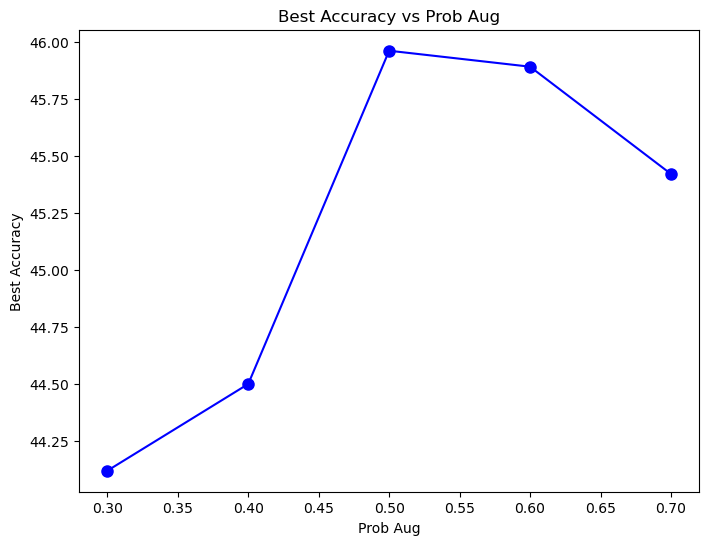

In [2]:
import matplotlib.pyplot as plt

prob_aug_values = [0.3,0.4,0.5,0.6,0.7]
best_acc_values = [44.12, 44.5, 45.96, 45.89, 45.42]

plt.figure(figsize=(8, 6))

plt.plot(prob_aug_values, best_acc_values, color='blue', linestyle='-', marker='o', markersize=8)

plt.title('Best Accuracy vs Prob Aug')
plt.xlabel('Prob Aug')
plt.ylabel('Best Accuracy')
plt.show()

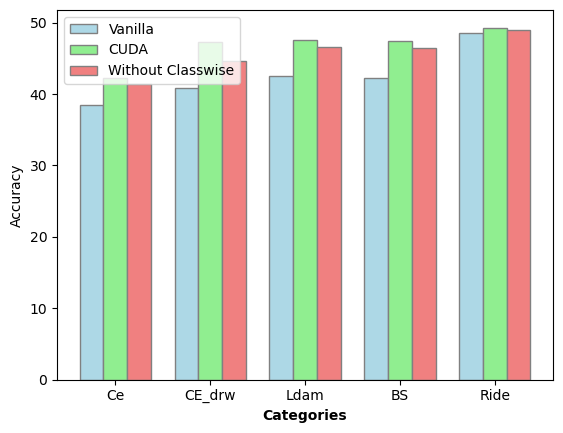

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Ce', 'CE_drw', 'Ldam', 'BS', 'Ride']
vanilla = [38.49, 40.86, 42.48, 42.24, 48.6]
cuda = [42.27, 47.23, 47.52, 47.47, 49.3]
without_classwise = [41.38, 44.61, 46.55, 46.49, 48.92]

# Width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(vanilla))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting
plt.bar(r1, vanilla, color='lightblue', width=bar_width, edgecolor='grey', label='Vanilla')
plt.bar(r2, cuda, color='lightgreen', width=bar_width, edgecolor='grey', label='CUDA')
plt.bar(r3, without_classwise, color='lightcoral', width=bar_width, edgecolor='grey', label='Without Classwise')

# Add xticks on the middle of the group bars
plt.xlabel('Categories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(vanilla))], categories)

# Add y label
plt.ylabel('Accuracy')

# Create legend & Show graphic
plt.legend()
plt.show()



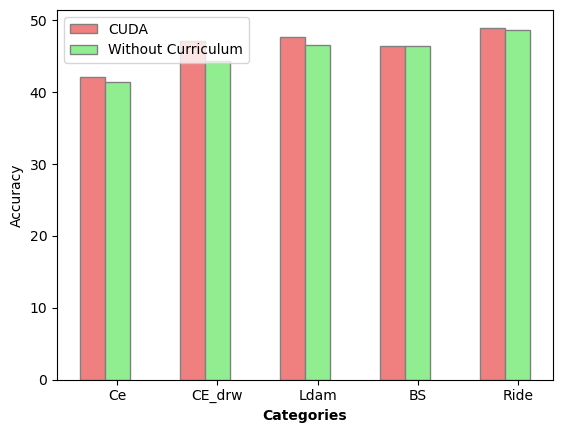

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Ce', 'CE_drw', 'Ldam', 'BS', 'Ride']

cuda = [42.07, 47.2, 47.73, 46.5, 49.01]
without_curriculum = [41.4, 44.3, 46.56, 46.49,48.72]

# Width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(vanilla))
r2 = [x + bar_width for x in r1]


# Plotting
plt.bar(r1, cuda, color='lightcoral', width=bar_width, edgecolor='grey', label='CUDA')
plt.bar(r2, without_curriculum, color='lightgreen', width=bar_width, edgecolor='grey', label='Without Curriculum')


# Add xticks on the middle of the group bars
plt.xlabel('Categories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(vanilla))], categories)

# Add y label
plt.ylabel('Accuracy')

# Create legend & Show graphic
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Ce', 'CE_drw', 'Ldam', 'BS', 'Ride']

cuda = [42.07, 47.2, 47.73, 46.5, 49.01]
without_curriculum = [41.4, 44.3, 46.56, 46.49,48.72]

# Width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(vanilla))
r2 = [x + bar_width for x in r1]


# Plotting
plt.bar(r1, cuda, color='lightcoral', width=bar_width, edgecolor='grey', label='CUDA')
plt.bar(r2, without_curriculum, color='lightgreen', width=bar_width, edgecolor='grey', label='Without Curriculum')


# Add xticks on the middle of the group bars
plt.xlabel('Categories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(vanilla))], categories)

# Add y label
plt.ylabel('Accuracy')

# Create legend & Show graphic
plt.legend()
plt.show()

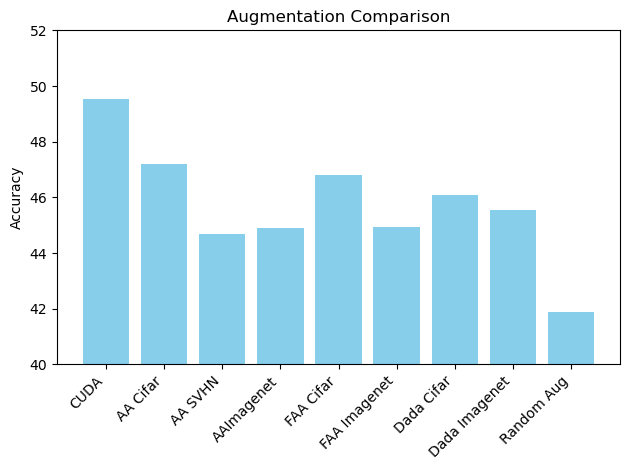

In [9]:
import matplotlib.pyplot as plt

# List of accuracies
accuracies = [49.53,47.2, 44.67, 44.9, 46.81, 44.92, 46.08, 45.55, 41.87]
labels = ["CUDA","AA Cifar", "AA SVHN", "AAImagenet",
          "FAA Cifar", "FAA Imagenet",
          "Dada Cifar", "Dada Imagenet", "Random Aug"]

# Plotting the bar plot
plt.bar(range(len(accuracies)), accuracies, color='skyblue')

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Augmentation Comparison')

# Adding labels to the bars
plt.xticks(range(len(accuracies)), labels, rotation=45, ha='right')
plt.ylim(40, 52)

# Showing the plot
plt.tight_layout()
plt.show()
